In [ ]:
!pip install pybaseball


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 60.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
project_folder = '/content/drive/MyDrive/PROJ2'
os.makedirs(project_folder, exist_ok=True)


Mounted at /content/drive


In [ ]:
import pybaseball
import pandas as pd
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pybaseball")

# Enable caching to reduce repeated API calls
pybaseball.cache.enable()

def fetch_data(start_date='2015-04-05', end_date='2024-10-01'):
    # Fetch data from Statcast
    full_data = pybaseball.statcast(start_dt=start_date, end_dt=end_date, verbose=True)

    # Preview data
    print("Data Preview:")
    print(full_data.head())

    return full_data

# Define function to add batter and pitcher names
def add_player_names(full_data):
    batter_names_df = pybaseball.playerid_reverse_lookup(full_data['batter'].to_list(), key_type='mlbam')
    pitcher_names_df = pybaseball.playerid_reverse_lookup(full_data['pitcher'].to_list(), key_type='mlbam')

    batter_names_df['full_name'] = batter_names_df['name_first'] + ' ' + batter_names_df['name_last']
    pitcher_names_df['full_name'] = pitcher_names_df['name_first'] + ' ' + pitcher_names_df['name_last']

    batter_names_dict = batter_names_df.set_index('key_mlbam')['full_name'].to_dict()
    pitcher_names_dict = pitcher_names_df.set_index('key_mlbam')['full_name'].to_dict()

    # Map the names back to the data
    full_data['batter_name'] = full_data['batter'].map(batter_names_dict)
    full_data['pitcher_name'] = full_data['pitcher'].map(pitcher_names_dict)

    return full_data

# Clean data by removing deprecated columns and duplicates
def clean_data(full_data):
    deprecated_columns = ['spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated',
                          'tfs_deprecated', 'tfs_zulu_deprecated', 'spin_dir', 'umpire']
    full_data.drop(columns=deprecated_columns, inplace=True)
    full_data.drop_duplicates(inplace=True)

    return full_data

# Save data to CSV in Google Drive
def save_data_to_csv(full_data, start_date, end_date):
    data_path = f'/content/drive/MyDrive/PROJ2/statcast_{start_date}_to_{end_date}.csv'
    full_data.to_csv(data_path, index=False)
    print(f"Data saved to {data_path}")

# Main workflow
start_date = '2015-04-05'
end_date = '2024-10-01'

# Fetch and clean data
data = fetch_data(start_date, end_date)
data = add_player_names(data)
data = clean_data(data)

# Save to CSV
save_data_to_csv(data, start_date, end_date)


This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)


Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 2114/2114 [57:16<00:00,  1.63s/it]


Data Preview:
    pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
598         CH 2024-10-01           88.1          -1.65           6.12   
609         CH 2024-10-01           87.1          -1.69           6.17   
650         CH 2024-10-01           89.7          -1.89           6.14   
653         FF 2024-10-01           97.5          -1.51           6.32   
691         CH 2024-10-01           88.6          -1.77           6.19   

       player_name  batter  pitcher     events      description  ...  \
598  Brieske, Beau  518792   689225  field_out    hit_into_play  ...   
609  Brieske, Beau  518792   689225        NaN  swinging_strike  ...   
650  Brieske, Beau  518792   689225        NaN             ball  ...   
653  Brieske, Beau  518792   689225        NaN             foul  ...   
691  Brieske, Beau  518792   689225        NaN     blocked_ball  ...   

     n_thruorder_pitcher  n_priorpa_thisgame_player_at_bat  \
598                    1                      

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
import warnings
import random

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your project folder in Google Drive
project_folder = '/content/drive/MyDrive/PROJ2'

# Suppress pandas warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

class DataProcessor:
    def __init__(self, raw_data, config_path, one_hot=True, seed=42):
        np.random.seed(seed)
        random.seed(seed)

        self.raw_data = raw_data
        self.config = self.load_config(config_path)
        self.selected_columns = list(self.config.keys())
        self.processed_data = self.raw_data[self.selected_columns].copy()
        self.one_hot = one_hot
        self.scalers = {}  # Dictionary to store scalers for each column

        print(f"Selected Columns: {self.selected_columns}")
        print(f'Raw Data Shape: {self.raw_data.shape}')

    def load_config(self, config_path):
        # Load the configuration file
        with open(config_path, 'r') as file:
            config = json.load(file)
        return config

    def handle_missing_values(self):
        # Handle missing values based on configuration
        for column, settings in self.config.items():
            if column == 'events':  # Handle 'events' column separately
                events_to_map = set(['caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'stolen_base_2b', 'stolen_base_3b', 'stolen_base_home', 'passed_ball'])
                self.processed_data[column] = self.raw_data.apply(
                    lambda row: row['type'] if pd.isnull(row[column]) or row[column] in events_to_map else row[column], axis=1)

            initial_missing_count = self.processed_data[column].isnull().sum()
            strategy = settings.get('missing_value_strategy', 'drop')
            if strategy == 'drop':
                self.processed_data.dropna(subset=[column], inplace=True)
            elif strategy in ['mean', 'median', 'mode']:
                if strategy == 'mean':
                    fill_value = self.processed_data[column].mean()
                elif strategy == 'median':
                    fill_value = self.processed_data[column].median()
                elif strategy == 'mode':
                    fill_value = self.processed_data[column].mode().iloc[0]
                self.processed_data[column].fillna(fill_value, inplace=True)
            elif isinstance(strategy, (int, float, str)):
                self.processed_data[column].fillna(strategy, inplace=True)

            final_missing_count = self.processed_data[column].isnull().sum()
            handled_count = initial_missing_count - final_missing_count
            print(f"Handled {handled_count} missing values in column '{column}'")
            print(f"Missing values after handling in column '{column}': {final_missing_count}")

    def convert_data_types(self):
        # Convert data types as specified in config
        for column, settings in self.config.items():
            if settings.get('categorical', False):
                initial_row_count = self.processed_data.shape[0]
                if 'value_map' in settings:
                    value_map = settings['value_map']
                    self.processed_data[column] = self.processed_data[column].replace(value_map)
                if 'drop_values' in settings:
                    drop_values = settings['drop_values']
                    self.processed_data = self.processed_data[~self.processed_data[column].isin(drop_values)]
                    final_row_count = self.processed_data.shape[0]
                    dropped_rows = initial_row_count - final_row_count
                    print(f"Dropped {dropped_rows} rows for column '{column}' due to drop values")
                self.processed_data[column] = self.processed_data[column].astype('category')
            elif 'datetime_format' in settings:
                self.processed_data[column] = pd.to_datetime(self.processed_data[column], format=settings['datetime_format'])

        print(f"Processed Data Shape after convert_data_types: {self.processed_data.shape}")

    def standardize_or_normalize(self):
        # Standardize numerical columns
        for column, settings in self.config.items():
            if settings.get('standardize', False):
                scaler = StandardScaler()
                self.processed_data[[column]] = scaler.fit_transform(self.processed_data[[column]])
                self.scalers[column] = scaler

        print(f"Processed Data Shape after standardize_or_normalize: {self.processed_data.shape}")

    def one_hot_encode(self):
        # One-hot encode categorical columns
        categorical_columns = [col for col, settings in self.config.items() if settings.get('categorical', False) and not settings.get('metadata', False)]

        if categorical_columns:
            # Check for NaN values before encoding
            for col in categorical_columns:
                missing_values_count = self.processed_data[col].isnull().sum()
                if missing_values_count > 0:
                    print(f"Column '{col}' has {missing_values_count} missing values before encoding.")

            # Perform one-hot encoding using pd.get_dummies
            self.processed_data = pd.get_dummies(data=self.processed_data, columns=categorical_columns, prefix=categorical_columns, drop_first=False)

        print(f"Processed Data Shape after one_hot_encode: {self.processed_data.shape}")

    def get_processed_data(self):
        # Process the data and return the cleaned dataset
        self.handle_missing_values()
        self.convert_data_types()
        self.standardize_or_normalize()
        if self.one_hot:
            self.one_hot_encode()
        print(f'New Data Shape: {self.processed_data.shape}')
        return self.processed_data

# Load your raw data (replace with your actual data loading code)
raw_data = pd.read_csv('/content/drive/MyDrive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')  # Example path to raw data

# Specify the path to your config file
config_path = f'{project_folder}/configv3.json'

# Create the DataProcessor object
data_processor = DataProcessor(raw_data, config_path)

# Process the data and get the cleaned dataset
processed_data = data_processor.get_processed_data()

# You can now use processed_data for further analysis or model training


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-3c7a6a324bc6>:125: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/content/drive/MyDrive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')  # Example path to raw data


Selected Columns: ['events', 'pitch_number', 'zone', 'launch_speed', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'batter', 'pitcher', 'stand', 'p_throws', 'hit_location', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'hc_x', 'hc_y', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'launch_angle', 'release_spin_rate', 'release_extension', 'game_pk', 'release_pos_y', 'at_bat_number', 'batter_name', 'pitcher_name']
Raw Data Shape: (6996810, 108)
Handled 0 missing values in column 'events'
Missing values after handling in column 'events': 0
Handled 0 missing values in column 'pitch_number'
Missing values after handling in column 'pitch_number': 0
Handled 96742 missing values in column 'zone'
Missing values after handling in column 'zone': 0
Handled 4874004 missing values in column 'launch_speed'
Missing values after handling in column 'launch_speed': 0
Handled 1572 missing values in column 'pitch_type'
Missing values after 

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
import warnings
import random

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your project folder in Google Drive
project_folder = '/content/drive/MyDrive/PROJ2'

# Suppress pandas warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

class DataProcessor:
    def __init__(self, raw_data, config_path, one_hot=True, seed=42):
        np.random.seed(seed)
        random.seed(seed)

        self.raw_data = raw_data
        self.config = self.load_config(config_path)
        self.selected_columns = list(self.config.keys())
        self.processed_data = self.raw_data[self.selected_columns].copy()
        self.one_hot = one_hot
        self.scalers = {}  # Dictionary to store scalers for each column

        print(f"Selected Columns: {self.selected_columns}")
        print(f'Raw Data Shape: {self.raw_data.shape}')

    def load_config(self, config_path):
        # Load the configuration file
        with open(config_path, 'r') as file:
            config = json.load(file)
        print("Configuration Loaded:", config)  # Debugging print
        return config

    def handle_missing_values(self):
        print("Handling missing values...")  # Debugging print
        # Handle missing values based on configuration
        for column, settings in self.config.items():
            if column == 'events':  # Handle 'events' column separately
                events_to_map = set(['caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'stolen_base_2b', 'stolen_base_3b', 'stolen_base_home', 'passed_ball'])
                self.processed_data[column] = self.raw_data.apply(
                    lambda row: row['type'] if pd.isnull(row[column]) or row[column] in events_to_map else row[column], axis=1)

            initial_missing_count = self.processed_data[column].isnull().sum()
            strategy = settings.get('missing_value_strategy', 'drop')
            if strategy == 'drop':
                self.processed_data.dropna(subset=[column], inplace=True)
            elif strategy in ['mean', 'median', 'mode']:
                if strategy == 'mean':
                    fill_value = self.processed_data[column].mean()
                elif strategy == 'median':
                    fill_value = self.processed_data[column].median()
                elif strategy == 'mode':
                    fill_value = self.processed_data[column].mode().iloc[0]
                self.processed_data[column].fillna(fill_value, inplace=True)
            elif isinstance(strategy, (int, float, str)):
                self.processed_data[column].fillna(strategy, inplace=True)

            final_missing_count = self.processed_data[column].isnull().sum()
            handled_count = initial_missing_count - final_missing_count
            print(f"Handled {handled_count} missing values in column '{column}'")
            print(f"Missing values after handling in column '{column}': {final_missing_count}")

    def convert_data_types(self):
        print("Converting data types...")  # Debugging print
        # Convert data types as specified in config
        for column, settings in self.config.items():
            if settings.get('categorical', False):
                initial_row_count = self.processed_data.shape[0]
                if 'value_map' in settings:
                    value_map = settings['value_map']
                    self.processed_data[column] = self.processed_data[column].replace(value_map)
                if 'drop_values' in settings:
                    drop_values = settings['drop_values']
                    self.processed_data = self.processed_data[~self.processed_data[column].isin(drop_values)]
                    final_row_count = self.processed_data.shape[0]
                    dropped_rows = initial_row_count - final_row_count
                    print(f"Dropped {dropped_rows} rows for column '{column}' due to drop values")
                self.processed_data[column] = self.processed_data[column].astype('category')
            elif 'datetime_format' in settings:
                self.processed_data[column] = pd.to_datetime(self.processed_data[column], format=settings['datetime_format'])

        print(f"Processed Data Shape after convert_data_types: {self.processed_data.shape}")

    def standardize_or_normalize(self):
        print("Standardizing or normalizing data...")  # Debugging print
        # Standardize numerical columns
        for column, settings in self.config.items():
            if settings.get('standardize', False):
                scaler = StandardScaler()
                self.processed_data[[column]] = scaler.fit_transform(self.processed_data[[column]])
                self.scalers[column] = scaler

        print(f"Processed Data Shape after standardize_or_normalize: {self.processed_data.shape}")

    def one_hot_encode(self):
        print("One-hot encoding categorical columns...")  # Debugging print
        # One-hot encode categorical columns
        categorical_columns = [col for col, settings in self.config.items() if settings.get('categorical', False) and not settings.get('metadata', False)]

        if categorical_columns:
            # Check for NaN values before encoding
            for col in categorical_columns:
                missing_values_count = self.processed_data[col].isnull().sum()
                if missing_values_count > 0:
                    print(f"Column '{col}' has {missing_values_count} missing values before encoding.")

            # Perform one-hot encoding using pd.get_dummies
            self.processed_data = pd.get_dummies(data=self.processed_data, columns=categorical_columns, prefix=categorical_columns, drop_first=False)

        print(f"Processed Data Shape after one_hot_encode: {self.processed_data.shape}")

    def get_processed_data(self):
        # Process the data and return the cleaned dataset
        print("Starting data processing...")  # Debugging print
        self.handle_missing_values()
        self.convert_data_types()
        self.standardize_or_normalize()
        if self.one_hot:
            self.one_hot_encode()
        print(f'New Data Shape: {self.processed_data.shape}')
        return self.processed_data

# Load your raw data (replace with your actual data loading code)
raw_data = pd.read_csv('/content/drive/MyDrive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')  # Example path to raw data
print(f'Raw Data Shape: {raw_data.shape}')  # Debugging print

# Check if the data is loaded correctly
if raw_data.empty:
    print("Raw data is empty!")
else:
    print("Raw data loaded successfully!")

# Specify the path to your config file
config_path = f'{project_folder}/configv3.json'

# Create the DataProcessor object
data_processor = DataProcessor(raw_data, config_path)

# Process the data and get the cleaned dataset
processed_data = data_processor.get_processed_data()


Mounted at /content/drive


<ipython-input-1-9b35e470a624>:131: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/content/drive/MyDrive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')  # Example path to raw data


Raw Data Shape: (6996810, 108)
Raw data loaded successfully!
Configuration Loaded: {'events': {'categorical': 'True', 'label': 'True', 'value_map': {'force_out': 'field_out', 'grounded_into_double_play': 'field_out', 'field_error': 'field_out', 'sac_fly': 'field_out', 'double_play': 'field_out', 'fielders_choice': 'field_out', 'fielders_choice_out': 'field_out', 'strikeout_double_play': 'strikeout', 'intent_walk': 'walk', 'other_out': 'field_out', 'sac_fly_double_play': 'field_out', 'wild_pitch': 'B', 'triple_play': 'field_out', 'sac_bunt_double_play': 'field_out'}, 'drop_values': ['sac_bunt', 'catcher_interf', 'pickoff_1b', 'pickoff_2b', 'pickoff_caught_stealing_2b', 'pickoff_3b', 'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home', 'game_advisory', 'ejection', 'runner_double_play', 'pickoff_error_3b', 'pickoff_error_2b'], 'missing_value_strategy': 'drop'}, 'pitch_number': {'metadata': 'True', 'missing_value_strategy': 'drop'}, 'zone': {'categorical': 'True', 'missing_value_s

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Replace 'your_file.csv' with the actual path to your file
processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')

# Or for Excel files:
# processed_data = pd.read_excel('your_file.xlsx')

# Check the first few rows of the data
print(processed_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-a0d206321cc1>:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')


  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         CH  2024-10-01           88.1          -1.65           6.12   
1         CH  2024-10-01           87.1          -1.69           6.17   
2         CH  2024-10-01           89.7          -1.89           6.14   
3         FF  2024-10-01           97.5          -1.51           6.32   
4         CH  2024-10-01           88.6          -1.77           6.19   

     player_name  batter  pitcher     events      description  ...  \
0  Brieske, Beau  518792   689225  field_out    hit_into_play  ...   
1  Brieske, Beau  518792   689225        NaN  swinging_strike  ...   
2  Brieske, Beau  518792   689225        NaN             ball  ...   
3  Brieske, Beau  518792   689225        NaN             foul  ...   
4  Brieske, Beau  518792   689225        NaN     blocked_ball  ...   

   pitcher_days_since_prev_game batter_days_since_prev_game  \
0                           3.0                         3.0   
1             

In [ ]:
import pandas as pd

# Load the data from your Google Drive
processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')

# Select relevant columns: pitcher, batter, pitch_type, outcome, and game_id
data = processed_data[['pitcher', 'batter', 'pitch_type', 'description', 'release_speed', 'balls', 'strikes']]

# For simplicity, I'll add a 'game_id' column that groups by games (you can adjust based on your needs)
# Assuming that each row represents a different pitch event in a game:
data['game_id'] = data.groupby('pitcher').cumcount() + 1  # Creates a new game_id incrementing for each pitcher

# Preview the first few rows of the dataframe to ensure correctness
print(data.head())

<ipython-input-3-097399ba9271>:4: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')


   pitcher  batter pitch_type      description  release_speed  balls  strikes  \
0   689225  518792         CH    hit_into_play           88.1      2        2   
1   689225  518792         CH  swinging_strike           87.1      2        1   
2   689225  518792         CH             ball           89.7      1        1   
3   689225  518792         FF             foul           97.5      1        0   
4   689225  518792         CH     blocked_ball           88.6      0        0   

   game_id  
0        1  
1        2  
2        3  
3        4  
4        5  


In [ ]:
import pandas as pd
import torch
import numpy as np
import random
import json
from torch.utils.data import Dataset


class BaseballDataset(Dataset):
    def __init__(self, data, config_path, sequence_length, seed=42):
        # Set the random seed for reproducibility
        self.seed = seed
        self.set_seed()

        # Load the configuration file
        self.config = self.load_config(config_path)

        # Store the data and sequence length
        self.data = data
        self.sequence_length = sequence_length

        # Initialize lists to hold processed data and target labels
        self.processed_pitches = []
        self.sequences = []
        self.pitch_type_labels = []  # For storing target pitch types for each sequence

        # Process the data
        self.process_all_pitches()

        # Prepare sequences
        self.prepare_sequences()

        # Convert the processed pitches into a tensor
        self.processed_pitches = torch.stack(self.processed_pitches)

    def set_seed(self):
        """Set random seeds for reproducibility."""
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        random.seed(self.seed)

    def load_config(self, config_path):
        """Load the configuration from a JSON file."""
        with open(config_path, 'r') as file:
            config = json.load(file)
        return config

    def process_all_pitches(self):
        """Process all the pitches into a numerical format."""
        pitch_type_map = {pitch: idx for idx, pitch in enumerate(self.data['pitch_type'].unique())}
        description_map = {desc: idx for idx, desc in enumerate(self.data['description'].unique())}

        for idx, row in self.data.iterrows():
            # Process each pitch row and convert categorical data to numeric values
            pitch_data = [
                row['pitcher'],
                row['batter'],
                pitch_type_map.get(row['pitch_type'], -1),  # Convert 'pitch_type' to numeric
                description_map.get(row['description'], -1),  # Convert 'description' to numeric
                row['release_speed'],
                row['balls'],
                row['strikes']
            ]
            self.processed_pitches.append(torch.FloatTensor(pitch_data))

    def prepare_sequences(self):
        """Prepare sequences for each batter and the corresponding pitch type label."""
        grouped = self.data.groupby('batter')

        for batter, group in grouped:
            # Sort pitches for each batter
            group = group.sort_values(by=['batter'])
            indices = group.index.tolist()

            # Create sliding window sequences with target (pitch_type) for each sequence
            for i in range(len(indices) - self.sequence_length + 1):
                sequence_indices = indices[i:i + self.sequence_length]
                self.sequences.append(torch.LongTensor(sequence_indices))

                # Get the pitch type of the last pitch in the sequence as the label
                last_pitch_idx = indices[i + self.sequence_length - 1]
                last_pitch_type = group.loc[last_pitch_idx, 'pitch_type']
                self.pitch_type_labels.append(last_pitch_type)

    def __len__(self):
        """Return the number of sequences in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """Return the sequence of pitches and its corresponding pitch type label."""
        sequence_indices = self.sequences[idx]
        sequence = torch.index_select(self.processed_pitches, 0, sequence_indices).clone()

        # Get the pitch type label for the sequence (target)
        target = self.pitch_type_labels[idx]
        return sequence, target


# Example of how to use the dataset
config_path = '/content/drive/My Drive/PROJ2/configv3.json'  # Make sure the path to the config is correct
sequence_length = 10  # Example sequence length

# Assuming `data` is a pandas DataFrame that contains the baseball data
processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')
data = processed_data[['pitcher', 'batter', 'pitch_type', 'description', 'release_speed', 'balls', 'strikes']]
dataset = BaseballDataset(data, config_path, sequence_length)

# Get a sequence sample and its corresponding pitch type label
sample_sequence, target_pitch_type = dataset[0]
print("Sample Sequence:", sample_sequence)
print("Target Pitch Type:", target_pitch_type)


<ipython-input-4-7d6c35e32157>:104: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_data = pd.read_csv('/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv')


Sample Sequence: tensor([[5.0201e+05, 1.1253e+05, 9.0000e+00, 5.0000e+00, 9.1600e+01, 0.0000e+00,
         0.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 0.0000e+00, 8.8800e+01, 1.0000e+00,
         2.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 6.0000e+00, 9.0100e+01, 1.0000e+00,
         1.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 5.0000e+00, 8.9400e+01, 1.0000e+00,
         0.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 2.0000e+00, 8.9600e+01, 0.0000e+00,
         0.0000e+00],
        [5.2705e+05, 1.1253e+05, 3.0000e+00, 1.0000e+00, 7.7900e+01, 1.0000e+00,
         2.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 7.0000e+00, 8.9900e+01, 1.0000e+00,
         1.0000e+00],
        [5.2705e+05, 1.1253e+05, 1.0000e+00, 5.0000e+00, 8.8300e+01, 1.0000e+00,
         0.0000e+00],
        [5.0201e+05, 1.1253e+05, 6.0000e+00, 5.0000e+00, 7.7100e+01, 2.0000e+00,
         2.0000e+00],
        [5.0201e+05, 1.1253e+05, 9.0000e+00, 3.0000e+00,

second option for the above dont need both just trying something out due to long runtimes

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for loading the data (already saved data)
train_data_path = "/content/drive/My Drive/PROJ2/train_data.csv"
valid_data_path = "/content/drive/My Drive/PROJ2/valid_data.csv"

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the training and validation data from CSV
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)

# Encode pitch_type as integers using LabelEncoder
label_encoder = LabelEncoder()
train_data['pitch_type'] = label_encoder.fit_transform(train_data['pitch_type'])
valid_data['pitch_type'] = label_encoder.transform(valid_data['pitch_type'])

# Define the BaseballDataset class
class BaseballDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Define a function to create sequences from the data
def create_sequences(df, sequence_length=5):
    sequences = []
    targets = []

    for batter, batter_data in df.groupby('batter'):
        batter_data = batter_data.sort_values(by='release_speed')  # Sort by time-like column

        for i in range(len(batter_data) - sequence_length):
            sequence = batter_data.iloc[i:i + sequence_length]
            target = batter_data.iloc[i + sequence_length]['pitch_type']

            sequences.append(sequence[['pitcher', 'batter', 'release_speed', 'balls', 'strikes']].values)
            targets.append(target)

    return np.array(sequences), np.array(targets)

# Generate sequences and targets for train and validation sets
X_train, y_train = create_sequences(train_data, sequence_length=5)
X_valid, y_valid = create_sequences(valid_data, sequence_length=5)

# Create Dataset and DataLoader instances
train_dataset = BaseballDataset(X_train, y_train)
valid_dataset = BaseballDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

print("DataLoader setup complete.")


Mounted at /content/drive
DataLoader setup complete.


In [ ]:
from tqdm import tqdm

# Iterate through all batches in the train_loader
print("Processing all training batches:")
for batch_idx, (sequences, targets) in enumerate(tqdm(train_loader, desc="Training")):
    sequences = sequences.to(device)
    targets = targets.to(device)
    # Print batch info every 100 batches for progress tracking
    if batch_idx % 100 == 0:
        print(f"Processed batch {batch_idx}: Sequences {sequences.shape}, Targets {targets.shape}")

# Iterate through all batches in the valid_loader
print("Processing all validation batches:")
for batch_idx, (sequences, targets) in enumerate(tqdm(valid_loader, desc="Validation")):
    sequences = sequences.to(device)
    targets = targets.to(device)
    # Print batch info every 100 batches for progress tracking
    if batch_idx % 100 == 0:
        print(f"Processed batch {batch_idx}: Sequences {sequences.shape}, Targets {targets.shape}")


Processing all training batches:


Training:   0%|          | 47/42986 [00:00<08:26, 84.74it/s] 

Processed batch 0: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   0%|          | 189/42986 [00:01<02:25, 293.25it/s]

Processed batch 100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   1%|          | 285/42986 [00:01<01:53, 376.59it/s]

Processed batch 200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   1%|          | 380/42986 [00:01<01:50, 386.96it/s]

Processed batch 300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   1%|          | 476/42986 [00:01<01:39, 429.21it/s]

Processed batch 400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   1%|▏         | 572/42986 [00:01<01:34, 450.46it/s]

Processed batch 500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   2%|▏         | 669/42986 [00:02<01:31, 463.57it/s]

Processed batch 600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   2%|▏         | 765/42986 [00:02<01:30, 468.43it/s]

Processed batch 700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   2%|▏         | 860/42986 [00:02<01:30, 466.57it/s]

Processed batch 800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   2%|▏         | 955/42986 [00:02<01:29, 467.33it/s]

Processed batch 900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   2%|▏         | 1050/42986 [00:02<01:29, 470.98it/s]

Processed batch 1000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   3%|▎         | 1195/42986 [00:03<01:28, 473.88it/s]

Processed batch 1100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   3%|▎         | 1291/42986 [00:03<01:29, 467.48it/s]

Processed batch 1200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   3%|▎         | 1386/42986 [00:03<01:28, 467.87it/s]

Processed batch 1300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   3%|▎         | 1481/42986 [00:03<01:28, 468.41it/s]

Processed batch 1400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   4%|▎         | 1575/42986 [00:04<01:28, 466.95it/s]

Processed batch 1500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   4%|▍         | 1669/42986 [00:04<01:30, 457.88it/s]

Processed batch 1600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   4%|▍         | 1760/42986 [00:04<01:33, 440.50it/s]

Processed batch 1700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   4%|▍         | 1855/42986 [00:04<01:30, 454.98it/s]

Processed batch 1800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   5%|▍         | 1949/42986 [00:04<01:29, 459.84it/s]

Processed batch 1900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   5%|▍         | 2090/42986 [00:05<01:28, 460.28it/s]

Processed batch 2000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   5%|▌         | 2183/42986 [00:05<01:29, 457.70it/s]

Processed batch 2100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   5%|▌         | 2276/42986 [00:05<01:29, 455.67it/s]

Processed batch 2200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   6%|▌         | 2368/42986 [00:05<01:30, 450.66it/s]

Processed batch 2300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   6%|▌         | 2459/42986 [00:06<01:31, 440.62it/s]

Processed batch 2400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   6%|▌         | 2548/42986 [00:06<01:34, 429.73it/s]

Processed batch 2500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   6%|▌         | 2676/42986 [00:06<01:38, 408.01it/s]

Processed batch 2600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   6%|▋         | 2759/42986 [00:06<01:39, 405.61it/s]

Processed batch 2700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   7%|▋         | 2891/42986 [00:07<01:33, 428.25it/s]

Processed batch 2800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   7%|▋         | 2983/42986 [00:07<01:30, 443.63it/s]

Processed batch 2900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   7%|▋         | 3075/42986 [00:07<01:28, 449.65it/s]

Processed batch 3000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   7%|▋         | 3170/42986 [00:07<01:26, 458.36it/s]

Processed batch 3100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   8%|▊         | 3264/42986 [00:07<01:28, 448.40it/s]

Processed batch 3200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   8%|▊         | 3359/42986 [00:08<01:26, 459.63it/s]

Processed batch 3300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   8%|▊         | 3453/42986 [00:08<01:25, 463.87it/s]

Processed batch 3400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   8%|▊         | 3594/42986 [00:08<01:26, 454.55it/s]

Processed batch 3500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   9%|▊         | 3689/42986 [00:08<01:25, 462.20it/s]

Processed batch 3600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   9%|▉         | 3784/42986 [00:08<01:24, 464.83it/s]

Processed batch 3700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   9%|▉         | 3879/42986 [00:09<01:23, 467.43it/s]

Processed batch 3800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   9%|▉         | 3972/42986 [00:09<01:26, 452.35it/s]

Processed batch 3900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:   9%|▉         | 4067/42986 [00:09<01:24, 462.12it/s]

Processed batch 4000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  10%|▉         | 4162/42986 [00:09<01:23, 465.99it/s]

Processed batch 4100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  10%|▉         | 4256/42986 [00:10<01:23, 466.17it/s]

Processed batch 4200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  10%|█         | 4352/42986 [00:10<01:22, 469.49it/s]

Processed batch 4300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  10%|█         | 4493/42986 [00:10<01:23, 459.79it/s]

Processed batch 4400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  11%|█         | 4589/42986 [00:10<01:22, 467.45it/s]

Processed batch 4500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  11%|█         | 4685/42986 [00:10<01:21, 471.54it/s]

Processed batch 4600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  11%|█         | 4781/42986 [00:11<01:20, 472.73it/s]

Processed batch 4700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  11%|█▏        | 4876/42986 [00:11<01:21, 466.64it/s]

Processed batch 4800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  12%|█▏        | 4971/42986 [00:11<01:21, 468.89it/s]

Processed batch 4900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  12%|█▏        | 5066/42986 [00:11<01:20, 468.88it/s]

Processed batch 5000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  12%|█▏        | 5161/42986 [00:11<01:20, 467.41it/s]

Processed batch 5100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  12%|█▏        | 5256/42986 [00:12<01:20, 469.02it/s]

Processed batch 5200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  12%|█▏        | 5351/42986 [00:12<01:20, 467.49it/s]

Processed batch 5300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  13%|█▎        | 5493/42986 [00:12<01:19, 468.78it/s]

Processed batch 5400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  13%|█▎        | 5588/42986 [00:12<01:19, 469.07it/s]

Processed batch 5500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  13%|█▎        | 5682/42986 [00:13<01:19, 468.06it/s]

Processed batch 5600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  13%|█▎        | 5777/42986 [00:13<01:19, 468.96it/s]

Processed batch 5700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  14%|█▎        | 5872/42986 [00:13<01:19, 467.99it/s]

Processed batch 5800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  14%|█▍        | 5966/42986 [00:13<01:19, 467.59it/s]

Processed batch 5900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  14%|█▍        | 6060/42986 [00:13<01:19, 463.26it/s]

Processed batch 6000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  14%|█▍        | 6155/42986 [00:14<01:19, 465.85it/s]

Processed batch 6100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  15%|█▍        | 6249/42986 [00:14<01:19, 462.22it/s]

Processed batch 6200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  15%|█▍        | 6390/42986 [00:14<01:19, 461.71it/s]

Processed batch 6300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  15%|█▌        | 6484/42986 [00:14<01:18, 462.47it/s]

Processed batch 6400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  15%|█▌        | 6579/42986 [00:15<01:18, 466.64it/s]

Processed batch 6500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  16%|█▌        | 6673/42986 [00:15<01:17, 466.99it/s]

Processed batch 6600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  16%|█▌        | 6768/42986 [00:15<01:17, 467.09it/s]

Processed batch 6700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  16%|█▌        | 6862/42986 [00:15<01:17, 464.40it/s]

Processed batch 6800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  16%|█▌        | 6956/42986 [00:15<01:17, 464.01it/s]

Processed batch 6900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  16%|█▋        | 7050/42986 [00:16<01:17, 463.15it/s]

Processed batch 7000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  17%|█▋        | 7191/42986 [00:16<01:16, 466.02it/s]

Processed batch 7100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  17%|█▋        | 7286/42986 [00:16<01:16, 464.45it/s]

Processed batch 7200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  17%|█▋        | 7380/42986 [00:16<01:16, 464.24it/s]

Processed batch 7300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  17%|█▋        | 7474/42986 [00:16<01:16, 463.26it/s]

Processed batch 7400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  18%|█▊        | 7569/42986 [00:17<01:15, 466.69it/s]

Processed batch 7500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  18%|█▊        | 7663/42986 [00:17<01:15, 465.50it/s]

Processed batch 7600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  18%|█▊        | 7758/42986 [00:17<01:15, 467.57it/s]

Processed batch 7700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  18%|█▊        | 7853/42986 [00:17<01:15, 468.27it/s]

Processed batch 7800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  19%|█▊        | 7995/42986 [00:18<01:15, 466.50it/s]

Processed batch 7900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  19%|█▉        | 8090/42986 [00:18<01:14, 467.85it/s]

Processed batch 8000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  19%|█▉        | 8184/42986 [00:18<01:14, 465.36it/s]

Processed batch 8100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  19%|█▉        | 8279/42986 [00:18<01:14, 467.01it/s]

Processed batch 8200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  19%|█▉        | 8373/42986 [00:18<01:14, 462.81it/s]

Processed batch 8300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  20%|█▉        | 8467/42986 [00:19<01:14, 463.06it/s]

Processed batch 8400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  20%|█▉        | 8562/42986 [00:19<01:13, 467.60it/s]

Processed batch 8500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  20%|██        | 8656/42986 [00:19<01:14, 462.62it/s]

Processed batch 8600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  20%|██        | 8750/42986 [00:19<01:13, 463.08it/s]

Processed batch 8700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  21%|██        | 8892/42986 [00:19<01:13, 466.19it/s]

Processed batch 8800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  21%|██        | 8987/42986 [00:20<01:12, 469.07it/s]

Processed batch 8900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  21%|██        | 9081/42986 [00:20<01:12, 465.44it/s]

Processed batch 9000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  21%|██▏       | 9176/42986 [00:20<01:12, 466.97it/s]

Processed batch 9100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  22%|██▏       | 9270/42986 [00:20<01:12, 465.44it/s]

Processed batch 9200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  22%|██▏       | 9365/42986 [00:21<01:12, 465.96it/s]

Processed batch 9300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  22%|██▏       | 9459/42986 [00:21<01:12, 465.58it/s]

Processed batch 9400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  22%|██▏       | 9554/42986 [00:21<01:11, 467.66it/s]

Processed batch 9500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  22%|██▏       | 9648/42986 [00:21<01:11, 464.98it/s]

Processed batch 9600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  23%|██▎       | 9791/42986 [00:21<01:10, 468.74it/s]

Processed batch 9700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  23%|██▎       | 9886/42986 [00:22<01:10, 468.39it/s]

Processed batch 9800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  23%|██▎       | 9981/42986 [00:22<01:10, 468.85it/s]

Processed batch 9900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  23%|██▎       | 10076/42986 [00:22<01:10, 467.07it/s]

Processed batch 10000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  24%|██▎       | 10170/42986 [00:22<01:10, 463.51it/s]

Processed batch 10100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  24%|██▍       | 10265/42986 [00:22<01:10, 465.66it/s]

Processed batch 10200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  24%|██▍       | 10360/42986 [00:23<01:09, 467.88it/s]

Processed batch 10300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  24%|██▍       | 10454/42986 [00:23<01:09, 465.48it/s]

Processed batch 10400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  25%|██▍       | 10550/42986 [00:23<01:09, 468.90it/s]

Processed batch 10500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  25%|██▍       | 10692/42986 [00:23<01:09, 467.71it/s]

Processed batch 10600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  25%|██▌       | 10786/42986 [00:24<01:08, 467.45it/s]

Processed batch 10700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  25%|██▌       | 10881/42986 [00:24<01:08, 470.58it/s]

Processed batch 10800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  26%|██▌       | 10976/42986 [00:24<01:09, 460.26it/s]

Processed batch 10900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  26%|██▌       | 11071/42986 [00:24<01:08, 462.90it/s]

Processed batch 11000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  26%|██▌       | 11166/42986 [00:24<01:08, 465.06it/s]

Processed batch 11100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  26%|██▌       | 11261/42986 [00:25<01:07, 467.42it/s]

Processed batch 11200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  26%|██▋       | 11356/42986 [00:25<01:07, 469.32it/s]

Processed batch 11300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  27%|██▋       | 11451/42986 [00:25<01:07, 467.01it/s]

Processed batch 11400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  27%|██▋       | 11592/42986 [00:25<01:07, 463.69it/s]

Processed batch 11500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  27%|██▋       | 11686/42986 [00:25<01:07, 461.57it/s]

Processed batch 11600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  27%|██▋       | 11781/42986 [00:26<01:07, 464.88it/s]

Processed batch 11700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  28%|██▊       | 11875/42986 [00:26<01:07, 459.71it/s]

Processed batch 11800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  28%|██▊       | 11969/42986 [00:26<01:07, 462.86it/s]

Processed batch 11900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  28%|██▊       | 12063/42986 [00:26<01:06, 465.20it/s]

Processed batch 12000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  28%|██▊       | 12158/42986 [00:27<01:06, 466.23it/s]

Processed batch 12100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  29%|██▊       | 12253/42986 [00:27<01:05, 469.44it/s]

Processed batch 12200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  29%|██▊       | 12347/42986 [00:27<01:05, 466.97it/s]

Processed batch 12300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  29%|██▉       | 12489/42986 [00:27<01:05, 466.27it/s]

Processed batch 12400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  29%|██▉       | 12584/42986 [00:27<01:05, 467.08it/s]

Processed batch 12500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  29%|██▉       | 12679/42986 [00:28<01:04, 468.80it/s]

Processed batch 12600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  30%|██▉       | 12774/42986 [00:28<01:04, 466.49it/s]

Processed batch 12700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  30%|██▉       | 12869/42986 [00:28<01:04, 464.12it/s]

Processed batch 12800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  30%|███       | 12964/42986 [00:28<01:04, 466.08it/s]

Processed batch 12900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  30%|███       | 13058/42986 [00:28<01:04, 465.12it/s]

Processed batch 13000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  31%|███       | 13153/42986 [00:29<01:04, 465.66it/s]

Processed batch 13100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  31%|███       | 13295/42986 [00:29<01:03, 465.71it/s]

Processed batch 13200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  31%|███       | 13390/42986 [00:29<01:03, 466.05it/s]

Processed batch 13300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  31%|███▏      | 13485/42986 [00:29<01:03, 467.56it/s]

Processed batch 13400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  32%|███▏      | 13580/42986 [00:30<01:02, 469.59it/s]

Processed batch 13500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  32%|███▏      | 13674/42986 [00:30<01:02, 467.26it/s]

Processed batch 13600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  32%|███▏      | 13768/42986 [00:30<01:02, 464.96it/s]

Processed batch 13700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  32%|███▏      | 13862/42986 [00:30<01:03, 459.99it/s]

Processed batch 13800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  32%|███▏      | 13957/42986 [00:30<01:02, 467.25it/s]

Processed batch 13900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  33%|███▎      | 14051/42986 [00:31<01:02, 465.67it/s]

Processed batch 14000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  33%|███▎      | 14194/42986 [00:31<01:01, 467.87it/s]

Processed batch 14100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  33%|███▎      | 14289/42986 [00:31<01:02, 461.92it/s]

Processed batch 14200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  33%|███▎      | 14382/42986 [00:31<01:03, 453.36it/s]

Processed batch 14300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  34%|███▎      | 14475/42986 [00:31<01:02, 457.57it/s]

Processed batch 14400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  34%|███▍      | 14567/42986 [00:32<01:04, 438.19it/s]

Processed batch 14500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  34%|███▍      | 14660/42986 [00:32<01:03, 446.10it/s]

Processed batch 14600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  34%|███▍      | 14754/42986 [00:32<01:01, 457.51it/s]

Processed batch 14700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  35%|███▍      | 14849/42986 [00:32<01:00, 462.70it/s]

Processed batch 14800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  35%|███▍      | 14992/42986 [00:33<00:59, 468.00it/s]

Processed batch 14900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  35%|███▌      | 15087/42986 [00:33<00:59, 469.26it/s]

Processed batch 15000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  35%|███▌      | 15182/42986 [00:33<00:59, 468.88it/s]

Processed batch 15100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  36%|███▌      | 15276/42986 [00:33<00:59, 466.93it/s]

Processed batch 15200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  36%|███▌      | 15371/42986 [00:33<00:59, 467.64it/s]

Processed batch 15300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  36%|███▌      | 15466/42986 [00:34<00:58, 471.59it/s]

Processed batch 15400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  36%|███▌      | 15562/42986 [00:34<00:58, 472.02it/s]

Processed batch 15500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  36%|███▋      | 15657/42986 [00:34<00:58, 466.33it/s]

Processed batch 15600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  37%|███▋      | 15753/42986 [00:34<00:58, 468.57it/s]

Processed batch 15700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  37%|███▋      | 15848/42986 [00:34<00:57, 469.97it/s]

Processed batch 15800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  37%|███▋      | 15991/42986 [00:35<00:57, 466.51it/s]

Processed batch 15900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  37%|███▋      | 16086/42986 [00:35<00:57, 466.50it/s]

Processed batch 16000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  38%|███▊      | 16180/42986 [00:35<00:57, 465.06it/s]

Processed batch 16100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  38%|███▊      | 16275/42986 [00:35<00:57, 466.27it/s]

Processed batch 16200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  38%|███▊      | 16370/42986 [00:36<00:56, 467.79it/s]

Processed batch 16300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  38%|███▊      | 16465/42986 [00:36<00:56, 469.92it/s]

Processed batch 16400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  39%|███▊      | 16560/42986 [00:36<00:56, 468.63it/s]

Processed batch 16500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  39%|███▊      | 16655/42986 [00:36<00:56, 468.40it/s]

Processed batch 16600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  39%|███▉      | 16749/42986 [00:36<00:56, 466.75it/s]

Processed batch 16700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  39%|███▉      | 16891/42986 [00:37<00:55, 468.68it/s]

Processed batch 16800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  40%|███▉      | 16985/42986 [00:37<00:55, 466.92it/s]

Processed batch 16900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  40%|███▉      | 17079/42986 [00:37<00:55, 467.48it/s]

Processed batch 17000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  40%|███▉      | 17175/42986 [00:37<00:54, 470.72it/s]

Processed batch 17100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  40%|████      | 17270/42986 [00:38<00:55, 467.26it/s]

Processed batch 17200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  40%|████      | 17364/42986 [00:38<00:54, 466.07it/s]

Processed batch 17300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  41%|████      | 17459/42986 [00:38<00:54, 466.18it/s]

Processed batch 17400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  41%|████      | 17554/42986 [00:38<00:54, 467.56it/s]

Processed batch 17500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  41%|████      | 17650/42986 [00:38<00:53, 470.17it/s]

Processed batch 17600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  41%|████▏     | 17794/42986 [00:39<00:53, 474.26it/s]

Processed batch 17700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  42%|████▏     | 17890/42986 [00:39<00:53, 472.96it/s]

Processed batch 17800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  42%|████▏     | 17986/42986 [00:39<00:53, 468.31it/s]

Processed batch 17900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  42%|████▏     | 18081/42986 [00:39<00:53, 465.67it/s]

Processed batch 18000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  42%|████▏     | 18177/42986 [00:39<00:52, 470.81it/s]

Processed batch 18100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  43%|████▎     | 18273/42986 [00:40<00:52, 471.92it/s]

Processed batch 18200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  43%|████▎     | 18368/42986 [00:40<00:53, 461.15it/s]

Processed batch 18300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  43%|████▎     | 18462/42986 [00:40<00:53, 460.64it/s]

Processed batch 18400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  43%|████▎     | 18557/42986 [00:40<00:52, 463.90it/s]

Processed batch 18500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  43%|████▎     | 18651/42986 [00:40<00:52, 462.68it/s]

Processed batch 18600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  44%|████▎     | 18792/42986 [00:41<00:52, 461.65it/s]

Processed batch 18700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  44%|████▍     | 18887/42986 [00:41<00:52, 460.60it/s]

Processed batch 18800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  44%|████▍     | 18982/42986 [00:41<00:51, 465.15it/s]

Processed batch 18900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  44%|████▍     | 19077/42986 [00:41<00:51, 467.52it/s]

Processed batch 19000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  45%|████▍     | 19172/42986 [00:42<00:50, 468.81it/s]

Processed batch 19100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  45%|████▍     | 19266/42986 [00:42<00:50, 466.32it/s]

Processed batch 19200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  45%|████▌     | 19360/42986 [00:42<00:51, 457.60it/s]

Processed batch 19300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  45%|████▌     | 19453/42986 [00:42<00:51, 459.41it/s]

Processed batch 19400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  45%|████▌     | 19549/42986 [00:42<00:50, 467.14it/s]

Processed batch 19500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  46%|████▌     | 19691/42986 [00:43<00:49, 467.34it/s]

Processed batch 19600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  46%|████▌     | 19785/42986 [00:43<00:49, 464.31it/s]

Processed batch 19700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  46%|████▌     | 19880/42986 [00:43<00:49, 467.78it/s]

Processed batch 19800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  46%|████▋     | 19974/42986 [00:43<00:49, 466.95it/s]

Processed batch 19900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  47%|████▋     | 20068/42986 [00:44<00:49, 464.32it/s]

Processed batch 20000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  47%|████▋     | 20162/42986 [00:44<00:49, 456.79it/s]

Processed batch 20100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  47%|████▋     | 20254/42986 [00:44<00:50, 449.06it/s]

Processed batch 20200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  47%|████▋     | 20393/42986 [00:44<00:49, 455.02it/s]

Processed batch 20300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  48%|████▊     | 20488/42986 [00:44<00:48, 460.79it/s]

Processed batch 20400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  48%|████▊     | 20582/42986 [00:45<00:48, 463.58it/s]

Processed batch 20500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  48%|████▊     | 20677/42986 [00:45<00:48, 463.14it/s]

Processed batch 20600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  48%|████▊     | 20771/42986 [00:45<00:47, 463.51it/s]

Processed batch 20700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  49%|████▊     | 20866/42986 [00:45<00:47, 464.34it/s]

Processed batch 20800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  49%|████▉     | 20961/42986 [00:45<00:47, 467.38it/s]

Processed batch 20900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  49%|████▉     | 21056/42986 [00:46<00:46, 467.67it/s]

Processed batch 21000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  49%|████▉     | 21151/42986 [00:46<00:46, 468.32it/s]

Processed batch 21100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  50%|████▉     | 21294/42986 [00:46<00:46, 468.91it/s]

Processed batch 21200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  50%|████▉     | 21389/42986 [00:46<00:45, 470.70it/s]

Processed batch 21300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  50%|████▉     | 21484/42986 [00:47<00:45, 469.02it/s]

Processed batch 21400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  50%|█████     | 21579/42986 [00:47<00:45, 470.72it/s]

Processed batch 21500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  50%|█████     | 21675/42986 [00:47<00:45, 470.76it/s]

Processed batch 21600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  51%|█████     | 21771/42986 [00:47<00:45, 468.72it/s]

Processed batch 21700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  51%|█████     | 21866/42986 [00:47<00:44, 471.30it/s]

Processed batch 21800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  51%|█████     | 21961/42986 [00:48<00:51, 404.39it/s]

Processed batch 21900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  51%|█████▏    | 22054/42986 [00:48<00:48, 431.73it/s]

Processed batch 22000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  52%|█████▏    | 22148/42986 [00:48<00:46, 447.76it/s]

Processed batch 22100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  52%|█████▏    | 22289/42986 [00:48<00:45, 459.79it/s]

Processed batch 22200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  52%|█████▏    | 22384/42986 [00:49<00:44, 465.05it/s]

Processed batch 22300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  52%|█████▏    | 22478/42986 [00:49<00:44, 465.07it/s]

Processed batch 22400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  53%|█████▎    | 22572/42986 [00:49<00:43, 464.64it/s]

Processed batch 22500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  53%|█████▎    | 22667/42986 [00:49<00:43, 465.98it/s]

Processed batch 22600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  53%|█████▎    | 22762/42986 [00:49<00:43, 468.16it/s]

Processed batch 22700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  53%|█████▎    | 22857/42986 [00:50<00:42, 470.64it/s]

Processed batch 22800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  53%|█████▎    | 22953/42986 [00:50<00:42, 470.15it/s]

Processed batch 22900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  54%|█████▎    | 23049/42986 [00:50<00:42, 468.31it/s]

Processed batch 23000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  54%|█████▍    | 23191/42986 [00:50<00:42, 468.47it/s]

Processed batch 23100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  54%|█████▍    | 23286/42986 [00:50<00:41, 470.63it/s]

Processed batch 23200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  54%|█████▍    | 23382/42986 [00:51<00:41, 471.57it/s]

Processed batch 23300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  55%|█████▍    | 23478/42986 [00:51<00:41, 468.35it/s]

Processed batch 23400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  55%|█████▍    | 23574/42986 [00:51<00:41, 469.99it/s]

Processed batch 23500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  55%|█████▌    | 23670/42986 [00:51<00:41, 470.69it/s]

Processed batch 23600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  55%|█████▌    | 23767/42986 [00:52<00:40, 473.37it/s]

Processed batch 23700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  56%|█████▌    | 23863/42986 [00:52<00:40, 472.46it/s]

Processed batch 23800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  56%|█████▌    | 23959/42986 [00:52<00:40, 472.30it/s]

Processed batch 23900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  56%|█████▌    | 24055/42986 [00:52<00:40, 470.04it/s]

Processed batch 24000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  56%|█████▌    | 24151/42986 [00:52<00:40, 469.58it/s]

Processed batch 24100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  57%|█████▋    | 24295/42986 [00:53<00:39, 473.68it/s]

Processed batch 24200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  57%|█████▋    | 24391/42986 [00:53<00:40, 464.52it/s]

Processed batch 24300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  57%|█████▋    | 24486/42986 [00:53<00:39, 468.04it/s]

Processed batch 24400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  57%|█████▋    | 24581/42986 [00:53<00:39, 468.41it/s]

Processed batch 24500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  57%|█████▋    | 24678/42986 [00:53<00:38, 473.36it/s]

Processed batch 24600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  58%|█████▊    | 24774/42986 [00:54<00:38, 474.68it/s]

Processed batch 24700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  58%|█████▊    | 24870/42986 [00:54<00:38, 470.61it/s]

Processed batch 24800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  58%|█████▊    | 24966/42986 [00:54<00:38, 473.92it/s]

Processed batch 24900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  58%|█████▊    | 25061/42986 [00:54<00:38, 467.99it/s]

Processed batch 25000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  59%|█████▊    | 25156/42986 [00:54<00:37, 470.03it/s]

Processed batch 25100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  59%|█████▊    | 25252/42986 [00:55<00:37, 469.06it/s]

Processed batch 25200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  59%|█████▉    | 25393/42986 [00:55<00:38, 460.97it/s]

Processed batch 25300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  59%|█████▉    | 25488/42986 [00:55<00:37, 466.44it/s]

Processed batch 25400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  60%|█████▉    | 25583/42986 [00:55<00:37, 468.53it/s]

Processed batch 25500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  60%|█████▉    | 25678/42986 [00:56<00:36, 469.62it/s]

Processed batch 25600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  60%|█████▉    | 25773/42986 [00:56<00:36, 469.60it/s]

Processed batch 25700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  60%|██████    | 25868/42986 [00:56<00:36, 463.55it/s]

Processed batch 25800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  60%|██████    | 25963/42986 [00:56<00:36, 462.97it/s]

Processed batch 25900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  61%|██████    | 26058/42986 [00:56<00:36, 465.25it/s]

Processed batch 26000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  61%|██████    | 26153/42986 [00:57<00:35, 468.59it/s]

Processed batch 26100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  61%|██████    | 26248/42986 [00:57<00:36, 463.27it/s]

Processed batch 26200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  61%|██████▏   | 26390/42986 [00:57<00:35, 469.61it/s]

Processed batch 26300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  62%|██████▏   | 26485/42986 [00:57<00:35, 470.44it/s]

Processed batch 26400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  62%|██████▏   | 26582/42986 [00:58<00:34, 472.65it/s]

Processed batch 26500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  62%|██████▏   | 26678/42986 [00:58<00:34, 472.58it/s]

Processed batch 26600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  62%|██████▏   | 26774/42986 [00:58<00:34, 469.93it/s]

Processed batch 26700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  63%|██████▎   | 26869/42986 [00:58<00:34, 467.93it/s]

Processed batch 26800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  63%|██████▎   | 26964/42986 [00:58<00:34, 469.61it/s]

Processed batch 26900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  63%|██████▎   | 27059/42986 [00:59<00:33, 470.21it/s]

Processed batch 27000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  63%|██████▎   | 27155/42986 [00:59<00:33, 469.25it/s]

Processed batch 27100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  63%|██████▎   | 27249/42986 [00:59<00:33, 465.58it/s]

Processed batch 27200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  64%|██████▎   | 27392/42986 [00:59<00:33, 468.37it/s]

Processed batch 27300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  64%|██████▍   | 27489/42986 [00:59<00:32, 473.38it/s]

Processed batch 27400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  64%|██████▍   | 27585/42986 [01:00<00:32, 472.42it/s]

Processed batch 27500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  64%|██████▍   | 27680/42986 [01:00<00:32, 468.15it/s]

Processed batch 27600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  65%|██████▍   | 27774/42986 [01:00<00:32, 467.37it/s]

Processed batch 27700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  65%|██████▍   | 27869/42986 [01:00<00:32, 468.94it/s]

Processed batch 27800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  65%|██████▌   | 27964/42986 [01:00<00:31, 470.76it/s]

Processed batch 27900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  65%|██████▌   | 28061/42986 [01:01<00:31, 472.68it/s]

Processed batch 28000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  66%|██████▌   | 28157/42986 [01:01<00:31, 470.73it/s]

Processed batch 28100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  66%|██████▌   | 28253/42986 [01:01<00:31, 468.87it/s]

Processed batch 28200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  66%|██████▌   | 28349/42986 [01:01<00:31, 471.38it/s]

Processed batch 28300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  66%|██████▋   | 28493/42986 [01:02<00:30, 472.67it/s]

Processed batch 28400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  67%|██████▋   | 28589/42986 [01:02<00:30, 470.80it/s]

Processed batch 28500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  67%|██████▋   | 28685/42986 [01:02<00:30, 467.19it/s]

Processed batch 28600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  67%|██████▋   | 28779/42986 [01:02<00:30, 465.99it/s]

Processed batch 28700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  67%|██████▋   | 28874/42986 [01:02<00:30, 469.14it/s]

Processed batch 28800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  67%|██████▋   | 28968/42986 [01:03<00:29, 467.80it/s]

Processed batch 28900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  68%|██████▊   | 29062/42986 [01:03<00:29, 466.02it/s]

Processed batch 29000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  68%|██████▊   | 29158/42986 [01:03<00:29, 470.20it/s]

Processed batch 29100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  68%|██████▊   | 29254/42986 [01:03<00:29, 471.72it/s]

Processed batch 29200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  68%|██████▊   | 29350/42986 [01:03<00:28, 474.08it/s]

Processed batch 29300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  69%|██████▊   | 29494/42986 [01:04<00:28, 473.06it/s]

Processed batch 29400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  69%|██████▉   | 29590/42986 [01:04<00:28, 471.14it/s]

Processed batch 29500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  69%|██████▉   | 29686/42986 [01:04<00:28, 469.44it/s]

Processed batch 29600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  69%|██████▉   | 29781/42986 [01:04<00:28, 470.02it/s]

Processed batch 29700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  70%|██████▉   | 29877/42986 [01:05<00:27, 469.97it/s]

Processed batch 29800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  70%|██████▉   | 29972/42986 [01:05<00:27, 466.25it/s]

Processed batch 29900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  70%|██████▉   | 30066/42986 [01:05<00:27, 466.71it/s]

Processed batch 30000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  70%|███████   | 30162/42986 [01:05<00:27, 471.39it/s]

Processed batch 30100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  70%|███████   | 30258/42986 [01:05<00:27, 469.79it/s]

Processed batch 30200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  71%|███████   | 30353/42986 [01:06<00:26, 470.51it/s]

Processed batch 30300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  71%|███████   | 30449/42986 [01:06<00:26, 469.54it/s]

Processed batch 30400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  71%|███████   | 30592/42986 [01:06<00:26, 464.83it/s]

Processed batch 30500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  71%|███████▏  | 30687/42986 [01:06<00:26, 467.46it/s]

Processed batch 30600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  72%|███████▏  | 30782/42986 [01:06<00:26, 466.27it/s]

Processed batch 30700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  72%|███████▏  | 30877/42986 [01:07<00:25, 467.73it/s]

Processed batch 30800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  72%|███████▏  | 30972/42986 [01:07<00:25, 467.43it/s]

Processed batch 30900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  72%|███████▏  | 31067/42986 [01:07<00:25, 468.24it/s]

Processed batch 31000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  72%|███████▏  | 31162/42986 [01:07<00:25, 469.70it/s]

Processed batch 31100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  73%|███████▎  | 31257/42986 [01:08<00:24, 471.98it/s]

Processed batch 31200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  73%|███████▎  | 31354/42986 [01:08<00:24, 473.33it/s]

Processed batch 31300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  73%|███████▎  | 31449/42986 [01:08<00:25, 458.63it/s]

Processed batch 31400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  73%|███████▎  | 31590/42986 [01:08<00:24, 461.61it/s]

Processed batch 31500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  74%|███████▎  | 31684/42986 [01:08<00:24, 463.76it/s]

Processed batch 31600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  74%|███████▍  | 31778/42986 [01:09<00:24, 462.39it/s]

Processed batch 31700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  74%|███████▍  | 31872/42986 [01:09<00:24, 449.72it/s]

Processed batch 31800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  74%|███████▍  | 31967/42986 [01:09<00:23, 459.61it/s]

Processed batch 31900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  75%|███████▍  | 32061/42986 [01:09<00:23, 462.35it/s]

Processed batch 32000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  75%|███████▍  | 32156/42986 [01:09<00:23, 466.41it/s]

Processed batch 32100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  75%|███████▌  | 32250/42986 [01:10<00:23, 463.94it/s]

Processed batch 32200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  75%|███████▌  | 32344/42986 [01:10<00:23, 450.48it/s]

Processed batch 32300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  76%|███████▌  | 32486/42986 [01:10<00:22, 460.89it/s]

Processed batch 32400: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  76%|███████▌  | 32580/42986 [01:10<00:22, 463.15it/s]

Processed batch 32500: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  76%|███████▌  | 32676/42986 [01:11<00:21, 469.23it/s]

Processed batch 32600: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  76%|███████▌  | 32771/42986 [01:11<00:21, 470.59it/s]

Processed batch 32700: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  76%|███████▋  | 32866/42986 [01:11<00:21, 465.05it/s]

Processed batch 32800: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  77%|███████▋  | 32961/42986 [01:11<00:21, 465.78it/s]

Processed batch 32900: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  77%|███████▋  | 33055/42986 [01:11<00:21, 463.48it/s]

Processed batch 33000: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  77%|███████▋  | 33151/42986 [01:12<00:20, 469.24it/s]

Processed batch 33100: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  77%|███████▋  | 33246/42986 [01:12<00:20, 465.59it/s]

Processed batch 33200: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


Training:  78%|███████▊  | 33326/42986 [01:12<00:21, 459.75it/s]

Processed batch 33300: Sequences torch.Size([128, 5, 5]), Targets torch.Size([128])


KeyboardInterrupt: 

In [ ]:
import torch

# Define file paths for saving the DataLoader objects
train_loader_path = "/content/drive/My Drive/PROJ2/train_loader.pt"
valid_loader_path = "/content/drive/My Drive/PROJ2/valid_loader.pt"

# Save the DataLoader objects
torch.save(train_loader, train_loader_path)
torch.save(valid_loader, valid_loader_path)

print(f"Train loader saved to: {train_loader_path}")
print(f"Validation loader saved to: {valid_loader_path}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
import os
import json
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

# Transformer Model Class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_encoder_layers, hidden_dim, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        self.fc_layers = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.residual_fc = nn.Linear(input_dim, hidden_dim)
        self._init_weights()

    def forward(self, x):
        x_emb = self.embedding(x)
        x_emb = self.positional_encoding(x_emb)
        x_transformed = self.transformer_encoder(x_emb)

        x_last = x_transformed[:, -1, :]
        x_last_input = x[:, -1, :]

        x_last_input_fc = self.residual_fc(x_last_input)

        x_combined = torch.cat((x_last, x_last_input_fc), dim=-1)

        x_out = self.fc_layers(x_combined)

        return x_out

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Dataset Class
class BaseballDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Training loop with Gradient Clipping and NaN Prevention
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, targets in tqdm(train_loader, desc="Training"):
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()

        output = model(sequences)
        loss = criterion(output, targets)

        # Check for NaN in loss, skip this batch if NaN
        if torch.isnan(loss).any():
            print("Warning: NaN detected in loss, skipping batch.")
            continue

        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Main Function to Start Training
def main():
    # Configuration file path
    config_path = "/content/drive/My Drive/PROJ2/configv4.json"

    # Load configuration
    with open(config_path, 'r') as f:
        train_config = json.load(f)

    num_heads = train_config["num_heads"]
    num_encoder_layers = train_config["num_encoder_layers"]
    hidden_dim = train_config["hidden_dim"]
    dropout = train_config["dropout"]
    batch_size = train_config["batch_size"]
    learning_rate = train_config["learning_rate"]
    num_epochs = train_config["num_epochs"]
    model_save_dir = train_config["model_save_dir"]

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure the save directory exists
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Load preprocessed data
    train_data = pd.read_csv(train_config["train_data_path"])
    valid_data = pd.read_csv(train_config["valid_data_path"])

    # Re-encode pitch_type
    label_encoder = LabelEncoder()
    train_data['pitch_type'] = label_encoder.fit_transform(train_data['pitch_type'])
    valid_data['pitch_type'] = label_encoder.transform(valid_data['pitch_type'])

    # Sequence preparation
    def prepare_data(df, sequence_length):
        X, y = [], []
        for batter, batter_data in df.groupby('batter'):
            batter_data = batter_data.sort_values(by='release_speed')
            for i in range(len(batter_data) - sequence_length):
                sequence = batter_data.iloc[i:i+sequence_length]
                target = batter_data.iloc[i+sequence_length]['pitch_type']
                X.append(sequence[['pitcher', 'batter', 'release_speed', 'balls', 'strikes']].values)
                y.append(target)
        return np.array(X), np.array(y)

    X_train, y_train = prepare_data(train_data, train_config["sequence_length"])
    X_valid, y_valid = prepare_data(valid_data, train_config["sequence_length"])

    # Normalization (Min-Max Scaling)
    min_max_scaler = MinMaxScaler()
    X_train_normalized = min_max_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_valid_normalized = min_max_scaler.transform(X_valid.reshape(-1, X_valid.shape[2])).reshape(X_valid.shape)

    # Convert data to tensors
    train_dataset = BaseballDataset(X_train_normalized, y_train)
    valid_dataset = BaseballDataset(X_valid_normalized, y_valid)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss, Optimizer
    input_dim = X_train.shape[2]
    output_dim = len(label_encoder.classes_)
    model = TransformerModel(input_dim, num_heads, num_encoder_layers, hidden_dim, output_dim, dropout=dropout)
    model.to(device)

    criterion = nn.CrossEntropyLoss()  # Using standard CrossEntropyLoss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}")

        # Save model periodically or after training completes
        if (epoch + 1) % 10 == 0:
            model_save_path = os.path.join(model_save_dir, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), model_save_path)

if __name__ == "__main__":
    main()


Training: 100%|██████████| 42879/42879 [13:27<00:00, 53.13it/s]


Epoch 1/10, Train Loss: 1.256837159459856


Training: 100%|██████████| 42879/42879 [13:26<00:00, 53.19it/s]


Epoch 2/10, Train Loss: 1.245684725683781


Training: 100%|██████████| 42879/42879 [13:21<00:00, 53.49it/s]


Epoch 3/10, Train Loss: 1.2444768965698845


Training: 100%|██████████| 42879/42879 [13:23<00:00, 53.34it/s]


Epoch 4/10, Train Loss: 1.2438952152001586


Training: 100%|██████████| 42879/42879 [13:20<00:00, 53.53it/s]


Epoch 5/10, Train Loss: 1.243511950777311


Training: 100%|██████████| 42879/42879 [13:22<00:00, 53.44it/s]


Epoch 6/10, Train Loss: 1.2432581508192164


Training: 100%|██████████| 42879/42879 [13:22<00:00, 53.45it/s]


Epoch 7/10, Train Loss: 1.2429709979734909


Training: 100%|██████████| 42879/42879 [13:21<00:00, 53.51it/s]


Epoch 8/10, Train Loss: 1.2428689976037


Training: 100%|██████████| 42879/42879 [13:21<00:00, 53.52it/s]


Epoch 9/10, Train Loss: 1.2426597450539543


Training: 100%|██████████| 42879/42879 [13:21<00:00, 53.50it/s]


Epoch 10/10, Train Loss: 1.2425738354277935


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from torch import optim

# Define the Dataset class to prepare the data for validation
class BaseballDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Function to load the model from checkpoint
def load_model(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    model.to(device)
    return model

# Function for top-k precision
def top_k_precision(model, valid_loader, k, device):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for sequences, targets in valid_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            # Get the model's output
            outputs = model(sequences)
            _, top_k_preds = torch.topk(outputs, k, dim=1, largest=True, sorted=True)

            # Collect predictions and actual labels
            all_labels.append(targets.cpu().numpy())
            all_predictions.append(top_k_preds.cpu().numpy())

    # Convert to numpy arrays for top-k accuracy score calculation
    all_labels = np.concatenate(all_labels, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Calculate Top-k accuracy using sklearn
    top_k_acc = top_k_accuracy_score(all_labels, all_predictions, k=k)
    return top_k_acc

# Load data and normalize
def load_data():
    # Load preprocessed data
    train_data = pd.read_csv('/content/drive/My Drive/PROJ2/train_data.csv')
    valid_data = pd.read_csv('/content/drive/My Drive/PROJ2/valid_data.csv')

    # Re-encode pitch_type as integers
    label_encoder = LabelEncoder()
    train_data['pitch_type'] = label_encoder.fit_transform(train_data['pitch_type'])
    valid_data['pitch_type'] = label_encoder.transform(valid_data['pitch_type'])

    # Sequence preparation
    def prepare_data(df, sequence_length):
        X, y = [], []
        for batter, batter_data in df.groupby('batter'):
            batter_data = batter_data.sort_values(by='release_speed')  # Sort by a time-related column

            for i in range(len(batter_data) - sequence_length):
                sequence = batter_data.iloc[i:i + sequence_length]
                target = batter_data.iloc[i + sequence_length]['pitch_type']

                X.append(sequence[['pitcher', 'batter', 'release_speed', 'balls', 'strikes']].values)
                y.append(target)

        return np.array(X), np.array(y)

    X_train, y_train = prepare_data(train_data, sequence_length=10)
    X_valid, y_valid = prepare_data(valid_data, sequence_length=10)

    # Normalization (Min-Max Scaling)
    min_max_scaler = MinMaxScaler()
    X_train_normalized = min_max_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_valid_normalized = min_max_scaler.transform(X_valid.reshape(-1, X_valid.shape[2])).reshape(X_valid.shape)

    # Convert data to tensors
    train_dataset = BaseballDataset(X_train_normalized, y_train)
    valid_dataset = BaseballDataset(X_valid_normalized, y_valid)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

    return valid_loader, label_encoder

# Evaluate the model on Top-k precision
def evaluate_top_k_precision(model_checkpoint_path, valid_loader, k=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    model = TransformerModel(input_dim=5,  # Update input_dim based on your data
                             num_heads=8,
                             num_encoder_layers=6,
                             hidden_dim=512,
                             output_dim=19,  # Update output_dim based on the number of classes
                             dropout=0.1)  # Set dropout to your config value
    model = load_model(model, model_checkpoint_path, device)

    # Calculate Top-k precision
    top_k_acc = top_k_precision(model, valid_loader, k, device)
    print(f"Top-{k} Precision: {top_k_acc:.4f}")

# Load validation data
valid_loader, label_encoder = load_data()

# Evaluate the model with normalized data
evaluate_top_k_precision('/content/drive/My Drive/PROJ2/saved_models/model_epoch_10_normalized.pth', valid_loader, k=5)

# Evaluate the model with original data
evaluate_top_k_precision('/content/drive/My Drive/PROJ2/saved_models/model_epoch_10.pth', valid_loader, k=5)


In [ ]:
# Check unique pitch types in the training data
unique_pitch_types_train = train_data['pitch_type'].nunique()
print(f"Number of unique pitch types in the training data: {unique_pitch_types_train}")

# Check unique pitch types in the validation data
unique_pitch_types_valid = valid_data['pitch_type'].nunique()
print(f"Number of unique pitch types in the validation data: {unique_pitch_types_valid}")

# Alternatively, to see the actual pitch types (for more detail)
unique_pitch_types_train_values = train_data['pitch_type'].unique()
print(f"Unique pitch types in training data: {unique_pitch_types_train_values}")


Number of unique pitch types in the training data: 19
Number of unique pitch types in the validation data: 18
Unique pitch types in training data: [ 7  6  1 15  3 16 17 11  9 12 18 10  5  4  2 13  8 14  0]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the statcast dataset
statcast_data_path = "/content/drive/My Drive/PROJ2/statcast_2015-04-05_to_2024-10-01.csv"
statcast_data = pd.read_csv(statcast_data_path)

# Check the unique pitch types in the dataset
print(f"Number of unique pitch types in the dataset: {statcast_data['pitch_type'].nunique()}")
print(f"Unique pitch types in dataset: {statcast_data['pitch_type'].unique()}")

# Split the data into training and validation sets
# First, let's drop rows with NaN in the pitch_type column to ensure all rows have a valid pitch type
statcast_data_clean = statcast_data.dropna(subset=['pitch_type'])

# Ensure that the pitch types are equally distributed across train and validation sets
# Get the unique pitch types
pitch_types = statcast_data_clean['pitch_type'].unique()

# To make sure we have equal pitch type distribution in both datasets,
# we will perform stratified splitting based on 'pitch_type'.
train_data, valid_data = train_test_split(
    statcast_data_clean,
    test_size=0.2,  # 20% of the data will be used for validation
    stratify=statcast_data_clean['pitch_type'],  # Ensures that both sets have similar pitch type distributions
    random_state=42  # Set random seed for reproducibility
)

# Check the unique pitch types in both datasets
print(f"Number of unique pitch types in the training data: {train_data['pitch_type'].nunique()}")
print(f"Number of unique pitch types in the validation data: {valid_data['pitch_type'].nunique()}")

# Save the datasets to CSV
train_data2_path = "/content/drive/My Drive/PROJ2/train_data2.csv"
valid_data2_path = "/content/drive/My Drive/PROJ2/valid_data2.csv"

train_data.to_csv(train_data2_path, index=False)
valid_data.to_csv(valid_data2_path, index=False)

print(f"Train data saved to {train_data2_path}")
print(f"Validation data saved to {valid_data2_path}")


<ipython-input-3-cf3f2eaf078c>:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  statcast_data = pd.read_csv(statcast_data_path)


Number of unique pitch types in the dataset: 19
Unique pitch types in dataset: ['CH' 'FF' 'SI' 'SL' 'ST' 'SV' 'CU' 'KC' 'FS' 'FC' 'KN' 'PO' 'EP' 'FA'
 'SC' 'CS' nan 'FO' 'IN' 'AB']
Number of unique pitch types in the training data: 19
Number of unique pitch types in the validation data: 19
Train data saved to /content/drive/My Drive/PROJ2/train_data2.csv
Validation data saved to /content/drive/My Drive/PROJ2/valid_data2.csv


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import top_k_accuracy_score
from tqdm import tqdm
import math

# Set device to GPU (A100 or any available GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_dim = 19  # Set output_dim to the number of unique pitch types in train data
# Load DataLoader objects (make sure to load train_loader and valid_loader)
train_loader = torch.load("/content/drive/My Drive/PROJ2/train_loader.pt")
valid_loader = torch.load("/content/drive/My Drive/PROJ2/valid_loader.pt")

# Define Positional Encoding and Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_encoder_layers, hidden_dim, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        self.fc_layers = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.residual_fc = nn.Linear(input_dim, hidden_dim)
        self._init_weights()

    def forward(self, x):
        x_emb = self.embedding(x)
        x_emb = self.positional_encoding(x_emb)
        x_transformed = self.transformer_encoder(x_emb)

        x_last = x_transformed[:, -1, :]
        x_last_input = x[:, -1, :]

        x_last_input_fc = self.residual_fc(x_last_input)

        x_combined = torch.cat((x_last, x_last_input_fc), dim=-1)

        x_out = self.fc_layers(x_combined)

        return x_out

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Define the function to load the model
def load_model(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    model.to(device)
    return model

# Evaluation function for top-k accuracy


# Initialize model and move to device (cuda or cpu)
model = TransformerModel(input_dim=5,  # Adjust based on input data
                         num_heads=num_heads,
                         num_encoder_layers=num_encoder_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         dropout=dropout)
model.to(device)

# Optimizer and Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for sequences, targets in tqdm(train_loader, desc="Training"):
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()

        # Check if gradients are NaN or infinite before stepping
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("Warning: NaN or inf detected in loss, skipping this batch.")
            continue

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    # Save model periodically
    model_save_path = os.path.join(model_save_dir, f"model_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), model_save_path)


# Evaluate the model using standard accuracy for each class
def evaluate_accuracy(model, valid_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, targets in valid_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            # Get the model's output
            outputs = model(sequences)

            # Get the predicted class by taking the highest probability (argmax)
            _, predicted = torch.max(outputs, 1)

            # Compare predictions with true labels
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Run evaluation for accuracy
accuracy = evaluate_accuracy(model, valid_loader, device)
print(f"Accuracy: {accuracy:.4f}%")



<ipython-input-9-e483a592fff3>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load("/content/drive/My Drive/PROJ2/train_loader.pt")
<ipython-input-9-

Training:   0%|          | 35/10749 [00:01<04:57, 35.97it/s]

Training:   0%|          | 50/10749 [00:02<04:13, 42.16it/s]

Training:   1%|          | 90/10749 [00:03<03:54, 45.52it/s]

Training:   1%|          | 110/10749 [00:03<03:51, 45.98it/s]

Training:   1%|▏         | 135/10749 [00:04<03:49, 46.16it/s]

Training:   1%|▏         | 155/10749 [00:04<03:50, 46.03it/s]

Training:   2%|▏         | 180/10749 [00:05<03:54, 45.13it/s]

Training:   2%|▏         | 255/10749 [00:06<03:53, 44.88it/s]

Training:   3%|▎         | 280/10749 [00:07<03:58, 43.89it/s]

Training:   4%|▍         | 455/10749 [00:11<03:49, 44.77it/s]

Training:   5%|▍         | 485/10749 [00:11<03:44, 45.67it/s]

Training:   5%|▍         | 515/10749 [00:12<03:43, 45.71it/s]

Training:   5%|▌         | 555/10749 [00:13<03:41, 46.02it/s]

Training:   5%|▌         | 580/10749 [00:13<03:42, 45.80it/s]

Training:   6%|▌         | 640/10749 [00:15<03:40, 45.93it/s]

Training:   6%|▌         | 670/10749 [00:15<03:42, 45.31it/s]

Training:   6%|▋         | 685/10749 [00:16<03:41, 45.40it/s]

Training:   7%|▋         | 715/10749 [00:16<03:39, 45.80it/s]

Training:   7%|▋         | 725/10749 [00:17<03:39, 45.62it/s]

Training:   7%|▋         | 735/10749 [00:17<03:39, 45.60it/s]

Training:   7%|▋         | 770/10749 [00:18<03:37, 45.87it/s]

Training:   7%|▋         | 785/10749 [00:18<03:37, 45.80it/s]

Training:   7%|▋         | 805/10749 [00:18<03:38, 45.60it/s]

Training:   8%|▊         | 815/10749 [00:19<03:38, 45.54it/s]

Training:   8%|▊         | 835/10749 [00:19<03:37, 45.54it/s]

Training:   8%|▊         | 865/10749 [00:20<03:41, 44.53it/s]

Training:   8%|▊         | 900/10749 [00:20<03:35, 45.78it/s]

Training:   9%|▊         | 925/10749 [00:21<03:38, 44.98it/s]

Training:   9%|▉         | 955/10749 [00:22<03:38, 44.77it/s]

Training:   9%|▉         | 965/10749 [00:22<03:37, 44.89it/s]

Training:   9%|▉         | 995/10749 [00:23<03:33, 45.71it/s]

Training:   9%|▉         | 1015/10749 [00:23<03:33, 45.55it/s]

Training:  10%|█         | 1075/10749 [00:24<03:29, 46.13it/s]

Training:  10%|█         | 1085/10749 [00:24<03:30, 46.00it/s]

Training:  11%|█         | 1160/10749 [00:26<03:30, 45.48it/s]

Training:  11%|█         | 1185/10749 [00:27<03:50, 41.42it/s]

Training:  11%|█         | 1200/10749 [00:27<03:35, 44.36it/s]

Training:  11%|█▏        | 1220/10749 [00:28<03:32, 44.88it/s]

Training:  12%|█▏        | 1245/10749 [00:28<03:33, 44.49it/s]

Training:  12%|█▏        | 1255/10749 [00:28<03:35, 43.99it/s]

Training:  12%|█▏        | 1265/10749 [00:29<03:33, 44.40it/s]

Training:  12%|█▏        | 1295/10749 [00:29<03:51, 40.83it/s]

Training:  12%|█▏        | 1310/10749 [00:30<03:40, 42.76it/s]

Training:  12%|█▏        | 1325/10749 [00:30<03:31, 44.48it/s]

Training:  13%|█▎        | 1360/10749 [00:31<03:27, 45.30it/s]

Training:  13%|█▎        | 1380/10749 [00:31<03:23, 45.96it/s]

Training:  13%|█▎        | 1400/10749 [00:32<03:24, 45.64it/s]

Training:  13%|█▎        | 1410/10749 [00:32<03:25, 45.55it/s]

Training:  13%|█▎        | 1420/10749 [00:32<03:24, 45.52it/s]

Training:  14%|█▎        | 1470/10749 [00:33<03:24, 45.45it/s]

Training:  14%|█▍        | 1480/10749 [00:33<03:24, 45.38it/s]

Training:  14%|█▍        | 1495/10749 [00:34<03:27, 44.58it/s]

Training:  14%|█▍        | 1510/10749 [00:34<03:30, 43.84it/s]

Training:  14%|█▍        | 1520/10749 [00:34<03:26, 44.77it/s]

Training:  14%|█▍        | 1530/10749 [00:35<03:26, 44.58it/s]

Training:  14%|█▍        | 1550/10749 [00:35<03:30, 43.64it/s]

Training:  15%|█▍        | 1580/10749 [00:36<03:27, 44.12it/s]

Training:  15%|█▌        | 1615/10749 [00:37<03:24, 44.58it/s]

Training:  15%|█▌        | 1630/10749 [00:37<03:24, 44.57it/s]

Training:  15%|█▌        | 1640/10749 [00:37<03:23, 44.67it/s]

Training:  16%|█▌        | 1735/10749 [00:39<03:14, 46.25it/s]

Training:  16%|█▌        | 1745/10749 [00:39<03:14, 46.34it/s]

Training:  16%|█▋        | 1770/10749 [00:40<03:22, 44.35it/s]

Training:  17%|█▋        | 1780/10749 [00:40<03:21, 44.61it/s]

Training:  17%|█▋        | 1790/10749 [00:40<03:18, 45.14it/s]

Training:  17%|█▋        | 1800/10749 [00:41<03:18, 45.19it/s]

Training:  17%|█▋        | 1820/10749 [00:41<03:14, 45.83it/s]

Training:  17%|█▋        | 1850/10749 [00:42<03:13, 46.00it/s]

Training:  17%|█▋        | 1865/10749 [00:42<03:17, 45.03it/s]

Training:  18%|█▊        | 1890/10749 [00:43<03:19, 44.40it/s]

Training:  18%|█▊        | 1900/10749 [00:43<03:19, 44.34it/s]

Training:  18%|█▊        | 1910/10749 [00:43<03:17, 44.64it/s]

Training:  18%|█▊        | 1930/10749 [00:43<03:18, 44.35it/s]

Training:  18%|█▊        | 1940/10749 [00:44<03:15, 45.17it/s]

Training:  18%|█▊        | 1975/10749 [00:44<03:10, 46.16it/s]

Training:  19%|█▉        | 2020/10749 [00:45<03:14, 44.89it/s]

Training:  19%|█▉        | 2025/10749 [00:46<03:15, 44.66it/s]

Training:  19%|█▉        | 2035/10749 [00:46<03:15, 44.61it/s]

Training:  19%|█▉        | 2050/10749 [00:46<03:12, 45.26it/s]

Training:  19%|█▉        | 2075/10749 [00:47<03:15, 44.37it/s]

Training:  19%|█▉        | 2085/10749 [00:47<03:11, 45.13it/s]

Training:  20%|█▉        | 2100/10749 [00:47<03:15, 44.34it/s]

Training:  20%|██        | 2185/10749 [00:49<03:09, 45.26it/s]

Training:  20%|██        | 2190/10749 [00:49<03:08, 45.35it/s]

Training:  21%|██        | 2205/10749 [00:50<03:08, 45.23it/s]

Training:  21%|██        | 2220/10749 [00:50<03:06, 45.83it/s]

Training:  21%|██        | 2230/10749 [00:50<03:05, 45.86it/s]

Training:  21%|██        | 2250/10749 [00:51<03:06, 45.68it/s]

Training:  21%|██        | 2260/10749 [00:51<03:05, 45.78it/s]

Training:  21%|██        | 2270/10749 [00:51<03:04, 45.89it/s]

Training:  21%|██▏       | 2310/10749 [00:52<03:04, 45.63it/s]

Training:  22%|██▏       | 2320/10749 [00:52<03:05, 45.55it/s]

Training:  22%|██▏       | 2330/10749 [00:52<03:05, 45.34it/s]

Training:  22%|██▏       | 2350/10749 [00:53<03:04, 45.43it/s]

Training:  22%|██▏       | 2390/10749 [00:54<03:08, 44.39it/s]

Training:  22%|██▏       | 2400/10749 [00:54<03:05, 45.06it/s]

Training:  23%|██▎       | 2440/10749 [00:55<03:01, 45.70it/s]

Training:  23%|██▎       | 2450/10749 [00:55<03:04, 44.93it/s]

Training:  23%|██▎       | 2465/10749 [00:55<03:05, 44.61it/s]

Training:  23%|██▎       | 2475/10749 [00:56<03:07, 44.17it/s]

Training:  23%|██▎       | 2490/10749 [00:56<03:04, 44.65it/s]

Training:  24%|██▎       | 2530/10749 [00:57<03:00, 45.47it/s]

Training:  24%|██▎       | 2545/10749 [00:57<02:59, 45.61it/s]

Training:  24%|██▍       | 2565/10749 [00:58<02:58, 45.79it/s]

Training:  24%|██▍       | 2575/10749 [00:58<02:59, 45.51it/s]

Training:  24%|██▍       | 2600/10749 [00:58<02:57, 45.88it/s]

Training:  24%|██▍       | 2615/10749 [00:59<03:00, 45.16it/s]

Training:  25%|██▍       | 2635/10749 [00:59<02:58, 45.42it/s]

Training:  25%|██▍       | 2645/10749 [00:59<03:00, 44.85it/s]

Training:  25%|██▌       | 2695/10749 [01:00<03:07, 43.00it/s]

Training:  25%|██▌       | 2720/10749 [01:01<03:05, 43.28it/s]

Training:  25%|██▌       | 2740/10749 [01:02<03:05, 43.13it/s]

Training:  26%|██▌       | 2765/10749 [01:02<03:00, 44.18it/s]

Training:  26%|██▌       | 2805/10749 [01:03<02:58, 44.44it/s]

Training:  27%|██▋       | 2850/10749 [01:04<02:59, 44.03it/s]

Training:  27%|██▋       | 2885/10749 [01:05<02:59, 43.87it/s]

Training:  27%|██▋       | 2915/10749 [01:05<02:50, 45.90it/s]

Training:  27%|██▋       | 2930/10749 [01:06<02:51, 45.58it/s]

Training:  27%|██▋       | 2955/10749 [01:06<02:50, 45.77it/s]

Training:  28%|██▊       | 2985/10749 [01:07<02:48, 46.02it/s]

Training:  28%|██▊       | 2995/10749 [01:07<02:48, 46.00it/s]

Training:  28%|██▊       | 3015/10749 [01:08<02:48, 45.92it/s]

Training:  28%|██▊       | 3025/10749 [01:08<02:48, 45.93it/s]

Training:  28%|██▊       | 3050/10749 [01:08<02:47, 45.97it/s]

Training:  29%|██▊       | 3070/10749 [01:09<02:47, 45.82it/s]

Training:  29%|██▉       | 3100/10749 [01:10<02:46, 45.83it/s]

Training:  29%|██▉       | 3120/10749 [01:10<02:47, 45.67it/s]

Training:  29%|██▉       | 3135/10749 [01:10<02:46, 45.86it/s]

Training:  30%|██▉       | 3175/10749 [01:11<02:46, 45.38it/s]

Training:  30%|██▉       | 3185/10749 [01:11<02:47, 45.19it/s]

Training:  30%|██▉       | 3200/10749 [01:12<02:48, 44.72it/s]

Training:  30%|██▉       | 3220/10749 [01:12<02:45, 45.49it/s]

Training:  30%|███       | 3230/10749 [01:12<02:45, 45.55it/s]

Training:  30%|███       | 3255/10749 [01:13<02:50, 43.84it/s]

Training:  31%|███       | 3305/10749 [01:14<02:51, 43.45it/s]

Training:  31%|███       | 3345/10749 [01:15<02:51, 43.17it/s]

Training:  31%|███▏      | 3365/10749 [01:15<02:44, 44.93it/s]

Training:  32%|███▏      | 3390/10749 [01:16<02:41, 45.48it/s]

Training:  32%|███▏      | 3400/10749 [01:16<02:41, 45.60it/s]

Training:  32%|███▏      | 3425/10749 [01:17<02:43, 44.85it/s]

Training:  32%|███▏      | 3450/10749 [01:17<02:39, 45.77it/s]

Training:  32%|███▏      | 3480/10749 [01:18<02:39, 45.55it/s]

Training:  33%|███▎      | 3510/10749 [01:19<02:42, 44.58it/s]

Training:  33%|███▎      | 3535/10749 [01:19<02:44, 43.87it/s]

Training:  33%|███▎      | 3550/10749 [01:20<02:44, 43.67it/s]

Training:  33%|███▎      | 3555/10749 [01:20<02:44, 43.66it/s]

Training:  33%|███▎      | 3580/10749 [01:20<02:42, 44.00it/s]

Training:  33%|███▎      | 3590/10749 [01:21<02:40, 44.69it/s]

Training:  34%|███▎      | 3610/10749 [01:21<02:36, 45.52it/s]

Training:  34%|███▍      | 3655/10749 [01:22<02:42, 43.70it/s]

Training:  34%|███▍      | 3665/10749 [01:22<02:42, 43.70it/s]

Training:  34%|███▍      | 3705/10749 [01:23<02:37, 44.86it/s]

Training:  35%|███▍      | 3720/10749 [01:23<02:35, 45.06it/s]

Training:  35%|███▍      | 3730/10749 [01:24<02:35, 45.08it/s]

Training:  35%|███▍      | 3750/10749 [01:24<02:33, 45.69it/s]

Training:  35%|███▌      | 3770/10749 [01:25<02:34, 45.07it/s]

Training:  35%|███▌      | 3785/10749 [01:25<02:34, 45.20it/s]

Training:  35%|███▌      | 3815/10749 [01:26<02:36, 44.31it/s]

Training:  36%|███▌      | 3830/10749 [01:26<02:33, 45.00it/s]

Training:  36%|███▌      | 3845/10749 [01:26<02:31, 45.50it/s]

Training:  36%|███▌      | 3880/10749 [01:27<02:28, 46.10it/s]

Training:  36%|███▋      | 3915/10749 [01:28<02:29, 45.84it/s]

Training:  37%|███▋      | 3925/10749 [01:28<02:28, 46.07it/s]

Training:  37%|███▋      | 3945/10749 [01:28<02:27, 46.22it/s]

Training:  37%|███▋      | 3970/10749 [01:29<02:27, 45.97it/s]

Training:  37%|███▋      | 3990/10749 [01:29<02:26, 46.25it/s]

Training:  37%|███▋      | 4015/10749 [01:30<02:26, 46.10it/s]

Training:  37%|███▋      | 4030/10749 [01:30<02:25, 46.11it/s]

Training:  38%|███▊      | 4040/10749 [01:31<02:46, 40.21it/s]

Training:  38%|███▊      | 4055/10749 [01:31<02:32, 43.80it/s]

Training:  38%|███▊      | 4065/10749 [01:31<02:29, 44.81it/s]

Training:  38%|███▊      | 4075/10749 [01:31<02:25, 45.75it/s]

Training:  38%|███▊      | 4085/10749 [01:32<02:27, 45.33it/s]

Training:  38%|███▊      | 4110/10749 [01:32<02:24, 46.05it/s]

Training:  38%|███▊      | 4120/10749 [01:32<02:26, 45.13it/s]

Training:  39%|███▊      | 4140/10749 [01:33<02:33, 43.14it/s]

Training:  39%|███▊      | 4145/10749 [01:33<02:34, 42.73it/s]

Training:  39%|███▊      | 4155/10749 [01:33<02:33, 42.83it/s]

Training:  39%|███▉      | 4210/10749 [01:34<02:28, 44.00it/s]

Training:  39%|███▉      | 4220/10749 [01:35<02:28, 43.96it/s]

Training:  39%|███▉      | 4230/10749 [01:35<02:30, 43.30it/s]

Training:  40%|███▉      | 4250/10749 [01:35<02:22, 45.60it/s]

Training:  40%|███▉      | 4270/10749 [01:36<02:28, 43.67it/s]

Training:  40%|███▉      | 4285/10749 [01:36<02:30, 42.95it/s]

Training:  40%|████      | 4335/10749 [01:37<02:26, 43.68it/s]

Training:  41%|████      | 4370/10749 [01:38<02:24, 44.22it/s]

Training:  41%|████      | 4395/10749 [01:39<02:24, 43.88it/s]

Training:  41%|████      | 4430/10749 [01:39<02:22, 44.36it/s]

Training:  41%|████▏     | 4450/10749 [01:40<02:17, 45.81it/s]

Training:  42%|████▏     | 4490/10749 [01:41<02:16, 45.92it/s]

Training:  42%|████▏     | 4500/10749 [01:41<02:16, 45.68it/s]

Training:  42%|████▏     | 4540/10749 [01:42<02:16, 45.50it/s]

Training:  42%|████▏     | 4565/10749 [01:42<02:16, 45.35it/s]

Training:  43%|████▎     | 4575/10749 [01:43<02:17, 44.85it/s]

Training:  43%|████▎     | 4590/10749 [01:43<02:17, 44.96it/s]

Training:  43%|████▎     | 4620/10749 [01:44<02:14, 45.52it/s]

Training:  43%|████▎     | 4650/10749 [01:44<02:13, 45.53it/s]

Training:  43%|████▎     | 4665/10749 [01:45<02:13, 45.63it/s]

Training:  44%|████▎     | 4690/10749 [01:45<02:13, 45.41it/s]

Training:  44%|████▍     | 4705/10749 [01:45<02:13, 45.44it/s]

Training:  44%|████▍     | 4720/10749 [01:46<02:12, 45.50it/s]

Training:  44%|████▍     | 4740/10749 [01:46<02:12, 45.36it/s]

Training:  44%|████▍     | 4765/10749 [01:47<02:11, 45.42it/s]

Training:  44%|████▍     | 4780/10749 [01:47<02:11, 45.52it/s]

Training:  45%|████▍     | 4790/10749 [01:47<02:11, 45.47it/s]

Training:  45%|████▍     | 4825/10749 [01:48<02:10, 45.29it/s]

Training:  45%|████▌     | 4885/10749 [01:49<02:08, 45.54it/s]

Training:  46%|████▌     | 4915/10749 [01:50<02:09, 45.15it/s]

Training:  46%|████▌     | 4930/10749 [01:50<02:08, 45.25it/s]

Training:  46%|████▌     | 4955/10749 [01:51<02:09, 44.84it/s]

Training:  46%|████▌     | 4970/10749 [01:51<02:08, 45.12it/s]

Training:  46%|████▋     | 4985/10749 [01:52<02:08, 44.79it/s]

Training:  47%|████▋     | 5005/10749 [01:52<02:06, 45.30it/s]

Training:  47%|████▋     | 5020/10749 [01:52<02:09, 44.37it/s]

Training:  47%|████▋     | 5030/10749 [01:53<02:07, 44.86it/s]

Training:  47%|████▋     | 5075/10749 [01:54<02:05, 45.29it/s]

Training:  48%|████▊     | 5115/10749 [01:55<02:03, 45.56it/s]

Training:  48%|████▊     | 5145/10749 [01:55<02:02, 45.88it/s]

Training:  48%|████▊     | 5185/10749 [01:56<02:00, 46.06it/s]

Training:  49%|████▊     | 5220/10749 [01:57<02:01, 45.66it/s]

Training:  49%|████▊     | 5230/10749 [01:57<02:00, 45.86it/s]

Training:  49%|████▉     | 5260/10749 [01:58<01:59, 45.75it/s]

Training:  49%|████▉     | 5280/10749 [01:58<01:59, 45.69it/s]

Training:  49%|████▉     | 5305/10749 [01:59<01:58, 46.11it/s]

Training:  49%|████▉     | 5315/10749 [01:59<01:57, 46.17it/s]

Training:  50%|████▉     | 5335/10749 [01:59<01:57, 45.90it/s]

Training:  50%|█████     | 5405/10749 [02:01<01:57, 45.29it/s]

Training:  51%|█████     | 5450/10749 [02:02<01:56, 45.48it/s]

Training:  51%|█████     | 5465/10749 [02:02<01:55, 45.72it/s]

Training:  51%|█████     | 5475/10749 [02:02<01:56, 45.14it/s]

Training:  51%|█████     | 5490/10749 [02:03<01:56, 45.09it/s]

Training:  51%|█████▏    | 5515/10749 [02:03<01:55, 45.34it/s]

Training:  51%|█████▏    | 5530/10749 [02:04<02:01, 42.91it/s]

Training:  52%|█████▏    | 5545/10749 [02:04<02:00, 43.29it/s]

Training:  52%|█████▏    | 5560/10749 [02:04<01:56, 44.54it/s]

Training:  52%|█████▏    | 5590/10749 [02:05<01:58, 43.62it/s]

Training:  52%|█████▏    | 5605/10749 [02:05<01:55, 44.41it/s]

Training:  52%|█████▏    | 5630/10749 [02:06<01:53, 45.25it/s]

Training:  52%|█████▏    | 5640/10749 [02:06<01:52, 45.51it/s]

Training:  53%|█████▎    | 5655/10749 [02:06<01:51, 45.52it/s]

Training:  53%|█████▎    | 5685/10749 [02:07<01:55, 43.95it/s]

Training:  53%|█████▎    | 5705/10749 [02:08<01:54, 43.97it/s]

Training:  53%|█████▎    | 5730/10749 [02:08<01:54, 43.78it/s]

Training:  53%|█████▎    | 5745/10749 [02:09<01:54, 43.82it/s]

Training:  54%|█████▎    | 5755/10749 [02:09<01:52, 44.43it/s]

Training:  54%|█████▎    | 5770/10749 [02:09<01:49, 45.32it/s]

Training:  54%|█████▎    | 5775/10749 [02:09<01:50, 45.13it/s]

Training:  54%|█████▍    | 5790/10749 [02:10<01:50, 44.91it/s]

Training:  54%|█████▍    | 5805/10749 [02:10<01:48, 45.47it/s]

Training:  54%|█████▍    | 5850/10749 [02:11<01:49, 44.85it/s]

Training:  55%|█████▍    | 5860/10749 [02:11<01:48, 45.27it/s]

Training:  55%|█████▍    | 5875/10749 [02:11<01:47, 45.44it/s]

Training:  55%|█████▍    | 5895/10749 [02:12<01:48, 44.69it/s]

Training:  55%|█████▍    | 5910/10749 [02:12<01:46, 45.37it/s]

Training:  55%|█████▌    | 5955/10749 [02:13<01:45, 45.64it/s]

Training:  55%|█████▌    | 5965/10749 [02:13<01:44, 45.77it/s]

Training:  56%|█████▌    | 5990/10749 [02:14<01:43, 45.96it/s]

Training:  56%|█████▌    | 6020/10749 [02:15<01:43, 45.85it/s]

Training:  56%|█████▌    | 6035/10749 [02:15<01:42, 45.83it/s]

Training:  56%|█████▋    | 6050/10749 [02:15<01:41, 46.43it/s]

Training:  56%|█████▋    | 6060/10749 [02:15<01:43, 45.25it/s]

Training:  57%|█████▋    | 6075/10749 [02:16<01:43, 45.22it/s]

Training:  57%|█████▋    | 6090/10749 [02:16<01:43, 45.12it/s]

Training:  57%|█████▋    | 6125/10749 [02:17<01:42, 45.01it/s]

Training:  57%|█████▋    | 6160/10749 [02:18<01:45, 43.34it/s]

Training:  57%|█████▋    | 6175/10749 [02:18<01:42, 44.80it/s]

Training:  58%|█████▊    | 6185/10749 [02:18<01:41, 44.75it/s]

Training:  58%|█████▊    | 6205/10749 [02:19<01:41, 44.84it/s]

Training:  58%|█████▊    | 6225/10749 [02:19<01:39, 45.58it/s]

Training:  58%|█████▊    | 6270/10749 [02:20<01:41, 44.25it/s]

Training:  58%|█████▊    | 6280/10749 [02:20<01:40, 44.46it/s]

Training:  59%|█████▊    | 6305/10749 [02:21<01:41, 43.68it/s]

Training:  59%|█████▊    | 6315/10749 [02:21<01:40, 43.95it/s]

Training:  59%|█████▉    | 6335/10749 [02:22<01:37, 45.22it/s]

Training:  59%|█████▉    | 6360/10749 [02:22<01:35, 45.84it/s]

Training:  59%|█████▉    | 6370/10749 [02:22<01:35, 45.96it/s]

Training:  59%|█████▉    | 6380/10749 [02:23<01:35, 45.81it/s]

Training:  59%|█████▉    | 6390/10749 [02:23<01:35, 45.54it/s]

Training:  60%|█████▉    | 6410/10749 [02:23<01:39, 43.74it/s]

Training:  60%|█████▉    | 6420/10749 [02:24<01:36, 44.86it/s]

Training:  60%|██████    | 6450/10749 [02:24<01:34, 45.58it/s]

Training:  60%|██████    | 6480/10749 [02:25<01:35, 44.93it/s]

Training:  60%|██████    | 6490/10749 [02:25<01:35, 44.77it/s]

Training:  61%|██████    | 6510/10749 [02:26<01:32, 45.73it/s]

Training:  61%|██████    | 6535/10749 [02:26<01:31, 45.89it/s]

Training:  61%|██████    | 6575/10749 [02:27<01:31, 45.56it/s]

Training:  62%|██████▏   | 6675/10749 [02:29<01:30, 45.14it/s]

Training:  62%|██████▏   | 6690/10749 [02:30<01:29, 45.22it/s]

Training:  62%|██████▏   | 6705/10749 [02:30<01:27, 45.96it/s]

Training:  63%|██████▎   | 6745/10749 [02:31<01:32, 43.16it/s]

Training:  63%|██████▎   | 6775/10749 [02:31<01:31, 43.30it/s]

Training:  63%|██████▎   | 6795/10749 [02:32<01:36, 41.04it/s]

Training:  63%|██████▎   | 6820/10749 [02:33<01:30, 43.39it/s]

Training:  64%|██████▎   | 6840/10749 [02:33<01:27, 44.91it/s]

Training:  64%|██████▍   | 6875/10749 [02:34<01:26, 44.57it/s]

Training:  64%|██████▍   | 6895/10749 [02:34<01:30, 42.72it/s]

Training:  64%|██████▍   | 6905/10749 [02:34<01:29, 42.76it/s]

Training:  64%|██████▍   | 6920/10749 [02:35<01:25, 44.73it/s]

Training:  65%|██████▍   | 6940/10749 [02:35<01:23, 45.64it/s]

Training:  65%|██████▍   | 6950/10749 [02:35<01:23, 45.30it/s]

Training:  65%|██████▍   | 6965/10749 [02:36<01:22, 45.63it/s]

Training:  65%|██████▍   | 6985/10749 [02:36<01:23, 45.24it/s]

Training:  65%|██████▌   | 7020/10749 [02:37<01:24, 44.38it/s]

Training:  66%|██████▌   | 7045/10749 [02:38<01:25, 43.49it/s]

Training:  66%|██████▌   | 7055/10749 [02:38<01:22, 44.82it/s]

Training:  66%|██████▌   | 7075/10749 [02:38<01:22, 44.73it/s]

Training:  66%|██████▌   | 7085/10749 [02:38<01:21, 44.83it/s]

Training:  66%|██████▌   | 7100/10749 [02:39<01:22, 44.13it/s]

Training:  66%|██████▋   | 7135/10749 [02:40<01:20, 44.78it/s]

Training:  67%|██████▋   | 7150/10749 [02:40<01:20, 44.55it/s]

Training:  67%|██████▋   | 7175/10749 [02:40<01:20, 44.38it/s]

Training:  67%|██████▋   | 7190/10749 [02:41<01:21, 43.58it/s]

Training:  67%|██████▋   | 7205/10749 [02:41<01:21, 43.61it/s]

Training:  67%|██████▋   | 7235/10749 [02:42<01:18, 44.85it/s]

Training:  67%|██████▋   | 7245/10749 [02:42<01:20, 43.56it/s]

Training:  68%|██████▊   | 7270/10749 [02:43<01:22, 42.18it/s]

Training:  68%|██████▊   | 7280/10749 [02:43<01:20, 43.21it/s]

Training:  68%|██████▊   | 7295/10749 [02:43<01:18, 44.12it/s]

Training:  68%|██████▊   | 7315/10749 [02:44<01:20, 42.89it/s]

Training:  68%|██████▊   | 7330/10749 [02:44<01:18, 43.73it/s]

Training:  68%|██████▊   | 7350/10749 [02:44<01:15, 45.03it/s]

Training:  68%|██████▊   | 7360/10749 [02:45<01:14, 45.34it/s]

Training:  69%|██████▉   | 7405/10749 [02:46<01:13, 45.65it/s]

Training:  69%|██████▉   | 7425/10749 [02:46<01:13, 45.10it/s]

Training:  69%|██████▉   | 7455/10749 [02:47<01:15, 43.61it/s]

Training:  69%|██████▉   | 7470/10749 [02:47<01:13, 44.45it/s]

Training:  70%|██████▉   | 7495/10749 [02:48<01:12, 44.88it/s]

Training:  70%|██████▉   | 7520/10749 [02:48<01:11, 45.40it/s]

Training:  70%|███████   | 7545/10749 [02:49<01:10, 45.32it/s]

Training:  70%|███████   | 7555/10749 [02:49<01:09, 45.93it/s]

Training:  71%|███████   | 7580/10749 [02:50<01:09, 45.77it/s]

Training:  71%|███████   | 7595/10749 [02:50<01:08, 45.75it/s]

Training:  71%|███████   | 7610/10749 [02:50<01:09, 45.33it/s]

Training:  71%|███████   | 7630/10749 [02:51<01:08, 45.24it/s]

Training:  71%|███████▏  | 7685/10749 [02:52<01:08, 44.80it/s]

Training:  72%|███████▏  | 7700/10749 [02:52<01:07, 45.23it/s]

Training:  72%|███████▏  | 7740/10749 [02:53<01:05, 45.95it/s]

Training:  72%|███████▏  | 7765/10749 [02:54<01:05, 45.56it/s]

Training:  73%|███████▎  | 7795/10749 [02:54<01:05, 45.21it/s]

Training:  73%|███████▎  | 7800/10749 [02:54<01:05, 45.23it/s]

Training:  73%|███████▎  | 7810/10749 [02:55<01:05, 44.71it/s]

Training:  73%|███████▎  | 7840/10749 [02:55<01:05, 44.44it/s]

Training:  73%|███████▎  | 7850/10749 [02:56<01:05, 44.46it/s]

Training:  73%|███████▎  | 7875/10749 [02:56<01:04, 44.46it/s]

Training:  73%|███████▎  | 7890/10749 [02:56<01:03, 45.05it/s]

Training:  73%|███████▎  | 7900/10749 [02:57<01:03, 45.10it/s]

Training:  74%|███████▎  | 7915/10749 [02:57<01:05, 43.05it/s]

Training:  74%|███████▍  | 7970/10749 [02:58<01:02, 44.12it/s]

Training:  74%|███████▍  | 7990/10749 [02:59<01:02, 44.40it/s]

Training:  75%|███████▍  | 8030/10749 [03:00<01:01, 44.32it/s]

Training:  75%|███████▍  | 8045/10749 [03:00<00:59, 45.22it/s]

Training:  75%|███████▌  | 8080/10749 [03:01<00:58, 45.78it/s]

Training:  75%|███████▌  | 8095/10749 [03:01<00:57, 45.89it/s]

Training:  75%|███████▌  | 8115/10749 [03:02<00:57, 45.75it/s]

Training:  76%|███████▌  | 8125/10749 [03:02<00:58, 45.23it/s]

Training:  76%|███████▌  | 8150/10749 [03:02<00:56, 46.10it/s]

Training:  76%|███████▌  | 8190/10749 [03:03<00:58, 43.92it/s]

Training:  77%|███████▋  | 8275/10749 [03:05<00:56, 44.17it/s]

Training:  77%|███████▋  | 8295/10749 [03:06<00:55, 44.12it/s]

Training:  77%|███████▋  | 8310/10749 [03:06<00:54, 44.44it/s]

Training:  77%|███████▋  | 8315/10749 [03:06<00:55, 44.19it/s]

Training:  77%|███████▋  | 8330/10749 [03:06<00:54, 44.27it/s]

Training:  78%|███████▊  | 8340/10749 [03:07<00:54, 43.84it/s]

Training:  78%|███████▊  | 8360/10749 [03:07<00:53, 44.63it/s]

Training:  78%|███████▊  | 8380/10749 [03:08<00:52, 44.91it/s]

Training:  78%|███████▊  | 8390/10749 [03:08<00:52, 44.57it/s]

Training:  78%|███████▊  | 8415/10749 [03:08<00:52, 44.69it/s]

Training:  79%|███████▊  | 8440/10749 [03:09<00:52, 43.72it/s]

Training:  79%|███████▉  | 8485/10749 [03:10<00:51, 43.58it/s]

Training:  79%|███████▉  | 8510/10749 [03:10<00:49, 45.38it/s]

Training:  79%|███████▉  | 8545/10749 [03:11<00:48, 45.30it/s]

Training:  80%|████████  | 8620/10749 [03:13<00:47, 45.28it/s]

Training:  81%|████████  | 8665/10749 [03:14<00:45, 46.02it/s]

Training:  81%|████████  | 8680/10749 [03:14<00:45, 45.73it/s]

Training:  81%|████████  | 8700/10749 [03:15<00:44, 45.71it/s]

Training:  81%|████████  | 8710/10749 [03:15<00:45, 44.70it/s]

Training:  81%|████████▏ | 8740/10749 [03:16<00:45, 44.10it/s]

Training:  81%|████████▏ | 8760/10749 [03:16<00:44, 44.82it/s]

Training:  82%|████████▏ | 8775/10749 [03:16<00:44, 44.80it/s]

Training:  82%|████████▏ | 8800/10749 [03:17<00:43, 44.90it/s]

Training:  82%|████████▏ | 8810/10749 [03:17<00:43, 44.47it/s]

Training:  82%|████████▏ | 8830/10749 [03:18<00:42, 44.89it/s]

Training:  82%|████████▏ | 8845/10749 [03:18<00:42, 44.71it/s]

Training:  82%|████████▏ | 8865/10749 [03:18<00:42, 44.16it/s]

Training:  83%|████████▎ | 8890/10749 [03:19<00:42, 44.03it/s]

Training:  83%|████████▎ | 8920/10749 [03:20<00:39, 45.91it/s]

Training:  83%|████████▎ | 8935/10749 [03:20<00:39, 45.65it/s]

Training:  83%|████████▎ | 8945/10749 [03:20<00:39, 45.37it/s]

Training:  84%|████████▎ | 8985/10749 [03:21<00:39, 45.12it/s]

Training:  84%|████████▍ | 9030/10749 [03:22<00:38, 44.75it/s]

Training:  84%|████████▍ | 9040/10749 [03:22<00:38, 44.48it/s]

Training:  84%|████████▍ | 9050/10749 [03:22<00:38, 44.69it/s]

Training:  84%|████████▍ | 9070/10749 [03:23<00:37, 44.75it/s]

Training:  84%|████████▍ | 9080/10749 [03:23<00:36, 45.60it/s]

Training:  85%|████████▍ | 9095/10749 [03:23<00:36, 45.75it/s]

Training:  85%|████████▌ | 9155/10749 [03:25<00:34, 45.94it/s]

Training:  85%|████████▌ | 9175/10749 [03:25<00:35, 44.00it/s]

Training:  86%|████████▌ | 9195/10749 [03:26<00:35, 43.70it/s]

Training:  86%|████████▌ | 9210/10749 [03:26<00:35, 43.88it/s]

Training:  87%|████████▋ | 9310/10749 [03:28<00:32, 44.15it/s]

Training:  87%|████████▋ | 9325/10749 [03:29<00:31, 45.45it/s]

Training:  87%|████████▋ | 9340/10749 [03:29<00:31, 44.72it/s]

Training:  87%|████████▋ | 9355/10749 [03:29<00:31, 44.48it/s]

Training:  87%|████████▋ | 9375/10749 [03:30<00:31, 43.71it/s]

Training:  87%|████████▋ | 9395/10749 [03:30<00:30, 44.86it/s]

Training:  87%|████████▋ | 9405/10749 [03:30<00:29, 45.15it/s]

Training:  88%|████████▊ | 9425/10749 [03:31<00:29, 45.09it/s]

Training:  88%|████████▊ | 9435/10749 [03:31<00:29, 45.06it/s]

Training:  88%|████████▊ | 9450/10749 [03:31<00:28, 45.22it/s]

Training:  88%|████████▊ | 9480/10749 [03:32<00:27, 45.95it/s]

Training:  88%|████████▊ | 9495/10749 [03:32<00:27, 46.31it/s]

Training:  88%|████████▊ | 9510/10749 [03:33<00:27, 45.70it/s]

Training:  89%|████████▊ | 9525/10749 [03:33<00:27, 45.13it/s]

Training:  89%|████████▉ | 9540/10749 [03:33<00:28, 42.74it/s]

Training:  89%|████████▉ | 9550/10749 [03:34<00:27, 43.79it/s]

Training:  89%|████████▉ | 9570/10749 [03:34<00:27, 43.65it/s]

Training:  89%|████████▉ | 9585/10749 [03:34<00:26, 43.95it/s]

Training:  89%|████████▉ | 9600/10749 [03:35<00:27, 42.54it/s]

Training:  89%|████████▉ | 9610/10749 [03:35<00:26, 42.69it/s]

Training:  90%|████████▉ | 9650/10749 [03:36<00:24, 44.70it/s]

Training:  90%|█████████ | 9680/10749 [03:37<00:23, 45.22it/s]

Training:  90%|█████████ | 9695/10749 [03:37<00:23, 44.13it/s]

Training:  91%|█████████ | 9730/10749 [03:38<00:23, 44.30it/s]

Training:  91%|█████████ | 9765/10749 [03:39<00:22, 44.65it/s]

Training:  91%|█████████ | 9780/10749 [03:39<00:21, 44.71it/s]

Training:  91%|█████████ | 9795/10749 [03:39<00:21, 45.37it/s]

Training:  92%|█████████▏| 9845/10749 [03:40<00:20, 43.44it/s]

Training:  92%|█████████▏| 9870/10749 [03:41<00:19, 44.09it/s]

Training:  92%|█████████▏| 9895/10749 [03:41<00:18, 45.43it/s]

Training:  92%|█████████▏| 9905/10749 [03:42<00:18, 45.72it/s]

Training:  92%|█████████▏| 9930/10749 [03:42<00:18, 44.91it/s]

Training:  93%|█████████▎| 9945/10749 [03:43<00:18, 43.98it/s]

Training:  93%|█████████▎| 9965/10749 [03:43<00:17, 44.47it/s]

Training:  93%|█████████▎| 10000/10749 [03:44<00:16, 44.87it/s]

Training:  93%|█████████▎| 10030/10749 [03:44<00:15, 45.07it/s]

Training:  94%|█████████▎| 10070/10749 [03:45<00:14, 45.44it/s]

Training:  94%|█████████▍| 10090/10749 [03:46<00:14, 45.62it/s]

Training:  94%|█████████▍| 10115/10749 [03:46<00:14, 45.03it/s]

Training:  94%|█████████▍| 10150/10749 [03:47<00:13, 44.86it/s]

Training:  95%|█████████▍| 10160/10749 [03:47<00:13, 45.02it/s]

Training:  95%|█████████▍| 10190/10749 [03:48<00:12, 44.87it/s]

Training:  95%|█████████▍| 10210/10749 [03:48<00:12, 44.42it/s]

Training:  95%|█████████▌| 10225/10749 [03:49<00:11, 44.39it/s]

Training:  95%|█████████▌| 10245/10749 [03:49<00:11, 45.44it/s]

Training:  96%|█████████▌| 10275/10749 [03:50<00:10, 45.95it/s]

Training:  96%|█████████▌| 10320/10749 [03:51<00:09, 45.80it/s]

Training:  96%|█████████▌| 10345/10749 [03:51<00:08, 46.02it/s]

Training:  96%|█████████▋| 10360/10749 [03:52<00:08, 45.34it/s]

Training:  97%|█████████▋| 10375/10749 [03:52<00:08, 44.51it/s]

Training:  97%|█████████▋| 10410/10749 [03:53<00:07, 42.93it/s]

Training:  97%|█████████▋| 10420/10749 [03:53<00:07, 42.27it/s]

Training:  97%|█████████▋| 10440/10749 [03:54<00:07, 43.20it/s]

Training:  97%|█████████▋| 10450/10749 [03:54<00:06, 43.78it/s]

Training:  97%|█████████▋| 10460/10749 [03:54<00:06, 44.57it/s]

Training:  97%|█████████▋| 10475/10749 [03:54<00:06, 45.53it/s]

Training:  98%|█████████▊| 10495/10749 [03:55<00:05, 45.36it/s]

Training:  98%|█████████▊| 10515/10749 [03:55<00:05, 45.51it/s]

Training:  98%|█████████▊| 10560/10749 [03:56<00:04, 46.08it/s]

Training:  98%|█████████▊| 10575/10749 [03:57<00:03, 44.96it/s]

Training:  98%|█████████▊| 10585/10749 [03:57<00:03, 44.25it/s]

Training:  99%|█████████▊| 10600/10749 [03:57<00:03, 44.75it/s]

Training:  99%|█████████▉| 10625/10749 [03:58<00:02, 45.56it/s]

Training:  99%|█████████▉| 10655/10749 [03:58<00:02, 45.56it/s]

Training:  99%|█████████▉| 10675/10749 [03:59<00:01, 45.30it/s]

Training:  99%|█████████▉| 10685/10749 [03:59<00:01, 43.64it/s]

Training: 100%|█████████▉| 10715/10749 [04:00<00:00, 42.99it/s]

Training: 100%|█████████▉| 10735/10749 [04:00<00:00, 42.91it/s]

Training: 100%|█████████▉| 10745/10749 [04:01<00:00, 20.17it/s]

Training: 100%|██████████| 10749/10749 [04:01<00:00, 44.49it/s]


Epoch 1/10, Loss: 1.1739439258177078


Training:   0%|          | 4/10749 [00:01<39:33,  4.53it/s]  

Training:   0%|          | 19/10749 [00:01<07:38, 23.41it/s]

Training:   0%|          | 49/10749 [00:02<04:26, 40.08it/s]

Training:   1%|▏         | 154/10749 [00:04<04:01, 43.96it/s]

Training:   2%|▏         | 179/10749 [00:05<03:52, 45.47it/s]

Training:   2%|▏         | 199/10749 [00:05<03:52, 45.42it/s]

Training:   2%|▏         | 234/10749 [00:06<03:49, 45.75it/s]

Training:   2%|▏         | 249/10749 [00:06<03:49, 45.77it/s]

Training:   3%|▎         | 269/10749 [00:07<03:53, 44.95it/s]

Training:   3%|▎         | 284/10749 [00:07<04:01, 43.39it/s]

Training:   3%|▎         | 319/10749 [00:08<03:48, 45.66it/s]

Training:   3%|▎         | 329/10749 [00:08<03:48, 45.66it/s]

Training:   3%|▎         | 339/10749 [00:08<03:59, 43.50it/s]

Training:   3%|▎         | 369/10749 [00:09<03:50, 45.11it/s]

Training:   4%|▎         | 379/10749 [00:09<03:48, 45.43it/s]

Training:   4%|▍         | 429/10749 [00:10<03:57, 43.41it/s]

Training:   4%|▍         | 474/10749 [00:11<03:49, 44.80it/s]

Training:   5%|▍         | 489/10749 [00:12<03:49, 44.62it/s]

Training:   5%|▍         | 519/10749 [00:12<03:46, 45.23it/s]

Training:   5%|▍         | 534/10749 [00:13<03:50, 44.24it/s]

Training:   5%|▌         | 554/10749 [00:13<03:46, 45.02it/s]

Training:   6%|▌         | 609/10749 [00:14<03:42, 45.59it/s]

Training:   6%|▋         | 694/10749 [00:16<03:47, 44.20it/s]

Training:   7%|▋         | 704/10749 [00:17<03:46, 44.32it/s]

Training:   7%|▋         | 729/10749 [00:17<03:49, 43.70it/s]

Training:   7%|▋         | 774/10749 [00:18<03:38, 45.57it/s]

Training:   7%|▋         | 799/10749 [00:19<03:39, 45.38it/s]

Training:   8%|▊         | 834/10749 [00:19<03:45, 43.98it/s]

Training:   8%|▊         | 859/10749 [00:20<03:37, 45.41it/s]

Training:   8%|▊         | 874/10749 [00:20<03:36, 45.63it/s]

Training:   8%|▊         | 894/10749 [00:21<03:36, 45.48it/s]

Training:   8%|▊         | 904/10749 [00:21<03:36, 45.40it/s]

Training:   9%|▊         | 924/10749 [00:21<03:36, 45.47it/s]

Training:   9%|▊         | 934/10749 [00:22<03:37, 45.22it/s]

Training:   9%|▉         | 959/10749 [00:22<03:33, 45.83it/s]

Training:   9%|▉         | 969/10749 [00:22<03:32, 45.94it/s]

Training:   9%|▉         | 984/10749 [00:23<03:36, 45.11it/s]

Training:   9%|▉         | 999/10749 [00:23<03:43, 43.71it/s]

Training:   9%|▉         | 1009/10749 [00:23<03:37, 44.69it/s]

Training:  10%|▉         | 1029/10749 [00:24<03:47, 42.79it/s]

Training:  10%|▉         | 1049/10749 [00:24<03:36, 44.83it/s]

Training:  10%|▉         | 1059/10749 [00:24<03:34, 45.14it/s]

Training:  10%|█         | 1089/10749 [00:25<03:41, 43.65it/s]

Training:  10%|█         | 1109/10749 [00:26<03:34, 44.86it/s]

Training:  11%|█         | 1149/10749 [00:26<03:31, 45.38it/s]

Training:  11%|█         | 1169/10749 [00:27<03:30, 45.50it/s]

Training:  11%|█         | 1189/10749 [00:27<03:28, 45.92it/s]

Training:  11%|█         | 1209/10749 [00:28<03:26, 46.21it/s]

Training:  11%|█▏        | 1234/10749 [00:28<03:26, 45.99it/s]

Training:  12%|█▏        | 1274/10749 [00:29<03:26, 45.97it/s]

Training:  12%|█▏        | 1294/10749 [00:30<03:24, 46.17it/s]

Training:  12%|█▏        | 1304/10749 [00:30<03:25, 46.04it/s]

Training:  12%|█▏        | 1319/10749 [00:30<03:27, 45.47it/s]

Training:  13%|█▎        | 1364/10749 [00:31<03:33, 44.04it/s]

Training:  13%|█▎        | 1389/10749 [00:32<03:32, 44.06it/s]

Training:  13%|█▎        | 1399/10749 [00:32<03:35, 43.39it/s]

Training:  13%|█▎        | 1414/10749 [00:32<03:33, 43.68it/s]

Training:  13%|█▎        | 1449/10749 [00:33<03:37, 42.68it/s]

Training:  14%|█▎        | 1459/10749 [00:33<03:30, 44.19it/s]

Training:  14%|█▎        | 1474/10749 [00:34<03:23, 45.53it/s]

Training:  14%|█▍        | 1494/10749 [00:34<03:22, 45.80it/s]

Training:  14%|█▍        | 1549/10749 [00:35<03:20, 45.92it/s]

Training:  15%|█▍        | 1559/10749 [00:36<03:19, 46.08it/s]

Training:  15%|█▍        | 1574/10749 [00:36<03:27, 44.23it/s]

Training:  15%|█▌        | 1614/10749 [00:37<03:23, 44.94it/s]

Training:  15%|█▌        | 1634/10749 [00:37<03:23, 44.75it/s]

Training:  16%|█▌        | 1669/10749 [00:38<03:26, 43.89it/s]

Training:  16%|█▌        | 1689/10749 [00:38<03:31, 42.91it/s]

Training:  16%|█▌        | 1734/10749 [00:39<03:17, 45.54it/s]

Training:  16%|█▋        | 1749/10749 [00:40<03:16, 45.78it/s]

Training:  17%|█▋        | 1794/10749 [00:41<03:17, 45.25it/s]

Training:  17%|█▋        | 1809/10749 [00:41<03:15, 45.61it/s]

Training:  17%|█▋        | 1849/10749 [00:42<03:14, 45.79it/s]

Training:  18%|█▊        | 1904/10749 [00:43<03:16, 45.11it/s]

Training:  18%|█▊        | 1909/10749 [00:43<03:20, 44.14it/s]

Training:  18%|█▊        | 1939/10749 [00:44<03:16, 44.92it/s]

Training:  18%|█▊        | 1949/10749 [00:44<03:14, 45.21it/s]

Training:  18%|█▊        | 1964/10749 [00:45<03:11, 45.91it/s]

Training:  19%|█▊        | 1989/10749 [00:45<03:14, 44.95it/s]

Training:  19%|█▊        | 1999/10749 [00:45<03:15, 44.82it/s]

Training:  19%|█▉        | 2019/10749 [00:46<03:13, 45.21it/s]

Training:  19%|█▉        | 2029/10749 [00:46<03:12, 45.26it/s]

Training:  19%|█▉        | 2039/10749 [00:46<03:11, 45.55it/s]

Training:  19%|█▉        | 2064/10749 [00:47<03:17, 44.06it/s]

Training:  19%|█▉        | 2094/10749 [00:47<03:19, 43.47it/s]

Training:  20%|█▉        | 2109/10749 [00:48<03:21, 42.84it/s]

Training:  20%|█▉        | 2149/10749 [00:49<03:13, 44.40it/s]

Training:  20%|██        | 2159/10749 [00:49<03:11, 44.78it/s]

Training:  20%|██        | 2169/10749 [00:49<03:10, 45.15it/s]

Training:  20%|██        | 2194/10749 [00:50<03:10, 44.89it/s]

Training:  21%|██        | 2214/10749 [00:50<03:08, 45.33it/s]

Training:  21%|██        | 2244/10749 [00:51<03:09, 44.95it/s]

Training:  21%|██        | 2269/10749 [00:51<03:11, 44.39it/s]

Training:  21%|██        | 2279/10749 [00:52<03:09, 44.72it/s]

Training:  21%|██▏       | 2304/10749 [00:52<03:04, 45.79it/s]

Training:  22%|██▏       | 2314/10749 [00:52<03:03, 45.93it/s]

Training:  22%|██▏       | 2329/10749 [00:53<03:03, 45.88it/s]

Training:  22%|██▏       | 2344/10749 [00:53<03:04, 45.59it/s]

Training:  22%|██▏       | 2364/10749 [00:54<03:04, 45.48it/s]

Training:  22%|██▏       | 2389/10749 [00:54<03:04, 45.38it/s]

Training:  23%|██▎       | 2424/10749 [00:55<03:02, 45.55it/s]

Training:  23%|██▎       | 2439/10749 [00:55<03:00, 45.96it/s]

Training:  23%|██▎       | 2454/10749 [00:55<03:00, 45.89it/s]

Training:  23%|██▎       | 2484/10749 [00:56<02:59, 45.95it/s]

Training:  23%|██▎       | 2494/10749 [00:56<03:00, 45.66it/s]

Training:  23%|██▎       | 2504/10749 [00:57<03:04, 44.57it/s]

Training:  23%|██▎       | 2524/10749 [00:57<03:01, 45.31it/s]

Training:  24%|██▍       | 2559/10749 [00:58<03:04, 44.41it/s]

Training:  24%|██▍       | 2574/10749 [00:58<03:00, 45.38it/s]

Training:  24%|██▍       | 2584/10749 [00:58<02:58, 45.68it/s]

Training:  25%|██▍       | 2684/10749 [01:01<02:57, 45.43it/s]

Training:  25%|██▌       | 2694/10749 [01:01<02:56, 45.57it/s]

Training:  25%|██▌       | 2714/10749 [01:01<02:56, 45.65it/s]

Training:  25%|██▌       | 2729/10749 [01:02<02:58, 44.85it/s]

Training:  26%|██▌       | 2744/10749 [01:02<02:56, 45.28it/s]

Training:  26%|██▌       | 2769/10749 [01:02<02:58, 44.66it/s]

Training:  26%|██▌       | 2819/10749 [01:04<02:57, 44.57it/s]

Training:  26%|██▋       | 2844/10749 [01:04<03:03, 43.16it/s]

Training:  27%|██▋       | 2859/10749 [01:05<02:57, 44.57it/s]

Training:  27%|██▋       | 2879/10749 [01:05<02:52, 45.50it/s]

Training:  27%|██▋       | 2899/10749 [01:05<02:54, 44.95it/s]

Training:  27%|██▋       | 2919/10749 [01:06<02:53, 45.17it/s]

Training:  27%|██▋       | 2929/10749 [01:06<02:52, 45.45it/s]

Training:  27%|██▋       | 2944/10749 [01:06<02:50, 45.84it/s]

Training:  27%|██▋       | 2954/10749 [01:07<02:49, 45.89it/s]

Training:  28%|██▊       | 2964/10749 [01:07<02:49, 45.99it/s]

Training:  28%|██▊       | 2979/10749 [01:07<02:54, 44.58it/s]

Training:  28%|██▊       | 2999/10749 [01:08<02:52, 44.88it/s]

Training:  28%|██▊       | 3009/10749 [01:08<02:53, 44.71it/s]

Training:  28%|██▊       | 3024/10749 [01:08<02:59, 43.01it/s]

Training:  28%|██▊       | 3034/10749 [01:08<03:00, 42.86it/s]

Training:  28%|██▊       | 3059/10749 [01:09<03:02, 42.12it/s]

Training:  29%|██▉       | 3094/10749 [01:10<02:52, 44.34it/s]

Training:  29%|██▉       | 3114/10749 [01:10<02:48, 45.38it/s]

Training:  30%|██▉       | 3179/10749 [01:12<02:44, 46.09it/s]

Training:  30%|██▉       | 3199/10749 [01:12<02:44, 46.01it/s]

Training:  30%|██▉       | 3219/10749 [01:13<02:44, 45.88it/s]

Training:  30%|███       | 3234/10749 [01:13<02:46, 45.19it/s]

Training:  30%|███       | 3259/10749 [01:13<02:43, 45.83it/s]

Training:  31%|███       | 3294/10749 [01:14<02:42, 45.92it/s]

Training:  31%|███       | 3304/10749 [01:14<02:42, 45.76it/s]

Training:  31%|███       | 3324/10749 [01:15<02:42, 45.56it/s]

Training:  31%|███▏      | 3364/10749 [01:16<02:49, 43.62it/s]

Training:  32%|███▏      | 3389/10749 [01:16<02:52, 42.60it/s]

Training:  32%|███▏      | 3409/10749 [01:17<02:53, 42.23it/s]

Training:  32%|███▏      | 3449/10749 [01:18<02:45, 44.00it/s]

Training:  32%|███▏      | 3464/10749 [01:18<02:42, 44.78it/s]

Training:  32%|███▏      | 3489/10749 [01:19<02:42, 44.81it/s]

Training:  33%|███▎      | 3524/10749 [01:19<02:40, 45.06it/s]

Training:  33%|███▎      | 3539/10749 [01:20<02:40, 44.84it/s]

Training:  33%|███▎      | 3559/10749 [01:20<02:40, 44.81it/s]

Training:  34%|███▍      | 3629/10749 [01:22<02:37, 45.34it/s]

Training:  34%|███▍      | 3644/10749 [01:22<02:36, 45.51it/s]

Training:  34%|███▍      | 3654/10749 [01:22<02:37, 44.91it/s]

Training:  35%|███▍      | 3709/10749 [01:24<02:36, 45.07it/s]

Training:  35%|███▍      | 3729/10749 [01:24<02:35, 45.24it/s]

Training:  35%|███▌      | 3789/10749 [01:25<02:34, 45.16it/s]

Training:  35%|███▌      | 3804/10749 [01:26<02:32, 45.57it/s]

Training:  36%|███▌      | 3839/10749 [01:26<02:31, 45.61it/s]

Training:  36%|███▌      | 3864/10749 [01:27<02:30, 45.68it/s]

Training:  36%|███▋      | 3904/10749 [01:28<02:34, 44.44it/s]

Training:  37%|███▋      | 3939/10749 [01:29<02:34, 44.08it/s]

Training:  37%|███▋      | 3954/10749 [01:29<02:33, 44.23it/s]

Training:  37%|███▋      | 3989/10749 [01:30<02:35, 43.45it/s]

Training:  37%|███▋      | 4009/10749 [01:30<02:35, 43.28it/s]

Training:  37%|███▋      | 4014/10749 [01:30<02:35, 43.26it/s]

Training:  37%|███▋      | 4029/10749 [01:31<02:35, 43.08it/s]

Training:  38%|███▊      | 4039/10749 [01:31<02:35, 43.26it/s]

Training:  38%|███▊      | 4054/10749 [01:31<02:32, 43.81it/s]

Training:  38%|███▊      | 4094/10749 [01:32<02:26, 45.48it/s]

Training:  38%|███▊      | 4119/10749 [01:33<02:26, 45.32it/s]

Training:  39%|███▊      | 4139/10749 [01:33<02:26, 45.21it/s]

Training:  39%|███▊      | 4149/10749 [01:33<02:28, 44.53it/s]

Training:  39%|███▊      | 4159/10749 [01:34<02:27, 44.79it/s]

Training:  39%|███▉      | 4169/10749 [01:34<02:26, 44.83it/s]

Training:  39%|███▉      | 4184/10749 [01:34<02:24, 45.38it/s]

Training:  39%|███▉      | 4199/10749 [01:35<02:31, 43.16it/s]

Training:  39%|███▉      | 4214/10749 [01:35<02:25, 44.91it/s]

Training:  39%|███▉      | 4229/10749 [01:35<02:23, 45.35it/s]

Training:  39%|███▉      | 4239/10749 [01:35<02:22, 45.69it/s]

Training:  40%|███▉      | 4259/10749 [01:36<02:20, 46.05it/s]

Training:  40%|███▉      | 4274/10749 [01:36<02:22, 45.49it/s]

Training:  40%|███▉      | 4294/10749 [01:37<02:23, 44.86it/s]

Training:  40%|████      | 4314/10749 [01:37<02:21, 45.48it/s]

Training:  41%|████      | 4354/10749 [01:38<02:22, 44.96it/s]

Training:  41%|████      | 4389/10749 [01:39<02:20, 45.33it/s]

Training:  41%|████      | 4404/10749 [01:39<02:21, 44.88it/s]

Training:  41%|████      | 4419/10749 [01:39<02:25, 43.55it/s]

Training:  41%|████▏     | 4439/10749 [01:40<02:22, 44.38it/s]

Training:  42%|████▏     | 4479/10749 [01:41<02:19, 44.88it/s]

Training:  42%|████▏     | 4489/10749 [01:41<02:18, 45.28it/s]

Training:  42%|████▏     | 4504/10749 [01:41<02:19, 44.88it/s]

Training:  42%|████▏     | 4534/10749 [01:42<02:16, 45.66it/s]

Training:  42%|████▏     | 4544/10749 [01:42<02:21, 43.85it/s]

Training:  42%|████▏     | 4564/10749 [01:43<02:20, 44.05it/s]

Training:  43%|████▎     | 4584/10749 [01:43<02:19, 44.25it/s]

Training:  43%|████▎     | 4594/10749 [01:43<02:20, 43.73it/s]

Training:  43%|████▎     | 4614/10749 [01:44<02:16, 44.97it/s]

Training:  43%|████▎     | 4634/10749 [01:44<02:14, 45.42it/s]

Training:  43%|████▎     | 4669/10749 [01:45<02:13, 45.59it/s]

Training:  44%|████▍     | 4704/10749 [01:46<02:18, 43.59it/s]

Training:  44%|████▍     | 4714/10749 [01:46<02:21, 42.61it/s]

Training:  44%|████▍     | 4744/10749 [01:47<02:18, 43.42it/s]

Training:  44%|████▍     | 4764/10749 [01:47<02:13, 44.87it/s]

Training:  44%|████▍     | 4779/10749 [01:48<02:12, 45.08it/s]

Training:  45%|████▍     | 4809/10749 [01:48<02:10, 45.65it/s]

Training:  45%|████▌     | 4839/10749 [01:49<02:11, 44.86it/s]

Training:  45%|████▌     | 4854/10749 [01:49<02:14, 43.98it/s]

Training:  45%|████▌     | 4874/10749 [01:50<02:11, 44.55it/s]

Training:  46%|████▌     | 4894/10749 [01:50<02:09, 45.17it/s]

Training:  46%|████▌     | 4909/10749 [01:50<02:07, 45.90it/s]

Training:  46%|████▌     | 4929/10749 [01:51<02:06, 46.17it/s]

Training:  46%|████▌     | 4939/10749 [01:51<02:07, 45.67it/s]

Training:  46%|████▌     | 4949/10749 [01:51<02:05, 46.10it/s]

Training:  46%|████▌     | 4964/10749 [01:52<02:04, 46.50it/s]

Training:  46%|████▋     | 4979/10749 [01:52<02:09, 44.61it/s]

Training:  47%|████▋     | 5019/10749 [01:53<02:07, 44.86it/s]

Training:  47%|████▋     | 5044/10749 [01:53<02:05, 45.31it/s]

Training:  47%|████▋     | 5059/10749 [01:54<02:06, 45.14it/s]

Training:  47%|████▋     | 5104/10749 [01:55<02:09, 43.75it/s]

Training:  48%|████▊     | 5134/10749 [01:55<02:05, 44.65it/s]

Training:  48%|████▊     | 5144/10749 [01:56<02:03, 45.36it/s]

Training:  48%|████▊     | 5184/10749 [01:57<02:03, 45.01it/s]

Training:  49%|████▊     | 5229/10749 [01:58<02:01, 45.57it/s]

Training:  49%|████▉     | 5264/10749 [01:58<02:01, 45.33it/s]

Training:  49%|████▉     | 5279/10749 [01:59<01:59, 45.64it/s]

Training:  49%|████▉     | 5299/10749 [01:59<02:00, 45.39it/s]

Training:  49%|████▉     | 5309/10749 [01:59<01:59, 45.34it/s]

Training:  49%|████▉     | 5319/10749 [02:00<01:59, 45.35it/s]

Training:  50%|████▉     | 5349/10749 [02:00<01:58, 45.76it/s]

Training:  50%|█████     | 5379/10749 [02:01<01:57, 45.88it/s]

Training:  50%|█████     | 5414/10749 [02:02<01:59, 44.80it/s]

Training:  51%|█████     | 5444/10749 [02:02<01:57, 45.30it/s]

Training:  51%|█████     | 5459/10749 [02:03<01:57, 44.90it/s]

Training:  51%|█████     | 5474/10749 [02:03<01:57, 44.75it/s]

Training:  51%|█████     | 5499/10749 [02:04<01:57, 44.84it/s]

Training:  51%|█████▏    | 5529/10749 [02:04<01:55, 45.05it/s]

Training:  52%|█████▏    | 5544/10749 [02:05<01:57, 44.22it/s]

Training:  52%|█████▏    | 5579/10749 [02:05<01:59, 43.41it/s]

Training:  52%|█████▏    | 5599/10749 [02:06<01:55, 44.74it/s]

Training:  52%|█████▏    | 5624/10749 [02:06<01:52, 45.62it/s]

Training:  53%|█████▎    | 5649/10749 [02:07<01:55, 44.19it/s]

Training:  53%|█████▎    | 5659/10749 [02:07<01:58, 42.94it/s]

Training:  53%|█████▎    | 5679/10749 [02:08<01:54, 44.13it/s]

Training:  53%|█████▎    | 5689/10749 [02:08<01:52, 44.83it/s]

Training:  53%|█████▎    | 5704/10749 [02:08<01:52, 44.68it/s]

Training:  53%|█████▎    | 5714/10749 [02:08<01:53, 44.51it/s]

Training:  53%|█████▎    | 5734/10749 [02:09<01:54, 43.76it/s]

Training:  53%|█████▎    | 5744/10749 [02:09<01:56, 42.86it/s]

Training:  54%|█████▎    | 5754/10749 [02:09<01:54, 43.50it/s]

Training:  54%|█████▎    | 5774/10749 [02:10<01:52, 44.09it/s]

Training:  54%|█████▍    | 5819/10749 [02:11<01:47, 45.76it/s]

Training:  54%|█████▍    | 5854/10749 [02:12<01:48, 45.24it/s]

Training:  55%|█████▍    | 5889/10749 [02:12<01:46, 45.74it/s]

Training:  55%|█████▍    | 5899/10749 [02:13<01:46, 45.55it/s]

Training:  55%|█████▌    | 5939/10749 [02:13<01:45, 45.75it/s]

Training:  56%|█████▌    | 5979/10749 [02:14<01:46, 44.62it/s]

Training:  56%|█████▌    | 5984/10749 [02:14<01:46, 44.58it/s]

Training:  56%|█████▌    | 6014/10749 [02:15<01:49, 43.19it/s]

Training:  56%|█████▌    | 6039/10749 [02:16<01:50, 42.77it/s]

Training:  56%|█████▋    | 6054/10749 [02:16<01:48, 43.28it/s]

Training:  57%|█████▋    | 6084/10749 [02:17<01:45, 44.27it/s]

Training:  57%|█████▋    | 6109/10749 [02:17<01:43, 44.89it/s]

Training:  57%|█████▋    | 6124/10749 [02:18<01:42, 45.21it/s]

Training:  57%|█████▋    | 6144/10749 [02:18<01:41, 45.44it/s]

Training:  57%|█████▋    | 6159/10749 [02:18<01:40, 45.71it/s]

Training:  58%|█████▊    | 6214/10749 [02:20<01:46, 42.42it/s]

Training:  58%|█████▊    | 6254/10749 [02:21<01:40, 44.72it/s]

Training:  58%|█████▊    | 6264/10749 [02:21<01:42, 43.63it/s]

Training:  59%|█████▊    | 6289/10749 [02:21<01:43, 42.96it/s]

Training:  59%|█████▊    | 6304/10749 [02:22<01:39, 44.79it/s]

Training:  59%|█████▉    | 6319/10749 [02:22<01:36, 45.89it/s]

Training:  59%|█████▉    | 6344/10749 [02:23<01:37, 45.29it/s]

Training:  59%|█████▉    | 6354/10749 [02:23<01:36, 45.50it/s]

Training:  59%|█████▉    | 6369/10749 [02:23<01:37, 45.06it/s]

Training:  60%|█████▉    | 6399/10749 [02:24<01:36, 44.94it/s]

Training:  60%|█████▉    | 6419/10749 [02:24<01:35, 45.57it/s]

Training:  60%|█████▉    | 6439/10749 [02:25<01:35, 45.12it/s]

Training:  60%|██████    | 6454/10749 [02:25<01:35, 45.13it/s]

Training:  60%|██████    | 6464/10749 [02:25<01:36, 44.41it/s]

Training:  61%|██████    | 6509/10749 [02:26<01:36, 43.88it/s]

Training:  61%|██████    | 6519/10749 [02:26<01:36, 43.94it/s]

Training:  61%|██████    | 6569/10749 [02:28<01:34, 44.06it/s]

Training:  62%|██████▏   | 6619/10749 [02:29<01:31, 45.17it/s]

Training:  62%|██████▏   | 6629/10749 [02:29<01:31, 44.90it/s]

Training:  62%|██████▏   | 6649/10749 [02:29<01:29, 45.64it/s]

Training:  62%|██████▏   | 6664/10749 [02:30<01:29, 45.61it/s]

Training:  62%|██████▏   | 6684/10749 [02:30<01:29, 45.51it/s]

Training:  62%|██████▏   | 6714/10749 [02:31<01:29, 45.07it/s]

Training:  63%|██████▎   | 6724/10749 [02:31<01:30, 44.42it/s]

Training:  63%|██████▎   | 6744/10749 [02:32<01:27, 45.65it/s]

Training:  63%|██████▎   | 6759/10749 [02:32<01:27, 45.41it/s]

Training:  63%|██████▎   | 6779/10749 [02:32<01:27, 45.63it/s]

Training:  63%|██████▎   | 6804/10749 [02:33<01:29, 44.07it/s]

Training:  63%|██████▎   | 6824/10749 [02:33<01:28, 44.31it/s]

Training:  64%|██████▎   | 6844/10749 [02:34<01:27, 44.72it/s]

Training:  64%|██████▍   | 6869/10749 [02:34<01:25, 45.29it/s]

Training:  64%|██████▍   | 6879/10749 [02:35<01:27, 44.10it/s]

Training:  64%|██████▍   | 6894/10749 [02:35<01:25, 44.99it/s]

Training:  64%|██████▍   | 6924/10749 [02:36<01:26, 44.29it/s]

Training:  65%|██████▍   | 6934/10749 [02:36<01:36, 39.63it/s]

Training:  65%|██████▍   | 6959/10749 [02:36<01:27, 43.09it/s]

Training:  65%|██████▌   | 6989/10749 [02:37<01:24, 44.29it/s]

Training:  65%|██████▌   | 7024/10749 [02:38<01:23, 44.42it/s]

Training:  65%|██████▌   | 7039/10749 [02:38<01:22, 44.87it/s]

Training:  66%|██████▌   | 7064/10749 [02:39<01:27, 42.32it/s]

Training:  66%|██████▌   | 7099/10749 [02:40<01:20, 45.62it/s]

Training:  66%|██████▌   | 7119/10749 [02:40<01:19, 45.45it/s]

Training:  67%|██████▋   | 7214/10749 [02:42<01:19, 44.46it/s]

Training:  67%|██████▋   | 7234/10749 [02:43<01:19, 44.22it/s]

Training:  67%|██████▋   | 7239/10749 [02:43<01:19, 43.98it/s]

Training:  67%|██████▋   | 7254/10749 [02:43<01:19, 43.95it/s]

Training:  68%|██████▊   | 7274/10749 [02:43<01:19, 43.65it/s]

Training:  68%|██████▊   | 7294/10749 [02:44<01:17, 44.84it/s]

Training:  68%|██████▊   | 7304/10749 [02:44<01:16, 44.91it/s]

Training:  68%|██████▊   | 7319/10749 [02:44<01:15, 45.25it/s]

Training:  68%|██████▊   | 7334/10749 [02:45<01:14, 45.65it/s]

Training:  68%|██████▊   | 7359/10749 [02:45<01:16, 44.54it/s]

Training:  69%|██████▉   | 7394/10749 [02:46<01:18, 42.66it/s]

Training:  69%|██████▉   | 7414/10749 [02:47<01:17, 43.15it/s]

Training:  69%|██████▉   | 7429/10749 [02:47<01:15, 44.06it/s]

Training:  69%|██████▉   | 7454/10749 [02:48<01:13, 44.57it/s]

Training:  70%|██████▉   | 7494/10749 [02:48<01:12, 44.91it/s]

Training:  70%|██████▉   | 7509/10749 [02:49<01:12, 44.40it/s]

Training:  70%|██████▉   | 7519/10749 [02:49<01:12, 44.55it/s]

Training:  70%|███████   | 7529/10749 [02:49<01:11, 44.86it/s]

Training:  70%|███████   | 7549/10749 [02:50<01:11, 44.93it/s]

Training:  71%|███████   | 7584/10749 [02:50<01:11, 44.53it/s]

Training:  71%|███████   | 7594/10749 [02:51<01:10, 44.93it/s]

Training:  71%|███████   | 7609/10749 [02:51<01:12, 43.54it/s]

Training:  71%|███████   | 7624/10749 [02:51<01:12, 43.38it/s]

Training:  71%|███████   | 7634/10749 [02:52<01:11, 43.75it/s]

Training:  71%|███████   | 7649/10749 [02:52<01:10, 43.77it/s]

Training:  71%|███████▏  | 7659/10749 [02:52<01:10, 43.78it/s]

Training:  71%|███████▏  | 7669/10749 [02:52<01:10, 43.71it/s]

Training:  72%|███████▏  | 7689/10749 [02:53<01:09, 43.75it/s]

Training:  72%|███████▏  | 7729/10749 [02:54<01:11, 42.15it/s]

Training:  72%|███████▏  | 7739/10749 [02:54<01:11, 42.36it/s]

Training:  72%|███████▏  | 7759/10749 [02:55<01:08, 43.71it/s]

Training:  72%|███████▏  | 7784/10749 [02:55<01:08, 43.15it/s]

Training:  73%|███████▎  | 7809/10749 [02:56<01:05, 45.01it/s]

Training:  73%|███████▎  | 7824/10749 [02:56<01:04, 45.15it/s]

Training:  73%|███████▎  | 7839/10749 [02:56<01:04, 44.84it/s]

Training:  73%|███████▎  | 7849/10749 [02:57<01:04, 45.26it/s]

Training:  73%|███████▎  | 7859/10749 [02:57<01:04, 44.87it/s]

Training:  73%|███████▎  | 7879/10749 [02:57<01:02, 45.60it/s]

Training:  74%|███████▎  | 7904/10749 [02:58<01:02, 45.86it/s]

Training:  74%|███████▍  | 7974/10749 [02:59<01:02, 44.40it/s]

Training:  74%|███████▍  | 7999/10749 [03:00<01:00, 45.18it/s]

Training:  75%|███████▍  | 8009/10749 [03:00<01:02, 43.64it/s]

Training:  75%|███████▍  | 8044/10749 [03:01<01:02, 43.59it/s]

Training:  75%|███████▌  | 8074/10749 [03:02<01:01, 43.83it/s]

Training:  75%|███████▌  | 8104/10749 [03:02<00:59, 44.27it/s]

Training:  75%|███████▌  | 8114/10749 [03:02<00:59, 44.16it/s]

Training:  76%|███████▌  | 8154/10749 [03:03<00:56, 45.67it/s]

Training:  76%|███████▌  | 8164/10749 [03:04<00:57, 45.30it/s]

Training:  76%|███████▌  | 8179/10749 [03:04<00:57, 44.53it/s]

Training:  76%|███████▌  | 8189/10749 [03:04<00:58, 44.07it/s]

Training:  76%|███████▋  | 8204/10749 [03:05<00:56, 45.12it/s]

Training:  76%|███████▋  | 8214/10749 [03:05<00:55, 45.47it/s]

Training:  77%|███████▋  | 8224/10749 [03:05<00:55, 45.50it/s]

Training:  77%|███████▋  | 8244/10749 [03:05<00:56, 44.66it/s]

Training:  77%|███████▋  | 8259/10749 [03:06<00:55, 44.96it/s]

Training:  77%|███████▋  | 8284/10749 [03:06<00:55, 44.18it/s]

Training:  77%|███████▋  | 8294/10749 [03:07<00:55, 44.21it/s]

Training:  77%|███████▋  | 8304/10749 [03:07<00:56, 43.28it/s]

Training:  77%|███████▋  | 8329/10749 [03:07<00:55, 43.89it/s]

Training:  78%|███████▊  | 8369/10749 [03:08<00:53, 44.71it/s]

Training:  78%|███████▊  | 8379/10749 [03:08<00:53, 43.98it/s]

Training:  78%|███████▊  | 8394/10749 [03:09<00:53, 44.24it/s]

Training:  78%|███████▊  | 8404/10749 [03:09<00:52, 44.75it/s]

Training:  79%|███████▊  | 8449/10749 [03:10<00:52, 44.04it/s]

Training:  79%|███████▊  | 8459/10749 [03:10<00:52, 43.91it/s]

Training:  79%|███████▉  | 8509/10749 [03:11<00:50, 44.18it/s]

Training:  79%|███████▉  | 8524/10749 [03:12<00:49, 45.18it/s]

Training:  80%|███████▉  | 8564/10749 [03:13<00:48, 45.14it/s]

Training:  80%|███████▉  | 8594/10749 [03:13<00:49, 43.33it/s]

Training:  80%|████████  | 8609/10749 [03:14<00:49, 43.10it/s]

Training:  80%|████████  | 8624/10749 [03:14<00:50, 42.40it/s]

Training:  80%|████████  | 8634/10749 [03:14<00:50, 41.88it/s]

Training:  81%|████████  | 8694/10749 [03:16<00:48, 42.20it/s]

Training:  81%|████████▏ | 8754/10749 [03:17<00:47, 41.96it/s]

Training:  82%|████████▏ | 8769/10749 [03:17<00:46, 42.91it/s]

Training:  82%|████████▏ | 8809/10749 [03:18<00:45, 42.64it/s]

Training:  82%|████████▏ | 8819/10749 [03:19<00:45, 42.43it/s]

Training:  82%|████████▏ | 8839/10749 [03:19<00:43, 43.61it/s]

Training:  83%|████████▎ | 8869/10749 [03:20<00:42, 43.89it/s]

Training:  83%|████████▎ | 8879/10749 [03:20<00:42, 43.53it/s]

Training:  83%|████████▎ | 8904/10749 [03:21<00:40, 45.17it/s]

Training:  83%|████████▎ | 8929/10749 [03:21<00:39, 45.76it/s]

Training:  83%|████████▎ | 8954/10749 [03:22<00:39, 45.72it/s]

Training:  83%|████████▎ | 8969/10749 [03:22<00:39, 45.53it/s]

Training:  84%|████████▎ | 8999/10749 [03:23<00:39, 44.76it/s]

Training:  84%|████████▍ | 9009/10749 [03:23<00:39, 44.10it/s]

Training:  84%|████████▍ | 9039/10749 [03:24<00:37, 45.58it/s]

Training:  84%|████████▍ | 9054/10749 [03:24<00:37, 45.57it/s]

Training:  84%|████████▍ | 9079/10749 [03:24<00:37, 44.76it/s]

Training:  85%|████████▍ | 9089/10749 [03:25<00:36, 45.14it/s]

Training:  85%|████████▍ | 9099/10749 [03:25<00:37, 44.34it/s]

Training:  85%|████████▍ | 9109/10749 [03:25<00:37, 43.80it/s]

Training:  85%|████████▌ | 9139/10749 [03:26<00:35, 44.78it/s]

Training:  85%|████████▌ | 9169/10749 [03:26<00:36, 43.31it/s]

Training:  85%|████████▌ | 9179/10749 [03:27<00:36, 43.42it/s]

Training:  85%|████████▌ | 9189/10749 [03:27<00:35, 43.57it/s]

Training:  86%|████████▌ | 9219/10749 [03:28<00:33, 45.06it/s]

Training:  86%|████████▌ | 9249/10749 [03:28<00:33, 44.65it/s]

Training:  86%|████████▌ | 9264/10749 [03:29<00:32, 45.20it/s]

Training:  86%|████████▋ | 9274/10749 [03:29<00:32, 44.97it/s]

Training:  87%|████████▋ | 9309/10749 [03:30<00:31, 45.74it/s]

Training:  87%|████████▋ | 9319/10749 [03:30<00:31, 45.37it/s]

Training:  87%|████████▋ | 9349/10749 [03:31<00:32, 42.78it/s]

Training:  87%|████████▋ | 9359/10749 [03:31<00:31, 43.65it/s]

Training:  87%|████████▋ | 9404/10749 [03:32<00:30, 44.02it/s]

Training:  88%|████████▊ | 9449/10749 [03:33<00:29, 44.07it/s]

Training:  88%|████████▊ | 9459/10749 [03:33<00:29, 43.80it/s]

Training:  88%|████████▊ | 9474/10749 [03:33<00:29, 43.92it/s]

Training:  88%|████████▊ | 9484/10749 [03:34<00:28, 44.41it/s]

Training:  88%|████████▊ | 9499/10749 [03:34<00:28, 43.74it/s]

Training:  89%|████████▊ | 9514/10749 [03:34<00:27, 45.06it/s]

Training:  89%|████████▊ | 9524/10749 [03:34<00:27, 44.90it/s]

Training:  89%|████████▊ | 9539/10749 [03:35<00:26, 45.16it/s]

Training:  89%|████████▉ | 9559/10749 [03:35<00:26, 44.83it/s]

Training:  89%|████████▉ | 9569/10749 [03:35<00:27, 43.67it/s]

Training:  89%|████████▉ | 9584/10749 [03:36<00:26, 44.32it/s]

Training:  89%|████████▉ | 9599/10749 [03:36<00:25, 44.82it/s]

Training:  90%|████████▉ | 9624/10749 [03:37<00:24, 45.49it/s]

Training:  90%|████████▉ | 9634/10749 [03:37<00:25, 44.25it/s]

Training:  90%|████████▉ | 9654/10749 [03:37<00:25, 42.53it/s]

Training:  90%|█████████ | 9704/10749 [03:39<00:23, 44.82it/s]

Training:  90%|█████████ | 9724/10749 [03:39<00:23, 44.05it/s]

Training:  91%|█████████ | 9739/10749 [03:39<00:22, 44.26it/s]

Training:  91%|█████████ | 9749/10749 [03:40<00:22, 44.98it/s]

Training:  91%|█████████ | 9784/10749 [03:40<00:21, 45.49it/s]

Training:  91%|█████████▏| 9809/10749 [03:41<00:20, 45.52it/s]

Training:  91%|█████████▏| 9829/10749 [03:41<00:20, 45.56it/s]

Training:  92%|█████████▏| 9839/10749 [03:42<00:19, 45.88it/s]

Training:  92%|█████████▏| 9864/10749 [03:42<00:19, 44.99it/s]

Training:  92%|█████████▏| 9884/10749 [03:43<00:19, 44.56it/s]

Training:  92%|█████████▏| 9899/10749 [03:43<00:18, 45.25it/s]

Training:  92%|█████████▏| 9934/10749 [03:44<00:17, 45.86it/s]

Training:  93%|█████████▎| 9944/10749 [03:44<00:17, 45.61it/s]

Training:  93%|█████████▎| 9974/10749 [03:45<00:16, 45.92it/s]

Training:  93%|█████████▎| 9994/10749 [03:45<00:16, 46.12it/s]

Training:  93%|█████████▎| 10014/10749 [03:45<00:16, 44.62it/s]

Training:  93%|█████████▎| 10019/10749 [03:46<00:16, 44.72it/s]

Training:  93%|█████████▎| 10034/10749 [03:46<00:16, 44.52it/s]

Training:  94%|█████████▎| 10064/10749 [03:47<00:15, 44.22it/s]

Training:  94%|█████████▎| 10074/10749 [03:47<00:15, 44.07it/s]

Training:  94%|█████████▍| 10094/10749 [03:47<00:15, 42.81it/s]

Training:  94%|█████████▍| 10124/10749 [03:48<00:14, 44.24it/s]

Training:  94%|█████████▍| 10139/10749 [03:48<00:14, 42.89it/s]

Training:  94%|█████████▍| 10154/10749 [03:49<00:14, 42.11it/s]

Training:  95%|█████████▍| 10174/10749 [03:49<00:13, 41.85it/s]

Training:  95%|█████████▌| 10224/10749 [03:50<00:11, 44.30it/s]

Training:  95%|█████████▌| 10244/10749 [03:51<00:11, 44.02it/s]

Training:  95%|█████████▌| 10254/10749 [03:51<00:11, 44.22it/s]

Training:  96%|█████████▌| 10279/10749 [03:51<00:10, 43.93it/s]

Training:  96%|█████████▌| 10304/10749 [03:52<00:09, 44.78it/s]

Training:  96%|█████████▌| 10329/10749 [03:53<00:09, 44.83it/s]

Training:  96%|█████████▋| 10359/10749 [03:53<00:08, 43.89it/s]

Training:  97%|█████████▋| 10374/10749 [03:54<00:08, 45.11it/s]

Training:  97%|█████████▋| 10384/10749 [03:54<00:08, 45.29it/s]

Training:  97%|█████████▋| 10394/10749 [03:54<00:07, 45.93it/s]

Training:  97%|█████████▋| 10414/10749 [03:54<00:07, 45.98it/s]

Training:  97%|█████████▋| 10444/10749 [03:55<00:06, 45.21it/s]

Training:  97%|█████████▋| 10454/10749 [03:55<00:06, 45.65it/s]

Training:  97%|█████████▋| 10479/10749 [03:56<00:05, 45.39it/s]

Training:  98%|█████████▊| 10489/10749 [03:56<00:05, 45.37it/s]

Training:  98%|█████████▊| 10524/10749 [03:57<00:04, 45.65it/s]

Training:  98%|█████████▊| 10539/10749 [03:57<00:04, 46.08it/s]

Training:  98%|█████████▊| 10554/10749 [03:58<00:04, 46.18it/s]

Training:  98%|█████████▊| 10579/10749 [03:58<00:03, 43.93it/s]

Training:  99%|█████████▊| 10589/10749 [03:58<00:03, 44.40it/s]

Training:  99%|█████████▉| 10619/10749 [03:59<00:02, 45.63it/s]

Training:  99%|█████████▉| 10649/10749 [04:00<00:02, 46.11it/s]

Training:  99%|█████████▉| 10669/10749 [04:00<00:01, 45.75it/s]

Training:  99%|█████████▉| 10684/10749 [04:00<00:01, 45.66it/s]

Training:  99%|█████████▉| 10694/10749 [04:01<00:01, 45.31it/s]

Training: 100%|█████████▉| 10719/10749 [04:01<00:00, 45.80it/s]

Training: 100%|█████████▉| 10729/10749 [04:01<00:00, 45.66it/s]

Training: 100%|█████████▉| 10739/10749 [04:02<00:00, 44.07it/s]

Training: 100%|██████████| 10749/10749 [04:02<00:00, 44.24it/s]


Epoch 2/10, Loss: 1.1559818285943764


Training:   0%|          | 11/10749 [00:01<13:52, 12.89it/s]

Training:   0%|          | 26/10749 [00:01<06:41, 26.74it/s]

Training:   0%|          | 41/10749 [00:01<04:46, 37.36it/s]

Training:   1%|          | 56/10749 [00:02<04:16, 41.72it/s]

Training:   1%|          | 101/10749 [00:03<03:56, 45.03it/s]

Training:   1%|▏         | 151/10749 [00:04<04:01, 43.84it/s]

Training:   2%|▏         | 196/10749 [00:05<03:57, 44.50it/s]

Training:   2%|▏         | 216/10749 [00:05<03:52, 45.23it/s]

Training:   2%|▏         | 241/10749 [00:06<03:55, 44.67it/s]

Training:   2%|▏         | 251/10749 [00:06<04:02, 43.37it/s]

Training:   3%|▎         | 286/10749 [00:07<03:55, 44.52it/s]

Training:   3%|▎         | 351/10749 [00:08<03:47, 45.73it/s]

Training:   3%|▎         | 371/10749 [00:09<03:48, 45.47it/s]

Training:   4%|▍         | 436/10749 [00:10<03:52, 44.34it/s]

Training:   4%|▍         | 456/10749 [00:11<03:51, 44.49it/s]

Training:   5%|▍         | 506/10749 [00:12<03:47, 45.11it/s]

Training:   5%|▍         | 516/10749 [00:12<03:48, 44.71it/s]

Training:   5%|▍         | 531/10749 [00:12<03:51, 44.19it/s]

Training:   5%|▌         | 581/10749 [00:14<03:51, 43.86it/s]

Training:   6%|▌         | 596/10749 [00:14<03:48, 44.46it/s]

Training:   6%|▌         | 611/10749 [00:14<03:46, 44.84it/s]

Training:   6%|▌         | 621/10749 [00:15<03:48, 44.35it/s]

Training:   6%|▌         | 631/10749 [00:15<03:48, 44.25it/s]

Training:   6%|▌         | 646/10749 [00:15<03:48, 44.12it/s]

Training:   6%|▌         | 671/10749 [00:16<03:53, 43.22it/s]

Training:   6%|▋         | 681/10749 [00:16<03:52, 43.39it/s]

Training:   7%|▋         | 701/10749 [00:16<03:47, 44.19it/s]

Training:   7%|▋         | 721/10749 [00:17<03:50, 43.44it/s]

Training:   7%|▋         | 741/10749 [00:17<03:45, 44.42it/s]

Training:   7%|▋         | 766/10749 [00:18<03:40, 45.22it/s]

Training:   7%|▋         | 786/10749 [00:18<03:46, 44.06it/s]

Training:   8%|▊         | 821/10749 [00:19<03:46, 43.79it/s]

Training:   8%|▊         | 831/10749 [00:19<03:43, 44.40it/s]

Training:   8%|▊         | 846/10749 [00:20<03:43, 44.30it/s]

Training:   8%|▊         | 871/10749 [00:20<03:36, 45.66it/s]

Training:   8%|▊         | 886/10749 [00:21<03:34, 46.02it/s]

Training:   8%|▊         | 896/10749 [00:21<03:39, 44.86it/s]

Training:   8%|▊         | 911/10749 [00:21<03:42, 44.17it/s]

Training:   9%|▊         | 931/10749 [00:22<03:36, 45.32it/s]

Training:   9%|▉         | 966/10749 [00:22<03:33, 45.74it/s]

Training:   9%|▉         | 1006/10749 [00:23<03:33, 45.66it/s]

Training:  10%|▉         | 1026/10749 [00:24<03:33, 45.45it/s]

Training:  10%|█         | 1081/10749 [00:25<03:35, 44.80it/s]

Training:  10%|█         | 1101/10749 [00:25<03:33, 45.14it/s]

Training:  10%|█         | 1111/10749 [00:25<03:33, 45.17it/s]

Training:  11%|█         | 1141/10749 [00:26<03:37, 44.23it/s]

Training:  11%|█         | 1151/10749 [00:26<03:43, 42.90it/s]

Training:  11%|█         | 1181/10749 [00:27<04:00, 39.85it/s]

Training:  11%|█         | 1196/10749 [00:28<03:47, 41.92it/s]

Training:  11%|█▏        | 1221/10749 [00:28<03:44, 42.37it/s]

Training:  11%|█▏        | 1236/10749 [00:28<03:36, 43.98it/s]

Training:  12%|█▏        | 1266/10749 [00:29<03:42, 42.70it/s]

Training:  12%|█▏        | 1276/10749 [00:29<03:42, 42.55it/s]

Training:  13%|█▎        | 1351/10749 [00:31<03:29, 44.95it/s]

Training:  13%|█▎        | 1396/10749 [00:32<03:25, 45.52it/s]

Training:  13%|█▎        | 1416/10749 [00:33<03:25, 45.43it/s]

Training:  13%|█▎        | 1436/10749 [00:33<03:24, 45.56it/s]

Training:  14%|█▎        | 1476/10749 [00:34<03:23, 45.48it/s]

Training:  14%|█▍        | 1496/10749 [00:34<03:23, 45.52it/s]

Training:  14%|█▍        | 1506/10749 [00:35<03:23, 45.49it/s]

Training:  14%|█▍        | 1546/10749 [00:36<03:39, 41.87it/s]

Training:  15%|█▍        | 1561/10749 [00:36<03:26, 44.42it/s]

Training:  15%|█▍        | 1591/10749 [00:37<03:20, 45.72it/s]

Training:  15%|█▍        | 1606/10749 [00:37<03:28, 43.76it/s]

Training:  15%|█▌        | 1621/10749 [00:37<03:27, 43.97it/s]

Training:  15%|█▌        | 1656/10749 [00:38<03:20, 45.30it/s]

Training:  16%|█▌        | 1676/10749 [00:38<03:18, 45.77it/s]

Training:  16%|█▌        | 1696/10749 [00:39<03:16, 45.96it/s]

Training:  16%|█▌        | 1726/10749 [00:40<03:20, 44.97it/s]

Training:  16%|█▋        | 1761/10749 [00:40<03:26, 43.58it/s]

Training:  17%|█▋        | 1776/10749 [00:41<03:28, 43.00it/s]

Training:  17%|█▋        | 1811/10749 [00:41<03:20, 44.52it/s]

Training:  17%|█▋        | 1821/10749 [00:42<03:18, 44.92it/s]

Training:  17%|█▋        | 1836/10749 [00:42<03:17, 45.09it/s]

Training:  18%|█▊        | 1891/10749 [00:43<03:13, 45.73it/s]

Training:  18%|█▊        | 1901/10749 [00:43<03:13, 45.79it/s]

Training:  18%|█▊        | 1921/10749 [00:44<03:14, 45.46it/s]

Training:  18%|█▊        | 1941/10749 [00:44<03:12, 45.70it/s]

Training:  18%|█▊        | 1966/10749 [00:45<03:22, 43.28it/s]

Training:  18%|█▊        | 1976/10749 [00:45<03:25, 42.71it/s]

Training:  19%|█▊        | 1996/10749 [00:46<03:28, 42.02it/s]

Training:  19%|█▉        | 2031/10749 [00:46<03:11, 45.44it/s]

Training:  19%|█▉        | 2056/10749 [00:47<03:11, 45.47it/s]

Training:  19%|█▉        | 2066/10749 [00:47<03:10, 45.46it/s]

Training:  19%|█▉        | 2086/10749 [00:48<03:22, 42.84it/s]

Training:  20%|█▉        | 2101/10749 [00:48<03:20, 43.18it/s]

Training:  20%|█▉        | 2116/10749 [00:48<03:13, 44.58it/s]

Training:  20%|█▉        | 2131/10749 [00:49<03:10, 45.23it/s]

Training:  20%|██        | 2181/10749 [00:50<03:16, 43.64it/s]

Training:  21%|██        | 2251/10749 [00:51<03:07, 45.34it/s]

Training:  21%|██        | 2271/10749 [00:52<03:05, 45.77it/s]

Training:  21%|██        | 2281/10749 [00:52<03:10, 44.38it/s]

Training:  21%|██▏       | 2301/10749 [00:52<03:09, 44.50it/s]

Training:  22%|██▏       | 2316/10749 [00:53<03:13, 43.66it/s]

Training:  22%|██▏       | 2336/10749 [00:53<03:06, 45.06it/s]

Training:  22%|██▏       | 2366/10749 [00:54<03:09, 44.20it/s]

Training:  22%|██▏       | 2391/10749 [00:55<03:26, 40.53it/s]

Training:  22%|██▏       | 2411/10749 [00:55<03:10, 43.66it/s]

Training:  23%|██▎       | 2421/10749 [00:55<03:07, 44.36it/s]

Training:  23%|██▎       | 2436/10749 [00:56<03:03, 45.29it/s]

Training:  23%|██▎       | 2456/10749 [00:56<03:03, 45.17it/s]

Training:  23%|██▎       | 2481/10749 [00:57<03:02, 45.31it/s]

Training:  23%|██▎       | 2506/10749 [00:57<03:00, 45.58it/s]

Training:  24%|██▍       | 2561/10749 [00:58<02:59, 45.66it/s]

Training:  24%|██▍       | 2601/10749 [00:59<02:59, 45.29it/s]

Training:  25%|██▍       | 2651/10749 [01:00<02:59, 45.21it/s]

Training:  25%|██▍       | 2661/10749 [01:01<02:58, 45.35it/s]

Training:  25%|██▍       | 2676/10749 [01:01<02:57, 45.42it/s]

Training:  25%|██▌       | 2706/10749 [01:02<02:55, 45.70it/s]

Training:  25%|██▌       | 2721/10749 [01:02<02:56, 45.44it/s]

Training:  25%|██▌       | 2736/10749 [01:02<02:55, 45.54it/s]

Training:  26%|██▌       | 2751/10749 [01:02<02:54, 45.71it/s]

Training:  26%|██▌       | 2771/10749 [01:03<02:56, 45.17it/s]

Training:  26%|██▌       | 2811/10749 [01:04<02:53, 45.63it/s]

Training:  26%|██▋       | 2826/10749 [01:04<02:55, 45.17it/s]

Training:  27%|██▋       | 2851/10749 [01:05<02:55, 44.95it/s]

Training:  27%|██▋       | 2896/10749 [01:06<02:55, 44.65it/s]

Training:  27%|██▋       | 2946/10749 [01:07<03:00, 43.20it/s]

Training:  28%|██▊       | 2961/10749 [01:07<02:56, 44.02it/s]

Training:  28%|██▊       | 2996/10749 [01:08<02:57, 43.79it/s]

Training:  28%|██▊       | 3011/10749 [01:08<02:51, 45.01it/s]

Training:  28%|██▊       | 3021/10749 [01:09<02:50, 45.41it/s]

Training:  28%|██▊       | 3031/10749 [01:09<02:50, 45.22it/s]

Training:  28%|██▊       | 3051/10749 [01:09<02:52, 44.58it/s]

Training:  29%|██▊       | 3066/10749 [01:10<02:54, 44.03it/s]

Training:  29%|██▊       | 3076/10749 [01:10<02:54, 43.91it/s]

Training:  29%|██▊       | 3086/10749 [01:10<02:51, 44.67it/s]

Training:  29%|██▉       | 3116/10749 [01:11<02:46, 45.73it/s]

Training:  29%|██▉       | 3131/10749 [01:11<02:45, 45.91it/s]

Training:  29%|██▉       | 3161/10749 [01:12<02:50, 44.42it/s]

Training:  30%|██▉       | 3181/10749 [01:12<02:53, 43.60it/s]

Training:  30%|██▉       | 3216/10749 [01:13<02:46, 45.30it/s]

Training:  30%|███       | 3241/10749 [01:13<02:45, 45.35it/s]

Training:  30%|███       | 3256/10749 [01:14<02:44, 45.43it/s]

Training:  31%|███       | 3301/10749 [01:15<02:42, 45.75it/s]

Training:  31%|███       | 3321/10749 [01:15<02:42, 45.80it/s]

Training:  31%|███       | 3341/10749 [01:16<02:40, 46.04it/s]

Training:  31%|███       | 3351/10749 [01:16<02:41, 45.93it/s]

Training:  31%|███▏      | 3366/10749 [01:16<02:40, 45.92it/s]

Training:  31%|███▏      | 3381/10749 [01:17<02:40, 45.96it/s]

Training:  32%|███▏      | 3401/10749 [01:17<02:41, 45.55it/s]

Training:  32%|███▏      | 3421/10749 [01:17<02:41, 45.47it/s]

Training:  32%|███▏      | 3441/10749 [01:18<02:43, 44.81it/s]

Training:  32%|███▏      | 3451/10749 [01:18<02:42, 44.94it/s]

Training:  32%|███▏      | 3466/10749 [01:18<02:41, 45.19it/s]

Training:  33%|███▎      | 3496/10749 [01:19<02:39, 45.42it/s]

Training:  33%|███▎      | 3511/10749 [01:19<02:38, 45.67it/s]

Training:  33%|███▎      | 3521/10749 [01:20<02:39, 45.25it/s]

Training:  33%|███▎      | 3536/10749 [01:20<02:42, 44.52it/s]

Training:  33%|███▎      | 3556/10749 [01:20<02:42, 44.31it/s]

Training:  33%|███▎      | 3591/10749 [01:21<02:38, 45.28it/s]

Training:  34%|███▎      | 3606/10749 [01:22<02:38, 45.04it/s]

Training:  34%|███▎      | 3621/10749 [01:22<02:37, 45.23it/s]

Training:  34%|███▍      | 3636/10749 [01:22<02:36, 45.43it/s]

Training:  34%|███▍      | 3651/10749 [01:23<02:36, 45.50it/s]

Training:  34%|███▍      | 3666/10749 [01:23<02:36, 45.36it/s]

Training:  34%|███▍      | 3691/10749 [01:23<02:35, 45.50it/s]

Training:  34%|███▍      | 3701/10749 [01:24<02:34, 45.70it/s]

Training:  35%|███▍      | 3721/10749 [01:24<02:33, 45.70it/s]

Training:  35%|███▍      | 3736/10749 [01:24<02:33, 45.63it/s]

Training:  35%|███▍      | 3751/10749 [01:25<02:33, 45.61it/s]

Training:  35%|███▌      | 3771/10749 [01:25<02:38, 44.10it/s]

Training:  35%|███▌      | 3781/10749 [01:25<02:39, 43.76it/s]

Training:  35%|███▌      | 3791/10749 [01:26<02:38, 43.81it/s]

Training:  35%|███▌      | 3811/10749 [01:26<02:38, 43.81it/s]

Training:  36%|███▌      | 3841/10749 [01:27<02:44, 42.05it/s]

Training:  36%|███▌      | 3851/10749 [01:27<02:41, 42.62it/s]

Training:  36%|███▌      | 3871/10749 [01:28<02:42, 42.29it/s]

Training:  37%|███▋      | 3936/10749 [01:29<02:41, 42.20it/s]

Training:  37%|███▋      | 3946/10749 [01:29<02:40, 42.44it/s]

Training:  37%|███▋      | 3956/10749 [01:30<02:36, 43.31it/s]

Training:  37%|███▋      | 3981/10749 [01:30<02:35, 43.50it/s]

Training:  37%|███▋      | 4006/10749 [01:31<02:31, 44.59it/s]

Training:  38%|███▊      | 4076/10749 [01:32<02:27, 45.32it/s]

Training:  38%|███▊      | 4086/10749 [01:32<02:25, 45.66it/s]

Training:  38%|███▊      | 4111/10749 [01:33<02:31, 43.94it/s]

Training:  39%|███▊      | 4156/10749 [01:34<02:25, 45.38it/s]

Training:  39%|███▉      | 4196/10749 [01:35<02:24, 45.48it/s]

Training:  39%|███▉      | 4206/10749 [01:35<02:23, 45.45it/s]

Training:  39%|███▉      | 4226/10749 [01:36<02:21, 46.02it/s]

Training:  39%|███▉      | 4236/10749 [01:36<02:21, 46.15it/s]

Training:  40%|███▉      | 4251/10749 [01:36<02:22, 45.76it/s]

Training:  40%|███▉      | 4261/10749 [01:36<02:21, 45.83it/s]

Training:  40%|███▉      | 4271/10749 [01:37<02:21, 45.68it/s]

Training:  40%|███▉      | 4296/10749 [01:37<02:33, 42.05it/s]

Training:  40%|████      | 4331/10749 [01:38<02:22, 44.94it/s]

Training:  41%|████      | 4361/10749 [01:39<02:21, 45.30it/s]

Training:  41%|████      | 4386/10749 [01:39<02:19, 45.70it/s]

Training:  41%|████▏     | 4451/10749 [01:41<02:16, 46.13it/s]

Training:  42%|████▏     | 4471/10749 [01:41<02:22, 44.17it/s]

Training:  42%|████▏     | 4486/10749 [01:41<02:18, 45.34it/s]

Training:  42%|████▏     | 4501/10749 [01:42<02:16, 45.64it/s]

Training:  42%|████▏     | 4521/10749 [01:42<02:15, 45.87it/s]

Training:  42%|████▏     | 4546/10749 [01:43<02:22, 43.67it/s]

Training:  42%|████▏     | 4556/10749 [01:43<02:22, 43.32it/s]

Training:  43%|████▎     | 4581/10749 [01:43<02:19, 44.21it/s]

Training:  43%|████▎     | 4591/10749 [01:44<02:18, 44.31it/s]

Training:  43%|████▎     | 4626/10749 [01:44<02:16, 44.93it/s]

Training:  43%|████▎     | 4636/10749 [01:45<02:17, 44.51it/s]

Training:  43%|████▎     | 4666/10749 [01:45<02:24, 42.18it/s]

Training:  44%|████▎     | 4686/10749 [01:46<02:26, 41.29it/s]

Training:  44%|████▍     | 4731/10749 [01:47<02:14, 44.76it/s]

Training:  44%|████▍     | 4751/10749 [01:47<02:11, 45.69it/s]

Training:  44%|████▍     | 4776/10749 [01:48<02:11, 45.42it/s]

Training:  45%|████▍     | 4821/10749 [01:49<02:11, 45.02it/s]

Training:  45%|████▌     | 4841/10749 [01:49<02:10, 45.43it/s]

Training:  45%|████▌     | 4876/10749 [01:50<02:11, 44.66it/s]

Training:  45%|████▌     | 4886/10749 [01:50<02:12, 44.21it/s]

Training:  46%|████▌     | 4911/10749 [01:51<02:10, 44.81it/s]

Training:  46%|████▌     | 4921/10749 [01:51<02:12, 43.99it/s]

Training:  46%|████▌     | 4936/10749 [01:51<02:12, 43.96it/s]

Training:  46%|████▌     | 4951/10749 [01:52<02:12, 43.68it/s]

Training:  46%|████▌     | 4961/10749 [01:52<02:11, 43.94it/s]

Training:  46%|████▋     | 4991/10749 [01:53<02:08, 44.79it/s]

Training:  47%|████▋     | 5006/10749 [01:53<02:06, 45.25it/s]

Training:  47%|████▋     | 5021/10749 [01:53<02:08, 44.69it/s]

Training:  47%|████▋     | 5046/10749 [01:54<02:06, 45.21it/s]

Training:  47%|████▋     | 5056/10749 [01:54<02:06, 45.10it/s]

Training:  47%|████▋     | 5071/10749 [01:54<02:04, 45.53it/s]

Training:  48%|████▊     | 5116/10749 [01:55<02:06, 44.65it/s]

Training:  48%|████▊     | 5121/10749 [01:56<02:06, 44.63it/s]

Training:  48%|████▊     | 5136/10749 [01:56<02:05, 44.75it/s]

Training:  48%|████▊     | 5156/10749 [01:56<02:02, 45.65it/s]

Training:  48%|████▊     | 5191/10749 [01:57<02:02, 45.44it/s]

Training:  48%|████▊     | 5201/10749 [01:57<02:01, 45.65it/s]

Training:  49%|████▊     | 5216/10749 [01:58<02:04, 44.53it/s]

Training:  49%|████▉     | 5241/10749 [01:58<02:02, 44.95it/s]

Training:  49%|████▉     | 5286/10749 [01:59<02:04, 43.89it/s]

Training:  50%|████▉     | 5336/10749 [02:00<01:58, 45.54it/s]

Training:  50%|████▉     | 5351/10749 [02:01<01:57, 45.75it/s]

Training:  50%|█████     | 5401/10749 [02:02<01:58, 45.23it/s]

Training:  50%|█████     | 5416/10749 [02:02<01:57, 45.29it/s]

Training:  50%|█████     | 5426/10749 [02:02<01:56, 45.73it/s]

Training:  51%|█████     | 5481/10749 [02:04<01:55, 45.55it/s]

Training:  51%|█████     | 5496/10749 [02:04<01:55, 45.63it/s]

Training:  51%|█████▏    | 5511/10749 [02:04<01:54, 45.61it/s]

Training:  51%|█████▏    | 5526/10749 [02:05<01:56, 45.00it/s]

Training:  52%|█████▏    | 5566/10749 [02:05<01:56, 44.60it/s]

Training:  52%|█████▏    | 5611/10749 [02:06<01:56, 43.96it/s]

Training:  52%|█████▏    | 5636/10749 [02:07<01:56, 43.82it/s]

Training:  53%|█████▎    | 5651/10749 [02:07<01:56, 43.60it/s]

Training:  53%|█████▎    | 5661/10749 [02:08<01:54, 44.61it/s]

Training:  53%|█████▎    | 5681/10749 [02:08<01:51, 45.44it/s]

Training:  53%|█████▎    | 5706/10749 [02:09<01:51, 45.43it/s]

Training:  53%|█████▎    | 5726/10749 [02:09<01:50, 45.39it/s]

Training:  54%|█████▎    | 5751/10749 [02:10<01:52, 44.56it/s]

Training:  54%|█████▎    | 5771/10749 [02:10<01:54, 43.40it/s]

Training:  54%|█████▍    | 5781/10749 [02:10<01:53, 43.76it/s]

Training:  54%|█████▍    | 5796/10749 [02:11<01:51, 44.56it/s]

Training:  54%|█████▍    | 5831/10749 [02:11<01:48, 45.13it/s]

Training:  54%|█████▍    | 5856/10749 [02:12<01:50, 44.26it/s]

Training:  55%|█████▍    | 5871/10749 [02:12<01:49, 44.61it/s]

Training:  55%|█████▍    | 5881/10749 [02:13<01:49, 44.59it/s]

Training:  55%|█████▍    | 5901/10749 [02:13<01:46, 45.57it/s]

Training:  55%|█████▍    | 5911/10749 [02:13<01:47, 45.16it/s]

Training:  55%|█████▌    | 5931/10749 [02:14<01:47, 44.88it/s]

Training:  56%|█████▌    | 6006/10749 [02:15<01:44, 45.21it/s]

Training:  56%|█████▌    | 6016/10749 [02:16<01:44, 45.28it/s]

Training:  56%|█████▌    | 6031/10749 [02:16<01:46, 44.15it/s]

Training:  56%|█████▋    | 6051/10749 [02:16<01:48, 43.45it/s]

Training:  56%|█████▋    | 6071/10749 [02:17<01:45, 44.17it/s]

Training:  57%|█████▋    | 6086/10749 [02:17<01:45, 44.24it/s]

Training:  57%|█████▋    | 6116/10749 [02:18<01:42, 45.25it/s]

Training:  57%|█████▋    | 6141/10749 [02:18<01:40, 45.90it/s]

Training:  57%|█████▋    | 6151/10749 [02:19<01:40, 45.90it/s]

Training:  57%|█████▋    | 6161/10749 [02:19<01:40, 45.60it/s]

Training:  58%|█████▊    | 6181/10749 [02:19<01:39, 45.75it/s]

Training:  58%|█████▊    | 6236/10749 [02:20<01:38, 45.65it/s]

Training:  58%|█████▊    | 6256/10749 [02:21<01:40, 44.49it/s]

Training:  58%|█████▊    | 6276/10749 [02:21<01:38, 45.40it/s]

Training:  58%|█████▊    | 6286/10749 [02:22<01:38, 45.23it/s]

Training:  59%|█████▊    | 6296/10749 [02:22<01:39, 44.85it/s]

Training:  59%|█████▊    | 6311/10749 [02:22<01:37, 45.34it/s]

Training:  59%|█████▉    | 6321/10749 [02:22<01:37, 45.39it/s]

Training:  59%|█████▉    | 6336/10749 [02:23<01:38, 44.90it/s]

Training:  59%|█████▉    | 6371/10749 [02:23<01:37, 45.05it/s]

Training:  59%|█████▉    | 6386/10749 [02:24<01:37, 44.71it/s]

Training:  60%|█████▉    | 6401/10749 [02:24<01:35, 45.45it/s]

Training:  60%|█████▉    | 6411/10749 [02:24<01:36, 44.89it/s]

Training:  60%|█████▉    | 6421/10749 [02:25<01:38, 43.78it/s]

Training:  60%|█████▉    | 6436/10749 [02:25<01:37, 44.37it/s]

Training:  60%|██████    | 6451/10749 [02:25<01:36, 44.43it/s]

Training:  60%|██████    | 6461/10749 [02:25<01:37, 43.84it/s]

Training:  60%|██████    | 6476/10749 [02:26<01:36, 44.35it/s]

Training:  60%|██████    | 6496/10749 [02:26<01:34, 45.22it/s]

Training:  61%|██████    | 6521/10749 [02:27<01:32, 45.60it/s]

Training:  61%|██████    | 6536/10749 [02:27<01:32, 45.65it/s]

Training:  61%|██████    | 6561/10749 [02:28<01:31, 45.81it/s]

Training:  61%|██████    | 6581/10749 [02:28<01:30, 45.99it/s]

Training:  61%|██████▏   | 6591/10749 [02:28<01:29, 46.23it/s]

Training:  62%|██████▏   | 6611/10749 [02:29<01:29, 46.15it/s]

Training:  62%|██████▏   | 6631/10749 [02:29<01:28, 46.31it/s]

Training:  62%|██████▏   | 6666/10749 [02:30<01:31, 44.54it/s]

Training:  62%|██████▏   | 6681/10749 [02:30<01:30, 45.19it/s]

Training:  62%|██████▏   | 6696/10749 [02:31<01:28, 45.58it/s]

Training:  62%|██████▏   | 6706/10749 [02:31<01:29, 45.36it/s]

Training:  63%|██████▎   | 6721/10749 [02:31<01:27, 45.96it/s]

Training:  63%|██████▎   | 6736/10749 [02:31<01:30, 44.41it/s]

Training:  63%|██████▎   | 6751/10749 [02:32<01:29, 44.87it/s]

Training:  63%|██████▎   | 6806/10749 [02:33<01:26, 45.81it/s]

Training:  64%|██████▎   | 6826/10749 [02:33<01:26, 45.41it/s]

Training:  64%|██████▎   | 6851/10749 [02:34<01:25, 45.36it/s]

Training:  64%|██████▍   | 6861/10749 [02:34<01:25, 45.69it/s]

Training:  64%|██████▍   | 6871/10749 [02:34<01:27, 44.46it/s]

Training:  64%|██████▍   | 6926/10749 [02:36<01:24, 45.34it/s]

Training:  65%|██████▍   | 6941/10749 [02:36<01:24, 45.29it/s]

Training:  65%|██████▍   | 6951/10749 [02:36<01:24, 45.04it/s]

Training:  65%|██████▍   | 6961/10749 [02:36<01:24, 44.94it/s]

Training:  65%|██████▍   | 6986/10749 [02:37<01:25, 44.26it/s]

Training:  65%|██████▌   | 7001/10749 [02:37<01:24, 44.16it/s]

Training:  66%|██████▌   | 7056/10749 [02:39<01:27, 42.00it/s]

Training:  66%|██████▌   | 7066/10749 [02:39<01:23, 44.08it/s]

Training:  66%|██████▌   | 7096/10749 [02:40<01:21, 45.00it/s]

Training:  66%|██████▌   | 7106/10749 [02:40<01:20, 45.14it/s]

Training:  66%|██████▌   | 7121/10749 [02:40<01:19, 45.55it/s]

Training:  66%|██████▋   | 7131/10749 [02:40<01:19, 45.72it/s]

Training:  67%|██████▋   | 7166/10749 [02:41<01:18, 45.83it/s]

Training:  67%|██████▋   | 7191/10749 [02:42<01:18, 45.19it/s]

Training:  67%|██████▋   | 7246/10749 [02:43<01:16, 45.64it/s]

Training:  68%|██████▊   | 7256/10749 [02:43<01:17, 45.33it/s]

Training:  68%|██████▊   | 7266/10749 [02:43<01:15, 45.90it/s]

Training:  68%|██████▊   | 7321/10749 [02:44<01:14, 45.76it/s]

Training:  68%|██████▊   | 7336/10749 [02:45<01:15, 45.14it/s]

Training:  68%|██████▊   | 7346/10749 [02:45<01:14, 45.42it/s]

Training:  69%|██████▊   | 7366/10749 [02:45<01:13, 45.97it/s]

Training:  69%|██████▉   | 7396/10749 [02:46<01:13, 45.72it/s]

Training:  69%|██████▉   | 7416/10749 [02:47<01:12, 45.84it/s]

Training:  69%|██████▉   | 7466/10749 [02:48<01:13, 44.95it/s]

Training:  70%|██████▉   | 7491/10749 [02:48<01:11, 45.76it/s]

Training:  70%|██████▉   | 7521/10749 [02:49<01:11, 45.24it/s]

Training:  70%|███████   | 7526/10749 [02:49<01:14, 43.46it/s]

Training:  70%|███████   | 7536/10749 [02:49<01:16, 41.96it/s]

Training:  70%|███████   | 7546/10749 [02:50<01:18, 40.79it/s]

Training:  70%|███████   | 7571/10749 [02:50<01:13, 43.37it/s]

Training:  71%|███████   | 7581/10749 [02:50<01:11, 44.10it/s]

Training:  71%|███████   | 7626/10749 [02:51<01:12, 42.89it/s]

Training:  71%|███████   | 7641/10749 [02:52<01:12, 42.97it/s]

Training:  71%|███████▏  | 7661/10749 [02:52<01:09, 44.51it/s]

Training:  71%|███████▏  | 7676/10749 [02:53<01:10, 43.66it/s]

Training:  72%|███████▏  | 7686/10749 [02:53<01:10, 43.34it/s]

Training:  72%|███████▏  | 7696/10749 [02:53<01:11, 42.81it/s]

Training:  72%|███████▏  | 7711/10749 [02:53<01:10, 43.32it/s]

Training:  72%|███████▏  | 7726/10749 [02:54<01:10, 42.63it/s]

Training:  72%|███████▏  | 7761/10749 [02:54<01:07, 44.07it/s]

Training:  72%|███████▏  | 7781/10749 [02:55<01:07, 44.22it/s]

Training:  72%|███████▏  | 7791/10749 [02:55<01:05, 45.20it/s]

Training:  73%|███████▎  | 7811/10749 [02:56<01:05, 45.05it/s]

Training:  73%|███████▎  | 7831/10749 [02:56<01:03, 45.75it/s]

Training:  73%|███████▎  | 7841/10749 [02:56<01:02, 46.16it/s]

Training:  74%|███████▎  | 7901/10749 [02:58<01:03, 44.64it/s]

Training:  74%|███████▎  | 7916/10749 [02:58<01:02, 45.38it/s]

Training:  74%|███████▎  | 7926/10749 [02:58<01:01, 45.71it/s]

Training:  74%|███████▍  | 7941/10749 [02:59<01:06, 42.36it/s]

Training:  74%|███████▍  | 7961/10749 [02:59<01:02, 44.35it/s]

Training:  74%|███████▍  | 7976/10749 [02:59<01:00, 45.51it/s]

Training:  74%|███████▍  | 7986/10749 [03:00<01:00, 45.37it/s]

Training:  74%|███████▍  | 8001/10749 [03:00<01:01, 45.02it/s]

Training:  75%|███████▍  | 8036/10749 [03:01<01:00, 45.18it/s]

Training:  75%|███████▍  | 8061/10749 [03:01<00:59, 45.42it/s]

Training:  75%|███████▌  | 8071/10749 [03:01<00:58, 45.58it/s]

Training:  75%|███████▌  | 8081/10749 [03:02<01:00, 44.26it/s]

Training:  75%|███████▌  | 8096/10749 [03:02<00:58, 45.17it/s]

Training:  75%|███████▌  | 8106/10749 [03:02<00:57, 45.60it/s]

Training:  76%|███████▌  | 8121/10749 [03:03<00:58, 44.60it/s]

Training:  76%|███████▌  | 8136/10749 [03:03<00:59, 44.18it/s]

Training:  76%|███████▌  | 8171/10749 [03:04<00:59, 43.30it/s]

Training:  76%|███████▌  | 8191/10749 [03:04<00:57, 44.14it/s]

Training:  76%|███████▋  | 8216/10749 [03:05<00:56, 44.64it/s]

Training:  77%|███████▋  | 8231/10749 [03:05<00:55, 45.13it/s]

Training:  77%|███████▋  | 8276/10749 [03:06<00:54, 45.42it/s]

Training:  77%|███████▋  | 8286/10749 [03:06<00:54, 45.44it/s]

Training:  77%|███████▋  | 8306/10749 [03:07<00:53, 45.57it/s]

Training:  78%|███████▊  | 8361/10749 [03:08<00:52, 45.60it/s]

Training:  78%|███████▊  | 8416/10749 [03:09<00:51, 45.01it/s]

Training:  78%|███████▊  | 8431/10749 [03:09<00:51, 44.80it/s]

Training:  79%|███████▊  | 8441/10749 [03:10<00:51, 44.88it/s]

Training:  79%|███████▊  | 8451/10749 [03:10<00:50, 45.15it/s]

Training:  79%|███████▉  | 8481/10749 [03:11<00:49, 45.48it/s]

Training:  79%|███████▉  | 8506/10749 [03:11<00:48, 45.78it/s]

Training:  79%|███████▉  | 8526/10749 [03:12<00:48, 45.38it/s]

Training:  80%|███████▉  | 8546/10749 [03:12<00:49, 44.66it/s]

Training:  80%|███████▉  | 8591/10749 [03:13<00:48, 44.86it/s]

Training:  80%|████████  | 8601/10749 [03:13<00:48, 44.58it/s]

Training:  80%|████████  | 8616/10749 [03:14<00:48, 43.74it/s]

Training:  80%|████████  | 8636/10749 [03:14<00:47, 44.72it/s]

Training:  80%|████████  | 8651/10749 [03:14<00:46, 45.08it/s]

Training:  81%|████████  | 8656/10749 [03:14<00:46, 44.66it/s]

Training:  81%|████████  | 8681/10749 [03:15<00:46, 44.00it/s]

Training:  81%|████████  | 8691/10749 [03:15<00:46, 44.13it/s]

Training:  81%|████████  | 8721/10749 [03:16<00:45, 44.92it/s]

Training:  81%|████████▏ | 8736/10749 [03:16<00:44, 45.23it/s]

Training:  82%|████████▏ | 8761/10749 [03:17<00:45, 44.07it/s]

Training:  82%|████████▏ | 8781/10749 [03:17<00:44, 43.77it/s]

Training:  82%|████████▏ | 8811/10749 [03:18<00:43, 44.70it/s]

Training:  82%|████████▏ | 8821/10749 [03:18<00:42, 45.21it/s]

Training:  82%|████████▏ | 8841/10749 [03:19<00:42, 44.99it/s]

Training:  82%|████████▏ | 8851/10749 [03:19<00:42, 44.85it/s]

Training:  83%|████████▎ | 8876/10749 [03:19<00:40, 45.80it/s]

Training:  83%|████████▎ | 8896/10749 [03:20<00:40, 45.52it/s]

Training:  83%|████████▎ | 8931/10749 [03:21<00:40, 44.66it/s]

Training:  83%|████████▎ | 8951/10749 [03:21<00:40, 44.86it/s]

Training:  83%|████████▎ | 8961/10749 [03:21<00:39, 45.29it/s]

Training:  84%|████████▎ | 8986/10749 [03:22<00:39, 45.06it/s]

Training:  84%|████████▎ | 9001/10749 [03:22<00:38, 45.77it/s]

Training:  84%|████████▍ | 9021/10749 [03:23<00:38, 45.18it/s]

Training:  84%|████████▍ | 9031/10749 [03:23<00:37, 45.42it/s]

Training:  84%|████████▍ | 9041/10749 [03:23<00:38, 44.36it/s]

Training:  84%|████████▍ | 9051/10749 [03:23<00:38, 44.63it/s]

Training:  84%|████████▍ | 9066/10749 [03:24<00:37, 44.64it/s]

Training:  85%|████████▍ | 9101/10749 [03:24<00:37, 44.23it/s]

Training:  85%|████████▍ | 9121/10749 [03:25<00:37, 43.93it/s]

Training:  85%|████████▌ | 9151/10749 [03:26<00:34, 46.09it/s]

Training:  85%|████████▌ | 9166/10749 [03:26<00:35, 44.25it/s]

Training:  85%|████████▌ | 9181/10749 [03:26<00:34, 45.47it/s]

Training:  86%|████████▌ | 9201/10749 [03:27<00:35, 43.90it/s]

Training:  86%|████████▌ | 9216/10749 [03:27<00:34, 44.10it/s]

Training:  86%|████████▌ | 9236/10749 [03:27<00:33, 44.94it/s]

Training:  86%|████████▌ | 9261/10749 [03:28<00:33, 43.90it/s]

Training:  86%|████████▋ | 9281/10749 [03:28<00:32, 44.72it/s]

Training:  87%|████████▋ | 9331/10749 [03:30<00:30, 45.75it/s]

Training:  87%|████████▋ | 9356/10749 [03:30<00:30, 45.07it/s]

Training:  87%|████████▋ | 9376/10749 [03:31<00:29, 45.79it/s]

Training:  88%|████████▊ | 9436/10749 [03:32<00:28, 45.98it/s]

Training:  88%|████████▊ | 9461/10749 [03:32<00:28, 45.80it/s]

Training:  88%|████████▊ | 9496/10749 [03:33<00:27, 45.91it/s]

Training:  88%|████████▊ | 9511/10749 [03:34<00:27, 45.38it/s]

Training:  89%|████████▊ | 9526/10749 [03:34<00:27, 44.51it/s]

Training:  89%|████████▉ | 9551/10749 [03:34<00:26, 45.22it/s]

Training:  89%|████████▉ | 9586/10749 [03:35<00:25, 45.74it/s]

Training:  89%|████████▉ | 9601/10749 [03:36<00:25, 45.63it/s]

Training:  89%|████████▉ | 9616/10749 [03:36<00:24, 45.66it/s]

Training:  90%|█████████ | 9681/10749 [03:37<00:23, 45.79it/s]

Training:  90%|█████████ | 9711/10749 [03:38<00:22, 45.91it/s]

Training:  90%|█████████ | 9726/10749 [03:38<00:22, 45.49it/s]

Training:  91%|█████████ | 9736/10749 [03:38<00:22, 45.37it/s]

Training:  91%|█████████ | 9761/10749 [03:39<00:21, 45.50it/s]

Training:  91%|█████████ | 9786/10749 [03:40<00:21, 44.80it/s]

Training:  91%|█████████ | 9796/10749 [03:40<00:24, 39.69it/s]

Training:  91%|█████████▏| 9816/10749 [03:40<00:21, 43.03it/s]

Training:  92%|█████████▏| 9856/10749 [03:41<00:19, 44.83it/s]

Training:  92%|█████████▏| 9891/10749 [03:42<00:18, 45.36it/s]

Training:  92%|█████████▏| 9911/10749 [03:42<00:18, 45.10it/s]

Training:  92%|█████████▏| 9916/10749 [03:43<00:18, 44.14it/s]

Training:  92%|█████████▏| 9931/10749 [03:43<00:18, 44.30it/s]

Training:  93%|█████████▎| 9951/10749 [03:43<00:17, 44.91it/s]

Training:  93%|█████████▎| 9966/10749 [03:44<00:17, 45.28it/s]

Training:  93%|█████████▎| 9991/10749 [03:44<00:16, 45.60it/s]

Training:  93%|█████████▎| 10016/10749 [03:45<00:15, 45.85it/s]

Training:  93%|█████████▎| 10026/10749 [03:45<00:16, 44.87it/s]

Training:  94%|█████████▎| 10051/10749 [03:46<00:15, 45.89it/s]

Training:  94%|█████████▎| 10071/10749 [03:46<00:14, 45.51it/s]

Training:  94%|█████████▍| 10081/10749 [03:46<00:14, 45.76it/s]

Training:  94%|█████████▍| 10146/10749 [03:48<00:13, 45.69it/s]

Training:  95%|█████████▍| 10176/10749 [03:48<00:12, 45.83it/s]

Training:  95%|█████████▍| 10186/10749 [03:48<00:12, 46.10it/s]

Training:  95%|█████████▌| 10216/10749 [03:49<00:11, 45.75it/s]

Training:  95%|█████████▌| 10251/10749 [03:50<00:11, 44.90it/s]

Training:  96%|█████████▌| 10266/10749 [03:50<00:10, 44.66it/s]

Training:  96%|█████████▌| 10286/10749 [03:51<00:10, 44.80it/s]

Training:  96%|█████████▌| 10296/10749 [03:51<00:10, 44.70it/s]

Training:  96%|█████████▌| 10316/10749 [03:51<00:09, 44.95it/s]

Training:  96%|█████████▌| 10336/10749 [03:52<00:09, 44.73it/s]

Training:  96%|█████████▋| 10346/10749 [03:52<00:08, 44.84it/s]

Training:  96%|█████████▋| 10371/10749 [03:53<00:08, 45.07it/s]

Training:  97%|█████████▋| 10401/10749 [03:53<00:07, 44.78it/s]

Training:  97%|█████████▋| 10421/10749 [03:54<00:07, 44.33it/s]

Training:  97%|█████████▋| 10456/10749 [03:54<00:06, 44.99it/s]

Training:  97%|█████████▋| 10466/10749 [03:55<00:06, 43.90it/s]

Training:  98%|█████████▊| 10491/10749 [03:55<00:05, 44.43it/s]

Training:  98%|█████████▊| 10506/10749 [03:56<00:05, 43.53it/s]

Training:  98%|█████████▊| 10546/10749 [03:57<00:04, 45.32it/s]

Training:  98%|█████████▊| 10556/10749 [03:57<00:04, 45.24it/s]

Training:  99%|█████████▊| 10606/10749 [03:58<00:03, 43.63it/s]

Training:  99%|█████████▉| 10621/10749 [03:58<00:02, 42.68it/s]

Training:  99%|█████████▉| 10661/10749 [03:59<00:02, 42.24it/s]

Training:  99%|█████████▉| 10676/10749 [04:00<00:01, 42.41it/s]

Training: 100%|█████████▉| 10696/10749 [04:00<00:01, 42.21it/s]

Training: 100%|█████████▉| 10711/10749 [04:00<00:00, 43.73it/s]

Training: 100%|█████████▉| 10746/10749 [04:02<00:00, 25.55it/s]

Training: 100%|██████████| 10749/10749 [04:02<00:00, 44.37it/s]


Epoch 3/10, Loss: 1.1545292163341032


Training:   0%|          | 20/10749 [00:01<08:14, 21.72it/s]

Training:   0%|          | 30/10749 [00:01<05:45, 31.01it/s]

Training:   0%|          | 50/10749 [00:02<04:22, 40.74it/s]

Training:   1%|          | 65/10749 [00:02<04:08, 42.91it/s]

Training:   1%|          | 90/10749 [00:03<04:01, 44.18it/s]

Training:   1%|          | 125/10749 [00:03<04:02, 43.87it/s]

Training:   1%|▏         | 160/10749 [00:04<03:56, 44.73it/s]

Training:   2%|▏         | 175/10749 [00:04<03:59, 44.19it/s]

Training:   2%|▏         | 190/10749 [00:05<03:56, 44.67it/s]

Training:   2%|▏         | 205/10749 [00:05<04:00, 43.85it/s]

Training:   2%|▏         | 230/10749 [00:06<03:57, 44.34it/s]

Training:   2%|▏         | 255/10749 [00:06<03:54, 44.66it/s]

Training:   3%|▎         | 270/10749 [00:07<03:50, 45.43it/s]

Training:   3%|▎         | 335/10749 [00:08<03:45, 46.13it/s]

Training:   3%|▎         | 365/10749 [00:09<03:44, 46.16it/s]

Training:   4%|▎         | 390/10749 [00:09<03:49, 45.17it/s]

Training:   4%|▍         | 425/10749 [00:10<03:47, 45.46it/s]

Training:   4%|▍         | 440/10749 [00:10<03:54, 43.97it/s]

Training:   4%|▍         | 455/10749 [00:11<03:49, 44.85it/s]

Training:   4%|▍         | 470/10749 [00:11<03:51, 44.48it/s]

Training:   5%|▍         | 505/10749 [00:12<03:53, 43.79it/s]

Training:   5%|▍         | 520/10749 [00:12<03:55, 43.43it/s]

Training:   5%|▍         | 530/10749 [00:12<03:51, 44.15it/s]

Training:   5%|▌         | 540/10749 [00:13<03:48, 44.65it/s]

Training:   5%|▌         | 570/10749 [00:13<03:46, 44.99it/s]

Training:   5%|▌         | 590/10749 [00:14<03:41, 45.77it/s]

Training:   6%|▌         | 605/10749 [00:14<03:41, 45.74it/s]

Training:   6%|▌         | 620/10749 [00:14<03:47, 44.57it/s]

Training:   6%|▌         | 640/10749 [00:15<04:20, 38.78it/s]

Training:   6%|▋         | 680/10749 [00:16<03:44, 44.95it/s]

Training:   6%|▋         | 695/10749 [00:16<03:46, 44.43it/s]

Training:   7%|▋         | 715/10749 [00:17<03:42, 45.03it/s]

Training:   7%|▋         | 735/10749 [00:17<03:44, 44.57it/s]

Training:   7%|▋         | 750/10749 [00:17<03:41, 45.14it/s]

Training:   7%|▋         | 765/10749 [00:18<03:42, 44.91it/s]

Training:   7%|▋         | 780/10749 [00:18<03:41, 44.91it/s]

Training:   7%|▋         | 800/10749 [00:19<03:41, 45.00it/s]

Training:   8%|▊         | 815/10749 [00:19<03:42, 44.69it/s]

Training:   8%|▊         | 830/10749 [00:19<03:41, 44.68it/s]

Training:   8%|▊         | 840/10749 [00:19<03:43, 44.33it/s]

Training:   8%|▊         | 860/10749 [00:20<03:48, 43.33it/s]

Training:   8%|▊         | 880/10749 [00:20<03:40, 44.85it/s]

Training:   8%|▊         | 890/10749 [00:21<03:37, 45.28it/s]

Training:   8%|▊         | 910/10749 [00:21<03:38, 44.98it/s]

Training:   9%|▉         | 975/10749 [00:22<03:33, 45.80it/s]

Training:   9%|▉         | 995/10749 [00:23<03:33, 45.68it/s]

Training:   9%|▉         | 1010/10749 [00:23<03:35, 45.29it/s]

Training:  10%|▉         | 1035/10749 [00:24<03:33, 45.58it/s]

Training:  10%|█         | 1075/10749 [00:25<03:34, 45.11it/s]

Training:  10%|█         | 1085/10749 [00:25<03:35, 44.92it/s]

Training:  10%|█         | 1095/10749 [00:25<03:35, 44.84it/s]

Training:  10%|█         | 1110/10749 [00:25<03:35, 44.78it/s]

Training:  10%|█         | 1120/10749 [00:26<03:34, 44.83it/s]

Training:  11%|█         | 1145/10749 [00:26<03:32, 45.24it/s]

Training:  11%|█         | 1165/10749 [00:27<03:31, 45.31it/s]

Training:  11%|█         | 1185/10749 [00:27<03:30, 45.48it/s]

Training:  11%|█▏        | 1210/10749 [00:28<03:28, 45.75it/s]

Training:  11%|█▏        | 1235/10749 [00:28<03:29, 45.43it/s]

Training:  12%|█▏        | 1245/10749 [00:28<03:29, 45.38it/s]

Training:  12%|█▏        | 1255/10749 [00:29<03:28, 45.51it/s]

Training:  12%|█▏        | 1285/10749 [00:29<03:29, 45.15it/s]

Training:  12%|█▏        | 1300/10749 [00:30<03:31, 44.75it/s]

Training:  12%|█▏        | 1310/10749 [00:30<03:31, 44.71it/s]

Training:  12%|█▏        | 1325/10749 [00:30<03:37, 43.35it/s]

Training:  12%|█▏        | 1340/10749 [00:31<03:41, 42.44it/s]

Training:  13%|█▎        | 1355/10749 [00:31<03:36, 43.46it/s]

Training:  13%|█▎        | 1395/10749 [00:32<03:33, 43.91it/s]

Training:  13%|█▎        | 1410/10749 [00:32<03:28, 44.79it/s]

Training:  13%|█▎        | 1445/10749 [00:33<03:27, 44.90it/s]

Training:  14%|█▎        | 1455/10749 [00:33<03:26, 45.01it/s]

Training:  14%|█▍        | 1490/10749 [00:34<03:22, 45.66it/s]

Training:  14%|█▍        | 1515/10749 [00:34<03:22, 45.58it/s]

Training:  14%|█▍        | 1530/10749 [00:35<03:21, 45.77it/s]

Training:  14%|█▍        | 1540/10749 [00:35<03:21, 45.75it/s]

Training:  14%|█▍        | 1550/10749 [00:35<03:20, 45.85it/s]

Training:  15%|█▍        | 1580/10749 [00:36<03:21, 45.43it/s]

Training:  15%|█▍        | 1595/10749 [00:36<03:22, 45.24it/s]

Training:  15%|█▍        | 1610/10749 [00:37<03:25, 44.37it/s]

Training:  15%|█▌        | 1650/10749 [00:37<03:19, 45.54it/s]

Training:  15%|█▌        | 1660/10749 [00:38<03:19, 45.50it/s]

Training:  16%|█▌        | 1700/10749 [00:39<03:20, 45.05it/s]

Training:  16%|█▌        | 1710/10749 [00:39<03:31, 42.68it/s]

Training:  16%|█▌        | 1725/10749 [00:39<03:21, 44.72it/s]

Training:  16%|█▋        | 1760/10749 [00:40<03:14, 46.33it/s]

Training:  17%|█▋        | 1775/10749 [00:40<03:16, 45.72it/s]

Training:  17%|█▋        | 1800/10749 [00:41<03:14, 46.00it/s]

Training:  17%|█▋        | 1825/10749 [00:41<03:14, 45.86it/s]

Training:  17%|█▋        | 1840/10749 [00:42<03:14, 45.83it/s]

Training:  17%|█▋        | 1850/10749 [00:42<03:14, 45.87it/s]

Training:  17%|█▋        | 1880/10749 [00:43<03:13, 45.73it/s]

Training:  18%|█▊        | 1900/10749 [00:43<03:16, 45.04it/s]

Training:  18%|█▊        | 1925/10749 [00:44<03:21, 43.77it/s]

Training:  18%|█▊        | 1950/10749 [00:44<03:18, 44.24it/s]

Training:  19%|█▊        | 1990/10749 [00:45<03:21, 43.52it/s]

Training:  19%|█▊        | 2000/10749 [00:45<03:22, 43.21it/s]

Training:  19%|█▉        | 2020/10749 [00:46<03:22, 43.14it/s]

Training:  19%|█▉        | 2065/10749 [00:47<03:17, 43.86it/s]

Training:  19%|█▉        | 2090/10749 [00:47<03:15, 44.22it/s]

Training:  20%|█▉        | 2110/10749 [00:48<03:15, 44.20it/s]

Training:  20%|█▉        | 2120/10749 [00:48<03:15, 44.19it/s]

Training:  20%|█▉        | 2135/10749 [00:48<03:14, 44.40it/s]

Training:  20%|██        | 2150/10749 [00:49<03:08, 45.52it/s]

Training:  20%|██        | 2160/10749 [00:49<03:07, 45.86it/s]

Training:  20%|██        | 2200/10749 [00:50<03:07, 45.61it/s]

Training:  21%|██        | 2230/10749 [00:50<03:06, 45.65it/s]

Training:  21%|██        | 2240/10749 [00:51<03:06, 45.69it/s]

Training:  21%|██        | 2265/10749 [00:51<03:05, 45.78it/s]

Training:  21%|██        | 2280/10749 [00:52<03:04, 45.87it/s]

Training:  21%|██▏       | 2290/10749 [00:52<03:04, 45.96it/s]

Training:  22%|██▏       | 2340/10749 [00:53<03:03, 45.94it/s]

Training:  22%|██▏       | 2360/10749 [00:53<03:07, 44.83it/s]

Training:  22%|██▏       | 2395/10749 [00:54<03:05, 45.13it/s]

Training:  22%|██▏       | 2410/10749 [00:54<03:06, 44.80it/s]

Training:  23%|██▎       | 2440/10749 [00:55<03:11, 43.44it/s]

Training:  23%|██▎       | 2450/10749 [00:55<03:11, 43.33it/s]

Training:  23%|██▎       | 2465/10749 [00:56<03:07, 44.07it/s]

Training:  23%|██▎       | 2500/10749 [00:56<03:05, 44.49it/s]

Training:  23%|██▎       | 2510/10749 [00:57<03:04, 44.70it/s]

Training:  24%|██▎       | 2535/10749 [00:57<03:02, 44.95it/s]

Training:  24%|██▍       | 2570/10749 [00:58<03:07, 43.57it/s]

Training:  24%|██▍       | 2590/10749 [00:58<03:05, 44.02it/s]

Training:  24%|██▍       | 2605/10749 [00:59<03:02, 44.73it/s]

Training:  24%|██▍       | 2620/10749 [00:59<02:59, 45.39it/s]

Training:  25%|██▍       | 2640/10749 [01:00<02:57, 45.68it/s]

Training:  25%|██▍       | 2665/10749 [01:00<03:01, 44.60it/s]

Training:  25%|██▌       | 2720/10749 [01:01<02:57, 45.28it/s]

Training:  26%|██▌       | 2750/10749 [01:02<02:53, 46.08it/s]

Training:  26%|██▌       | 2765/10749 [01:02<02:54, 45.76it/s]

Training:  26%|██▌       | 2780/10749 [01:03<02:54, 45.69it/s]

Training:  26%|██▌       | 2805/10749 [01:03<02:58, 44.50it/s]

Training:  26%|██▌       | 2815/10749 [01:03<02:55, 45.08it/s]

Training:  26%|██▋       | 2830/10749 [01:04<02:53, 45.57it/s]

Training:  27%|██▋       | 2910/10749 [01:06<02:51, 45.70it/s]

Training:  27%|██▋       | 2955/10749 [01:07<02:54, 44.62it/s]

Training:  28%|██▊       | 2985/10749 [01:07<02:49, 45.69it/s]

Training:  28%|██▊       | 2995/10749 [01:07<02:48, 45.97it/s]

Training:  28%|██▊       | 3030/10749 [01:08<02:51, 45.07it/s]

Training:  28%|██▊       | 3050/10749 [01:09<02:50, 45.27it/s]

Training:  29%|██▊       | 3075/10749 [01:09<02:49, 45.24it/s]

Training:  29%|██▉       | 3100/10749 [01:10<02:48, 45.34it/s]

Training:  29%|██▉       | 3120/10749 [01:10<02:55, 43.58it/s]

Training:  29%|██▉       | 3130/10749 [01:10<02:54, 43.76it/s]

Training:  29%|██▉       | 3150/10749 [01:11<02:51, 44.41it/s]

Training:  30%|██▉       | 3180/10749 [01:12<02:51, 44.11it/s]

Training:  30%|███       | 3230/10749 [01:13<02:45, 45.54it/s]

Training:  30%|███       | 3240/10749 [01:13<02:47, 44.96it/s]

Training:  30%|███       | 3260/10749 [01:13<02:45, 45.23it/s]

Training:  30%|███       | 3275/10749 [01:14<02:45, 45.24it/s]

Training:  31%|███       | 3285/10749 [01:14<02:44, 45.48it/s]

Training:  31%|███       | 3305/10749 [01:14<02:44, 45.16it/s]

Training:  31%|███       | 3315/10749 [01:15<02:44, 45.13it/s]

Training:  31%|███       | 3340/10749 [01:15<02:43, 45.22it/s]

Training:  31%|███       | 3350/10749 [01:15<02:46, 44.48it/s]

Training:  31%|███▏      | 3375/10749 [01:16<02:41, 45.52it/s]

Training:  31%|███▏      | 3385/10749 [01:16<02:40, 45.77it/s]

Training:  32%|███▏      | 3395/10749 [01:16<02:41, 45.55it/s]

Training:  32%|███▏      | 3410/10749 [01:17<02:39, 45.91it/s]

Training:  32%|███▏      | 3440/10749 [01:17<02:45, 44.15it/s]

Training:  32%|███▏      | 3455/10749 [01:18<02:43, 44.72it/s]

Training:  32%|███▏      | 3470/10749 [01:18<02:44, 44.14it/s]

Training:  33%|███▎      | 3495/10749 [01:19<02:39, 45.39it/s]

Training:  33%|███▎      | 3510/10749 [01:19<02:45, 43.77it/s]

Training:  33%|███▎      | 3520/10749 [01:19<02:49, 42.56it/s]

Training:  33%|███▎      | 3555/10749 [01:20<02:48, 42.61it/s]

Training:  33%|███▎      | 3580/10749 [01:21<02:38, 45.36it/s]

Training:  34%|███▎      | 3605/10749 [01:21<02:37, 45.49it/s]

Training:  34%|███▎      | 3615/10749 [01:21<02:40, 44.32it/s]

Training:  34%|███▍      | 3630/10749 [01:22<02:38, 44.95it/s]

Training:  34%|███▍      | 3645/10749 [01:22<02:38, 44.94it/s]

Training:  34%|███▍      | 3675/10749 [01:23<02:40, 44.19it/s]

Training:  35%|███▍      | 3710/10749 [01:24<02:46, 42.26it/s]

Training:  35%|███▍      | 3730/10749 [01:24<02:38, 44.41it/s]

Training:  35%|███▍      | 3750/10749 [01:24<02:39, 43.94it/s]

Training:  35%|███▌      | 3775/10749 [01:25<02:34, 45.20it/s]

Training:  35%|███▌      | 3815/10749 [01:26<02:38, 43.73it/s]

Training:  36%|███▌      | 3835/10749 [01:26<02:36, 44.15it/s]

Training:  36%|███▌      | 3845/10749 [01:27<02:34, 44.54it/s]

Training:  36%|███▌      | 3865/10749 [01:27<02:33, 44.96it/s]

Training:  36%|███▋      | 3900/10749 [01:28<02:35, 44.16it/s]

Training:  37%|███▋      | 3925/10749 [01:28<02:34, 44.27it/s]

Training:  37%|███▋      | 3960/10749 [01:29<02:29, 45.29it/s]

Training:  37%|███▋      | 3970/10749 [01:29<02:31, 44.87it/s]

Training:  37%|███▋      | 3980/10749 [01:30<02:31, 44.81it/s]

Training:  38%|███▊      | 4050/10749 [01:31<02:27, 45.36it/s]

Training:  38%|███▊      | 4065/10749 [01:31<02:25, 45.85it/s]

Training:  38%|███▊      | 4080/10749 [01:32<02:24, 46.01it/s]

Training:  38%|███▊      | 4095/10749 [01:32<02:24, 46.00it/s]

Training:  39%|███▊      | 4140/10749 [01:33<02:24, 45.80it/s]

Training:  39%|███▊      | 4165/10749 [01:34<02:22, 46.30it/s]

Training:  39%|███▉      | 4185/10749 [01:34<02:21, 46.49it/s]

Training:  39%|███▉      | 4220/10749 [01:35<02:23, 45.65it/s]

Training:  39%|███▉      | 4245/10749 [01:35<02:25, 44.66it/s]

Training:  40%|███▉      | 4290/10749 [01:36<02:27, 43.80it/s]

Training:  40%|████      | 4300/10749 [01:37<02:26, 43.94it/s]

Training:  40%|████      | 4315/10749 [01:37<02:22, 45.03it/s]

Training:  41%|████      | 4365/10749 [01:38<02:21, 44.97it/s]

Training:  41%|████      | 4390/10749 [01:39<02:19, 45.48it/s]

Training:  41%|████      | 4410/10749 [01:39<02:19, 45.60it/s]

Training:  41%|████      | 4420/10749 [01:39<02:25, 43.48it/s]

Training:  41%|████▏     | 4460/10749 [01:40<02:33, 40.92it/s]

Training:  42%|████▏     | 4495/10749 [01:41<02:23, 43.53it/s]

Training:  42%|████▏     | 4545/10749 [01:42<02:16, 45.53it/s]

Training:  42%|████▏     | 4560/10749 [01:43<02:14, 45.89it/s]

Training:  43%|████▎     | 4575/10749 [01:43<02:17, 44.96it/s]

Training:  43%|████▎     | 4585/10749 [01:43<02:18, 44.48it/s]

Training:  43%|████▎     | 4625/10749 [01:44<02:20, 43.55it/s]

Training:  43%|████▎     | 4635/10749 [01:44<02:18, 44.19it/s]

Training:  43%|████▎     | 4660/10749 [01:45<02:18, 43.84it/s]

Training:  43%|████▎     | 4670/10749 [01:45<02:14, 45.30it/s]

Training:  44%|████▎     | 4690/10749 [01:45<02:16, 44.51it/s]

Training:  44%|████▍     | 4705/10749 [01:46<02:13, 45.23it/s]

Training:  44%|████▍     | 4720/10749 [01:46<02:16, 44.01it/s]

Training:  44%|████▍     | 4735/10749 [01:46<02:15, 44.45it/s]

Training:  44%|████▍     | 4745/10749 [01:47<02:15, 44.31it/s]

Training:  44%|████▍     | 4755/10749 [01:47<02:12, 45.41it/s]

Training:  44%|████▍     | 4780/10749 [01:47<02:09, 45.93it/s]

Training:  45%|████▌     | 4840/10749 [01:49<02:11, 44.96it/s]

Training:  45%|████▌     | 4860/10749 [01:49<02:10, 45.09it/s]

Training:  46%|████▌     | 4895/10749 [01:50<02:09, 45.10it/s]

Training:  46%|████▌     | 4910/10749 [01:50<02:10, 44.73it/s]

Training:  46%|████▌     | 4935/10749 [01:51<02:09, 45.00it/s]

Training:  46%|████▌     | 4955/10749 [01:51<02:07, 45.54it/s]

Training:  46%|████▋     | 4975/10749 [01:52<02:06, 45.74it/s]

Training:  46%|████▋     | 4990/10749 [01:52<02:04, 46.13it/s]

Training:  47%|████▋     | 5030/10749 [01:53<02:08, 44.54it/s]

Training:  47%|████▋     | 5045/10749 [01:53<02:08, 44.38it/s]

Training:  47%|████▋     | 5055/10749 [01:54<02:08, 44.21it/s]

Training:  48%|████▊     | 5110/10749 [01:55<02:07, 44.37it/s]

Training:  48%|████▊     | 5115/10749 [01:55<02:06, 44.41it/s]

Training:  48%|████▊     | 5130/10749 [01:55<02:06, 44.53it/s]

Training:  48%|████▊     | 5140/10749 [01:56<02:04, 44.98it/s]

Training:  48%|████▊     | 5155/10749 [01:56<02:02, 45.79it/s]

Training:  48%|████▊     | 5185/10749 [01:57<02:02, 45.32it/s]

Training:  48%|████▊     | 5205/10749 [01:57<02:00, 46.15it/s]

Training:  49%|████▊     | 5215/10749 [01:57<02:01, 45.62it/s]

Training:  49%|████▊     | 5240/10749 [01:58<02:03, 44.64it/s]

Training:  49%|████▉     | 5260/10749 [01:58<02:01, 45.29it/s]

Training:  49%|████▉     | 5285/10749 [01:59<02:00, 45.51it/s]

Training:  49%|████▉     | 5310/10749 [01:59<01:59, 45.58it/s]

Training:  49%|████▉     | 5320/10749 [01:59<02:01, 44.71it/s]

Training:  50%|████▉     | 5330/10749 [02:00<02:00, 45.04it/s]

Training:  50%|████▉     | 5345/10749 [02:00<01:59, 45.10it/s]

Training:  50%|████▉     | 5365/10749 [02:00<02:01, 44.27it/s]

Training:  50%|█████     | 5425/10749 [02:02<01:59, 44.53it/s]

Training:  51%|█████     | 5450/10749 [02:02<01:58, 44.85it/s]

Training:  51%|█████     | 5470/10749 [02:03<02:02, 43.27it/s]

Training:  52%|█████▏    | 5560/10749 [02:05<01:56, 44.72it/s]

Training:  52%|█████▏    | 5590/10749 [02:06<01:53, 45.44it/s]

Training:  52%|█████▏    | 5625/10749 [02:06<01:53, 45.18it/s]

Training:  53%|█████▎    | 5675/10749 [02:07<01:52, 45.18it/s]

Training:  53%|█████▎    | 5690/10749 [02:08<01:51, 45.26it/s]

Training:  53%|█████▎    | 5705/10749 [02:08<01:51, 45.40it/s]

Training:  53%|█████▎    | 5715/10749 [02:08<01:51, 45.29it/s]

Training:  53%|█████▎    | 5735/10749 [02:09<01:52, 44.43it/s]

Training:  53%|█████▎    | 5750/10749 [02:09<01:51, 44.88it/s]

Training:  54%|█████▎    | 5775/10749 [02:10<01:52, 44.22it/s]

Training:  54%|█████▍    | 5785/10749 [02:10<01:52, 44.16it/s]

Training:  54%|█████▍    | 5820/10749 [02:11<01:49, 45.11it/s]

Training:  54%|█████▍    | 5840/10749 [02:11<01:48, 45.17it/s]

Training:  55%|█████▍    | 5865/10749 [02:12<01:47, 45.38it/s]

Training:  55%|█████▍    | 5895/10749 [02:12<01:46, 45.54it/s]

Training:  55%|█████▌    | 5920/10749 [02:13<01:46, 45.43it/s]

Training:  55%|█████▌    | 5935/10749 [02:13<01:45, 45.53it/s]

Training:  55%|█████▌    | 5955/10749 [02:14<01:46, 45.21it/s]

Training:  56%|█████▌    | 5975/10749 [02:14<01:45, 45.30it/s]

Training:  56%|█████▌    | 5985/10749 [02:14<01:46, 44.91it/s]

Training:  56%|█████▌    | 6020/10749 [02:15<01:43, 45.81it/s]

Training:  56%|█████▌    | 6035/10749 [02:15<01:44, 45.31it/s]

Training:  56%|█████▋    | 6050/10749 [02:16<01:45, 44.64it/s]

Training:  56%|█████▋    | 6060/10749 [02:16<01:45, 44.48it/s]

Training:  57%|█████▋    | 6090/10749 [02:17<01:46, 43.67it/s]

Training:  57%|█████▋    | 6110/10749 [02:17<01:43, 44.89it/s]

Training:  57%|█████▋    | 6125/10749 [02:18<01:41, 45.50it/s]

Training:  57%|█████▋    | 6140/10749 [02:18<01:41, 45.59it/s]

Training:  57%|█████▋    | 6155/10749 [02:18<01:43, 44.40it/s]

Training:  57%|█████▋    | 6165/10749 [02:18<01:42, 44.71it/s]

Training:  57%|█████▋    | 6180/10749 [02:19<01:44, 43.91it/s]

Training:  58%|█████▊    | 6195/10749 [02:19<01:42, 44.59it/s]

Training:  58%|█████▊    | 6215/10749 [02:20<01:40, 44.97it/s]

Training:  58%|█████▊    | 6235/10749 [02:20<01:40, 44.97it/s]

Training:  58%|█████▊    | 6265/10749 [02:21<01:39, 45.29it/s]

Training:  59%|█████▊    | 6290/10749 [02:21<01:38, 45.33it/s]

Training:  59%|█████▉    | 6320/10749 [02:22<01:37, 45.29it/s]

Training:  59%|█████▉    | 6335/10749 [02:22<01:37, 45.06it/s]

Training:  59%|█████▉    | 6350/10749 [02:23<01:38, 44.58it/s]

Training:  59%|█████▉    | 6360/10749 [02:23<01:37, 45.15it/s]

Training:  59%|█████▉    | 6385/10749 [02:23<01:35, 45.67it/s]

Training:  60%|█████▉    | 6435/10749 [02:24<01:35, 44.95it/s]

Training:  60%|██████    | 6450/10749 [02:25<01:33, 45.74it/s]

Training:  60%|██████    | 6470/10749 [02:25<01:32, 46.27it/s]

Training:  60%|██████    | 6485/10749 [02:25<01:32, 46.17it/s]

Training:  60%|██████    | 6495/10749 [02:26<01:33, 45.57it/s]

Training:  61%|██████    | 6520/10749 [02:26<01:32, 45.71it/s]

Training:  61%|██████    | 6550/10749 [02:27<01:32, 45.31it/s]

Training:  61%|██████▏   | 6585/10749 [02:28<01:31, 45.27it/s]

Training:  61%|██████▏   | 6600/10749 [02:28<01:34, 43.78it/s]

Training:  62%|██████▏   | 6620/10749 [02:28<01:35, 43.33it/s]

Training:  62%|██████▏   | 6635/10749 [02:29<01:34, 43.50it/s]

Training:  62%|██████▏   | 6650/10749 [02:29<01:31, 44.75it/s]

Training:  62%|██████▏   | 6660/10749 [02:29<01:31, 44.75it/s]

Training:  62%|██████▏   | 6675/10749 [02:30<01:29, 45.54it/s]

Training:  62%|██████▏   | 6715/10749 [02:31<01:28, 45.68it/s]

Training:  63%|██████▎   | 6740/10749 [02:31<01:28, 45.52it/s]

Training:  63%|██████▎   | 6765/10749 [02:32<01:27, 45.59it/s]

Training:  63%|██████▎   | 6810/10749 [02:33<01:27, 44.91it/s]

Training:  64%|██████▎   | 6835/10749 [02:33<01:26, 45.16it/s]

Training:  64%|██████▎   | 6850/10749 [02:34<01:27, 44.64it/s]

Training:  64%|██████▍   | 6910/10749 [02:35<01:25, 44.96it/s]

Training:  64%|██████▍   | 6925/10749 [02:35<01:25, 44.92it/s]

Training:  65%|██████▍   | 6945/10749 [02:36<01:24, 44.98it/s]

Training:  65%|██████▍   | 6960/10749 [02:36<01:23, 45.12it/s]

Training:  65%|██████▍   | 6975/10749 [02:36<01:22, 45.53it/s]

Training:  65%|██████▌   | 6995/10749 [02:37<01:24, 44.65it/s]

Training:  65%|██████▌   | 7015/10749 [02:37<01:24, 44.30it/s]

Training:  66%|██████▌   | 7070/10749 [02:39<01:24, 43.41it/s]

Training:  66%|██████▌   | 7085/10749 [02:39<01:23, 43.79it/s]

Training:  66%|██████▌   | 7095/10749 [02:39<01:22, 44.09it/s]

Training:  66%|██████▋   | 7130/10749 [02:40<01:21, 44.26it/s]

Training:  66%|██████▋   | 7145/10749 [02:40<01:21, 44.26it/s]

Training:  67%|██████▋   | 7155/10749 [02:40<01:22, 43.68it/s]

Training:  67%|██████▋   | 7170/10749 [02:41<01:21, 43.89it/s]

Training:  67%|██████▋   | 7180/10749 [02:41<01:20, 44.34it/s]

Training:  67%|██████▋   | 7200/10749 [02:41<01:20, 44.30it/s]

Training:  67%|██████▋   | 7210/10749 [02:42<01:24, 42.11it/s]

Training:  67%|██████▋   | 7240/10749 [02:42<01:18, 44.43it/s]

Training:  68%|██████▊   | 7270/10749 [02:43<01:18, 44.26it/s]

Training:  68%|██████▊   | 7295/10749 [02:44<01:17, 44.34it/s]

Training:  68%|██████▊   | 7310/10749 [02:44<01:17, 44.62it/s]

Training:  68%|██████▊   | 7320/10749 [02:44<01:17, 44.36it/s]

Training:  68%|██████▊   | 7335/10749 [02:45<01:17, 44.00it/s]

Training:  69%|██████▊   | 7375/10749 [02:45<01:14, 45.53it/s]

Training:  69%|██████▉   | 7410/10749 [02:46<01:21, 41.21it/s]

Training:  69%|██████▉   | 7425/10749 [02:47<01:17, 42.76it/s]

Training:  69%|██████▉   | 7435/10749 [02:47<01:16, 43.48it/s]

Training:  69%|██████▉   | 7440/10749 [02:47<01:15, 43.57it/s]

Training:  69%|██████▉   | 7455/10749 [02:47<01:15, 43.52it/s]

Training:  69%|██████▉   | 7470/10749 [02:48<01:15, 43.43it/s]

Training:  70%|██████▉   | 7510/10749 [02:49<01:12, 44.40it/s]

Training:  70%|███████   | 7535/10749 [02:49<01:10, 45.41it/s]

Training:  70%|███████   | 7545/10749 [02:49<01:10, 45.46it/s]

Training:  70%|███████   | 7575/10749 [02:50<01:08, 46.18it/s]

Training:  71%|███████   | 7590/10749 [02:50<01:09, 45.41it/s]

Training:  71%|███████   | 7610/10749 [02:51<01:08, 45.86it/s]

Training:  71%|███████   | 7630/10749 [02:51<01:09, 45.18it/s]

Training:  71%|███████   | 7650/10749 [02:52<01:10, 43.96it/s]

Training:  71%|███████▏  | 7660/10749 [02:52<01:08, 44.88it/s]

Training:  71%|███████▏  | 7685/10749 [02:52<01:07, 45.16it/s]

Training:  72%|███████▏  | 7695/10749 [02:53<01:09, 44.25it/s]

Training:  72%|███████▏  | 7730/10749 [02:53<01:09, 43.49it/s]

Training:  72%|███████▏  | 7765/10749 [02:54<01:08, 43.74it/s]

Training:  72%|███████▏  | 7790/10749 [02:55<01:10, 41.95it/s]

Training:  73%|███████▎  | 7845/10749 [02:56<01:03, 45.67it/s]

Training:  73%|███████▎  | 7860/10749 [02:56<01:03, 45.57it/s]

Training:  73%|███████▎  | 7895/10749 [02:57<01:02, 45.56it/s]

Training:  74%|███████▎  | 7905/10749 [02:57<01:02, 45.39it/s]

Training:  74%|███████▎  | 7920/10749 [02:58<01:02, 45.11it/s]

Training:  74%|███████▍  | 7965/10749 [02:59<01:00, 45.70it/s]

Training:  74%|███████▍  | 7995/10749 [02:59<01:00, 45.17it/s]

Training:  75%|███████▍  | 8020/10749 [03:00<00:59, 46.07it/s]

Training:  75%|███████▍  | 8055/10749 [03:01<00:59, 45.53it/s]

Training:  75%|███████▌  | 8070/10749 [03:01<00:58, 45.56it/s]

Training:  75%|███████▌  | 8105/10749 [03:02<00:57, 45.83it/s]

Training:  76%|███████▌  | 8120/10749 [03:02<00:57, 45.79it/s]

Training:  76%|███████▌  | 8150/10749 [03:03<00:56, 45.80it/s]

Training:  76%|███████▌  | 8165/10749 [03:03<00:56, 45.95it/s]

Training:  76%|███████▌  | 8185/10749 [03:04<00:59, 42.93it/s]

Training:  76%|███████▋  | 8215/10749 [03:04<00:59, 42.62it/s]

Training:  77%|███████▋  | 8230/10749 [03:05<00:59, 42.45it/s]

Training:  77%|███████▋  | 8245/10749 [03:05<00:58, 43.12it/s]

Training:  77%|███████▋  | 8265/10749 [03:05<00:57, 43.18it/s]

Training:  77%|███████▋  | 8275/10749 [03:06<00:56, 43.89it/s]

Training:  77%|███████▋  | 8285/10749 [03:06<00:55, 44.40it/s]

Training:  77%|███████▋  | 8330/10749 [03:07<00:54, 44.40it/s]

Training:  78%|███████▊  | 8345/10749 [03:07<00:54, 44.16it/s]

Training:  78%|███████▊  | 8400/10749 [03:09<00:54, 42.85it/s]

Training:  78%|███████▊  | 8415/10749 [03:09<00:52, 44.33it/s]

Training:  78%|███████▊  | 8425/10749 [03:09<00:51, 45.12it/s]

Training:  79%|███████▊  | 8460/10749 [03:10<00:49, 45.79it/s]

Training:  79%|███████▉  | 8475/10749 [03:10<00:50, 44.89it/s]

Training:  79%|███████▉  | 8510/10749 [03:11<00:49, 45.38it/s]

Training:  79%|███████▉  | 8525/10749 [03:11<00:49, 45.21it/s]

Training:  79%|███████▉  | 8545/10749 [03:12<00:49, 44.83it/s]

Training:  80%|███████▉  | 8575/10749 [03:12<00:48, 44.46it/s]

Training:  80%|████████  | 8600/10749 [03:13<00:48, 44.38it/s]

Training:  80%|████████  | 8640/10749 [03:14<00:46, 44.97it/s]

Training:  81%|████████  | 8660/10749 [03:14<00:46, 45.30it/s]

Training:  81%|████████  | 8680/10749 [03:15<00:45, 45.24it/s]

Training:  81%|████████  | 8710/10749 [03:15<00:44, 45.39it/s]

Training:  81%|████████▏ | 8750/10749 [03:16<00:44, 45.23it/s]

Training:  82%|████████▏ | 8765/10749 [03:17<00:43, 45.74it/s]

Training:  82%|████████▏ | 8780/10749 [03:17<00:42, 46.05it/s]

Training:  82%|████████▏ | 8795/10749 [03:17<00:42, 45.46it/s]

Training:  82%|████████▏ | 8815/10749 [03:18<00:42, 45.11it/s]

Training:  82%|████████▏ | 8835/10749 [03:18<00:41, 45.75it/s]

Training:  82%|████████▏ | 8855/10749 [03:19<00:42, 44.94it/s]

Training:  82%|████████▏ | 8865/10749 [03:19<00:41, 45.18it/s]

Training:  83%|████████▎ | 8910/10749 [03:20<00:40, 45.53it/s]

Training:  83%|████████▎ | 8935/10749 [03:20<00:40, 44.55it/s]

Training:  83%|████████▎ | 8965/10749 [03:21<00:39, 45.29it/s]

Training:  84%|████████▎ | 9000/10749 [03:22<00:39, 43.90it/s]

Training:  84%|████████▍ | 9035/10749 [03:23<00:37, 45.41it/s]

Training:  84%|████████▍ | 9065/10749 [03:23<00:36, 45.65it/s]

Training:  85%|████████▍ | 9085/10749 [03:24<00:36, 45.77it/s]

Training:  85%|████████▍ | 9110/10749 [03:24<00:36, 45.48it/s]

Training:  85%|████████▍ | 9130/10749 [03:25<00:35, 45.67it/s]

Training:  85%|████████▌ | 9140/10749 [03:25<00:35, 45.81it/s]

Training:  85%|████████▌ | 9160/10749 [03:25<00:35, 45.14it/s]

Training:  86%|████████▌ | 9210/10749 [03:26<00:34, 45.08it/s]

Training:  86%|████████▌ | 9230/10749 [03:27<00:34, 43.72it/s]

Training:  86%|████████▌ | 9265/10749 [03:28<00:33, 44.60it/s]

Training:  86%|████████▋ | 9290/10749 [03:28<00:32, 45.59it/s]

Training:  87%|████████▋ | 9330/10749 [03:29<00:31, 45.56it/s]

Training:  87%|████████▋ | 9345/10749 [03:29<00:30, 45.88it/s]

Training:  87%|████████▋ | 9365/10749 [03:30<00:30, 45.97it/s]

Training:  87%|████████▋ | 9375/10749 [03:30<00:30, 45.47it/s]

Training:  87%|████████▋ | 9385/10749 [03:30<00:30, 45.16it/s]

Training:  87%|████████▋ | 9405/10749 [03:31<00:29, 45.66it/s]

Training:  88%|████████▊ | 9435/10749 [03:31<00:29, 45.00it/s]

Training:  88%|████████▊ | 9455/10749 [03:32<00:28, 45.10it/s]

Training:  88%|████████▊ | 9470/10749 [03:32<00:29, 43.25it/s]

Training:  88%|████████▊ | 9480/10749 [03:32<00:29, 43.08it/s]

Training:  88%|████████▊ | 9505/10749 [03:33<00:27, 44.54it/s]

Training:  89%|████████▉ | 9550/10749 [03:34<00:26, 44.74it/s]

Training:  89%|████████▉ | 9570/10749 [03:35<00:28, 40.97it/s]

Training:  89%|████████▉ | 9585/10749 [03:35<00:27, 42.73it/s]

Training:  89%|████████▉ | 9605/10749 [03:35<00:25, 45.04it/s]

Training:  90%|████████▉ | 9625/10749 [03:36<00:25, 44.32it/s]

Training:  90%|████████▉ | 9635/10749 [03:36<00:24, 44.63it/s]

Training:  90%|█████████ | 9675/10749 [03:37<00:23, 44.89it/s]

Training:  90%|█████████ | 9695/10749 [03:37<00:23, 44.18it/s]

Training:  90%|█████████ | 9715/10749 [03:38<00:22, 45.41it/s]

Training:  91%|█████████ | 9760/10749 [03:39<00:21, 45.55it/s]

Training:  91%|█████████ | 9780/10749 [03:39<00:22, 43.49it/s]

Training:  91%|█████████ | 9790/10749 [03:39<00:21, 44.61it/s]

Training:  91%|█████████▏| 9820/10749 [03:40<00:20, 45.21it/s]

Training:  92%|█████████▏| 9840/10749 [03:41<00:19, 45.58it/s]

Training:  92%|█████████▏| 9850/10749 [03:41<00:19, 45.48it/s]

Training:  92%|█████████▏| 9870/10749 [03:41<00:19, 45.71it/s]

Training:  92%|█████████▏| 9895/10749 [03:42<00:18, 45.54it/s]

Training:  92%|█████████▏| 9920/10749 [03:42<00:18, 44.57it/s]

Training:  92%|█████████▏| 9935/10749 [03:43<00:17, 45.44it/s]

Training:  93%|█████████▎| 9995/10749 [03:44<00:17, 43.62it/s]

Training:  93%|█████████▎| 10010/10749 [03:44<00:17, 43.46it/s]

Training:  93%|█████████▎| 10020/10749 [03:45<00:16, 44.59it/s]

Training:  93%|█████████▎| 10035/10749 [03:45<00:15, 45.27it/s]

Training:  93%|█████████▎| 10050/10749 [03:45<00:15, 44.82it/s]

Training:  94%|█████████▎| 10065/10749 [03:46<00:15, 45.32it/s]

Training:  94%|█████████▎| 10075/10749 [03:46<00:14, 45.44it/s]

Training:  94%|█████████▍| 10090/10749 [03:46<00:14, 45.16it/s]

Training:  94%|█████████▍| 10115/10749 [03:47<00:13, 45.76it/s]

Training:  94%|█████████▍| 10150/10749 [03:48<00:13, 44.06it/s]

Training:  95%|█████████▍| 10170/10749 [03:48<00:12, 44.97it/s]

Training:  95%|█████████▍| 10180/10749 [03:48<00:12, 45.30it/s]

Training:  95%|█████████▍| 10210/10749 [03:49<00:11, 45.71it/s]

Training:  95%|█████████▌| 10230/10749 [03:49<00:11, 45.45it/s]

Training:  95%|█████████▌| 10245/10749 [03:50<00:11, 45.12it/s]

Training:  95%|█████████▌| 10260/10749 [03:50<00:10, 45.49it/s]

Training:  96%|█████████▌| 10275/10749 [03:50<00:10, 45.29it/s]

Training:  96%|█████████▌| 10300/10749 [03:51<00:10, 44.81it/s]

Training:  96%|█████████▌| 10320/10749 [03:51<00:09, 45.28it/s]

Training:  96%|█████████▌| 10330/10749 [03:52<00:09, 45.13it/s]

Training:  96%|█████████▌| 10345/10749 [03:52<00:08, 46.07it/s]

Training:  96%|█████████▋| 10365/10749 [03:52<00:08, 45.64it/s]

Training:  97%|█████████▋| 10420/10749 [03:53<00:07, 45.64it/s]

Training:  97%|█████████▋| 10445/10749 [03:54<00:06, 45.97it/s]

Training:  97%|█████████▋| 10470/10749 [03:55<00:06, 45.43it/s]

Training:  97%|█████████▋| 10480/10749 [03:55<00:05, 45.70it/s]

Training:  98%|█████████▊| 10500/10749 [03:55<00:05, 45.90it/s]

Training:  98%|█████████▊| 10540/10749 [03:56<00:04, 45.97it/s]

Training:  98%|█████████▊| 10550/10749 [03:56<00:04, 45.83it/s]

Training:  98%|█████████▊| 10565/10749 [03:57<00:04, 45.76it/s]

Training:  98%|█████████▊| 10585/10749 [03:57<00:03, 45.04it/s]

Training:  99%|█████████▊| 10595/10749 [03:57<00:03, 43.76it/s]

Training:  99%|█████████▊| 10610/10749 [03:58<00:03, 44.00it/s]

Training:  99%|█████████▉| 10655/10749 [03:59<00:02, 44.12it/s]

Training:  99%|█████████▉| 10675/10749 [03:59<00:01, 43.11it/s]

Training: 100%|█████████▉| 10700/10749 [04:00<00:01, 43.46it/s]

Training: 100%|█████████▉| 10710/10749 [04:00<00:00, 43.61it/s]

Training: 100%|█████████▉| 10725/10749 [04:00<00:00, 43.43it/s]

Training: 100%|██████████| 10749/10749 [04:01<00:00, 44.43it/s]


Epoch 4/10, Loss: 1.1533783041207621


Training:   0%|          | 11/10749 [00:01<13:47, 12.98it/s]

Training:   0%|          | 35/10749 [00:01<05:10, 34.45it/s]

Training:   1%|          | 60/10749 [00:02<04:10, 42.66it/s]

Training:   1%|          | 95/10749 [00:03<03:54, 45.45it/s]

Training:   1%|          | 130/10749 [00:03<03:53, 45.49it/s]

Training:   2%|▏         | 180/10749 [00:05<03:59, 44.13it/s]

Training:   2%|▏         | 210/10749 [00:05<04:02, 43.51it/s]

Training:   2%|▏         | 240/10749 [00:06<03:57, 44.20it/s]

Training:   2%|▏         | 260/10749 [00:06<03:58, 43.96it/s]

Training:   3%|▎         | 270/10749 [00:07<03:53, 44.96it/s]

Training:   3%|▎         | 325/10749 [00:08<03:56, 44.13it/s]

Training:   3%|▎         | 370/10749 [00:09<03:47, 45.69it/s]

Training:   4%|▍         | 410/10749 [00:10<03:50, 44.85it/s]

Training:   4%|▍         | 430/10749 [00:10<03:55, 43.86it/s]

Training:   4%|▍         | 455/10749 [00:11<03:58, 43.20it/s]

Training:   4%|▍         | 465/10749 [00:11<04:00, 42.68it/s]

Training:   4%|▍         | 480/10749 [00:11<03:49, 44.73it/s]

Training:   5%|▍         | 490/10749 [00:12<03:46, 45.39it/s]

Training:   5%|▍         | 515/10749 [00:12<03:45, 45.32it/s]

Training:   5%|▍         | 525/10749 [00:12<03:45, 45.26it/s]

Training:   5%|▌         | 540/10749 [00:13<03:50, 44.20it/s]

Training:   5%|▌         | 550/10749 [00:13<03:53, 43.75it/s]

Training:   5%|▌         | 570/10749 [00:13<03:47, 44.78it/s]

Training:   6%|▌         | 605/10749 [00:14<03:45, 45.08it/s]

Training:   6%|▌         | 620/10749 [00:14<03:43, 45.34it/s]

Training:   6%|▌         | 640/10749 [00:15<03:40, 45.78it/s]

Training:   6%|▌         | 660/10749 [00:15<03:41, 45.53it/s]

Training:   7%|▋         | 705/10749 [00:16<03:42, 45.11it/s]

Training:   7%|▋         | 720/10749 [00:17<03:40, 45.46it/s]

Training:   7%|▋         | 735/10749 [00:17<03:40, 45.34it/s]

Training:   7%|▋         | 755/10749 [00:17<03:39, 45.43it/s]

Training:   7%|▋         | 780/10749 [00:18<03:39, 45.37it/s]

Training:   7%|▋         | 800/10749 [00:18<03:38, 45.62it/s]

Training:   8%|▊         | 825/10749 [00:19<03:35, 46.07it/s]

Training:   8%|▊         | 850/10749 [00:20<03:35, 45.97it/s]

Training:   8%|▊         | 865/10749 [00:20<03:35, 45.78it/s]

Training:   8%|▊         | 880/10749 [00:20<03:43, 44.15it/s]

Training:   9%|▉         | 950/10749 [00:22<03:35, 45.40it/s]

Training:   9%|▉         | 980/10749 [00:22<03:35, 45.43it/s]

Training:   9%|▉         | 1000/10749 [00:23<03:34, 45.41it/s]

Training:   9%|▉         | 1015/10749 [00:23<03:36, 45.02it/s]

Training:  10%|▉         | 1030/10749 [00:24<03:42, 43.73it/s]

Training:  10%|▉         | 1045/10749 [00:24<03:40, 43.92it/s]

Training:  10%|█         | 1110/10749 [00:25<03:30, 45.82it/s]

Training:  11%|█         | 1130/10749 [00:26<03:33, 45.16it/s]

Training:  11%|█         | 1145/10749 [00:26<03:33, 44.98it/s]

Training:  11%|█         | 1180/10749 [00:27<03:44, 42.69it/s]

Training:  11%|█▏        | 1220/10749 [00:28<03:30, 45.22it/s]

Training:  11%|█▏        | 1235/10749 [00:28<03:29, 45.34it/s]

Training:  12%|█▏        | 1275/10749 [00:29<03:27, 45.67it/s]

Training:  12%|█▏        | 1305/10749 [00:30<03:23, 46.36it/s]

Training:  12%|█▏        | 1330/10749 [00:30<03:30, 44.71it/s]

Training:  13%|█▎        | 1365/10749 [00:31<03:34, 43.78it/s]

Training:  13%|█▎        | 1450/10749 [00:33<03:27, 44.76it/s]

Training:  14%|█▎        | 1465/10749 [00:33<03:25, 45.12it/s]

Training:  14%|█▍        | 1510/10749 [00:34<03:28, 44.42it/s]

Training:  14%|█▍        | 1540/10749 [00:35<03:25, 44.73it/s]

Training:  14%|█▍        | 1555/10749 [00:35<03:33, 43.12it/s]

Training:  15%|█▍        | 1570/10749 [00:36<03:31, 43.30it/s]

Training:  15%|█▍        | 1590/10749 [00:36<03:27, 44.23it/s]

Training:  15%|█▍        | 1600/10749 [00:36<03:29, 43.76it/s]

Training:  15%|█▌        | 1620/10749 [00:37<03:24, 44.63it/s]

Training:  15%|█▌        | 1630/10749 [00:37<03:24, 44.69it/s]

Training:  16%|█▌        | 1690/10749 [00:38<03:22, 44.75it/s]

Training:  16%|█▌        | 1700/10749 [00:39<03:19, 45.27it/s]

Training:  16%|█▌        | 1715/10749 [00:39<03:17, 45.70it/s]

Training:  16%|█▌        | 1735/10749 [00:39<03:23, 44.21it/s]

Training:  16%|█▋        | 1750/10749 [00:40<03:21, 44.69it/s]

Training:  16%|█▋        | 1770/10749 [00:40<03:22, 44.28it/s]

Training:  17%|█▋        | 1810/10749 [00:41<03:21, 44.30it/s]

Training:  17%|█▋        | 1830/10749 [00:42<03:23, 43.73it/s]

Training:  17%|█▋        | 1860/10749 [00:42<03:16, 45.22it/s]

Training:  18%|█▊        | 1895/10749 [00:43<03:15, 45.22it/s]

Training:  18%|█▊        | 1925/10749 [00:44<03:12, 45.88it/s]

Training:  18%|█▊        | 1940/10749 [00:44<03:18, 44.45it/s]

Training:  18%|█▊        | 1950/10749 [00:44<03:20, 43.83it/s]

Training:  19%|█▊        | 2000/10749 [00:45<03:23, 42.95it/s]

Training:  19%|█▊        | 2010/10749 [00:46<03:18, 44.08it/s]

Training:  19%|█▉        | 2030/10749 [00:46<03:16, 44.46it/s]

Training:  19%|█▉        | 2045/10749 [00:46<03:13, 45.04it/s]

Training:  19%|█▉        | 2095/10749 [00:48<03:16, 44.06it/s]

Training:  20%|█▉        | 2110/10749 [00:48<03:17, 43.69it/s]

Training:  20%|█▉        | 2125/10749 [00:48<03:17, 43.73it/s]

Training:  20%|█▉        | 2140/10749 [00:49<03:13, 44.57it/s]

Training:  20%|██        | 2155/10749 [00:49<03:11, 44.77it/s]

Training:  20%|██        | 2165/10749 [00:49<03:11, 44.83it/s]

Training:  20%|██        | 2175/10749 [00:49<03:16, 43.58it/s]

Training:  20%|██        | 2200/10749 [00:50<03:12, 44.46it/s]

Training:  21%|██        | 2215/10749 [00:50<03:10, 44.83it/s]

Training:  21%|██        | 2265/10749 [00:51<03:07, 45.33it/s]

Training:  21%|██        | 2275/10749 [00:52<03:06, 45.34it/s]

Training:  21%|██▏       | 2285/10749 [00:52<03:06, 45.47it/s]

Training:  21%|██▏       | 2295/10749 [00:52<03:05, 45.45it/s]

Training:  22%|██▏       | 2320/10749 [00:53<03:06, 45.13it/s]

Training:  22%|██▏       | 2335/10749 [00:53<03:05, 45.38it/s]

Training:  22%|██▏       | 2350/10749 [00:53<03:05, 45.37it/s]

Training:  22%|██▏       | 2400/10749 [00:54<03:12, 43.37it/s]

Training:  22%|██▏       | 2410/10749 [00:55<03:10, 43.86it/s]

Training:  23%|██▎       | 2455/10749 [00:56<03:03, 45.21it/s]

Training:  23%|██▎       | 2485/10749 [00:56<03:05, 44.57it/s]

Training:  23%|██▎       | 2515/10749 [00:57<03:04, 44.57it/s]

Training:  24%|██▎       | 2530/10749 [00:57<03:03, 44.71it/s]

Training:  24%|██▍       | 2555/10749 [00:58<03:05, 44.10it/s]

Training:  24%|██▍       | 2560/10749 [00:58<03:05, 44.10it/s]

Training:  24%|██▍       | 2570/10749 [00:58<03:06, 43.97it/s]

Training:  24%|██▍       | 2580/10749 [00:58<03:07, 43.64it/s]

Training:  24%|██▍       | 2615/10749 [00:59<03:01, 44.86it/s]

Training:  24%|██▍       | 2625/10749 [00:59<03:04, 44.13it/s]

Training:  25%|██▍       | 2635/10749 [01:00<03:10, 42.70it/s]

Training:  25%|██▍       | 2675/10749 [01:01<02:59, 45.00it/s]

Training:  25%|██▌       | 2690/10749 [01:01<02:58, 45.16it/s]

Training:  25%|██▌       | 2705/10749 [01:01<02:57, 45.24it/s]

Training:  25%|██▌       | 2720/10749 [01:02<02:56, 45.61it/s]

Training:  26%|██▌       | 2745/10749 [01:02<02:59, 44.65it/s]

Training:  26%|██▌       | 2755/10749 [01:02<02:56, 45.30it/s]

Training:  26%|██▌       | 2770/10749 [01:03<03:01, 43.91it/s]

Training:  26%|██▌       | 2785/10749 [01:03<03:01, 43.95it/s]

Training:  26%|██▌       | 2800/10749 [01:03<02:59, 44.25it/s]

Training:  26%|██▌       | 2810/10749 [01:04<03:01, 43.74it/s]

Training:  27%|██▋       | 2865/10749 [01:05<03:06, 42.33it/s]

Training:  27%|██▋       | 2875/10749 [01:05<03:10, 41.27it/s]

Training:  27%|██▋       | 2900/10749 [01:06<03:05, 42.25it/s]

Training:  27%|██▋       | 2915/10749 [01:06<03:04, 42.53it/s]

Training:  28%|██▊       | 2960/10749 [01:07<02:50, 45.72it/s]

Training:  28%|██▊       | 2980/10749 [01:08<02:49, 45.85it/s]

Training:  28%|██▊       | 3000/10749 [01:08<02:49, 45.84it/s]

Training:  28%|██▊       | 3040/10749 [01:09<02:50, 45.27it/s]

Training:  28%|██▊       | 3055/10749 [01:09<02:50, 45.13it/s]

Training:  29%|██▊       | 3065/10749 [01:09<02:50, 45.05it/s]

Training:  29%|██▉       | 3095/10749 [01:10<02:48, 45.30it/s]

Training:  29%|██▉       | 3110/10749 [01:10<02:47, 45.48it/s]

Training:  29%|██▉       | 3130/10749 [01:11<02:47, 45.41it/s]

Training:  29%|██▉       | 3140/10749 [01:11<02:47, 45.30it/s]

Training:  30%|██▉       | 3175/10749 [01:12<02:44, 46.01it/s]

Training:  30%|██▉       | 3200/10749 [01:12<02:46, 45.46it/s]

Training:  30%|██▉       | 3215/10749 [01:13<02:46, 45.37it/s]

Training:  30%|███       | 3260/10749 [01:14<02:45, 45.15it/s]

Training:  30%|███       | 3275/10749 [01:14<02:46, 45.02it/s]

Training:  31%|███       | 3285/10749 [01:14<02:45, 45.07it/s]

Training:  31%|███       | 3320/10749 [01:15<02:44, 45.21it/s]

Training:  31%|███       | 3345/10749 [01:16<02:45, 44.83it/s]

Training:  31%|███       | 3355/10749 [01:16<02:46, 44.33it/s]

Training:  31%|███▏      | 3380/10749 [01:16<02:43, 45.14it/s]

Training:  32%|███▏      | 3395/10749 [01:17<02:42, 45.38it/s]

Training:  32%|███▏      | 3410/10749 [01:17<02:40, 45.70it/s]

Training:  32%|███▏      | 3425/10749 [01:17<02:40, 45.49it/s]

Training:  32%|███▏      | 3440/10749 [01:18<02:39, 45.74it/s]

Training:  32%|███▏      | 3455/10749 [01:18<02:40, 45.45it/s]

Training:  32%|███▏      | 3480/10749 [01:19<02:41, 45.07it/s]

Training:  33%|███▎      | 3545/10749 [01:20<02:38, 45.31it/s]

Training:  33%|███▎      | 3570/10749 [01:21<02:38, 45.28it/s]

Training:  34%|███▎      | 3610/10749 [01:21<02:36, 45.64it/s]

Training:  34%|███▎      | 3625/10749 [01:22<02:35, 45.88it/s]

Training:  34%|███▍      | 3640/10749 [01:22<02:35, 45.68it/s]

Training:  34%|███▍      | 3660/10749 [01:23<02:35, 45.59it/s]

Training:  34%|███▍      | 3670/10749 [01:23<02:38, 44.65it/s]

Training:  35%|███▍      | 3710/10749 [01:24<02:35, 45.20it/s]

Training:  35%|███▍      | 3730/10749 [01:24<02:34, 45.44it/s]

Training:  35%|███▍      | 3760/10749 [01:25<02:31, 46.17it/s]

Training:  35%|███▌      | 3775/10749 [01:25<02:37, 44.39it/s]

Training:  35%|███▌      | 3790/10749 [01:25<02:33, 45.22it/s]

Training:  35%|███▌      | 3810/10749 [01:26<02:31, 45.76it/s]

Training:  36%|███▌      | 3820/10749 [01:26<02:32, 45.49it/s]

Training:  36%|███▌      | 3835/10749 [01:26<02:36, 44.13it/s]

Training:  36%|███▌      | 3845/10749 [01:27<02:35, 44.40it/s]

Training:  36%|███▌      | 3860/10749 [01:27<02:35, 44.32it/s]

Training:  36%|███▌      | 3875/10749 [01:27<02:32, 45.03it/s]

Training:  36%|███▌      | 3890/10749 [01:28<02:32, 44.89it/s]

Training:  36%|███▋      | 3905/10749 [01:28<02:32, 44.91it/s]

Training:  36%|███▋      | 3915/10749 [01:28<02:34, 44.35it/s]

Training:  37%|███▋      | 3940/10749 [01:29<02:31, 45.00it/s]

Training:  37%|███▋      | 3950/10749 [01:29<02:30, 45.08it/s]

Training:  37%|███▋      | 3975/10749 [01:30<02:29, 45.23it/s]

Training:  38%|███▊      | 4035/10749 [01:31<02:27, 45.45it/s]

Training:  38%|███▊      | 4045/10749 [01:31<02:28, 45.24it/s]

Training:  38%|███▊      | 4055/10749 [01:31<02:27, 45.47it/s]

Training:  38%|███▊      | 4065/10749 [01:32<02:28, 45.09it/s]

Training:  38%|███▊      | 4090/10749 [01:32<02:27, 45.18it/s]

Training:  38%|███▊      | 4105/10749 [01:32<02:27, 45.09it/s]

Training:  38%|███▊      | 4120/10749 [01:33<02:25, 45.56it/s]

Training:  39%|███▊      | 4160/10749 [01:34<02:24, 45.49it/s]

Training:  39%|███▉      | 4175/10749 [01:34<02:24, 45.60it/s]

Training:  39%|███▉      | 4195/10749 [01:34<02:23, 45.76it/s]

Training:  39%|███▉      | 4205/10749 [01:35<02:22, 45.82it/s]

Training:  39%|███▉      | 4220/10749 [01:35<02:22, 45.87it/s]

Training:  40%|███▉      | 4255/10749 [01:36<02:20, 46.09it/s]

Training:  40%|███▉      | 4265/10749 [01:36<02:19, 46.33it/s]

Training:  40%|███▉      | 4280/10749 [01:36<02:20, 45.90it/s]

Training:  40%|████      | 4305/10749 [01:37<02:21, 45.38it/s]

Training:  40%|████      | 4320/10749 [01:37<02:21, 45.30it/s]

Training:  40%|████      | 4335/10749 [01:38<02:20, 45.79it/s]

Training:  41%|████      | 4365/10749 [01:38<02:17, 46.40it/s]

Training:  41%|████      | 4380/10749 [01:39<02:19, 45.72it/s]

Training:  41%|████      | 4400/10749 [01:39<02:23, 44.28it/s]

Training:  41%|████      | 4415/10749 [01:39<02:26, 43.16it/s]

Training:  41%|████▏     | 4445/10749 [01:40<02:22, 44.09it/s]

Training:  42%|████▏     | 4470/10749 [01:41<02:20, 44.82it/s]

Training:  42%|████▏     | 4480/10749 [01:41<02:20, 44.56it/s]

Training:  42%|████▏     | 4500/10749 [01:41<02:21, 44.25it/s]

Training:  42%|████▏     | 4520/10749 [01:42<02:25, 42.83it/s]

Training:  42%|████▏     | 4535/10749 [01:42<02:31, 41.01it/s]

Training:  42%|████▏     | 4550/10749 [01:42<02:26, 42.24it/s]

Training:  42%|████▏     | 4565/10749 [01:43<02:23, 43.13it/s]

Training:  43%|████▎     | 4600/10749 [01:44<02:17, 44.67it/s]

Training:  43%|████▎     | 4625/10749 [01:44<02:29, 40.95it/s]

Training:  43%|████▎     | 4655/10749 [01:45<02:16, 44.62it/s]

Training:  44%|████▎     | 4700/10749 [01:46<02:11, 45.83it/s]

Training:  44%|████▍     | 4740/10749 [01:47<02:13, 45.05it/s]

Training:  44%|████▍     | 4755/10749 [01:47<02:14, 44.65it/s]

Training:  44%|████▍     | 4775/10749 [01:48<02:15, 43.93it/s]

Training:  45%|████▍     | 4820/10749 [01:49<02:15, 43.91it/s]

Training:  45%|████▌     | 4840/10749 [01:49<02:15, 43.66it/s]

Training:  45%|████▌     | 4865/10749 [01:50<02:14, 43.69it/s]

Training:  45%|████▌     | 4875/10749 [01:50<02:12, 44.29it/s]

Training:  46%|████▌     | 4895/10749 [01:50<02:13, 43.85it/s]

Training:  46%|████▌     | 4915/10749 [01:51<02:09, 44.99it/s]

Training:  46%|████▌     | 4930/10749 [01:51<02:11, 44.35it/s]

Training:  46%|████▌     | 4940/10749 [01:51<02:11, 44.12it/s]

Training:  46%|████▌     | 4950/10749 [01:52<02:12, 43.90it/s]

Training:  46%|████▌     | 4960/10749 [01:52<02:09, 44.68it/s]

Training:  46%|████▋     | 4990/10749 [01:52<02:11, 43.80it/s]

Training:  47%|████▋     | 5035/10749 [01:53<02:09, 44.19it/s]

Training:  47%|████▋     | 5045/10749 [01:54<02:07, 44.60it/s]

Training:  47%|████▋     | 5055/10749 [01:54<02:07, 44.60it/s]

Training:  47%|████▋     | 5090/10749 [01:55<02:07, 44.41it/s]

Training:  48%|████▊     | 5125/10749 [01:55<02:04, 45.08it/s]

Training:  48%|████▊     | 5165/10749 [01:56<02:05, 44.55it/s]

Training:  48%|████▊     | 5175/10749 [01:57<02:05, 44.52it/s]

Training:  48%|████▊     | 5185/10749 [01:57<02:06, 44.08it/s]

Training:  48%|████▊     | 5200/10749 [01:57<02:06, 43.72it/s]

Training:  49%|████▉     | 5245/10749 [01:58<02:03, 44.74it/s]

Training:  49%|████▉     | 5255/10749 [01:58<02:05, 43.84it/s]

Training:  49%|████▉     | 5315/10749 [02:00<02:04, 43.66it/s]

Training:  50%|████▉     | 5325/10749 [02:00<02:02, 44.28it/s]

Training:  50%|████▉     | 5340/10749 [02:00<02:00, 44.77it/s]

Training:  50%|████▉     | 5350/10749 [02:01<01:58, 45.52it/s]

Training:  50%|█████     | 5380/10749 [02:01<01:58, 45.42it/s]

Training:  50%|█████     | 5390/10749 [02:01<01:57, 45.46it/s]

Training:  51%|█████     | 5435/10749 [02:02<01:57, 45.21it/s]

Training:  51%|█████     | 5450/10749 [02:03<01:57, 45.15it/s]

Training:  51%|█████     | 5465/10749 [02:03<01:57, 45.15it/s]

Training:  51%|█████     | 5500/10749 [02:04<01:57, 44.84it/s]

Training:  51%|█████▏    | 5510/10749 [02:04<01:58, 44.08it/s]

Training:  51%|█████▏    | 5520/10749 [02:04<01:56, 44.96it/s]

Training:  51%|█████▏    | 5535/10749 [02:05<01:54, 45.50it/s]

Training:  52%|█████▏    | 5545/10749 [02:05<01:54, 45.64it/s]

Training:  52%|█████▏    | 5555/10749 [02:05<01:54, 45.36it/s]

Training:  52%|█████▏    | 5565/10749 [02:05<01:56, 44.65it/s]

Training:  52%|█████▏    | 5575/10749 [02:06<01:54, 45.29it/s]

Training:  52%|█████▏    | 5585/10749 [02:06<01:53, 45.63it/s]

Training:  52%|█████▏    | 5610/10749 [02:06<01:56, 44.29it/s]

Training:  52%|█████▏    | 5630/10749 [02:07<01:54, 44.72it/s]

Training:  53%|█████▎    | 5675/10749 [02:08<01:54, 44.39it/s]

Training:  53%|█████▎    | 5695/10749 [02:08<01:54, 44.25it/s]

Training:  53%|█████▎    | 5710/10749 [02:09<01:52, 44.96it/s]

Training:  53%|█████▎    | 5730/10749 [02:09<01:50, 45.41it/s]

Training:  53%|█████▎    | 5745/10749 [02:09<01:51, 45.04it/s]

Training:  54%|█████▎    | 5760/10749 [02:10<01:50, 45.21it/s]

Training:  54%|█████▍    | 5785/10749 [02:10<01:51, 44.54it/s]

Training:  54%|█████▍    | 5810/10749 [02:11<01:51, 44.10it/s]

Training:  54%|█████▍    | 5835/10749 [02:11<01:49, 44.84it/s]

Training:  54%|█████▍    | 5850/10749 [02:12<01:48, 45.07it/s]

Training:  55%|█████▌    | 5945/10749 [02:14<01:45, 45.43it/s]

Training:  55%|█████▌    | 5965/10749 [02:14<01:45, 45.26it/s]

Training:  56%|█████▌    | 5980/10749 [02:15<01:44, 45.74it/s]

Training:  56%|█████▌    | 5990/10749 [02:15<01:43, 45.92it/s]

Training:  56%|█████▌    | 6015/10749 [02:15<01:44, 45.40it/s]

Training:  56%|█████▌    | 6040/10749 [02:16<01:43, 45.43it/s]

Training:  56%|█████▋    | 6060/10749 [02:16<01:43, 45.44it/s]

Training:  57%|█████▋    | 6075/10749 [02:17<01:42, 45.75it/s]

Training:  57%|█████▋    | 6085/10749 [02:17<01:41, 45.89it/s]

Training:  57%|█████▋    | 6095/10749 [02:17<01:41, 45.87it/s]

Training:  57%|█████▋    | 6140/10749 [02:18<01:42, 44.85it/s]

Training:  57%|█████▋    | 6165/10749 [02:19<01:42, 44.79it/s]

Training:  58%|█████▊    | 6185/10749 [02:19<01:42, 44.71it/s]

Training:  58%|█████▊    | 6195/10749 [02:19<01:41, 44.98it/s]

Training:  58%|█████▊    | 6240/10749 [02:20<01:43, 43.60it/s]

Training:  58%|█████▊    | 6250/10749 [02:21<01:43, 43.37it/s]

Training:  58%|█████▊    | 6260/10749 [02:21<01:42, 43.64it/s]

Training:  58%|█████▊    | 6280/10749 [02:21<01:41, 43.92it/s]

Training:  59%|█████▉    | 6325/10749 [02:22<01:40, 43.94it/s]

Training:  59%|█████▉    | 6340/10749 [02:23<01:38, 44.91it/s]

Training:  59%|█████▉    | 6350/10749 [02:23<01:36, 45.40it/s]

Training:  60%|█████▉    | 6405/10749 [02:24<01:36, 44.85it/s]

Training:  60%|█████▉    | 6420/10749 [02:25<01:38, 43.78it/s]

Training:  60%|█████▉    | 6440/10749 [02:25<01:38, 43.56it/s]

Training:  60%|██████    | 6450/10749 [02:25<01:39, 43.37it/s]

Training:  60%|██████    | 6460/10749 [02:25<01:37, 43.99it/s]

Training:  60%|██████    | 6480/10749 [02:26<01:34, 45.08it/s]

Training:  61%|██████    | 6510/10749 [02:27<01:32, 45.85it/s]

Training:  61%|██████    | 6530/10749 [02:27<01:36, 43.92it/s]

Training:  61%|██████    | 6540/10749 [02:27<01:36, 43.75it/s]

Training:  61%|██████    | 6570/10749 [02:28<01:33, 44.61it/s]

Training:  61%|██████    | 6580/10749 [02:28<01:33, 44.38it/s]

Training:  61%|██████▏   | 6590/10749 [02:28<01:34, 43.92it/s]

Training:  61%|██████▏   | 6600/10749 [02:29<01:32, 44.70it/s]

Training:  62%|██████▏   | 6685/10749 [02:31<01:34, 43.05it/s]

Training:  62%|██████▏   | 6705/10749 [02:31<01:34, 43.00it/s]

Training:  63%|██████▎   | 6725/10749 [02:31<01:34, 42.66it/s]

Training:  63%|██████▎   | 6740/10749 [02:32<01:32, 43.23it/s]

Training:  63%|██████▎   | 6750/10749 [02:32<01:34, 42.45it/s]

Training:  63%|██████▎   | 6785/10749 [02:33<01:27, 45.15it/s]

Training:  63%|██████▎   | 6795/10749 [02:33<01:28, 44.53it/s]

Training:  63%|██████▎   | 6815/10749 [02:33<01:27, 45.14it/s]

Training:  64%|██████▎   | 6845/10749 [02:34<01:26, 45.22it/s]

Training:  64%|██████▍   | 6860/10749 [02:34<01:26, 45.20it/s]

Training:  64%|██████▍   | 6870/10749 [02:35<01:25, 45.63it/s]

Training:  64%|██████▍   | 6890/10749 [02:35<01:25, 45.37it/s]

Training:  64%|██████▍   | 6905/10749 [02:35<01:24, 45.30it/s]

Training:  64%|██████▍   | 6930/10749 [02:36<01:24, 45.30it/s]

Training:  65%|██████▍   | 6955/10749 [02:37<01:22, 45.75it/s]

Training:  65%|██████▌   | 6990/10749 [02:37<01:23, 45.08it/s]

Training:  65%|██████▌   | 7000/10749 [02:38<01:24, 44.25it/s]

Training:  65%|██████▌   | 7015/10749 [02:38<01:25, 43.70it/s]

Training:  65%|██████▌   | 7035/10749 [02:38<01:21, 45.43it/s]

Training:  66%|██████▌   | 7050/10749 [02:39<01:21, 45.19it/s]

Training:  66%|██████▌   | 7070/10749 [02:39<01:23, 43.84it/s]

Training:  66%|██████▌   | 7085/10749 [02:40<01:22, 44.36it/s]

Training:  66%|██████▋   | 7130/10749 [02:41<01:20, 44.88it/s]

Training:  66%|██████▋   | 7140/10749 [02:41<01:20, 45.09it/s]

Training:  67%|██████▋   | 7185/10749 [02:42<01:20, 44.36it/s]

Training:  67%|██████▋   | 7200/10749 [02:42<01:19, 44.62it/s]

Training:  67%|██████▋   | 7215/10749 [02:42<01:18, 45.17it/s]

Training:  67%|██████▋   | 7250/10749 [02:43<01:18, 44.40it/s]

Training:  68%|██████▊   | 7280/10749 [02:44<01:16, 45.47it/s]

Training:  68%|██████▊   | 7315/10749 [02:45<01:15, 45.44it/s]

Training:  68%|██████▊   | 7345/10749 [02:45<01:14, 45.76it/s]

Training:  68%|██████▊   | 7355/10749 [02:46<01:18, 43.51it/s]

Training:  69%|██████▉   | 7400/10749 [02:47<01:14, 44.69it/s]

Training:  69%|██████▉   | 7425/10749 [02:47<01:16, 43.53it/s]

Training:  69%|██████▉   | 7455/10749 [02:48<01:12, 45.29it/s]

Training:  70%|██████▉   | 7475/10749 [02:48<01:11, 45.66it/s]

Training:  70%|██████▉   | 7495/10749 [02:49<01:11, 45.61it/s]

Training:  70%|███████   | 7525/10749 [02:49<01:11, 45.16it/s]

Training:  70%|███████   | 7550/10749 [02:50<01:11, 45.04it/s]

Training:  70%|███████   | 7560/10749 [02:50<01:12, 44.16it/s]

Training:  70%|███████   | 7575/10749 [02:50<01:11, 44.33it/s]

Training:  71%|███████   | 7605/10749 [02:51<01:13, 42.72it/s]

Training:  71%|███████   | 7610/10749 [02:51<01:12, 43.01it/s]

Training:  71%|███████   | 7625/10749 [02:52<01:10, 44.13it/s]

Training:  71%|███████   | 7645/10749 [02:52<01:11, 43.60it/s]

Training:  71%|███████▏  | 7660/10749 [02:52<01:11, 43.22it/s]

Training:  72%|███████▏  | 7695/10749 [02:53<01:09, 43.70it/s]

Training:  72%|███████▏  | 7715/10749 [02:54<01:07, 45.01it/s]

Training:  72%|███████▏  | 7730/10749 [02:54<01:06, 45.43it/s]

Training:  72%|███████▏  | 7745/10749 [02:54<01:06, 45.37it/s]

Training:  73%|███████▎  | 7800/10749 [02:56<01:09, 42.29it/s]

Training:  73%|███████▎  | 7810/10749 [02:56<01:08, 42.92it/s]

Training:  73%|███████▎  | 7830/10749 [02:56<01:06, 43.98it/s]

Training:  73%|███████▎  | 7845/10749 [02:57<01:04, 45.18it/s]

Training:  73%|███████▎  | 7860/10749 [02:57<01:03, 45.34it/s]

Training:  73%|███████▎  | 7885/10749 [02:58<01:06, 42.98it/s]

Training:  73%|███████▎  | 7895/10749 [02:58<01:05, 43.34it/s]

Training:  74%|███████▎  | 7925/10749 [02:58<01:06, 42.55it/s]

Training:  74%|███████▍  | 7940/10749 [02:59<01:05, 43.11it/s]

Training:  74%|███████▍  | 7955/10749 [02:59<01:04, 43.23it/s]

Training:  74%|███████▍  | 7975/10749 [03:00<01:01, 44.98it/s]

Training:  74%|███████▍  | 7985/10749 [03:00<01:00, 45.38it/s]

Training:  74%|███████▍  | 7995/10749 [03:00<01:02, 44.19it/s]

Training:  75%|███████▍  | 8015/10749 [03:01<01:02, 43.84it/s]

Training:  75%|███████▌  | 8095/10749 [03:02<00:58, 45.13it/s]

Training:  76%|███████▌  | 8130/10749 [03:03<00:57, 45.30it/s]

Training:  76%|███████▌  | 8165/10749 [03:04<00:56, 45.66it/s]

Training:  76%|███████▌  | 8175/10749 [03:04<00:56, 45.69it/s]

Training:  76%|███████▋  | 8205/10749 [03:05<00:56, 45.01it/s]

Training:  77%|███████▋  | 8235/10749 [03:05<00:57, 44.05it/s]

Training:  77%|███████▋  | 8250/10749 [03:06<00:56, 44.50it/s]

Training:  77%|███████▋  | 8270/10749 [03:06<00:54, 45.16it/s]

Training:  77%|███████▋  | 8285/10749 [03:07<00:54, 45.59it/s]

Training:  77%|███████▋  | 8320/10749 [03:07<00:53, 45.73it/s]

Training:  78%|███████▊  | 8335/10749 [03:08<00:52, 45.91it/s]

Training:  78%|███████▊  | 8345/10749 [03:08<00:52, 45.62it/s]

Training:  78%|███████▊  | 8375/10749 [03:09<00:51, 45.93it/s]

Training:  78%|███████▊  | 8385/10749 [03:09<00:51, 46.11it/s]

Training:  78%|███████▊  | 8400/10749 [03:09<00:51, 45.82it/s]

Training:  78%|███████▊  | 8410/10749 [03:09<00:50, 45.91it/s]

Training:  78%|███████▊  | 8420/10749 [03:09<00:50, 45.74it/s]

Training:  79%|███████▊  | 8440/10749 [03:10<00:50, 45.68it/s]

Training:  79%|███████▊  | 8455/10749 [03:10<00:51, 44.88it/s]

Training:  79%|███████▉  | 8465/10749 [03:10<00:50, 45.38it/s]

Training:  79%|███████▉  | 8480/10749 [03:11<00:50, 44.89it/s]

Training:  79%|███████▉  | 8490/10749 [03:11<00:51, 44.13it/s]

Training:  79%|███████▉  | 8500/10749 [03:11<00:50, 44.40it/s]

Training:  79%|███████▉  | 8520/10749 [03:12<00:51, 43.37it/s]

Training:  79%|███████▉  | 8530/10749 [03:12<00:51, 43.26it/s]

Training:  80%|███████▉  | 8555/10749 [03:13<00:50, 43.60it/s]

Training:  80%|███████▉  | 8565/10749 [03:13<00:50, 43.64it/s]

Training:  80%|███████▉  | 8575/10749 [03:13<00:50, 43.20it/s]

Training:  80%|████████  | 8610/10749 [03:14<00:46, 45.52it/s]

Training:  80%|████████  | 8635/10749 [03:14<00:48, 43.39it/s]

Training:  80%|████████  | 8645/10749 [03:15<00:48, 43.42it/s]

Training:  81%|████████  | 8670/10749 [03:15<00:48, 42.70it/s]

Training:  81%|████████  | 8705/10749 [03:16<00:48, 42.23it/s]

Training:  81%|████████  | 8720/10749 [03:16<00:48, 42.23it/s]

Training:  81%|████████▏ | 8740/10749 [03:17<00:47, 42.40it/s]

Training:  82%|████████▏ | 8795/10749 [03:18<00:45, 42.80it/s]

Training:  82%|████████▏ | 8815/10749 [03:19<00:43, 44.10it/s]

Training:  82%|████████▏ | 8840/10749 [03:19<00:42, 45.27it/s]

Training:  82%|████████▏ | 8850/10749 [03:19<00:41, 45.44it/s]

Training:  83%|████████▎ | 8895/10749 [03:20<00:41, 45.08it/s]

Training:  83%|████████▎ | 8905/10749 [03:21<00:41, 44.63it/s]

Training:  83%|████████▎ | 8920/10749 [03:21<00:40, 45.20it/s]

Training:  83%|████████▎ | 8935/10749 [03:21<00:41, 43.63it/s]

Training:  83%|████████▎ | 8965/10749 [03:22<00:40, 44.29it/s]

Training:  84%|████████▎ | 8980/10749 [03:22<00:39, 44.66it/s]

Training:  84%|████████▎ | 9000/10749 [03:23<00:38, 45.80it/s]

Training:  84%|████████▍ | 9035/10749 [03:23<00:38, 45.04it/s]

Training:  84%|████████▍ | 9045/10749 [03:24<00:37, 44.84it/s]

Training:  84%|████████▍ | 9060/10749 [03:24<00:37, 44.64it/s]

Training:  84%|████████▍ | 9070/10749 [03:24<00:38, 43.82it/s]

Training:  85%|████████▍ | 9105/10749 [03:25<00:36, 44.46it/s]

Training:  85%|████████▌ | 9145/10749 [03:26<00:35, 44.98it/s]

Training:  85%|████████▌ | 9160/10749 [03:26<00:37, 42.69it/s]

Training:  85%|████████▌ | 9180/10749 [03:27<00:35, 44.72it/s]

Training:  86%|████████▌ | 9200/10749 [03:27<00:34, 44.87it/s]

Training:  86%|████████▌ | 9225/10749 [03:28<00:33, 45.46it/s]

Training:  86%|████████▌ | 9235/10749 [03:28<00:33, 44.93it/s]

Training:  86%|████████▌ | 9255/10749 [03:28<00:34, 43.63it/s]

Training:  86%|████████▌ | 9265/10749 [03:29<00:33, 44.04it/s]

Training:  87%|████████▋ | 9305/10749 [03:30<00:32, 44.39it/s]

Training:  87%|████████▋ | 9325/10749 [03:30<00:31, 44.58it/s]

Training:  87%|████████▋ | 9335/10749 [03:30<00:31, 44.67it/s]

Training:  87%|████████▋ | 9345/10749 [03:30<00:31, 45.09it/s]

Training:  88%|████████▊ | 9415/10749 [03:32<00:29, 45.65it/s]

Training:  88%|████████▊ | 9430/10749 [03:32<00:28, 45.67it/s]

Training:  88%|████████▊ | 9455/10749 [03:33<00:28, 44.85it/s]

Training:  88%|████████▊ | 9490/10749 [03:34<00:28, 44.64it/s]

Training:  88%|████████▊ | 9510/10749 [03:34<00:27, 44.61it/s]

Training:  89%|████████▊ | 9530/10749 [03:35<00:27, 44.31it/s]

Training:  89%|████████▉ | 9540/10749 [03:35<00:26, 44.96it/s]

Training:  89%|████████▉ | 9565/10749 [03:35<00:26, 45.12it/s]

Training:  89%|████████▉ | 9610/10749 [03:36<00:25, 44.50it/s]

Training:  90%|████████▉ | 9625/10749 [03:37<00:25, 44.41it/s]

Training:  90%|████████▉ | 9655/10749 [03:37<00:24, 44.54it/s]

Training:  90%|████████▉ | 9665/10749 [03:38<00:24, 44.39it/s]

Training:  90%|████████▉ | 9670/10749 [03:38<00:24, 44.40it/s]

Training:  90%|█████████ | 9705/10749 [03:39<00:24, 43.43it/s]

Training:  91%|█████████ | 9730/10749 [03:39<00:23, 42.77it/s]

Training:  91%|█████████ | 9750/10749 [03:40<00:22, 45.02it/s]

Training:  91%|█████████ | 9780/10749 [03:40<00:21, 45.86it/s]

Training:  91%|█████████ | 9795/10749 [03:41<00:21, 45.39it/s]

Training:  91%|█████████▏| 9810/10749 [03:41<00:20, 45.54it/s]

Training:  91%|█████████▏| 9820/10749 [03:41<00:20, 44.65it/s]

Training:  92%|█████████▏| 9865/10749 [03:42<00:19, 45.45it/s]

Training:  92%|█████████▏| 9880/10749 [03:42<00:19, 45.68it/s]

Training:  92%|█████████▏| 9935/10749 [03:44<00:17, 45.24it/s]

Training:  93%|█████████▎| 9950/10749 [03:44<00:17, 45.39it/s]

Training:  93%|█████████▎| 9960/10749 [03:44<00:17, 45.36it/s]

Training:  93%|█████████▎| 9990/10749 [03:45<00:17, 43.46it/s]

Training:  93%|█████████▎| 10015/10749 [03:45<00:17, 42.82it/s]

Training:  93%|█████████▎| 10045/10749 [03:46<00:15, 44.51it/s]

Training:  94%|█████████▎| 10070/10749 [03:47<00:15, 45.02it/s]

Training:  94%|█████████▍| 10110/10749 [03:48<00:14, 44.68it/s]

Training:  94%|█████████▍| 10145/10749 [03:48<00:13, 45.57it/s]

Training:  95%|█████████▍| 10160/10749 [03:49<00:12, 45.67it/s]

Training:  95%|█████████▍| 10195/10749 [03:50<00:12, 44.58it/s]

Training:  95%|█████████▌| 10220/10749 [03:50<00:11, 44.71it/s]

Training:  95%|█████████▌| 10260/10749 [03:51<00:11, 43.31it/s]

Training:  96%|█████████▌| 10270/10749 [03:51<00:10, 43.82it/s]

Training:  96%|█████████▌| 10280/10749 [03:51<00:10, 44.63it/s]

Training:  96%|█████████▌| 10300/10749 [03:52<00:10, 43.07it/s]

Training:  96%|█████████▌| 10305/10749 [03:52<00:10, 42.58it/s]

Training:  96%|█████████▌| 10320/10749 [03:52<00:09, 43.20it/s]

Training:  96%|█████████▌| 10335/10749 [03:53<00:09, 43.39it/s]

Training:  96%|█████████▌| 10345/10749 [03:53<00:09, 44.07it/s]

Training:  96%|█████████▋| 10365/10749 [03:53<00:08, 44.80it/s]

Training:  97%|█████████▋| 10375/10749 [03:54<00:08, 45.37it/s]

Training:  97%|█████████▋| 10390/10749 [03:54<00:07, 45.24it/s]

Training:  97%|█████████▋| 10405/10749 [03:54<00:07, 44.98it/s]

Training:  97%|█████████▋| 10415/10749 [03:55<00:07, 45.42it/s]

Training:  97%|█████████▋| 10435/10749 [03:55<00:06, 45.43it/s]

Training:  97%|█████████▋| 10465/10749 [03:56<00:06, 45.77it/s]

Training:  97%|█████████▋| 10475/10749 [03:56<00:05, 45.89it/s]

Training:  98%|█████████▊| 10505/10749 [03:57<00:05, 45.83it/s]

Training:  98%|█████████▊| 10535/10749 [03:57<00:04, 45.45it/s]

Training:  98%|█████████▊| 10550/10749 [03:57<00:04, 46.10it/s]

Training:  98%|█████████▊| 10565/10749 [03:58<00:04, 45.15it/s]

Training:  99%|█████████▊| 10600/10749 [03:59<00:03, 45.40it/s]

Training:  99%|█████████▊| 10610/10749 [03:59<00:03, 45.75it/s]

Training:  99%|█████████▉| 10625/10749 [03:59<00:02, 45.08it/s]

Training:  99%|█████████▉| 10670/10749 [04:00<00:01, 45.68it/s]

Training: 100%|█████████▉| 10700/10749 [04:01<00:01, 45.68it/s]

Training: 100%|█████████▉| 10735/10749 [04:02<00:00, 45.99it/s]

Training: 100%|█████████▉| 10740/10749 [04:02<00:00, 46.01it/s]

Training: 100%|█████████▉| 10745/10749 [04:02<00:00, 21.66it/s]

Training: 100%|██████████| 10749/10749 [04:02<00:00, 44.24it/s]


Epoch 5/10, Loss: 1.1525668969585992


Training:   0%|          | 25/10749 [00:01<06:37, 26.95it/s]

Training:   1%|          | 80/10749 [00:02<04:04, 43.58it/s]

Training:   1%|          | 120/10749 [00:03<03:54, 45.31it/s]

Training:   1%|          | 130/10749 [00:03<03:50, 45.98it/s]

Training:   1%|▏         | 140/10749 [00:04<03:51, 45.77it/s]

Training:   2%|▏         | 190/10749 [00:05<03:51, 45.69it/s]

Training:   2%|▏         | 215/10749 [00:05<03:58, 44.20it/s]

Training:   2%|▏         | 240/10749 [00:06<03:58, 44.09it/s]

Training:   3%|▎         | 285/10749 [00:07<03:52, 45.00it/s]

Training:   3%|▎         | 340/10749 [00:08<03:50, 45.15it/s]

Training:   3%|▎         | 360/10749 [00:09<03:48, 45.40it/s]

Training:   3%|▎         | 370/10749 [00:09<03:52, 44.72it/s]

Training:   4%|▍         | 415/10749 [00:10<03:51, 44.73it/s]

Training:   4%|▍         | 425/10749 [00:10<03:51, 44.54it/s]

Training:   4%|▍         | 465/10749 [00:11<03:50, 44.55it/s]

Training:   5%|▍         | 495/10749 [00:12<03:46, 45.32it/s]

Training:   5%|▍         | 510/10749 [00:12<03:48, 44.73it/s]

Training:   5%|▍         | 525/10749 [00:12<03:48, 44.84it/s]

Training:   5%|▍         | 535/10749 [00:13<03:50, 44.34it/s]

Training:   5%|▌         | 555/10749 [00:13<03:50, 44.28it/s]

Training:   5%|▌         | 565/10749 [00:13<03:52, 43.78it/s]

Training:   6%|▌         | 640/10749 [00:15<03:47, 44.52it/s]

Training:   6%|▌         | 670/10749 [00:16<04:01, 41.68it/s]

Training:   6%|▋         | 685/10749 [00:16<03:51, 43.50it/s]

Training:   6%|▋         | 695/10749 [00:16<03:44, 44.83it/s]

Training:   7%|▋         | 710/10749 [00:17<03:42, 45.17it/s]

Training:   7%|▋         | 730/10749 [00:17<03:41, 45.27it/s]

Training:   7%|▋         | 750/10749 [00:18<03:40, 45.35it/s]

Training:   7%|▋         | 775/10749 [00:18<03:41, 45.07it/s]

Training:   7%|▋         | 790/10749 [00:18<03:41, 45.01it/s]

Training:   8%|▊         | 810/10749 [00:19<03:37, 45.69it/s]

Training:   8%|▊         | 820/10749 [00:19<03:37, 45.73it/s]

Training:   8%|▊         | 835/10749 [00:19<03:36, 45.75it/s]

Training:   8%|▊         | 855/10749 [00:20<03:35, 45.87it/s]

Training:   8%|▊         | 870/10749 [00:20<03:36, 45.62it/s]

Training:   8%|▊         | 885/10749 [00:20<03:35, 45.80it/s]

Training:   8%|▊         | 900/10749 [00:21<03:35, 45.74it/s]

Training:   9%|▉         | 950/10749 [00:22<03:33, 45.86it/s]

Training:   9%|▉         | 965/10749 [00:22<03:32, 46.12it/s]

Training:   9%|▉         | 985/10749 [00:23<03:31, 46.13it/s]

Training:   9%|▉         | 995/10749 [00:23<03:31, 46.05it/s]

Training:  10%|▉         | 1025/10749 [00:24<03:32, 45.76it/s]

Training:  10%|▉         | 1045/10749 [00:24<03:32, 45.72it/s]

Training:  10%|▉         | 1060/10749 [00:24<03:30, 45.95it/s]

Training:  10%|█         | 1090/10749 [00:25<03:35, 44.89it/s]

Training:  10%|█         | 1125/10749 [00:26<03:37, 44.23it/s]

Training:  11%|█         | 1135/10749 [00:26<03:43, 42.99it/s]

Training:  11%|█         | 1160/10749 [00:27<03:36, 44.19it/s]

Training:  11%|█         | 1180/10749 [00:27<03:43, 42.80it/s]

Training:  11%|█▏        | 1215/10749 [00:28<03:41, 43.10it/s]

Training:  11%|█▏        | 1230/10749 [00:28<03:32, 44.83it/s]

Training:  12%|█▏        | 1240/10749 [00:28<03:31, 45.03it/s]

Training:  12%|█▏        | 1270/10749 [00:29<03:34, 44.17it/s]

Training:  12%|█▏        | 1280/10749 [00:29<03:40, 43.03it/s]

Training:  12%|█▏        | 1300/10749 [00:30<03:28, 45.35it/s]

Training:  12%|█▏        | 1315/10749 [00:30<03:35, 43.84it/s]

Training:  12%|█▏        | 1335/10749 [00:31<03:47, 41.43it/s]

Training:  13%|█▎        | 1365/10749 [00:31<03:31, 44.34it/s]

Training:  13%|█▎        | 1375/10749 [00:31<03:31, 44.29it/s]

Training:  13%|█▎        | 1385/10749 [00:32<03:34, 43.76it/s]

Training:  13%|█▎        | 1395/10749 [00:32<03:31, 44.24it/s]

Training:  13%|█▎        | 1420/10749 [00:32<03:28, 44.66it/s]

Training:  14%|█▎        | 1460/10749 [00:33<03:28, 44.58it/s]

Training:  14%|█▎        | 1470/10749 [00:34<03:25, 45.08it/s]

Training:  14%|█▍        | 1500/10749 [00:34<03:30, 43.92it/s]

Training:  14%|█▍        | 1520/10749 [00:35<03:31, 43.59it/s]

Training:  14%|█▍        | 1535/10749 [00:35<03:28, 44.12it/s]

Training:  15%|█▍        | 1575/10749 [00:36<03:20, 45.65it/s]

Training:  15%|█▍        | 1590/10749 [00:36<03:20, 45.68it/s]

Training:  15%|█▍        | 1605/10749 [00:37<03:19, 45.83it/s]

Training:  15%|█▌        | 1620/10749 [00:37<03:19, 45.68it/s]

Training:  15%|█▌        | 1640/10749 [00:37<03:18, 45.80it/s]

Training:  15%|█▌        | 1650/10749 [00:38<03:20, 45.37it/s]

Training:  15%|█▌        | 1660/10749 [00:38<03:23, 44.56it/s]

Training:  16%|█▌        | 1685/10749 [00:38<03:28, 43.45it/s]

Training:  16%|█▌        | 1695/10749 [00:39<03:26, 43.79it/s]

Training:  16%|█▌        | 1720/10749 [00:39<03:22, 44.49it/s]

Training:  16%|█▌        | 1745/10749 [00:40<03:20, 44.90it/s]

Training:  17%|█▋        | 1780/10749 [00:41<03:22, 44.28it/s]

Training:  17%|█▋        | 1795/10749 [00:41<03:24, 43.82it/s]

Training:  17%|█▋        | 1805/10749 [00:41<03:25, 43.53it/s]

Training:  17%|█▋        | 1830/10749 [00:42<03:25, 43.31it/s]

Training:  17%|█▋        | 1845/10749 [00:42<03:25, 43.43it/s]

Training:  17%|█▋        | 1870/10749 [00:43<03:19, 44.41it/s]

Training:  17%|█▋        | 1880/10749 [00:43<03:21, 44.02it/s]

Training:  18%|█▊        | 1890/10749 [00:43<03:23, 43.57it/s]

Training:  18%|█▊        | 1905/10749 [00:43<03:19, 44.25it/s]

Training:  18%|█▊        | 1925/10749 [00:44<03:17, 44.78it/s]

Training:  18%|█▊        | 1940/10749 [00:44<03:13, 45.61it/s]

Training:  18%|█▊        | 1970/10749 [00:45<03:12, 45.62it/s]

Training:  19%|█▉        | 2020/10749 [00:46<03:13, 45.19it/s]

Training:  19%|█▉        | 2065/10749 [00:47<03:12, 45.23it/s]

Training:  19%|█▉        | 2085/10749 [00:47<03:13, 44.86it/s]

Training:  19%|█▉        | 2095/10749 [00:48<03:10, 45.52it/s]

Training:  20%|█▉        | 2125/10749 [00:48<03:08, 45.73it/s]

Training:  20%|██        | 2150/10749 [00:49<03:07, 45.89it/s]

Training:  20%|██        | 2175/10749 [00:49<03:07, 45.70it/s]

Training:  20%|██        | 2195/10749 [00:50<03:08, 45.28it/s]

Training:  21%|██        | 2250/10749 [00:51<03:12, 44.23it/s]

Training:  21%|██        | 2265/10749 [00:51<03:11, 44.33it/s]

Training:  21%|██        | 2280/10749 [00:52<03:07, 45.12it/s]

Training:  21%|██▏       | 2305/10749 [00:52<03:06, 45.28it/s]

Training:  22%|██▏       | 2325/10749 [00:53<03:09, 44.49it/s]

Training:  22%|██▏       | 2335/10749 [00:53<03:12, 43.63it/s]

Training:  22%|██▏       | 2375/10749 [00:54<03:06, 44.97it/s]

Training:  22%|██▏       | 2400/10749 [00:54<03:04, 45.26it/s]

Training:  23%|██▎       | 2450/10749 [00:56<03:06, 44.46it/s]

Training:  23%|██▎       | 2455/10749 [00:56<03:06, 44.46it/s]

Training:  23%|██▎       | 2480/10749 [00:56<03:11, 43.26it/s]

Training:  23%|██▎       | 2495/10749 [00:57<03:07, 43.93it/s]

Training:  23%|██▎       | 2515/10749 [00:57<03:04, 44.61it/s]

Training:  24%|██▍       | 2600/10749 [00:59<03:03, 44.46it/s]

Training:  24%|██▍       | 2605/10749 [00:59<03:05, 43.92it/s]

Training:  24%|██▍       | 2615/10749 [00:59<03:05, 43.95it/s]

Training:  25%|██▍       | 2645/10749 [01:00<02:59, 45.05it/s]

Training:  25%|██▍       | 2675/10749 [01:01<02:56, 45.69it/s]

Training:  25%|██▌       | 2690/10749 [01:01<02:57, 45.32it/s]

Training:  25%|██▌       | 2700/10749 [01:01<02:56, 45.58it/s]

Training:  25%|██▌       | 2710/10749 [01:01<02:56, 45.52it/s]

Training:  25%|██▌       | 2740/10749 [01:02<02:58, 44.86it/s]

Training:  26%|██▌       | 2760/10749 [01:02<03:00, 44.24it/s]

Training:  26%|██▌       | 2800/10749 [01:03<02:56, 45.02it/s]

Training:  26%|██▌       | 2820/10749 [01:04<03:03, 43.14it/s]

Training:  26%|██▋       | 2845/10749 [01:04<02:56, 44.80it/s]

Training:  27%|██▋       | 2870/10749 [01:05<02:56, 44.53it/s]

Training:  27%|██▋       | 2885/10749 [01:05<03:00, 43.58it/s]

Training:  27%|██▋       | 2900/10749 [01:06<02:58, 43.98it/s]

Training:  27%|██▋       | 2915/10749 [01:06<02:57, 44.18it/s]

Training:  27%|██▋       | 2930/10749 [01:06<02:55, 44.57it/s]

Training:  27%|██▋       | 2955/10749 [01:07<02:52, 45.12it/s]

Training:  28%|██▊       | 2975/10749 [01:07<02:56, 44.06it/s]

Training:  28%|██▊       | 2995/10749 [01:08<02:54, 44.40it/s]

Training:  28%|██▊       | 3010/10749 [01:08<02:52, 44.77it/s]

Training:  28%|██▊       | 3025/10749 [01:08<02:50, 45.18it/s]

Training:  28%|██▊       | 3050/10749 [01:09<02:52, 44.65it/s]

Training:  28%|██▊       | 3060/10749 [01:09<02:55, 43.76it/s]

Training:  29%|██▊       | 3075/10749 [01:10<02:48, 45.62it/s]

Training:  29%|██▉       | 3130/10749 [01:11<02:47, 45.51it/s]

Training:  29%|██▉       | 3140/10749 [01:11<02:47, 45.48it/s]

Training:  29%|██▉       | 3150/10749 [01:11<02:46, 45.61it/s]

Training:  29%|██▉       | 3165/10749 [01:12<02:45, 45.86it/s]

Training:  30%|██▉       | 3190/10749 [01:12<02:46, 45.27it/s]

Training:  30%|███       | 3225/10749 [01:13<02:45, 45.57it/s]

Training:  30%|███       | 3240/10749 [01:13<02:44, 45.72it/s]

Training:  30%|███       | 3250/10749 [01:13<02:43, 45.88it/s]

Training:  31%|███       | 3290/10749 [01:14<02:43, 45.74it/s]

Training:  31%|███       | 3340/10749 [01:15<02:44, 45.07it/s]

Training:  31%|███       | 3345/10749 [01:16<02:47, 44.29it/s]

Training:  31%|███▏      | 3360/10749 [01:16<02:54, 42.44it/s]

Training:  31%|███▏      | 3370/10749 [01:16<02:48, 43.90it/s]

Training:  32%|███▏      | 3395/10749 [01:17<02:48, 43.73it/s]

Training:  32%|███▏      | 3465/10749 [01:18<02:54, 41.71it/s]

Training:  32%|███▏      | 3475/10749 [01:19<02:52, 42.14it/s]

Training:  33%|███▎      | 3495/10749 [01:19<02:50, 42.58it/s]

Training:  33%|███▎      | 3510/10749 [01:19<02:47, 43.29it/s]

Training:  33%|███▎      | 3525/10749 [01:20<02:43, 44.17it/s]

Training:  33%|███▎      | 3540/10749 [01:20<02:40, 44.85it/s]

Training:  33%|███▎      | 3560/10749 [01:20<02:38, 45.48it/s]

Training:  33%|███▎      | 3575/10749 [01:21<02:37, 45.53it/s]

Training:  33%|███▎      | 3595/10749 [01:21<02:36, 45.74it/s]

Training:  34%|███▎      | 3610/10749 [01:22<02:35, 46.05it/s]

Training:  34%|███▍      | 3630/10749 [01:22<02:37, 45.33it/s]

Training:  34%|███▍      | 3640/10749 [01:22<02:37, 45.24it/s]

Training:  34%|███▍      | 3655/10749 [01:23<02:38, 44.64it/s]

Training:  34%|███▍      | 3675/10749 [01:23<02:36, 45.22it/s]

Training:  34%|███▍      | 3685/10749 [01:23<02:37, 44.83it/s]

Training:  34%|███▍      | 3705/10749 [01:24<02:34, 45.49it/s]

Training:  35%|███▍      | 3715/10749 [01:24<02:35, 45.32it/s]

Training:  35%|███▍      | 3735/10749 [01:24<02:35, 45.22it/s]

Training:  35%|███▍      | 3750/10749 [01:25<02:34, 45.37it/s]

Training:  35%|███▌      | 3765/10749 [01:25<02:33, 45.46it/s]

Training:  35%|███▌      | 3775/10749 [01:25<02:34, 45.07it/s]

Training:  36%|███▌      | 3835/10749 [01:27<02:31, 45.50it/s]

Training:  36%|███▌      | 3855/10749 [01:27<02:33, 44.80it/s]

Training:  36%|███▌      | 3880/10749 [01:28<02:31, 45.26it/s]

Training:  36%|███▋      | 3900/10749 [01:28<02:31, 45.28it/s]

Training:  36%|███▋      | 3915/10749 [01:28<02:30, 45.48it/s]

Training:  37%|███▋      | 3925/10749 [01:29<02:29, 45.61it/s]

Training:  37%|███▋      | 3935/10749 [01:29<02:28, 45.76it/s]

Training:  37%|███▋      | 3950/10749 [01:29<02:29, 45.33it/s]

Training:  37%|███▋      | 3960/10749 [01:29<02:31, 44.85it/s]

Training:  37%|███▋      | 3980/10749 [01:30<02:29, 45.25it/s]

Training:  37%|███▋      | 4015/10749 [01:31<02:30, 44.77it/s]

Training:  37%|███▋      | 4030/10749 [01:31<02:27, 45.41it/s]

Training:  38%|███▊      | 4040/10749 [01:31<02:37, 42.62it/s]

Training:  38%|███▊      | 4060/10749 [01:32<02:36, 42.66it/s]

Training:  38%|███▊      | 4085/10749 [01:32<02:38, 42.16it/s]

Training:  38%|███▊      | 4105/10749 [01:33<02:39, 41.78it/s]

Training:  38%|███▊      | 4115/10749 [01:33<02:40, 41.43it/s]

Training:  39%|███▊      | 4145/10749 [01:34<02:28, 44.46it/s]

Training:  39%|███▉      | 4175/10749 [01:34<02:26, 44.94it/s]

Training:  39%|███▉      | 4225/10749 [01:35<02:23, 45.43it/s]

Training:  40%|███▉      | 4255/10749 [01:36<02:23, 45.16it/s]

Training:  40%|███▉      | 4285/10749 [01:37<02:21, 45.55it/s]

Training:  40%|████      | 4310/10749 [01:37<02:23, 45.01it/s]

Training:  40%|████      | 4340/10749 [01:38<02:23, 44.58it/s]

Training:  41%|████      | 4360/10749 [01:38<02:28, 42.94it/s]

Training:  41%|████      | 4380/10749 [01:39<02:25, 43.65it/s]

Training:  41%|████      | 4395/10749 [01:39<02:29, 42.55it/s]

Training:  41%|████      | 4430/10749 [01:40<02:24, 43.62it/s]

Training:  41%|████▏     | 4440/10749 [01:40<02:26, 43.07it/s]

Training:  42%|████▏     | 4475/10749 [01:41<02:26, 42.87it/s]

Training:  42%|████▏     | 4485/10749 [01:41<02:22, 43.81it/s]

Training:  42%|████▏     | 4495/10749 [01:42<02:21, 44.33it/s]

Training:  42%|████▏     | 4510/10749 [01:42<02:19, 44.84it/s]

Training:  42%|████▏     | 4540/10749 [01:43<02:16, 45.45it/s]

Training:  42%|████▏     | 4565/10749 [01:43<02:16, 45.18it/s]

Training:  43%|████▎     | 4590/10749 [01:44<02:17, 44.78it/s]

Training:  43%|████▎     | 4610/10749 [01:44<02:15, 45.30it/s]

Training:  43%|████▎     | 4630/10749 [01:45<02:15, 45.26it/s]

Training:  43%|████▎     | 4650/10749 [01:45<02:18, 43.99it/s]

Training:  43%|████▎     | 4675/10749 [01:46<02:16, 44.64it/s]

Training:  44%|████▍     | 4770/10749 [01:48<02:11, 45.39it/s]

Training:  44%|████▍     | 4780/10749 [01:48<02:11, 45.40it/s]

Training:  45%|████▍     | 4815/10749 [01:49<02:10, 45.48it/s]

Training:  45%|████▌     | 4845/10749 [01:49<02:09, 45.54it/s]

Training:  45%|████▌     | 4855/10749 [01:50<02:11, 44.96it/s]

Training:  45%|████▌     | 4875/10749 [01:50<02:11, 44.56it/s]

Training:  46%|████▌     | 4920/10749 [01:51<02:08, 45.51it/s]

Training:  46%|████▌     | 4955/10749 [01:52<02:07, 45.60it/s]

Training:  46%|████▋     | 4975/10749 [01:52<02:07, 45.35it/s]

Training:  46%|████▋     | 4985/10749 [01:52<02:06, 45.43it/s]

Training:  47%|████▋     | 5005/10749 [01:53<02:05, 45.67it/s]

Training:  47%|████▋     | 5020/10749 [01:53<02:10, 44.02it/s]

Training:  47%|████▋     | 5035/10749 [01:54<02:07, 44.70it/s]

Training:  47%|████▋     | 5050/10749 [01:54<02:07, 44.87it/s]

Training:  47%|████▋     | 5065/10749 [01:54<02:05, 45.29it/s]

Training:  47%|████▋     | 5080/10749 [01:55<02:05, 45.12it/s]

Training:  47%|████▋     | 5100/10749 [01:55<02:03, 45.63it/s]

Training:  48%|████▊     | 5115/10749 [01:55<02:02, 45.86it/s]

Training:  48%|████▊     | 5130/10749 [01:56<02:03, 45.52it/s]

Training:  48%|████▊     | 5140/10749 [01:56<02:04, 45.11it/s]

Training:  48%|████▊     | 5165/10749 [01:56<02:06, 44.03it/s]

Training:  48%|████▊     | 5190/10749 [01:57<02:07, 43.72it/s]

Training:  49%|████▊     | 5225/10749 [01:58<02:08, 42.83it/s]

Training:  49%|████▊     | 5240/10749 [01:58<02:07, 43.32it/s]

Training:  49%|████▉     | 5270/10749 [01:59<02:04, 44.08it/s]

Training:  49%|████▉     | 5295/10749 [01:59<02:01, 44.74it/s]

Training:  49%|████▉     | 5315/10749 [02:00<02:01, 44.78it/s]

Training:  50%|████▉     | 5335/10749 [02:00<01:59, 45.43it/s]

Training:  50%|████▉     | 5345/10749 [02:01<01:57, 46.05it/s]

Training:  50%|████▉     | 5355/10749 [02:01<01:59, 45.22it/s]

Training:  50%|█████     | 5410/10749 [02:02<01:57, 45.63it/s]

Training:  51%|█████     | 5475/10749 [02:03<01:55, 45.77it/s]

Training:  51%|█████▏    | 5515/10749 [02:04<01:57, 44.65it/s]

Training:  51%|█████▏    | 5525/10749 [02:05<01:55, 45.25it/s]

Training:  52%|█████▏    | 5575/10749 [02:06<01:54, 45.34it/s]

Training:  52%|█████▏    | 5585/10749 [02:06<01:58, 43.48it/s]

Training:  52%|█████▏    | 5595/10749 [02:06<01:56, 44.07it/s]

Training:  52%|█████▏    | 5610/10749 [02:06<01:58, 43.22it/s]

Training:  52%|█████▏    | 5625/10749 [02:07<01:55, 44.18it/s]

Training:  53%|█████▎    | 5650/10749 [02:07<01:57, 43.57it/s]

Training:  53%|█████▎    | 5670/10749 [02:08<01:53, 44.58it/s]

Training:  53%|█████▎    | 5685/10749 [02:08<01:52, 45.14it/s]

Training:  53%|█████▎    | 5695/10749 [02:08<01:51, 45.32it/s]

Training:  53%|█████▎    | 5740/10749 [02:09<01:50, 45.36it/s]

Training:  53%|█████▎    | 5750/10749 [02:10<01:51, 44.70it/s]

Training:  54%|█████▎    | 5775/10749 [02:10<01:52, 44.11it/s]

Training:  54%|█████▍    | 5785/10749 [02:10<01:57, 42.31it/s]

Training:  54%|█████▍    | 5795/10749 [02:11<01:59, 41.62it/s]

Training:  54%|█████▍    | 5805/10749 [02:11<01:56, 42.36it/s]

Training:  54%|█████▍    | 5830/10749 [02:11<01:49, 44.82it/s]

Training:  54%|█████▍    | 5855/10749 [02:12<01:48, 45.12it/s]

Training:  55%|█████▍    | 5865/10749 [02:12<01:48, 44.96it/s]

Training:  55%|█████▍    | 5890/10749 [02:13<01:47, 45.16it/s]

Training:  55%|█████▍    | 5905/10749 [02:13<01:47, 45.11it/s]

Training:  55%|█████▌    | 5930/10749 [02:14<01:46, 45.43it/s]

Training:  56%|█████▌    | 5975/10749 [02:15<01:43, 46.02it/s]

Training:  56%|█████▌    | 5985/10749 [02:15<01:44, 45.58it/s]

Training:  56%|█████▌    | 6005/10749 [02:15<01:44, 45.20it/s]

Training:  56%|█████▌    | 6045/10749 [02:16<01:43, 45.53it/s]

Training:  56%|█████▋    | 6070/10749 [02:17<01:42, 45.44it/s]

Training:  57%|█████▋    | 6085/10749 [02:17<01:43, 45.22it/s]

Training:  57%|█████▋    | 6105/10749 [02:17<01:42, 45.32it/s]

Training:  57%|█████▋    | 6130/10749 [02:18<01:41, 45.40it/s]

Training:  57%|█████▋    | 6145/10749 [02:18<01:41, 45.19it/s]

Training:  57%|█████▋    | 6155/10749 [02:19<01:41, 45.31it/s]

Training:  57%|█████▋    | 6180/10749 [02:19<01:40, 45.25it/s]

Training:  58%|█████▊    | 6190/10749 [02:19<01:40, 45.19it/s]

Training:  58%|█████▊    | 6200/10749 [02:20<01:45, 42.93it/s]

Training:  58%|█████▊    | 6210/10749 [02:20<01:42, 44.49it/s]

Training:  58%|█████▊    | 6225/10749 [02:20<01:43, 43.63it/s]

Training:  58%|█████▊    | 6255/10749 [02:21<01:39, 45.01it/s]

Training:  58%|█████▊    | 6270/10749 [02:21<01:40, 44.39it/s]

Training:  59%|█████▊    | 6295/10749 [02:22<01:40, 44.31it/s]

Training:  59%|█████▉    | 6325/10749 [02:22<01:38, 45.07it/s]

Training:  59%|█████▉    | 6365/10749 [02:23<01:38, 44.51it/s]

Training:  59%|█████▉    | 6385/10749 [02:24<01:39, 43.93it/s]

Training:  60%|█████▉    | 6400/10749 [02:24<01:39, 43.54it/s]

Training:  60%|█████▉    | 6420/10749 [02:25<01:39, 43.51it/s]

Training:  60%|█████▉    | 6445/10749 [02:25<01:37, 44.19it/s]

Training:  60%|██████    | 6460/10749 [02:25<01:36, 44.63it/s]

Training:  60%|██████    | 6490/10749 [02:26<01:33, 45.39it/s]

Training:  60%|██████    | 6500/10749 [02:26<01:33, 45.40it/s]

Training:  61%|██████    | 6520/10749 [02:27<01:35, 44.49it/s]

Training:  61%|██████    | 6560/10749 [02:28<01:34, 44.35it/s]

Training:  61%|██████    | 6575/10749 [02:28<01:32, 44.93it/s]

Training:  61%|██████▏   | 6590/10749 [02:28<01:32, 44.92it/s]

Training:  61%|██████▏   | 6605/10749 [02:29<01:30, 45.63it/s]

Training:  62%|██████▏   | 6620/10749 [02:29<01:29, 45.98it/s]

Training:  62%|██████▏   | 6640/10749 [02:29<01:29, 45.86it/s]

Training:  62%|██████▏   | 6675/10749 [02:30<01:32, 44.07it/s]

Training:  62%|██████▏   | 6700/10749 [02:31<01:31, 44.01it/s]

Training:  63%|██████▎   | 6725/10749 [02:31<01:33, 43.16it/s]

Training:  63%|██████▎   | 6765/10749 [02:32<01:31, 43.63it/s]

Training:  63%|██████▎   | 6775/10749 [02:33<01:31, 43.55it/s]

Training:  63%|██████▎   | 6815/10749 [02:33<01:29, 44.08it/s]

Training:  64%|██████▎   | 6840/10749 [02:34<01:28, 44.18it/s]

Training:  64%|██████▎   | 6850/10749 [02:34<01:28, 44.29it/s]

Training:  64%|██████▍   | 6860/10749 [02:34<01:26, 44.84it/s]

Training:  64%|██████▍   | 6870/10749 [02:35<01:25, 45.44it/s]

Training:  64%|██████▍   | 6895/10749 [02:35<01:25, 45.03it/s]

Training:  65%|██████▍   | 6935/10749 [02:36<01:24, 45.09it/s]

Training:  65%|██████▍   | 6945/10749 [02:36<01:25, 44.75it/s]

Training:  65%|██████▍   | 6955/10749 [02:37<01:25, 44.30it/s]

Training:  65%|██████▌   | 7000/10749 [02:38<01:23, 44.99it/s]

Training:  65%|██████▌   | 7010/10749 [02:38<01:22, 45.36it/s]

Training:  65%|██████▌   | 7035/10749 [02:38<01:21, 45.39it/s]

Training:  66%|██████▌   | 7050/10749 [02:39<01:20, 45.76it/s]

Training:  66%|██████▌   | 7070/10749 [02:39<01:22, 44.61it/s]

Training:  66%|██████▌   | 7090/10749 [02:40<01:22, 44.61it/s]

Training:  66%|██████▌   | 7110/10749 [02:40<01:22, 44.21it/s]

Training:  66%|██████▋   | 7125/10749 [02:40<01:20, 44.88it/s]

Training:  67%|██████▋   | 7155/10749 [02:41<01:18, 45.91it/s]

Training:  67%|██████▋   | 7190/10749 [02:42<01:18, 45.60it/s]

Training:  67%|██████▋   | 7245/10749 [02:43<01:18, 44.65it/s]

Training:  68%|██████▊   | 7285/10749 [02:44<01:16, 45.27it/s]

Training:  68%|██████▊   | 7320/10749 [02:45<01:14, 45.77it/s]

Training:  68%|██████▊   | 7330/10749 [02:45<01:14, 45.88it/s]

Training:  68%|██████▊   | 7350/10749 [02:45<01:15, 45.21it/s]

Training:  68%|██████▊   | 7360/10749 [02:46<01:15, 45.07it/s]

Training:  69%|██████▊   | 7380/10749 [02:46<01:15, 44.80it/s]

Training:  69%|██████▉   | 7395/10749 [02:46<01:15, 44.58it/s]

Training:  69%|██████▉   | 7435/10749 [02:47<01:17, 42.68it/s]

Training:  69%|██████▉   | 7455/10749 [02:48<01:13, 44.71it/s]

Training:  69%|██████▉   | 7465/10749 [02:48<01:19, 41.53it/s]

Training:  70%|██████▉   | 7490/10749 [02:49<01:15, 42.94it/s]

Training:  70%|██████▉   | 7505/10749 [02:49<01:15, 43.06it/s]

Training:  70%|███████   | 7535/10749 [02:50<01:13, 43.63it/s]

Training:  70%|███████   | 7545/10749 [02:50<01:13, 43.35it/s]

Training:  70%|███████   | 7575/10749 [02:51<01:13, 43.24it/s]

Training:  71%|███████   | 7590/10749 [02:51<01:14, 42.32it/s]

Training:  71%|███████   | 7605/10749 [02:51<01:13, 43.04it/s]

Training:  71%|███████   | 7615/10749 [02:51<01:11, 44.03it/s]

Training:  71%|███████   | 7635/10749 [02:52<01:10, 44.11it/s]

Training:  71%|███████   | 7650/10749 [02:52<01:11, 43.42it/s]

Training:  71%|███████▏  | 7660/10749 [02:52<01:11, 43.50it/s]

Training:  71%|███████▏  | 7680/10749 [02:53<01:08, 45.04it/s]

Training:  72%|███████▏  | 7690/10749 [02:53<01:09, 44.12it/s]

Training:  72%|███████▏  | 7710/10749 [02:54<01:09, 43.87it/s]

Training:  72%|███████▏  | 7720/10749 [02:54<01:08, 44.14it/s]

Training:  72%|███████▏  | 7745/10749 [02:54<01:07, 44.30it/s]

Training:  72%|███████▏  | 7755/10749 [02:55<01:07, 44.35it/s]

Training:  72%|███████▏  | 7775/10749 [02:55<01:06, 44.80it/s]

Training:  73%|███████▎  | 7805/10749 [02:56<01:05, 45.07it/s]

Training:  73%|███████▎  | 7820/10749 [02:56<01:04, 45.42it/s]

Training:  73%|███████▎  | 7835/10749 [02:56<01:04, 45.22it/s]

Training:  73%|███████▎  | 7865/10749 [02:57<01:05, 43.94it/s]

Training:  73%|███████▎  | 7895/10749 [02:58<01:03, 45.00it/s]

Training:  74%|███████▎  | 7910/10749 [02:58<01:02, 45.30it/s]

Training:  74%|███████▍  | 7930/10749 [02:59<01:01, 45.72it/s]

Training:  74%|███████▍  | 7955/10749 [02:59<01:01, 45.59it/s]

Training:  74%|███████▍  | 7980/10749 [03:00<01:00, 45.65it/s]

Training:  74%|███████▍  | 8005/10749 [03:00<01:01, 44.73it/s]

Training:  75%|███████▍  | 8015/10749 [03:00<01:01, 44.26it/s]

Training:  75%|███████▍  | 8040/10749 [03:01<01:00, 44.50it/s]

Training:  75%|███████▍  | 8050/10749 [03:01<01:01, 44.06it/s]

Training:  75%|███████▌  | 8105/10749 [03:02<00:58, 44.97it/s]

Training:  76%|███████▌  | 8120/10749 [03:03<00:59, 44.01it/s]

Training:  76%|███████▌  | 8125/10749 [03:03<00:59, 44.36it/s]

Training:  76%|███████▌  | 8145/10749 [03:03<00:58, 44.28it/s]

Training:  76%|███████▌  | 8165/10749 [03:04<00:57, 44.99it/s]

Training:  77%|███████▋  | 8230/10749 [03:05<00:55, 45.58it/s]

Training:  77%|███████▋  | 8280/10749 [03:06<00:58, 42.39it/s]

Training:  77%|███████▋  | 8285/10749 [03:07<00:57, 42.77it/s]

Training:  77%|███████▋  | 8320/10749 [03:07<00:55, 43.52it/s]

Training:  78%|███████▊  | 8345/10749 [03:08<00:53, 45.13it/s]

Training:  78%|███████▊  | 8360/10749 [03:08<00:52, 45.16it/s]

Training:  78%|███████▊  | 8370/10749 [03:08<00:52, 45.68it/s]

Training:  78%|███████▊  | 8405/10749 [03:09<00:51, 45.12it/s]

Training:  78%|███████▊  | 8420/10749 [03:10<00:51, 45.18it/s]

Training:  79%|███████▊  | 8450/10749 [03:10<00:50, 45.56it/s]

Training:  79%|███████▉  | 8470/10749 [03:11<00:51, 44.17it/s]

Training:  79%|███████▉  | 8500/10749 [03:11<00:50, 44.95it/s]

Training:  79%|███████▉  | 8515/10749 [03:12<00:49, 45.38it/s]

Training:  79%|███████▉  | 8525/10749 [03:12<00:48, 45.45it/s]

Training:  80%|███████▉  | 8550/10749 [03:12<00:50, 43.92it/s]

Training:  80%|███████▉  | 8575/10749 [03:13<00:48, 44.97it/s]

Training:  80%|████████  | 8630/10749 [03:14<00:48, 43.90it/s]

Training:  81%|████████  | 8670/10749 [03:15<00:46, 45.12it/s]

Training:  81%|████████  | 8700/10749 [03:16<00:45, 44.71it/s]

Training:  81%|████████  | 8715/10749 [03:16<00:46, 43.79it/s]

Training:  81%|████████▏ | 8735/10749 [03:17<00:46, 43.50it/s]

Training:  81%|████████▏ | 8755/10749 [03:17<00:44, 45.03it/s]

Training:  82%|████████▏ | 8775/10749 [03:18<00:44, 44.50it/s]

Training:  82%|████████▏ | 8800/10749 [03:18<00:43, 44.91it/s]

Training:  82%|████████▏ | 8860/10749 [03:19<00:41, 45.25it/s]

Training:  83%|████████▎ | 8885/10749 [03:20<00:40, 45.61it/s]

Training:  83%|████████▎ | 8905/10749 [03:20<00:40, 45.62it/s]

Training:  83%|████████▎ | 8935/10749 [03:21<00:40, 45.28it/s]

Training:  83%|████████▎ | 8945/10749 [03:21<00:39, 45.27it/s]

Training:  84%|████████▎ | 8980/10749 [03:22<00:38, 45.50it/s]

Training:  84%|████████▎ | 8990/10749 [03:22<00:38, 45.11it/s]

Training:  84%|████████▎ | 9000/10749 [03:23<00:38, 45.69it/s]

Training:  84%|████████▍ | 9025/10749 [03:23<00:38, 44.75it/s]

Training:  84%|████████▍ | 9050/10749 [03:24<00:40, 42.24it/s]

Training:  84%|████████▍ | 9060/10749 [03:24<00:39, 43.20it/s]

Training:  84%|████████▍ | 9075/10749 [03:24<00:37, 44.72it/s]

Training:  85%|████████▍ | 9090/10749 [03:25<00:36, 45.43it/s]

Training:  85%|████████▍ | 9110/10749 [03:25<00:36, 45.35it/s]

Training:  85%|████████▍ | 9125/10749 [03:25<00:36, 44.98it/s]

Training:  85%|████████▌ | 9140/10749 [03:26<00:37, 43.17it/s]

Training:  85%|████████▌ | 9170/10749 [03:26<00:37, 42.22it/s]

Training:  85%|████████▌ | 9190/10749 [03:27<00:35, 44.25it/s]

Training:  86%|████████▌ | 9210/10749 [03:27<00:34, 44.41it/s]

Training:  86%|████████▌ | 9220/10749 [03:28<00:35, 43.29it/s]

Training:  86%|████████▌ | 9235/10749 [03:28<00:35, 43.18it/s]

Training:  86%|████████▌ | 9245/10749 [03:28<00:34, 43.09it/s]

Training:  86%|████████▌ | 9270/10749 [03:29<00:33, 44.80it/s]

Training:  87%|████████▋ | 9310/10749 [03:30<00:32, 44.40it/s]

Training:  87%|████████▋ | 9325/10749 [03:30<00:31, 44.95it/s]

Training:  87%|████████▋ | 9350/10749 [03:30<00:31, 44.80it/s]

Training:  87%|████████▋ | 9360/10749 [03:31<00:31, 44.15it/s]

Training:  87%|████████▋ | 9390/10749 [03:31<00:30, 45.20it/s]

Training:  87%|████████▋ | 9405/10749 [03:32<00:29, 45.30it/s]

Training:  88%|████████▊ | 9420/10749 [03:32<00:29, 45.36it/s]

Training:  88%|████████▊ | 9430/10749 [03:32<00:29, 45.47it/s]

Training:  88%|████████▊ | 9455/10749 [03:33<00:28, 45.56it/s]

Training:  88%|████████▊ | 9480/10749 [03:33<00:27, 45.57it/s]

Training:  88%|████████▊ | 9500/10749 [03:34<00:27, 45.69it/s]

Training:  89%|████████▉ | 9540/10749 [03:35<00:26, 45.98it/s]

Training:  89%|████████▉ | 9555/10749 [03:35<00:26, 45.22it/s]

Training:  89%|████████▉ | 9590/10749 [03:36<00:27, 42.78it/s]

Training:  89%|████████▉ | 9620/10749 [03:36<00:25, 44.98it/s]

Training:  90%|████████▉ | 9640/10749 [03:37<00:24, 45.09it/s]

Training:  90%|█████████ | 9700/10749 [03:38<00:23, 44.86it/s]

Training:  91%|█████████ | 9745/10749 [03:39<00:22, 44.04it/s]

Training:  91%|█████████ | 9770/10749 [03:40<00:22, 43.11it/s]

Training:  91%|█████████ | 9785/10749 [03:40<00:21, 44.19it/s]

Training:  92%|█████████▏| 9840/10749 [03:41<00:20, 45.09it/s]

Training:  92%|█████████▏| 9850/10749 [03:42<00:20, 44.83it/s]

Training:  92%|█████████▏| 9895/10749 [03:43<00:19, 44.71it/s]

Training:  92%|█████████▏| 9905/10749 [03:43<00:18, 44.70it/s]

Training:  92%|█████████▏| 9935/10749 [03:44<00:17, 45.50it/s]

Training:  93%|█████████▎| 9950/10749 [03:44<00:17, 45.61it/s]

Training:  93%|█████████▎| 9975/10749 [03:44<00:16, 45.84it/s]

Training:  93%|█████████▎| 10020/10749 [03:45<00:15, 45.77it/s]

Training:  93%|█████████▎| 10040/10749 [03:46<00:15, 45.36it/s]

Training:  94%|█████████▎| 10060/10749 [03:46<00:15, 44.80it/s]

Training:  94%|█████████▍| 10085/10749 [03:47<00:14, 45.61it/s]

Training:  94%|█████████▍| 10130/10749 [03:48<00:14, 42.30it/s]

Training:  94%|█████████▍| 10140/10749 [03:48<00:14, 42.63it/s]

Training:  95%|█████████▍| 10185/10749 [03:49<00:13, 42.97it/s]

Training:  95%|█████████▍| 10200/10749 [03:50<00:13, 39.95it/s]

Training:  95%|█████████▌| 10225/10749 [03:50<00:11, 43.96it/s]

Training:  95%|█████████▌| 10245/10749 [03:51<00:11, 44.48it/s]

Training:  95%|█████████▌| 10255/10749 [03:51<00:11, 44.50it/s]

Training:  96%|█████████▌| 10270/10749 [03:51<00:10, 43.66it/s]

Training:  96%|█████████▌| 10280/10749 [03:51<00:10, 43.75it/s]

Training:  96%|█████████▌| 10295/10749 [03:52<00:10, 44.14it/s]

Training:  96%|█████████▌| 10320/10749 [03:52<00:09, 44.73it/s]

Training:  96%|█████████▌| 10330/10749 [03:52<00:09, 44.90it/s]

Training:  96%|█████████▌| 10340/10749 [03:53<00:09, 44.52it/s]

Training:  96%|█████████▋| 10360/10749 [03:53<00:08, 43.38it/s]

Training:  96%|█████████▋| 10370/10749 [03:53<00:08, 44.24it/s]

Training:  97%|█████████▋| 10385/10749 [03:54<00:08, 44.36it/s]

Training:  97%|█████████▋| 10420/10749 [03:54<00:07, 43.83it/s]

Training:  97%|█████████▋| 10450/10749 [03:55<00:07, 42.48it/s]

Training:  97%|█████████▋| 10460/10749 [03:55<00:06, 42.28it/s]

Training:  97%|█████████▋| 10475/10749 [03:56<00:06, 43.30it/s]

Training:  98%|█████████▊| 10485/10749 [03:56<00:06, 43.89it/s]

Training:  98%|█████████▊| 10500/10749 [03:56<00:05, 45.15it/s]

Training:  98%|█████████▊| 10510/10749 [03:57<00:05, 45.18it/s]

Training:  98%|█████████▊| 10530/10749 [03:57<00:04, 44.94it/s]

Training:  98%|█████████▊| 10555/10749 [03:58<00:04, 45.67it/s]

Training:  98%|█████████▊| 10585/10749 [03:58<00:03, 45.00it/s]

Training:  99%|█████████▊| 10610/10749 [03:59<00:03, 45.87it/s]

Training:  99%|█████████▉| 10630/10749 [03:59<00:02, 44.71it/s]

Training:  99%|█████████▉| 10660/10749 [04:00<00:01, 45.16it/s]

Training:  99%|█████████▉| 10675/10749 [04:00<00:01, 45.13it/s]

Training: 100%|█████████▉| 10715/10749 [04:01<00:00, 45.82it/s]

Training: 100%|█████████▉| 10725/10749 [04:01<00:00, 45.28it/s]

Training: 100%|█████████▉| 10735/10749 [04:02<00:00, 45.10it/s]

Training: 100%|██████████| 10749/10749 [04:02<00:00, 44.25it/s]


Epoch 6/10, Loss: 1.1509457283967572


Training:   0%|          | 6/10749 [00:01<25:45,  6.95it/s]  

Training:   0%|          | 15/10749 [00:01<10:53, 16.43it/s]

Training:   0%|          | 25/10749 [00:01<06:38, 26.94it/s]

Training:   1%|          | 60/10749 [00:02<04:14, 42.06it/s]

Training:   1%|          | 70/10749 [00:02<04:06, 43.37it/s]

Training:   1%|          | 85/10749 [00:02<04:01, 44.07it/s]

Training:   1%|          | 100/10749 [00:03<03:57, 44.82it/s]

Training:   1%|          | 110/10749 [00:03<03:56, 44.99it/s]

Training:   1%|▏         | 135/10749 [00:04<03:59, 44.25it/s]

Training:   1%|▏         | 160/10749 [00:04<04:02, 43.70it/s]

Training:   2%|▏         | 175/10749 [00:05<03:57, 44.58it/s]

Training:   2%|▏         | 185/10749 [00:05<03:55, 44.85it/s]

Training:   2%|▏         | 205/10749 [00:05<03:53, 45.09it/s]

Training:   2%|▏         | 225/10749 [00:06<03:53, 45.00it/s]

Training:   2%|▏         | 235/10749 [00:06<03:53, 45.05it/s]

Training:   2%|▏         | 245/10749 [00:06<03:52, 45.11it/s]

Training:   2%|▏         | 260/10749 [00:06<03:57, 44.24it/s]

Training:   3%|▎         | 275/10749 [00:07<03:56, 44.37it/s]

Training:   3%|▎         | 285/10749 [00:07<03:58, 43.85it/s]

Training:   3%|▎         | 295/10749 [00:07<03:57, 44.08it/s]

Training:   3%|▎         | 320/10749 [00:08<03:58, 43.80it/s]

Training:   3%|▎         | 340/10749 [00:08<03:58, 43.55it/s]

Training:   3%|▎         | 365/10749 [00:09<03:50, 45.03it/s]

Training:   4%|▎         | 380/10749 [00:09<03:56, 43.88it/s]

Training:   4%|▎         | 395/10749 [00:09<03:59, 43.20it/s]

Training:   4%|▍         | 420/10749 [00:10<03:54, 44.02it/s]

Training:   4%|▍         | 435/10749 [00:10<03:54, 44.04it/s]

Training:   4%|▍         | 455/10749 [00:11<03:57, 43.29it/s]

Training:   5%|▍         | 485/10749 [00:12<03:48, 44.88it/s]

Training:   5%|▍         | 515/10749 [00:12<03:45, 45.30it/s]

Training:   5%|▌         | 540/10749 [00:13<03:46, 44.99it/s]

Training:   5%|▌         | 570/10749 [00:13<03:44, 45.34it/s]

Training:   5%|▌         | 585/10749 [00:14<03:44, 45.35it/s]

Training:   6%|▌         | 595/10749 [00:14<03:45, 45.06it/s]

Training:   6%|▌         | 635/10749 [00:15<03:44, 44.97it/s]

Training:   6%|▌         | 655/10749 [00:15<03:44, 45.05it/s]

Training:   6%|▌         | 670/10749 [00:16<03:45, 44.70it/s]

Training:   7%|▋         | 700/10749 [00:16<03:42, 45.07it/s]

Training:   7%|▋         | 720/10749 [00:17<03:48, 43.98it/s]

Training:   7%|▋         | 750/10749 [00:17<03:52, 43.08it/s]

Training:   7%|▋         | 780/10749 [00:18<03:42, 44.90it/s]

Training:   7%|▋         | 790/10749 [00:18<03:46, 43.90it/s]

Training:   8%|▊         | 830/10749 [00:19<03:46, 43.79it/s]

Training:   8%|▊         | 850/10749 [00:20<03:48, 43.36it/s]

Training:   8%|▊         | 860/10749 [00:20<03:50, 42.87it/s]

Training:   8%|▊         | 875/10749 [00:20<03:43, 44.17it/s]

Training:   8%|▊         | 890/10749 [00:21<03:39, 44.90it/s]

Training:   9%|▊         | 915/10749 [00:21<03:34, 45.74it/s]

Training:   9%|▉         | 955/10749 [00:22<03:52, 42.12it/s]

Training:   9%|▉         | 985/10749 [00:23<03:51, 42.20it/s]

Training:   9%|▉         | 1005/10749 [00:23<03:41, 44.08it/s]

Training:   9%|▉         | 1020/10749 [00:24<03:34, 45.30it/s]

Training:  10%|▉         | 1045/10749 [00:24<03:35, 44.98it/s]

Training:  10%|█         | 1085/10749 [00:25<03:36, 44.73it/s]

Training:  10%|█         | 1095/10749 [00:25<03:36, 44.52it/s]

Training:  10%|█         | 1125/10749 [00:26<03:34, 44.92it/s]

Training:  11%|█         | 1155/10749 [00:27<04:22, 36.53it/s]

Training:  11%|█         | 1170/10749 [00:27<03:53, 40.96it/s]

Training:  11%|█         | 1190/10749 [00:28<03:41, 43.15it/s]

Training:  11%|█         | 1205/10749 [00:28<03:39, 43.47it/s]

Training:  11%|█▏        | 1215/10749 [00:28<03:39, 43.51it/s]

Training:  12%|█▏        | 1245/10749 [00:29<03:38, 43.46it/s]

Training:  12%|█▏        | 1285/10749 [00:30<03:27, 45.55it/s]

Training:  12%|█▏        | 1295/10749 [00:30<03:30, 44.98it/s]

Training:  13%|█▎        | 1360/10749 [00:31<03:30, 44.54it/s]

Training:  13%|█▎        | 1385/10749 [00:32<03:26, 45.37it/s]

Training:  13%|█▎        | 1400/10749 [00:32<03:28, 44.94it/s]

Training:  13%|█▎        | 1425/10749 [00:33<03:27, 45.04it/s]

Training:  14%|█▎        | 1465/10749 [00:34<03:27, 44.81it/s]

Training:  14%|█▍        | 1500/10749 [00:35<03:33, 43.39it/s]

Training:  14%|█▍        | 1510/10749 [00:35<03:31, 43.67it/s]

Training:  14%|█▍        | 1535/10749 [00:35<03:32, 43.31it/s]

Training:  15%|█▌        | 1630/10749 [00:38<03:21, 45.25it/s]

Training:  15%|█▌        | 1645/10749 [00:38<03:23, 44.66it/s]

Training:  15%|█▌        | 1655/10749 [00:38<03:25, 44.36it/s]

Training:  16%|█▌        | 1680/10749 [00:39<03:18, 45.67it/s]

Training:  16%|█▌        | 1705/10749 [00:39<03:20, 45.11it/s]

Training:  16%|█▋        | 1750/10749 [00:40<03:24, 44.02it/s]

Training:  16%|█▋        | 1765/10749 [00:41<03:21, 44.61it/s]

Training:  17%|█▋        | 1780/10749 [00:41<03:20, 44.76it/s]

Training:  17%|█▋        | 1805/10749 [00:42<03:25, 43.62it/s]

Training:  17%|█▋        | 1835/10749 [00:42<03:18, 44.84it/s]

Training:  17%|█▋        | 1850/10749 [00:43<03:16, 45.29it/s]

Training:  17%|█▋        | 1860/10749 [00:43<03:16, 45.22it/s]

Training:  17%|█▋        | 1875/10749 [00:43<03:15, 45.49it/s]

Training:  18%|█▊        | 1885/10749 [00:43<03:14, 45.63it/s]

Training:  18%|█▊        | 1945/10749 [00:45<03:16, 44.79it/s]

Training:  18%|█▊        | 1960/10749 [00:45<03:14, 45.27it/s]

Training:  18%|█▊        | 1975/10749 [00:45<03:14, 45.08it/s]

Training:  18%|█▊        | 1985/10749 [00:46<03:11, 45.77it/s]

Training:  19%|█▉        | 2040/10749 [00:47<03:15, 44.63it/s]

Training:  19%|█▉        | 2055/10749 [00:47<03:10, 45.61it/s]

Training:  19%|█▉        | 2065/10749 [00:47<03:12, 45.05it/s]

Training:  19%|█▉        | 2080/10749 [00:48<03:11, 45.17it/s]

Training:  20%|█▉        | 2145/10749 [00:49<03:09, 45.37it/s]

Training:  20%|██        | 2165/10749 [00:50<03:08, 45.63it/s]

Training:  20%|██        | 2175/10749 [00:50<03:07, 45.71it/s]

Training:  20%|██        | 2185/10749 [00:50<03:09, 45.11it/s]

Training:  20%|██        | 2195/10749 [00:50<03:11, 44.70it/s]

Training:  21%|██        | 2235/10749 [00:51<03:09, 44.89it/s]

Training:  21%|██        | 2265/10749 [00:52<03:10, 44.49it/s]

Training:  21%|██        | 2280/10749 [00:52<03:06, 45.51it/s]

Training:  22%|██▏       | 2325/10749 [00:53<03:08, 44.61it/s]

Training:  22%|██▏       | 2340/10749 [00:53<03:07, 44.95it/s]

Training:  22%|██▏       | 2355/10749 [00:54<03:18, 42.35it/s]

Training:  22%|██▏       | 2370/10749 [00:54<03:07, 44.59it/s]

Training:  22%|██▏       | 2395/10749 [00:55<03:06, 44.75it/s]

Training:  22%|██▏       | 2410/10749 [00:55<03:06, 44.79it/s]

Training:  23%|██▎       | 2435/10749 [00:56<03:07, 44.31it/s]

Training:  23%|██▎       | 2450/10749 [00:56<03:08, 44.00it/s]

Training:  23%|██▎       | 2470/10749 [00:56<03:04, 44.81it/s]

Training:  23%|██▎       | 2500/10749 [00:57<03:06, 44.30it/s]

Training:  24%|██▎       | 2530/10749 [00:58<03:02, 45.05it/s]

Training:  24%|██▎       | 2545/10749 [00:58<03:00, 45.35it/s]

Training:  24%|██▍       | 2555/10749 [00:58<02:59, 45.73it/s]

Training:  24%|██▍       | 2580/10749 [00:59<02:59, 45.57it/s]

Training:  24%|██▍       | 2620/10749 [01:00<02:59, 45.20it/s]

Training:  25%|██▍       | 2635/10749 [01:00<02:59, 45.19it/s]

Training:  25%|██▍       | 2660/10749 [01:01<02:57, 45.53it/s]

Training:  25%|██▍       | 2675/10749 [01:01<02:58, 45.32it/s]

Training:  25%|██▌       | 2695/10749 [01:01<02:55, 45.99it/s]

Training:  25%|██▌       | 2720/10749 [01:02<02:54, 46.04it/s]

Training:  25%|██▌       | 2730/10749 [01:02<02:54, 45.87it/s]

Training:  26%|██▌       | 2795/10749 [01:04<02:53, 45.74it/s]

Training:  26%|██▌       | 2805/10749 [01:04<02:53, 45.87it/s]

Training:  26%|██▌       | 2820/10749 [01:04<02:55, 45.28it/s]

Training:  27%|██▋       | 2865/10749 [01:05<02:57, 44.51it/s]

Training:  27%|██▋       | 2905/10749 [01:06<02:52, 45.54it/s]

Training:  27%|██▋       | 2925/10749 [01:07<02:52, 45.43it/s]

Training:  28%|██▊       | 2970/10749 [01:08<02:53, 44.89it/s]

Training:  28%|██▊       | 2995/10749 [01:08<02:55, 44.14it/s]

Training:  28%|██▊       | 3005/10749 [01:08<02:56, 43.80it/s]

Training:  28%|██▊       | 3020/10749 [01:09<02:54, 44.35it/s]

Training:  28%|██▊       | 3050/10749 [01:09<02:54, 44.14it/s]

Training:  28%|██▊       | 3060/10749 [01:10<02:55, 43.91it/s]

Training:  29%|██▊       | 3075/10749 [01:10<02:51, 44.68it/s]

Training:  29%|██▉       | 3095/10749 [01:10<02:49, 45.13it/s]

Training:  29%|██▉       | 3160/10749 [01:12<02:46, 45.48it/s]

Training:  30%|██▉       | 3180/10749 [01:12<02:47, 45.32it/s]

Training:  30%|██▉       | 3195/10749 [01:13<02:46, 45.33it/s]

Training:  30%|███       | 3240/10749 [01:14<02:43, 46.00it/s]

Training:  30%|███       | 3260/10749 [01:14<02:44, 45.41it/s]

Training:  31%|███       | 3295/10749 [01:15<02:45, 45.13it/s]

Training:  31%|███       | 3305/10749 [01:15<02:48, 44.07it/s]

Training:  31%|███       | 3320/10749 [01:15<02:46, 44.74it/s]

Training:  31%|███       | 3350/10749 [01:16<02:46, 44.42it/s]

Training:  31%|███▏      | 3365/10749 [01:16<02:47, 44.01it/s]

Training:  32%|███▏      | 3395/10749 [01:17<02:48, 43.77it/s]

Training:  32%|███▏      | 3425/10749 [01:18<02:41, 45.27it/s]

Training:  32%|███▏      | 3435/10749 [01:18<02:46, 43.81it/s]

Training:  33%|███▎      | 3510/10749 [01:20<02:39, 45.41it/s]

Training:  33%|███▎      | 3520/10749 [01:20<02:40, 44.92it/s]

Training:  33%|███▎      | 3530/10749 [01:20<02:43, 44.27it/s]

Training:  33%|███▎      | 3545/10749 [01:20<02:40, 44.92it/s]

Training:  33%|███▎      | 3595/10749 [01:21<02:38, 45.11it/s]

Training:  34%|███▎      | 3620/10749 [01:22<02:37, 45.24it/s]

Training:  34%|███▍      | 3635/10749 [01:22<02:37, 45.11it/s]

Training:  34%|███▍      | 3655/10749 [01:23<02:38, 44.66it/s]

Training:  34%|███▍      | 3670/10749 [01:23<02:45, 42.83it/s]

Training:  34%|███▍      | 3690/10749 [01:24<02:38, 44.54it/s]

Training:  35%|███▍      | 3715/10749 [01:24<02:35, 45.28it/s]

Training:  35%|███▍      | 3755/10749 [01:25<02:34, 45.28it/s]

Training:  35%|███▌      | 3810/10749 [01:26<02:34, 44.88it/s]

Training:  36%|███▌      | 3840/10749 [01:27<02:33, 44.97it/s]

Training:  36%|███▌      | 3855/10749 [01:27<02:33, 44.83it/s]

Training:  36%|███▌      | 3870/10749 [01:28<02:31, 45.38it/s]

Training:  36%|███▌      | 3880/10749 [01:28<02:30, 45.71it/s]

Training:  36%|███▋      | 3915/10749 [01:29<02:39, 42.77it/s]

Training:  37%|███▋      | 3940/10749 [01:29<02:38, 42.87it/s]

Training:  37%|███▋      | 3970/10749 [01:30<02:34, 43.87it/s]

Training:  37%|███▋      | 3990/10749 [01:30<02:31, 44.68it/s]

Training:  37%|███▋      | 4030/10749 [01:31<02:27, 45.47it/s]

Training:  38%|███▊      | 4040/10749 [01:32<02:27, 45.61it/s]

Training:  38%|███▊      | 4055/10749 [01:32<02:26, 45.63it/s]

Training:  38%|███▊      | 4070/10749 [01:32<02:29, 44.67it/s]

Training:  38%|███▊      | 4095/10749 [01:33<02:26, 45.44it/s]

Training:  38%|███▊      | 4115/10749 [01:33<02:26, 45.36it/s]

Training:  38%|███▊      | 4130/10749 [01:33<02:27, 45.03it/s]

Training:  39%|███▊      | 4165/10749 [01:34<02:26, 44.86it/s]

Training:  39%|███▉      | 4180/10749 [01:35<02:25, 45.07it/s]

Training:  39%|███▉      | 4195/10749 [01:35<02:25, 45.05it/s]

Training:  39%|███▉      | 4215/10749 [01:35<02:27, 44.45it/s]

Training:  39%|███▉      | 4230/10749 [01:36<02:24, 45.05it/s]

Training:  40%|███▉      | 4280/10749 [01:37<02:29, 43.33it/s]

Training:  40%|████      | 4320/10749 [01:38<02:21, 45.47it/s]

Training:  40%|████      | 4340/10749 [01:38<02:25, 43.94it/s]

Training:  40%|████      | 4350/10749 [01:38<02:22, 44.78it/s]

Training:  41%|████      | 4380/10749 [01:39<02:20, 45.29it/s]

Training:  41%|████      | 4390/10749 [01:39<02:19, 45.54it/s]

Training:  41%|████      | 4400/10749 [01:40<02:18, 45.91it/s]

Training:  41%|████▏     | 4460/10749 [01:41<02:18, 45.52it/s]

Training:  42%|████▏     | 4470/10749 [01:41<02:18, 45.47it/s]

Training:  42%|████▏     | 4480/10749 [01:41<02:18, 45.39it/s]

Training:  42%|████▏     | 4495/10749 [01:42<02:16, 45.66it/s]

Training:  42%|████▏     | 4515/10749 [01:42<02:19, 44.78it/s]

Training:  42%|████▏     | 4545/10749 [01:43<02:17, 45.10it/s]

Training:  42%|████▏     | 4555/10749 [01:43<02:17, 45.15it/s]

Training:  43%|████▎     | 4570/10749 [01:43<02:16, 45.21it/s]

Training:  43%|████▎     | 4605/10749 [01:44<02:17, 44.65it/s]

Training:  43%|████▎     | 4620/10749 [01:44<02:16, 45.04it/s]

Training:  43%|████▎     | 4635/10749 [01:45<02:18, 44.00it/s]

Training:  43%|████▎     | 4650/10749 [01:45<02:17, 44.49it/s]

Training:  43%|████▎     | 4670/10749 [01:46<02:15, 44.93it/s]

Training:  44%|████▎     | 4695/10749 [01:46<02:13, 45.27it/s]

Training:  44%|████▍     | 4715/10749 [01:47<02:16, 44.06it/s]

Training:  44%|████▍     | 4730/10749 [01:47<02:13, 44.94it/s]

Training:  44%|████▍     | 4740/10749 [01:47<02:13, 44.89it/s]

Training:  44%|████▍     | 4750/10749 [01:47<02:14, 44.46it/s]

Training:  44%|████▍     | 4765/10749 [01:48<02:14, 44.58it/s]

Training:  45%|████▍     | 4785/10749 [01:48<02:12, 44.87it/s]

Training:  45%|████▍     | 4795/10749 [01:48<02:14, 44.31it/s]

Training:  45%|████▍     | 4815/10749 [01:49<02:12, 44.79it/s]

Training:  45%|████▌     | 4840/10749 [01:49<02:22, 41.59it/s]

Training:  45%|████▌     | 4870/10749 [01:50<02:09, 45.40it/s]

Training:  45%|████▌     | 4890/10749 [01:51<02:07, 45.91it/s]

Training:  46%|████▌     | 4945/10749 [01:52<02:08, 45.06it/s]

Training:  46%|████▋     | 4980/10749 [01:53<02:11, 44.00it/s]

Training:  46%|████▋     | 4995/10749 [01:53<02:12, 43.39it/s]

Training:  47%|████▋     | 5035/10749 [01:54<02:11, 43.49it/s]

Training:  47%|████▋     | 5045/10749 [01:54<02:08, 44.39it/s]

Training:  47%|████▋     | 5060/10749 [01:54<02:08, 44.31it/s]

Training:  47%|████▋     | 5070/10749 [01:55<02:06, 44.89it/s]

Training:  48%|████▊     | 5110/10749 [01:55<02:13, 42.30it/s]

Training:  48%|████▊     | 5125/10749 [01:56<02:12, 42.59it/s]

Training:  48%|████▊     | 5150/10749 [01:56<02:11, 42.44it/s]

Training:  48%|████▊     | 5165/10749 [01:57<02:06, 44.03it/s]

Training:  48%|████▊     | 5195/10749 [01:57<02:03, 44.98it/s]

Training:  49%|████▊     | 5230/10749 [01:58<02:02, 45.05it/s]

Training:  49%|████▊     | 5240/10749 [01:58<02:02, 45.08it/s]

Training:  49%|████▉     | 5275/10749 [01:59<02:08, 42.64it/s]

Training:  49%|████▉     | 5305/10749 [02:00<02:02, 44.30it/s]

Training:  49%|████▉     | 5315/10749 [02:00<02:03, 43.83it/s]

Training:  50%|████▉     | 5350/10749 [02:01<02:03, 43.73it/s]

Training:  50%|████▉     | 5370/10749 [02:01<02:01, 44.22it/s]

Training:  50%|█████     | 5380/10749 [02:02<02:01, 44.30it/s]

Training:  50%|█████     | 5410/10749 [02:02<02:02, 43.48it/s]

Training:  51%|█████     | 5460/10749 [02:03<01:57, 44.90it/s]

Training:  51%|█████     | 5485/10749 [02:04<02:01, 43.41it/s]

Training:  51%|█████▏    | 5515/10749 [02:05<01:58, 44.03it/s]

Training:  51%|█████▏    | 5530/10749 [02:05<02:03, 42.16it/s]

Training:  51%|█████▏    | 5535/10749 [02:05<02:02, 42.56it/s]

Training:  52%|█████▏    | 5545/10749 [02:05<01:58, 43.85it/s]

Training:  52%|█████▏    | 5590/10749 [02:06<01:53, 45.41it/s]

Training:  53%|█████▎    | 5645/10749 [02:08<01:51, 45.72it/s]

Training:  53%|█████▎    | 5670/10749 [02:08<01:53, 44.82it/s]

Training:  53%|█████▎    | 5690/10749 [02:09<01:52, 44.79it/s]

Training:  53%|█████▎    | 5700/10749 [02:09<01:52, 45.08it/s]

Training:  53%|█████▎    | 5730/10749 [02:10<01:55, 43.45it/s]

Training:  53%|█████▎    | 5750/10749 [02:10<01:55, 43.45it/s]

Training:  54%|█████▎    | 5760/10749 [02:10<01:52, 44.25it/s]

Training:  54%|█████▍    | 5780/10749 [02:11<01:51, 44.50it/s]

Training:  54%|█████▍    | 5805/10749 [02:11<01:50, 44.58it/s]

Training:  54%|█████▍    | 5825/10749 [02:12<01:50, 44.69it/s]

Training:  54%|█████▍    | 5845/10749 [02:12<01:49, 44.61it/s]

Training:  54%|█████▍    | 5855/10749 [02:12<01:50, 44.10it/s]

Training:  55%|█████▍    | 5875/10749 [02:13<01:49, 44.49it/s]

Training:  55%|█████▍    | 5895/10749 [02:13<01:55, 41.93it/s]

Training:  55%|█████▍    | 5910/10749 [02:14<01:52, 42.95it/s]

Training:  55%|█████▌    | 5925/10749 [02:14<01:50, 43.72it/s]

Training:  55%|█████▌    | 5960/10749 [02:15<01:51, 42.86it/s]

Training:  56%|█████▌    | 5975/10749 [02:15<01:50, 43.16it/s]

Training:  56%|█████▌    | 5990/10749 [02:16<01:52, 42.31it/s]

Training:  56%|█████▌    | 6000/10749 [02:16<01:52, 42.39it/s]

Training:  56%|█████▌    | 6015/10749 [02:16<01:48, 43.65it/s]

Training:  56%|█████▌    | 6045/10749 [02:17<01:44, 44.95it/s]

Training:  56%|█████▋    | 6050/10749 [02:17<01:44, 45.02it/s]

Training:  57%|█████▋    | 6085/10749 [02:18<01:46, 43.90it/s]

Training:  57%|█████▋    | 6115/10749 [02:18<01:48, 42.78it/s]

Training:  57%|█████▋    | 6140/10749 [02:19<01:44, 44.12it/s]

Training:  57%|█████▋    | 6165/10749 [02:19<01:40, 45.59it/s]

Training:  58%|█████▊    | 6240/10749 [02:21<01:39, 45.38it/s]

Training:  58%|█████▊    | 6250/10749 [02:21<01:38, 45.49it/s]

Training:  58%|█████▊    | 6265/10749 [02:22<01:37, 45.80it/s]

Training:  59%|█████▊    | 6300/10749 [02:22<01:40, 44.27it/s]

Training:  59%|█████▉    | 6335/10749 [02:23<01:38, 44.75it/s]

Training:  59%|█████▉    | 6350/10749 [02:24<01:37, 45.20it/s]

Training:  59%|█████▉    | 6360/10749 [02:24<01:36, 45.56it/s]

Training:  59%|█████▉    | 6365/10749 [02:24<01:37, 44.83it/s]

Training:  59%|█████▉    | 6395/10749 [02:25<01:35, 45.39it/s]

Training:  60%|█████▉    | 6445/10749 [02:26<01:37, 44.12it/s]

Training:  60%|██████    | 6455/10749 [02:26<01:36, 44.51it/s]

Training:  60%|██████    | 6465/10749 [02:26<01:36, 44.31it/s]

Training:  60%|██████    | 6480/10749 [02:27<01:35, 44.83it/s]

Training:  60%|██████    | 6490/10749 [02:27<01:36, 44.17it/s]

Training:  61%|██████    | 6525/10749 [02:28<01:35, 44.36it/s]

Training:  61%|██████    | 6550/10749 [02:28<01:34, 44.55it/s]

Training:  61%|██████    | 6580/10749 [02:29<01:32, 44.97it/s]

Training:  61%|██████▏   | 6605/10749 [02:29<01:32, 44.98it/s]

Training:  62%|██████▏   | 6630/10749 [02:30<01:37, 42.31it/s]

Training:  62%|██████▏   | 6665/10749 [02:31<01:31, 44.70it/s]

Training:  62%|██████▏   | 6715/10749 [02:32<01:28, 45.45it/s]

Training:  63%|██████▎   | 6725/10749 [02:32<01:28, 45.53it/s]

Training:  63%|██████▎   | 6735/10749 [02:32<01:29, 45.08it/s]

Training:  63%|██████▎   | 6750/10749 [02:33<01:31, 43.80it/s]

Training:  63%|██████▎   | 6770/10749 [02:33<01:29, 44.38it/s]

Training:  63%|██████▎   | 6780/10749 [02:33<01:28, 44.63it/s]

Training:  63%|██████▎   | 6800/10749 [02:34<01:27, 45.32it/s]

Training:  63%|██████▎   | 6815/10749 [02:34<01:26, 45.41it/s]

Training:  63%|██████▎   | 6825/10749 [02:34<01:26, 45.41it/s]

Training:  64%|██████▎   | 6835/10749 [02:34<01:25, 45.54it/s]

Training:  64%|██████▎   | 6850/10749 [02:35<01:26, 45.33it/s]

Training:  64%|██████▍   | 6860/10749 [02:35<01:27, 44.35it/s]

Training:  64%|██████▍   | 6885/10749 [02:36<01:28, 43.68it/s]

Training:  64%|██████▍   | 6895/10749 [02:36<01:27, 44.13it/s]

Training:  64%|██████▍   | 6915/10749 [02:36<01:27, 44.05it/s]

Training:  65%|██████▍   | 6955/10749 [02:37<01:23, 45.67it/s]

Training:  65%|██████▌   | 7005/10749 [02:38<01:22, 45.44it/s]

Training:  65%|██████▌   | 7020/10749 [02:39<01:24, 44.06it/s]

Training:  65%|██████▌   | 7030/10749 [02:39<01:24, 43.80it/s]

Training:  66%|██████▌   | 7060/10749 [02:40<01:22, 44.64it/s]

Training:  66%|██████▋   | 7135/10749 [02:41<01:22, 43.89it/s]

Training:  67%|██████▋   | 7165/10749 [02:42<01:19, 44.87it/s]

Training:  67%|██████▋   | 7175/10749 [02:42<01:20, 44.34it/s]

Training:  67%|██████▋   | 7195/10749 [02:43<01:18, 45.39it/s]

Training:  67%|██████▋   | 7210/10749 [02:43<01:17, 45.57it/s]

Training:  67%|██████▋   | 7220/10749 [02:43<01:17, 45.71it/s]

Training:  67%|██████▋   | 7245/10749 [02:44<01:17, 45.50it/s]

Training:  67%|██████▋   | 7255/10749 [02:44<01:17, 45.23it/s]

Training:  68%|██████▊   | 7270/10749 [02:44<01:16, 45.35it/s]

Training:  68%|██████▊   | 7310/10749 [02:45<01:16, 45.08it/s]

Training:  68%|██████▊   | 7350/10749 [02:46<01:14, 45.35it/s]

Training:  68%|██████▊   | 7360/10749 [02:46<01:14, 45.24it/s]

Training:  69%|██████▊   | 7385/10749 [02:47<01:14, 45.37it/s]

Training:  69%|██████▉   | 7395/10749 [02:47<01:13, 45.38it/s]

Training:  69%|██████▉   | 7405/10749 [02:47<01:13, 45.19it/s]

Training:  69%|██████▉   | 7420/10749 [02:48<01:13, 45.43it/s]

Training:  69%|██████▉   | 7435/10749 [02:48<01:13, 45.09it/s]

Training:  69%|██████▉   | 7455/10749 [02:48<01:14, 44.06it/s]

Training:  70%|██████▉   | 7485/10749 [02:49<01:14, 43.93it/s]

Training:  70%|██████▉   | 7500/10749 [02:49<01:13, 44.44it/s]

Training:  70%|██████▉   | 7515/10749 [02:50<01:13, 44.27it/s]

Training:  70%|███████   | 7530/10749 [02:50<01:14, 43.42it/s]

Training:  70%|███████   | 7550/10749 [02:51<01:12, 44.40it/s]

Training:  70%|███████   | 7560/10749 [02:51<01:19, 40.30it/s]

Training:  70%|███████   | 7575/10749 [02:51<01:15, 42.16it/s]

Training:  71%|███████   | 7585/10749 [02:51<01:14, 42.54it/s]

Training:  71%|███████   | 7595/10749 [02:52<01:13, 43.10it/s]

Training:  71%|███████   | 7605/10749 [02:52<01:12, 43.64it/s]

Training:  71%|███████   | 7625/10749 [02:52<01:11, 43.97it/s]

Training:  71%|███████   | 7645/10749 [02:53<01:08, 45.35it/s]

Training:  71%|███████   | 7655/10749 [02:53<01:08, 45.09it/s]

Training:  71%|███████▏  | 7665/10749 [02:53<01:08, 45.07it/s]

Training:  72%|███████▏  | 7695/10749 [02:54<01:07, 45.02it/s]

Training:  72%|███████▏  | 7705/10749 [02:54<01:09, 44.11it/s]

Training:  72%|███████▏  | 7720/10749 [02:54<01:08, 44.29it/s]

Training:  72%|███████▏  | 7750/10749 [02:55<01:06, 45.28it/s]

Training:  72%|███████▏  | 7765/10749 [02:55<01:05, 45.76it/s]

Training:  72%|███████▏  | 7785/10749 [02:56<01:04, 45.84it/s]

Training:  73%|███████▎  | 7800/10749 [02:56<01:04, 45.54it/s]

Training:  73%|███████▎  | 7830/10749 [02:57<01:03, 45.77it/s]

Training:  73%|███████▎  | 7850/10749 [02:57<01:03, 45.79it/s]

Training:  73%|███████▎  | 7870/10749 [02:58<01:02, 46.07it/s]

Training:  73%|███████▎  | 7890/10749 [02:58<01:02, 45.54it/s]

Training:  74%|███████▎  | 7905/10749 [02:58<01:04, 44.41it/s]

Training:  75%|███████▍  | 8050/10749 [03:02<01:00, 44.80it/s]

Training:  75%|███████▌  | 8095/10749 [03:03<00:58, 45.15it/s]

Training:  76%|███████▌  | 8145/10749 [03:04<00:57, 45.26it/s]

Training:  76%|███████▌  | 8160/10749 [03:04<00:57, 44.69it/s]

Training:  76%|███████▌  | 8180/10749 [03:05<00:58, 43.76it/s]

Training:  76%|███████▌  | 8190/10749 [03:05<00:57, 44.38it/s]

Training:  76%|███████▋  | 8205/10749 [03:05<00:57, 44.22it/s]

Training:  77%|███████▋  | 8245/10749 [03:06<00:57, 43.36it/s]

Training:  77%|███████▋  | 8255/10749 [03:06<00:55, 44.58it/s]

Training:  77%|███████▋  | 8270/10749 [03:07<00:55, 44.80it/s]

Training:  77%|███████▋  | 8285/10749 [03:07<00:56, 43.32it/s]

Training:  77%|███████▋  | 8295/10749 [03:07<00:56, 43.57it/s]

Training:  78%|███████▊  | 8335/10749 [03:08<00:53, 44.95it/s]

Training:  78%|███████▊  | 8350/10749 [03:08<00:53, 45.16it/s]

Training:  78%|███████▊  | 8370/10749 [03:09<00:52, 45.45it/s]

Training:  78%|███████▊  | 8390/10749 [03:09<00:51, 45.37it/s]

Training:  78%|███████▊  | 8410/10749 [03:10<00:51, 45.23it/s]

Training:  78%|███████▊  | 8420/10749 [03:10<00:51, 45.38it/s]

Training:  79%|███████▊  | 8445/10749 [03:11<00:51, 44.60it/s]

Training:  79%|███████▊  | 8460/10749 [03:11<00:51, 44.74it/s]

Training:  79%|███████▉  | 8475/10749 [03:11<00:52, 43.36it/s]

Training:  79%|███████▉  | 8500/10749 [03:12<00:50, 44.80it/s]

Training:  79%|███████▉  | 8515/10749 [03:12<00:49, 45.18it/s]

Training:  79%|███████▉  | 8535/10749 [03:13<00:48, 45.66it/s]

Training:  80%|███████▉  | 8560/10749 [03:13<00:48, 45.43it/s]

Training:  80%|████████  | 8615/10749 [03:14<00:46, 45.54it/s]

Training:  80%|████████  | 8630/10749 [03:15<00:46, 45.12it/s]

Training:  80%|████████  | 8650/10749 [03:15<00:46, 44.76it/s]

Training:  81%|████████  | 8675/10749 [03:16<00:46, 44.21it/s]

Training:  81%|████████  | 8690/10749 [03:16<00:46, 44.23it/s]

Training:  81%|████████▏ | 8745/10749 [03:17<00:44, 45.36it/s]

Training:  81%|████████▏ | 8760/10749 [03:18<00:43, 45.55it/s]

Training:  82%|████████▏ | 8800/10749 [03:18<00:43, 44.62it/s]

Training:  82%|████████▏ | 8810/10749 [03:19<00:43, 44.83it/s]

Training:  82%|████████▏ | 8825/10749 [03:19<00:43, 44.44it/s]

Training:  82%|████████▏ | 8845/10749 [03:19<00:42, 45.05it/s]

Training:  82%|████████▏ | 8860/10749 [03:20<00:43, 43.88it/s]

Training:  83%|████████▎ | 8905/10749 [03:21<00:40, 45.54it/s]

Training:  84%|████████▎ | 8985/10749 [03:23<00:38, 45.75it/s]

Training:  84%|████████▍ | 9020/10749 [03:23<00:39, 44.07it/s]

Training:  84%|████████▍ | 9050/10749 [03:24<00:38, 44.12it/s]

Training:  84%|████████▍ | 9060/10749 [03:24<00:38, 44.14it/s]

Training:  84%|████████▍ | 9070/10749 [03:25<00:38, 43.98it/s]

Training:  85%|████████▍ | 9085/10749 [03:25<00:37, 44.12it/s]

Training:  85%|████████▍ | 9095/10749 [03:25<00:38, 43.40it/s]

Training:  85%|████████▍ | 9125/10749 [03:26<00:35, 45.15it/s]

Training:  85%|████████▌ | 9140/10749 [03:26<00:36, 44.08it/s]

Training:  85%|████████▌ | 9160/10749 [03:27<00:36, 43.95it/s]

Training:  85%|████████▌ | 9185/10749 [03:27<00:34, 45.01it/s]

Training:  86%|████████▌ | 9205/10749 [03:28<00:34, 45.27it/s]

Training:  86%|████████▌ | 9220/10749 [03:28<00:33, 45.07it/s]

Training:  86%|████████▌ | 9235/10749 [03:28<00:34, 44.15it/s]

Training:  86%|████████▋ | 9285/10749 [03:29<00:32, 45.65it/s]

Training:  87%|████████▋ | 9310/10749 [03:30<00:31, 45.92it/s]

Training:  87%|████████▋ | 9325/10749 [03:30<00:31, 45.68it/s]

Training:  87%|████████▋ | 9355/10749 [03:31<00:32, 43.55it/s]

Training:  87%|████████▋ | 9375/10749 [03:31<00:32, 42.48it/s]

Training:  87%|████████▋ | 9405/10749 [03:32<00:31, 42.65it/s]

Training:  88%|████████▊ | 9435/10749 [03:33<00:29, 44.75it/s]

Training:  88%|████████▊ | 9445/10749 [03:33<00:29, 44.03it/s]

Training:  88%|████████▊ | 9460/10749 [03:33<00:29, 44.42it/s]

Training:  88%|████████▊ | 9475/10749 [03:34<00:28, 45.00it/s]

Training:  89%|████████▊ | 9520/10749 [03:35<00:27, 45.42it/s]

Training:  89%|████████▊ | 9535/10749 [03:35<00:26, 45.07it/s]

Training:  89%|████████▉ | 9550/10749 [03:35<00:26, 45.31it/s]

Training:  89%|████████▉ | 9575/10749 [03:36<00:25, 45.62it/s]

Training:  89%|████████▉ | 9600/10749 [03:36<00:25, 45.52it/s]

Training:  90%|████████▉ | 9640/10749 [03:37<00:25, 43.35it/s]

Training:  90%|████████▉ | 9670/10749 [03:38<00:23, 45.06it/s]

Training:  90%|█████████ | 9685/10749 [03:38<00:23, 44.87it/s]

Training:  90%|█████████ | 9700/10749 [03:39<00:22, 45.68it/s]

Training:  91%|█████████ | 9730/10749 [03:39<00:22, 45.66it/s]

Training:  91%|█████████ | 9745/10749 [03:40<00:22, 45.39it/s]

Training:  91%|█████████ | 9790/10749 [03:41<00:20, 45.73it/s]

Training:  91%|█████████▏| 9820/10749 [03:41<00:20, 44.26it/s]

Training:  91%|█████████▏| 9835/10749 [03:42<00:20, 45.03it/s]

Training:  92%|█████████▏| 9845/10749 [03:42<00:20, 44.91it/s]

Training:  92%|█████████▏| 9900/10749 [03:43<00:18, 44.76it/s]

Training:  92%|█████████▏| 9910/10749 [03:43<00:19, 44.03it/s]

Training:  92%|█████████▏| 9930/10749 [03:44<00:18, 45.11it/s]

Training:  93%|█████████▎| 9950/10749 [03:44<00:17, 44.55it/s]

Training:  93%|█████████▎| 10025/10749 [03:46<00:16, 44.48it/s]

Training:  93%|█████████▎| 10040/10749 [03:46<00:15, 44.50it/s]

Training:  94%|█████████▎| 10055/10749 [03:47<00:15, 44.25it/s]

Training:  94%|█████████▎| 10065/10749 [03:47<00:15, 44.05it/s]

Training:  94%|█████████▍| 10085/10749 [03:47<00:14, 44.28it/s]

Training:  94%|█████████▍| 10130/10749 [03:48<00:13, 45.47it/s]

Training:  95%|█████████▍| 10195/10749 [03:50<00:12, 45.67it/s]

Training:  95%|█████████▍| 10205/10749 [03:50<00:12, 45.31it/s]

Training:  95%|█████████▌| 10220/10749 [03:50<00:11, 45.76it/s]

Training:  95%|█████████▌| 10230/10749 [03:50<00:11, 46.02it/s]

Training:  95%|█████████▌| 10240/10749 [03:51<00:11, 46.08it/s]

Training:  96%|█████████▌| 10275/10749 [03:52<00:11, 43.09it/s]

Training:  96%|█████████▌| 10280/10749 [03:52<00:10, 43.14it/s]

Training:  96%|█████████▌| 10300/10749 [03:52<00:11, 39.66it/s]

Training:  96%|█████████▌| 10335/10749 [03:53<00:09, 45.35it/s]

Training:  96%|█████████▋| 10360/10749 [03:53<00:08, 45.73it/s]

Training:  96%|█████████▋| 10370/10749 [03:54<00:08, 45.98it/s]

Training:  97%|█████████▋| 10390/10749 [03:54<00:07, 45.17it/s]

Training:  97%|█████████▋| 10405/10749 [03:54<00:07, 45.10it/s]

Training:  97%|█████████▋| 10420/10749 [03:55<00:07, 45.11it/s]

Training:  97%|█████████▋| 10430/10749 [03:55<00:07, 44.43it/s]

Training:  97%|█████████▋| 10440/10749 [03:55<00:06, 45.00it/s]

Training:  97%|█████████▋| 10470/10749 [03:56<00:06, 44.96it/s]

Training:  98%|█████████▊| 10490/10749 [03:56<00:05, 45.19it/s]

Training:  98%|█████████▊| 10510/10749 [03:57<00:05, 44.76it/s]

Training:  98%|█████████▊| 10530/10749 [03:57<00:04, 45.15it/s]

Training:  98%|█████████▊| 10545/10749 [03:58<00:04, 45.08it/s]

Training:  98%|█████████▊| 10560/10749 [03:58<00:04, 44.42it/s]

Training:  98%|█████████▊| 10585/10749 [03:58<00:03, 44.67it/s]

Training:  99%|█████████▊| 10595/10749 [03:59<00:03, 44.43it/s]

Training:  99%|█████████▉| 10615/10749 [03:59<00:03, 44.18it/s]

Training:  99%|█████████▉| 10630/10749 [03:59<00:02, 44.67it/s]

Training:  99%|█████████▉| 10655/10749 [04:00<00:02, 44.82it/s]

Training:  99%|█████████▉| 10680/10749 [04:01<00:01, 45.35it/s]

Training: 100%|█████████▉| 10700/10749 [04:01<00:01, 45.22it/s]

Training: 100%|█████████▉| 10710/10749 [04:01<00:00, 44.67it/s]

Training: 100%|█████████▉| 10735/10749 [04:02<00:00, 43.80it/s]

Training: 100%|█████████▉| 10740/10749 [04:02<00:00, 43.69it/s]

Training: 100%|█████████▉| 10745/10749 [04:02<00:00, 21.24it/s]

Training: 100%|██████████| 10749/10749 [04:03<00:00, 44.19it/s]


Epoch 7/10, Loss: 1.1506591914964173


Training:   0%|          | 29/10749 [00:01<05:34, 32.06it/s]

Training:   0%|          | 49/10749 [00:02<04:26, 40.10it/s]

Training:   1%|          | 64/10749 [00:02<04:05, 43.50it/s]

Training:   1%|          | 89/10749 [00:03<03:56, 45.14it/s]

Training:   1%|          | 129/10749 [00:03<03:55, 45.06it/s]

Training:   1%|▏         | 149/10749 [00:04<03:53, 45.48it/s]

Training:   2%|▏         | 164/10749 [00:04<03:54, 45.11it/s]

Training:   2%|▏         | 174/10749 [00:04<03:54, 45.12it/s]

Training:   2%|▏         | 184/10749 [00:05<03:54, 45.03it/s]

Training:   2%|▏         | 199/10749 [00:05<03:55, 44.72it/s]

Training:   2%|▏         | 209/10749 [00:05<03:53, 45.11it/s]

Training:   2%|▏         | 259/10749 [00:06<03:51, 45.25it/s]

Training:   3%|▎         | 279/10749 [00:07<03:54, 44.57it/s]

Training:   3%|▎         | 289/10749 [00:07<03:52, 44.99it/s]

Training:   3%|▎         | 299/10749 [00:07<03:54, 44.51it/s]

Training:   3%|▎         | 314/10749 [00:08<03:54, 44.49it/s]

Training:   3%|▎         | 354/10749 [00:08<03:58, 43.55it/s]

Training:   3%|▎         | 364/10749 [00:09<03:57, 43.70it/s]

Training:   4%|▎         | 384/10749 [00:09<03:56, 43.75it/s]

Training:   4%|▍         | 409/10749 [00:10<04:03, 42.54it/s]

Training:   4%|▍         | 419/10749 [00:10<04:02, 42.68it/s]

Training:   4%|▍         | 434/10749 [00:10<04:03, 42.35it/s]

Training:   4%|▍         | 439/10749 [00:10<04:01, 42.62it/s]

Training:   4%|▍         | 459/10749 [00:11<03:54, 43.97it/s]

Training:   4%|▍         | 479/10749 [00:11<03:49, 44.72it/s]

Training:   5%|▍         | 489/10749 [00:12<03:52, 44.19it/s]

Training:   5%|▍         | 499/10749 [00:12<03:53, 43.91it/s]

Training:   5%|▍         | 514/10749 [00:12<03:55, 43.44it/s]

Training:   5%|▌         | 559/10749 [00:13<03:46, 44.95it/s]

Training:   5%|▌         | 589/10749 [00:14<03:43, 45.51it/s]

Training:   6%|▌         | 609/10749 [00:14<03:40, 46.03it/s]

Training:   6%|▌         | 644/10749 [00:15<03:46, 44.67it/s]

Training:   6%|▋         | 684/10749 [00:16<03:48, 44.00it/s]

Training:   7%|▋         | 704/10749 [00:16<03:45, 44.52it/s]

Training:   7%|▋         | 739/10749 [00:17<03:45, 44.37it/s]

Training:   7%|▋         | 754/10749 [00:18<03:44, 44.60it/s]

Training:   7%|▋         | 779/10749 [00:18<03:43, 44.54it/s]

Training:   7%|▋         | 789/10749 [00:18<03:40, 45.07it/s]

Training:   8%|▊         | 839/10749 [00:20<03:43, 44.31it/s]

Training:   8%|▊         | 864/10749 [00:20<03:40, 44.86it/s]

Training:   8%|▊         | 889/10749 [00:21<03:42, 44.36it/s]

Training:   8%|▊         | 899/10749 [00:21<03:47, 43.27it/s]

Training:   9%|▊         | 914/10749 [00:21<03:45, 43.69it/s]

Training:   9%|▉         | 944/10749 [00:22<03:44, 43.69it/s]

Training:   9%|▉         | 959/10749 [00:22<03:36, 45.14it/s]

Training:   9%|▉         | 974/10749 [00:23<03:37, 44.94it/s]

Training:   9%|▉         | 989/10749 [00:23<03:36, 45.18it/s]

Training:   9%|▉         | 1019/10749 [00:24<03:36, 44.84it/s]

Training:  10%|▉         | 1049/10749 [00:24<03:38, 44.32it/s]

Training:  10%|▉         | 1059/10749 [00:24<03:40, 44.03it/s]

Training:  10%|█         | 1099/10749 [00:25<03:31, 45.72it/s]

Training:  10%|█         | 1119/10749 [00:26<03:36, 44.42it/s]

Training:  11%|█         | 1134/10749 [00:26<03:34, 44.78it/s]

Training:  11%|█         | 1164/10749 [00:27<03:34, 44.77it/s]

Training:  11%|█         | 1174/10749 [00:27<03:37, 43.93it/s]

Training:  11%|█         | 1189/10749 [00:27<03:34, 44.58it/s]

Training:  11%|█▏        | 1219/10749 [00:28<03:33, 44.71it/s]

Training:  12%|█▏        | 1249/10749 [00:29<03:31, 44.99it/s]

Training:  12%|█▏        | 1269/10749 [00:29<03:29, 45.33it/s]

Training:  12%|█▏        | 1284/10749 [00:30<03:30, 44.93it/s]

Training:  12%|█▏        | 1309/10749 [00:30<03:27, 45.47it/s]

Training:  12%|█▏        | 1324/10749 [00:30<03:27, 45.42it/s]

Training:  13%|█▎        | 1344/10749 [00:31<03:26, 45.54it/s]

Training:  13%|█▎        | 1359/10749 [00:31<03:31, 44.43it/s]

Training:  13%|█▎        | 1379/10749 [00:32<03:35, 43.45it/s]

Training:  13%|█▎        | 1394/10749 [00:32<03:37, 42.93it/s]

Training:  13%|█▎        | 1414/10749 [00:32<03:30, 44.31it/s]

Training:  13%|█▎        | 1424/10749 [00:33<03:31, 44.00it/s]

Training:  13%|█▎        | 1439/10749 [00:33<03:30, 44.25it/s]

Training:  13%|█▎        | 1449/10749 [00:33<03:31, 43.97it/s]

Training:  14%|█▍        | 1509/10749 [00:35<03:34, 43.08it/s]

Training:  14%|█▍        | 1524/10749 [00:35<03:33, 43.27it/s]

Training:  14%|█▍        | 1549/10749 [00:36<03:24, 45.03it/s]

Training:  15%|█▍        | 1564/10749 [00:36<03:24, 44.99it/s]

Training:  15%|█▍        | 1574/10749 [00:36<03:23, 45.09it/s]

Training:  15%|█▍        | 1599/10749 [00:37<03:25, 44.45it/s]

Training:  15%|█▌        | 1624/10749 [00:37<03:24, 44.61it/s]

Training:  15%|█▌        | 1639/10749 [00:38<03:22, 44.89it/s]

Training:  16%|█▌        | 1689/10749 [00:39<03:19, 45.43it/s]

Training:  16%|█▌        | 1699/10749 [00:39<03:20, 45.10it/s]

Training:  16%|█▌        | 1714/10749 [00:39<03:19, 45.22it/s]

Training:  16%|█▌        | 1734/10749 [00:40<03:20, 45.04it/s]

Training:  17%|█▋        | 1774/10749 [00:41<03:18, 45.11it/s]

Training:  17%|█▋        | 1799/10749 [00:41<03:17, 45.31it/s]

Training:  17%|█▋        | 1819/10749 [00:42<03:17, 45.30it/s]

Training:  17%|█▋        | 1834/10749 [00:42<03:19, 44.75it/s]

Training:  17%|█▋        | 1849/10749 [00:42<03:17, 45.16it/s]

Training:  17%|█▋        | 1869/10749 [00:43<03:15, 45.48it/s]

Training:  18%|█▊        | 1919/10749 [00:44<03:15, 45.22it/s]

Training:  18%|█▊        | 1944/10749 [00:44<03:16, 44.87it/s]

Training:  18%|█▊        | 1959/10749 [00:45<03:21, 43.67it/s]

Training:  18%|█▊        | 1974/10749 [00:45<03:21, 43.64it/s]

Training:  19%|█▊        | 1989/10749 [00:45<03:15, 44.70it/s]

Training:  19%|█▊        | 1999/10749 [00:46<03:22, 43.28it/s]

Training:  19%|█▊        | 2014/10749 [00:46<03:23, 43.01it/s]

Training:  19%|█▉        | 2024/10749 [00:46<03:24, 42.65it/s]

Training:  19%|█▉        | 2054/10749 [00:47<03:21, 43.17it/s]

Training:  19%|█▉        | 2089/10749 [00:48<03:14, 44.42it/s]

Training:  20%|█▉        | 2119/10749 [00:48<03:17, 43.76it/s]

Training:  20%|█▉        | 2129/10749 [00:49<03:11, 44.90it/s]

Training:  20%|█▉        | 2149/10749 [00:49<03:10, 45.19it/s]

Training:  20%|██        | 2184/10749 [00:50<03:12, 44.58it/s]

Training:  20%|██        | 2194/10749 [00:50<03:12, 44.47it/s]

Training:  21%|██        | 2204/10749 [00:50<03:33, 40.10it/s]

Training:  21%|██        | 2219/10749 [00:51<03:19, 42.83it/s]

Training:  21%|██        | 2234/10749 [00:51<03:16, 43.38it/s]

Training:  21%|██        | 2259/10749 [00:52<03:14, 43.55it/s]

Training:  22%|██▏       | 2339/10749 [00:53<03:06, 44.98it/s]

Training:  22%|██▏       | 2354/10749 [00:54<03:12, 43.67it/s]

Training:  23%|██▎       | 2424/10749 [00:55<03:06, 44.52it/s]

Training:  23%|██▎       | 2444/10749 [00:56<03:06, 44.62it/s]

Training:  23%|██▎       | 2454/10749 [00:56<03:05, 44.75it/s]

Training:  23%|██▎       | 2464/10749 [00:56<03:03, 45.05it/s]

Training:  23%|██▎       | 2494/10749 [00:57<03:02, 45.29it/s]

Training:  23%|██▎       | 2514/10749 [00:57<02:59, 45.80it/s]

Training:  24%|██▎       | 2529/10749 [00:58<03:00, 45.63it/s]

Training:  24%|██▎       | 2539/10749 [00:58<03:00, 45.47it/s]

Training:  24%|██▎       | 2549/10749 [00:58<03:01, 45.11it/s]

Training:  24%|██▍       | 2564/10749 [00:58<03:01, 44.99it/s]

Training:  24%|██▍       | 2594/10749 [00:59<03:07, 43.47it/s]

Training:  24%|██▍       | 2599/10749 [00:59<03:07, 43.52it/s]

Training:  24%|██▍       | 2614/10749 [00:59<03:03, 44.30it/s]

Training:  25%|██▍       | 2649/10749 [01:00<03:00, 44.84it/s]

Training:  25%|██▍       | 2669/10749 [01:01<03:05, 43.59it/s]

Training:  25%|██▌       | 2739/10749 [01:02<02:58, 44.77it/s]

Training:  26%|██▌       | 2754/10749 [01:03<03:00, 44.37it/s]

Training:  26%|██▌       | 2784/10749 [01:03<02:52, 46.14it/s]

Training:  27%|██▋       | 2914/10749 [01:06<02:58, 43.89it/s]

Training:  27%|██▋       | 2924/10749 [01:07<02:55, 44.50it/s]

Training:  27%|██▋       | 2954/10749 [01:07<02:56, 44.11it/s]

Training:  28%|██▊       | 2964/10749 [01:07<02:55, 44.26it/s]

Training:  28%|██▊       | 2989/10749 [01:08<02:54, 44.56it/s]

Training:  28%|██▊       | 2999/10749 [01:08<02:52, 44.96it/s]

Training:  28%|██▊       | 3014/10749 [01:09<02:50, 45.26it/s]

Training:  28%|██▊       | 3029/10749 [01:09<02:53, 44.40it/s]

Training:  28%|██▊       | 3039/10749 [01:09<02:55, 44.04it/s]

Training:  28%|██▊       | 3059/10749 [01:10<02:56, 43.58it/s]

Training:  29%|██▉       | 3164/10749 [01:12<02:50, 44.46it/s]

Training:  30%|██▉       | 3209/10749 [01:13<02:54, 43.18it/s]

Training:  30%|███       | 3234/10749 [01:14<02:51, 43.83it/s]

Training:  30%|███       | 3249/10749 [01:14<02:45, 45.26it/s]

Training:  31%|███       | 3304/10749 [01:15<02:44, 45.39it/s]

Training:  31%|███       | 3314/10749 [01:15<02:44, 45.24it/s]

Training:  31%|███       | 3324/10749 [01:16<02:45, 44.79it/s]

Training:  31%|███▏      | 3364/10749 [01:16<02:43, 45.17it/s]

Training:  31%|███▏      | 3384/10749 [01:17<02:43, 45.18it/s]

Training:  32%|███▏      | 3414/10749 [01:18<02:41, 45.30it/s]

Training:  32%|███▏      | 3434/10749 [01:18<02:41, 45.29it/s]

Training:  32%|███▏      | 3439/10749 [01:18<02:42, 44.94it/s]

Training:  32%|███▏      | 3459/10749 [01:19<02:46, 43.85it/s]

Training:  32%|███▏      | 3474/10749 [01:19<02:45, 43.88it/s]

Training:  33%|███▎      | 3499/10749 [01:19<02:39, 45.32it/s]

Training:  33%|███▎      | 3514/10749 [01:20<02:40, 45.12it/s]

Training:  33%|███▎      | 3554/10749 [01:21<02:38, 45.25it/s]

Training:  33%|███▎      | 3579/10749 [01:21<02:38, 45.26it/s]

Training:  34%|███▎      | 3609/10749 [01:22<02:37, 45.23it/s]

Training:  34%|███▍      | 3654/10749 [01:23<02:35, 45.57it/s]

Training:  34%|███▍      | 3664/10749 [01:23<02:36, 45.25it/s]

Training:  34%|███▍      | 3684/10749 [01:24<02:36, 45.22it/s]

Training:  35%|███▍      | 3709/10749 [01:24<02:36, 44.90it/s]

Training:  35%|███▍      | 3744/10749 [01:25<02:37, 44.51it/s]

Training:  35%|███▌      | 3774/10749 [01:26<02:36, 44.48it/s]

Training:  36%|███▌      | 3834/10749 [01:27<02:35, 44.35it/s]

Training:  36%|███▌      | 3844/10749 [01:27<02:38, 43.69it/s]

Training:  36%|███▌      | 3864/10749 [01:28<02:38, 43.52it/s]

Training:  36%|███▌      | 3874/10749 [01:28<02:37, 43.74it/s]

Training:  36%|███▋      | 3899/10749 [01:28<02:37, 43.51it/s]

Training:  36%|███▋      | 3909/10749 [01:29<02:35, 43.98it/s]

Training:  37%|███▋      | 3924/10749 [01:29<02:31, 45.11it/s]

Training:  37%|███▋      | 3944/10749 [01:29<02:33, 44.36it/s]

Training:  37%|███▋      | 3974/10749 [01:30<02:31, 44.83it/s]

Training:  37%|███▋      | 3994/10749 [01:31<02:29, 45.16it/s]

Training:  37%|███▋      | 4019/10749 [01:31<02:31, 44.35it/s]

Training:  38%|███▊      | 4039/10749 [01:32<02:33, 43.60it/s]

Training:  38%|███▊      | 4079/10749 [01:32<02:30, 44.39it/s]

Training:  38%|███▊      | 4094/10749 [01:33<02:32, 43.75it/s]

Training:  38%|███▊      | 4109/10749 [01:33<02:31, 43.92it/s]

Training:  38%|███▊      | 4134/10749 [01:34<02:26, 45.18it/s]

Training:  39%|███▊      | 4164/10749 [01:34<02:26, 45.09it/s]

Training:  39%|███▉      | 4174/10749 [01:35<02:25, 45.04it/s]

Training:  39%|███▉      | 4194/10749 [01:35<02:23, 45.53it/s]

Training:  39%|███▉      | 4219/10749 [01:36<02:23, 45.60it/s]

Training:  39%|███▉      | 4244/10749 [01:36<02:24, 45.05it/s]

Training:  40%|███▉      | 4254/10749 [01:36<02:23, 45.28it/s]

Training:  40%|███▉      | 4264/10749 [01:37<02:26, 44.32it/s]

Training:  40%|███▉      | 4294/10749 [01:37<02:24, 44.52it/s]

Training:  40%|████      | 4309/10749 [01:38<02:26, 43.89it/s]

Training:  40%|████      | 4334/10749 [01:38<02:21, 45.28it/s]

Training:  41%|████      | 4354/10749 [01:39<02:24, 44.22it/s]

Training:  41%|████      | 4389/10749 [01:39<02:29, 42.45it/s]

Training:  41%|████      | 4409/10749 [01:40<02:27, 42.99it/s]

Training:  41%|████      | 4429/10749 [01:40<02:27, 42.80it/s]

Training:  42%|████▏     | 4469/10749 [01:41<02:23, 43.79it/s]

Training:  42%|████▏     | 4479/10749 [01:41<02:23, 43.81it/s]

Training:  42%|████▏     | 4489/10749 [01:42<02:21, 44.23it/s]

Training:  42%|████▏     | 4509/10749 [01:42<02:17, 45.42it/s]

Training:  42%|████▏     | 4524/10749 [01:42<02:17, 45.26it/s]

Training:  42%|████▏     | 4534/10749 [01:43<02:18, 44.90it/s]

Training:  42%|████▏     | 4549/10749 [01:43<02:20, 44.09it/s]

Training:  43%|████▎     | 4569/10749 [01:43<02:16, 45.15it/s]

Training:  43%|████▎     | 4579/10749 [01:44<02:15, 45.44it/s]

Training:  43%|████▎     | 4599/10749 [01:44<02:14, 45.70it/s]

Training:  43%|████▎     | 4619/10749 [01:45<02:15, 45.31it/s]

Training:  43%|████▎     | 4639/10749 [01:45<02:14, 45.41it/s]

Training:  43%|████▎     | 4659/10749 [01:45<02:13, 45.46it/s]

Training:  43%|████▎     | 4674/10749 [01:46<02:14, 45.25it/s]

Training:  44%|████▍     | 4729/10749 [01:47<02:10, 46.03it/s]

Training:  44%|████▍     | 4779/10749 [01:48<02:15, 44.14it/s]

Training:  45%|████▍     | 4804/10749 [01:49<02:13, 44.49it/s]

Training:  45%|████▍     | 4834/10749 [01:49<02:10, 45.25it/s]

Training:  45%|████▌     | 4849/10749 [01:50<02:12, 44.70it/s]

Training:  45%|████▌     | 4874/10749 [01:50<02:11, 44.53it/s]

Training:  46%|████▌     | 4894/10749 [01:51<02:11, 44.48it/s]

Training:  46%|████▌     | 4909/10749 [01:51<02:09, 44.97it/s]

Training:  46%|████▌     | 4919/10749 [01:51<02:08, 45.33it/s]

Training:  46%|████▌     | 4949/10749 [01:52<02:17, 42.04it/s]

Training:  46%|████▌     | 4964/10749 [01:52<02:14, 42.92it/s]

Training:  47%|████▋     | 5004/10749 [01:53<02:09, 44.52it/s]

Training:  47%|████▋     | 5019/10749 [01:54<02:08, 44.67it/s]

Training:  47%|████▋     | 5039/10749 [01:54<02:05, 45.48it/s]

Training:  47%|████▋     | 5054/10749 [01:54<02:04, 45.73it/s]

Training:  47%|████▋     | 5064/10749 [01:55<02:08, 44.25it/s]

Training:  47%|████▋     | 5094/10749 [01:55<02:10, 43.39it/s]

Training:  48%|████▊     | 5114/10749 [01:56<02:09, 43.55it/s]

Training:  48%|████▊     | 5124/10749 [01:56<02:07, 44.12it/s]

Training:  48%|████▊     | 5174/10749 [01:57<02:03, 45.12it/s]

Training:  49%|████▊     | 5229/10749 [01:58<02:07, 43.46it/s]

Training:  49%|████▉     | 5274/10749 [01:59<02:00, 45.30it/s]

Training:  49%|████▉     | 5284/10749 [02:00<02:01, 44.97it/s]

Training:  49%|████▉     | 5294/10749 [02:00<02:01, 45.06it/s]

Training:  49%|████▉     | 5309/10749 [02:00<02:02, 44.49it/s]

Training:  50%|████▉     | 5324/10749 [02:00<02:01, 44.67it/s]

Training:  50%|████▉     | 5339/10749 [02:01<02:03, 43.68it/s]

Training:  50%|████▉     | 5354/10749 [02:01<02:00, 44.93it/s]

Training:  50%|████▉     | 5374/10749 [02:02<02:02, 43.73it/s]

Training:  50%|█████     | 5404/10749 [02:02<02:00, 44.27it/s]

Training:  51%|█████     | 5439/10749 [02:03<01:59, 44.28it/s]

Training:  51%|█████     | 5484/10749 [02:04<02:01, 43.49it/s]

Training:  51%|█████     | 5499/10749 [02:04<01:59, 43.78it/s]

Training:  51%|█████▏    | 5519/10749 [02:05<02:00, 43.45it/s]

Training:  52%|█████▏    | 5544/10749 [02:05<01:58, 44.03it/s]

Training:  52%|█████▏    | 5574/10749 [02:06<01:53, 45.43it/s]

Training:  52%|█████▏    | 5599/10749 [02:07<01:55, 44.40it/s]

Training:  52%|█████▏    | 5609/10749 [02:07<01:56, 44.04it/s]

Training:  52%|█████▏    | 5634/10749 [02:08<01:56, 44.06it/s]

Training:  53%|█████▎    | 5654/10749 [02:08<01:53, 44.83it/s]

Training:  53%|█████▎    | 5669/10749 [02:08<01:52, 45.10it/s]

Training:  53%|█████▎    | 5684/10749 [02:09<01:52, 45.10it/s]

Training:  53%|█████▎    | 5694/10749 [02:09<01:53, 44.66it/s]

Training:  53%|█████▎    | 5749/10749 [02:10<01:50, 45.09it/s]

Training:  54%|█████▎    | 5764/10749 [02:10<01:54, 43.62it/s]

Training:  54%|█████▍    | 5789/10749 [02:11<01:53, 43.86it/s]

Training:  54%|█████▍    | 5804/10749 [02:11<01:50, 44.72it/s]

Training:  54%|█████▍    | 5814/10749 [02:12<01:50, 44.80it/s]

Training:  54%|█████▍    | 5829/10749 [02:12<01:50, 44.48it/s]

Training:  54%|█████▍    | 5844/10749 [02:12<01:49, 44.92it/s]

Training:  55%|█████▍    | 5869/10749 [02:13<01:49, 44.53it/s]

Training:  55%|█████▍    | 5899/10749 [02:13<01:49, 44.20it/s]

Training:  55%|█████▌    | 5914/10749 [02:14<01:48, 44.75it/s]

Training:  55%|█████▌    | 5934/10749 [02:14<01:46, 45.33it/s]

Training:  55%|█████▌    | 5949/10749 [02:15<01:45, 45.36it/s]

Training:  55%|█████▌    | 5959/10749 [02:15<01:46, 45.07it/s]

Training:  56%|█████▌    | 5979/10749 [02:15<01:45, 45.36it/s]

Training:  56%|█████▌    | 5999/10749 [02:16<01:45, 44.90it/s]

Training:  56%|█████▌    | 6009/10749 [02:16<01:47, 44.21it/s]

Training:  56%|█████▋    | 6059/10749 [02:17<01:45, 44.29it/s]

Training:  57%|█████▋    | 6074/10749 [02:17<01:45, 44.13it/s]

Training:  57%|█████▋    | 6094/10749 [02:18<01:45, 44.12it/s]

Training:  57%|█████▋    | 6104/10749 [02:18<01:44, 44.33it/s]

Training:  57%|█████▋    | 6124/10749 [02:19<01:45, 44.00it/s]

Training:  58%|█████▊    | 6184/10749 [02:20<01:43, 43.93it/s]

Training:  58%|█████▊    | 6219/10749 [02:21<01:42, 44.21it/s]

Training:  58%|█████▊    | 6229/10749 [02:21<01:40, 45.10it/s]

Training:  58%|█████▊    | 6254/10749 [02:21<01:41, 44.12it/s]

Training:  58%|█████▊    | 6264/10749 [02:22<01:41, 43.97it/s]

Training:  59%|█████▊    | 6289/10749 [02:22<01:38, 45.30it/s]

Training:  59%|█████▉    | 6339/10749 [02:23<01:37, 45.14it/s]

Training:  59%|█████▉    | 6349/10749 [02:24<01:37, 45.22it/s]

Training:  59%|█████▉    | 6369/10749 [02:24<01:36, 45.54it/s]

Training:  59%|█████▉    | 6384/10749 [02:24<01:36, 45.34it/s]

Training:  59%|█████▉    | 6394/10749 [02:25<01:36, 45.26it/s]

Training:  60%|█████▉    | 6404/10749 [02:25<01:35, 45.29it/s]

Training:  60%|█████▉    | 6414/10749 [02:25<01:35, 45.37it/s]

Training:  60%|█████▉    | 6429/10749 [02:25<01:37, 44.27it/s]

Training:  60%|█████▉    | 6444/10749 [02:26<01:40, 42.84it/s]

Training:  60%|██████    | 6464/10749 [02:26<01:36, 44.45it/s]

Training:  60%|██████    | 6474/10749 [02:26<01:36, 44.27it/s]

Training:  60%|██████    | 6484/10749 [02:27<01:35, 44.71it/s]

Training:  61%|██████    | 6509/10749 [02:27<01:33, 45.12it/s]

Training:  61%|██████    | 6544/10749 [02:28<01:33, 44.95it/s]

Training:  61%|██████▏   | 6589/10749 [02:29<01:32, 44.75it/s]

Training:  61%|██████▏   | 6604/10749 [02:29<01:33, 44.33it/s]

Training:  62%|██████▏   | 6639/10749 [02:30<01:30, 45.28it/s]

Training:  62%|██████▏   | 6689/10749 [02:31<01:32, 43.84it/s]

Training:  62%|██████▏   | 6699/10749 [02:31<01:34, 42.81it/s]

Training:  62%|██████▏   | 6704/10749 [02:32<01:33, 43.43it/s]

Training:  63%|██████▎   | 6724/10749 [02:32<01:34, 42.41it/s]

Training:  63%|██████▎   | 6744/10749 [02:33<01:35, 42.14it/s]

Training:  63%|██████▎   | 6769/10749 [02:33<01:32, 43.20it/s]

Training:  63%|██████▎   | 6789/10749 [02:34<01:29, 44.40it/s]

Training:  63%|██████▎   | 6814/10749 [02:34<01:26, 45.36it/s]

Training:  64%|██████▎   | 6839/10749 [02:35<01:28, 44.34it/s]

Training:  64%|██████▍   | 6859/10749 [02:35<01:26, 44.78it/s]

Training:  64%|██████▍   | 6894/10749 [02:36<01:25, 45.13it/s]

Training:  64%|██████▍   | 6914/10749 [02:36<01:25, 45.10it/s]

Training:  65%|██████▍   | 6934/10749 [02:37<01:25, 44.82it/s]

Training:  65%|██████▍   | 6944/10749 [02:37<01:24, 45.13it/s]

Training:  65%|██████▍   | 6954/10749 [02:37<01:25, 44.35it/s]

Training:  65%|██████▍   | 6964/10749 [02:37<01:24, 44.88it/s]

Training:  65%|██████▍   | 6979/10749 [02:38<01:26, 43.80it/s]

Training:  65%|██████▌   | 6994/10749 [02:38<01:24, 44.52it/s]

Training:  65%|██████▌   | 7009/10749 [02:39<01:25, 43.68it/s]

Training:  65%|██████▌   | 7024/10749 [02:39<01:23, 44.52it/s]

Training:  65%|██████▌   | 7039/10749 [02:39<01:21, 45.35it/s]

Training:  66%|██████▌   | 7064/10749 [02:40<01:21, 45.22it/s]

Training:  66%|██████▌   | 7074/10749 [02:40<01:22, 44.60it/s]

Training:  66%|██████▌   | 7089/10749 [02:40<01:22, 44.11it/s]

Training:  66%|██████▌   | 7119/10749 [02:41<01:26, 42.17it/s]

Training:  66%|██████▋   | 7129/10749 [02:41<01:23, 43.46it/s]

Training:  66%|██████▋   | 7144/10749 [02:42<01:22, 43.82it/s]

Training:  67%|██████▋   | 7159/10749 [02:42<01:21, 44.01it/s]

Training:  67%|██████▋   | 7169/10749 [02:42<01:20, 44.61it/s]

Training:  67%|██████▋   | 7189/10749 [02:43<01:20, 44.21it/s]

Training:  67%|██████▋   | 7249/10749 [02:44<01:18, 44.53it/s]

Training:  68%|██████▊   | 7274/10749 [02:45<01:18, 44.46it/s]

Training:  68%|██████▊   | 7289/10749 [02:45<01:16, 45.01it/s]

Training:  68%|██████▊   | 7304/10749 [02:45<01:17, 44.60it/s]

Training:  68%|██████▊   | 7334/10749 [02:46<01:17, 43.98it/s]

Training:  68%|██████▊   | 7359/10749 [02:46<01:15, 44.69it/s]

Training:  69%|██████▊   | 7374/10749 [02:47<01:15, 44.64it/s]

Training:  69%|██████▊   | 7384/10749 [02:47<01:15, 44.65it/s]

Training:  69%|██████▉   | 7399/10749 [02:47<01:15, 44.17it/s]

Training:  69%|██████▉   | 7414/10749 [02:48<01:15, 44.36it/s]

Training:  69%|██████▉   | 7429/10749 [02:48<01:17, 43.02it/s]

Training:  70%|██████▉   | 7479/10749 [02:49<01:12, 44.80it/s]

Training:  70%|██████▉   | 7489/10749 [02:49<01:12, 44.86it/s]

Training:  70%|███████   | 7529/10749 [02:50<01:10, 45.39it/s]

Training:  70%|███████   | 7559/10749 [02:51<01:11, 44.41it/s]

Training:  70%|███████   | 7574/10749 [02:51<01:10, 45.07it/s]

Training:  71%|███████   | 7589/10749 [02:52<01:10, 44.74it/s]

Training:  71%|███████   | 7604/10749 [02:52<01:10, 44.32it/s]

Training:  71%|███████   | 7634/10749 [02:53<01:09, 45.05it/s]

Training:  71%|███████   | 7649/10749 [02:53<01:07, 45.70it/s]

Training:  71%|███████▏  | 7659/10749 [02:53<01:11, 42.92it/s]

Training:  72%|███████▏  | 7694/10749 [02:54<01:08, 44.87it/s]

Training:  72%|███████▏  | 7709/10749 [02:54<01:06, 45.59it/s]

Training:  72%|███████▏  | 7764/10749 [02:56<01:06, 45.14it/s]

Training:  72%|███████▏  | 7789/10749 [02:56<01:07, 43.91it/s]

Training:  73%|███████▎  | 7809/10749 [02:57<01:07, 43.31it/s]

Training:  73%|███████▎  | 7829/10749 [02:57<01:06, 44.14it/s]

Training:  73%|███████▎  | 7839/10749 [02:57<01:05, 44.77it/s]

Training:  73%|███████▎  | 7849/10749 [02:57<01:06, 43.64it/s]

Training:  73%|███████▎  | 7869/10749 [02:58<01:04, 44.58it/s]

Training:  73%|███████▎  | 7894/10749 [02:58<01:02, 45.44it/s]

Training:  74%|███████▎  | 7904/10749 [02:59<01:02, 45.21it/s]

Training:  74%|███████▍  | 7934/10749 [02:59<01:02, 45.31it/s]

Training:  74%|███████▍  | 7944/10749 [03:00<01:03, 44.10it/s]

Training:  74%|███████▍  | 7959/10749 [03:00<01:02, 44.95it/s]

Training:  74%|███████▍  | 7989/10749 [03:01<01:03, 43.55it/s]

Training:  74%|███████▍  | 7999/10749 [03:01<01:02, 44.04it/s]

Training:  75%|███████▍  | 8019/10749 [03:01<01:02, 43.70it/s]

Training:  75%|███████▍  | 8039/10749 [03:02<01:00, 44.44it/s]

Training:  75%|███████▍  | 8059/10749 [03:02<00:59, 45.08it/s]

Training:  75%|███████▌  | 8109/10749 [03:03<00:58, 45.32it/s]

Training:  76%|███████▌  | 8124/10749 [03:04<00:59, 44.42it/s]

Training:  76%|███████▌  | 8139/10749 [03:04<00:58, 44.99it/s]

Training:  76%|███████▌  | 8164/10749 [03:05<00:57, 45.06it/s]

Training:  76%|███████▋  | 8209/10749 [03:06<00:56, 44.95it/s]

Training:  77%|███████▋  | 8224/10749 [03:06<00:57, 43.57it/s]

Training:  77%|███████▋  | 8289/10749 [03:07<00:55, 44.45it/s]

Training:  77%|███████▋  | 8294/10749 [03:07<00:55, 44.25it/s]

Training:  77%|███████▋  | 8309/10749 [03:08<00:54, 44.40it/s]

Training:  78%|███████▊  | 8334/10749 [03:08<00:54, 44.24it/s]

Training:  78%|███████▊  | 8389/10749 [03:10<00:53, 43.92it/s]

Training:  78%|███████▊  | 8404/10749 [03:10<00:53, 44.22it/s]

Training:  78%|███████▊  | 8424/10749 [03:10<00:52, 43.96it/s]

Training:  79%|███████▊  | 8444/10749 [03:11<00:51, 44.91it/s]

Training:  79%|███████▊  | 8464/10749 [03:11<00:51, 44.14it/s]

Training:  79%|███████▉  | 8474/10749 [03:12<00:51, 44.16it/s]

Training:  79%|███████▉  | 8529/10749 [03:13<00:49, 45.16it/s]

Training:  80%|███████▉  | 8549/10749 [03:13<00:48, 45.43it/s]

Training:  80%|███████▉  | 8559/10749 [03:13<00:49, 44.43it/s]

Training:  80%|███████▉  | 8584/10749 [03:14<00:48, 44.69it/s]

Training:  80%|███████▉  | 8599/10749 [03:14<00:48, 44.70it/s]

Training:  80%|████████  | 8609/10749 [03:15<00:47, 44.73it/s]

Training:  80%|████████  | 8629/10749 [03:15<00:46, 45.28it/s]

Training:  80%|████████  | 8644/10749 [03:15<00:45, 45.76it/s]

Training:  81%|████████  | 8674/10749 [03:16<00:46, 44.46it/s]

Training:  81%|████████  | 8699/10749 [03:17<00:46, 44.04it/s]

Training:  81%|████████  | 8709/10749 [03:17<00:45, 44.69it/s]

Training:  81%|████████  | 8729/10749 [03:17<00:44, 45.71it/s]

Training:  81%|████████▏ | 8749/10749 [03:18<00:44, 45.20it/s]

Training:  82%|████████▏ | 8799/10749 [03:19<00:43, 44.95it/s]

Training:  82%|████████▏ | 8809/10749 [03:19<00:42, 45.13it/s]

Training:  82%|████████▏ | 8834/10749 [03:20<00:42, 45.39it/s]

Training:  83%|████████▎ | 8869/10749 [03:20<00:41, 45.81it/s]

Training:  83%|████████▎ | 8899/10749 [03:21<00:41, 44.28it/s]

Training:  83%|████████▎ | 8924/10749 [03:22<00:41, 44.34it/s]

Training:  83%|████████▎ | 8939/10749 [03:22<00:40, 45.21it/s]

Training:  83%|████████▎ | 8954/10749 [03:22<00:39, 45.28it/s]

Training:  84%|████████▎ | 8989/10749 [03:23<00:39, 44.80it/s]

Training:  84%|████████▎ | 8999/10749 [03:23<00:39, 44.02it/s]

Training:  84%|████████▍ | 9039/10749 [03:24<00:37, 45.44it/s]

Training:  84%|████████▍ | 9069/10749 [03:25<00:37, 44.99it/s]

Training:  85%|████████▍ | 9084/10749 [03:25<00:37, 44.86it/s]

Training:  85%|████████▍ | 9114/10749 [03:26<00:36, 44.36it/s]

Training:  85%|████████▌ | 9139/10749 [03:26<00:35, 45.27it/s]

Training:  85%|████████▌ | 9149/10749 [03:27<00:35, 45.00it/s]

Training:  85%|████████▌ | 9164/10749 [03:27<00:34, 45.45it/s]

Training:  85%|████████▌ | 9179/10749 [03:27<00:34, 45.52it/s]

Training:  86%|████████▌ | 9209/10749 [03:28<00:34, 45.02it/s]

Training:  86%|████████▌ | 9239/10749 [03:29<00:33, 44.70it/s]

Training:  86%|████████▌ | 9254/10749 [03:29<00:33, 44.73it/s]

Training:  86%|████████▌ | 9264/10749 [03:29<00:33, 43.90it/s]

Training:  86%|████████▋ | 9274/10749 [03:29<00:33, 44.55it/s]

Training:  87%|████████▋ | 9334/10749 [03:31<00:31, 44.85it/s]

Training:  87%|████████▋ | 9349/10749 [03:31<00:31, 44.95it/s]

Training:  87%|████████▋ | 9374/10749 [03:32<00:30, 44.94it/s]

Training:  87%|████████▋ | 9389/10749 [03:32<00:30, 44.86it/s]

Training:  87%|████████▋ | 9404/10749 [03:32<00:29, 45.63it/s]

Training:  88%|████████▊ | 9434/10749 [03:33<00:29, 45.26it/s]

Training:  88%|████████▊ | 9489/10749 [03:34<00:27, 45.37it/s]

Training:  88%|████████▊ | 9504/10749 [03:34<00:27, 44.54it/s]

Training:  89%|████████▊ | 9524/10749 [03:35<00:27, 45.21it/s]

Training:  89%|████████▊ | 9534/10749 [03:35<00:27, 44.89it/s]

Training:  89%|████████▉ | 9544/10749 [03:35<00:27, 44.48it/s]

Training:  89%|████████▉ | 9594/10749 [03:37<00:27, 41.61it/s]

Training:  89%|████████▉ | 9619/10749 [03:37<00:26, 43.35it/s]

Training:  90%|████████▉ | 9654/10749 [03:38<00:24, 44.99it/s]

Training:  90%|████████▉ | 9669/10749 [03:38<00:23, 45.35it/s]

Training:  90%|█████████ | 9684/10749 [03:39<00:24, 44.19it/s]

Training:  90%|█████████ | 9709/10749 [03:39<00:23, 43.70it/s]

Training:  91%|█████████ | 9739/10749 [03:40<00:23, 43.16it/s]

Training:  91%|█████████ | 9779/10749 [03:41<00:22, 42.49it/s]

Training:  91%|█████████ | 9799/10749 [03:41<00:21, 43.95it/s]

Training:  91%|█████████▏| 9829/10749 [03:42<00:21, 43.66it/s]

Training:  92%|█████████▏| 9844/10749 [03:42<00:21, 43.07it/s]

Training:  92%|█████████▏| 9864/10749 [03:43<00:20, 43.29it/s]

Training:  92%|█████████▏| 9879/10749 [03:43<00:19, 43.98it/s]

Training:  92%|█████████▏| 9894/10749 [03:43<00:19, 44.66it/s]

Training:  92%|█████████▏| 9904/10749 [03:44<00:19, 44.39it/s]

Training:  92%|█████████▏| 9914/10749 [03:44<00:18, 44.08it/s]

Training:  92%|█████████▏| 9934/10749 [03:44<00:18, 44.76it/s]

Training:  93%|█████████▎| 9974/10749 [03:45<00:17, 45.39it/s]

Training:  93%|█████████▎| 9999/10749 [03:46<00:16, 45.33it/s]

Training:  93%|█████████▎| 10024/10749 [03:46<00:15, 45.75it/s]

Training:  93%|█████████▎| 10044/10749 [03:47<00:15, 44.39it/s]

Training:  94%|█████████▎| 10069/10749 [03:47<00:15, 44.87it/s]

Training:  94%|█████████▍| 10084/10749 [03:48<00:15, 43.49it/s]

Training:  94%|█████████▍| 10124/10749 [03:49<00:14, 42.69it/s]

Training:  95%|█████████▍| 10159/10749 [03:49<00:13, 42.39it/s]

Training:  95%|█████████▍| 10179/10749 [03:50<00:13, 42.94it/s]

Training:  95%|█████████▍| 10194/10749 [03:50<00:12, 44.46it/s]

Training:  95%|█████████▌| 10229/10749 [03:51<00:11, 45.25it/s]

Training:  95%|█████████▌| 10249/10749 [03:51<00:11, 44.75it/s]

Training:  96%|█████████▌| 10284/10749 [03:52<00:10, 45.05it/s]

Training:  96%|█████████▌| 10339/10749 [03:53<00:09, 45.38it/s]

Training:  96%|█████████▋| 10349/10749 [03:54<00:09, 44.20it/s]

Training:  96%|█████████▋| 10369/10749 [03:54<00:08, 44.59it/s]

Training:  97%|█████████▋| 10379/10749 [03:54<00:08, 44.34it/s]

Training:  97%|█████████▋| 10394/10749 [03:55<00:08, 42.04it/s]

Training:  97%|█████████▋| 10414/10749 [03:55<00:07, 44.56it/s]

Training:  97%|█████████▋| 10439/10749 [03:56<00:06, 45.15it/s]

Training:  98%|█████████▊| 10494/10749 [03:57<00:05, 45.33it/s]

Training:  98%|█████████▊| 10509/10749 [03:57<00:05, 44.93it/s]

Training:  98%|█████████▊| 10524/10749 [03:58<00:05, 43.98it/s]

Training:  99%|█████████▊| 10609/10749 [04:00<00:03, 42.97it/s]

Training:  99%|█████████▉| 10619/10749 [04:00<00:03, 42.37it/s]

Training:  99%|█████████▉| 10634/10749 [04:00<00:02, 43.96it/s]

Training:  99%|█████████▉| 10649/10749 [04:01<00:02, 43.68it/s]

Training:  99%|█████████▉| 10659/10749 [04:01<00:02, 44.03it/s]

Training:  99%|█████████▉| 10679/10749 [04:01<00:01, 43.46it/s]

Training:  99%|█████████▉| 10689/10749 [04:01<00:01, 42.05it/s]

Training: 100%|█████████▉| 10704/10749 [04:02<00:01, 42.71it/s]

Training: 100%|█████████▉| 10739/10749 [04:03<00:00, 44.41it/s]

Training: 100%|██████████| 10749/10749 [04:03<00:00, 44.07it/s]


Epoch 8/10, Loss: 1.1521248419081425


Training:   0%|          | 16/10749 [00:01<09:20, 19.16it/s]

Training:   0%|          | 41/10749 [00:01<04:45, 37.47it/s]

Training:   1%|          | 56/10749 [00:02<04:17, 41.48it/s]

Training:   1%|          | 71/10749 [00:02<04:03, 43.85it/s]

Training:   1%|          | 91/10749 [00:03<04:02, 43.95it/s]

Training:   1%|          | 106/10749 [00:03<04:01, 44.13it/s]

Training:   1%|          | 131/10749 [00:03<03:54, 45.34it/s]

Training:   1%|▏         | 161/10749 [00:04<03:52, 45.53it/s]

Training:   2%|▏         | 201/10749 [00:05<04:04, 43.20it/s]

Training:   2%|▏         | 241/10749 [00:06<03:51, 45.30it/s]

Training:   2%|▏         | 266/10749 [00:06<03:51, 45.27it/s]

Training:   3%|▎         | 331/10749 [00:08<03:51, 45.02it/s]

Training:   3%|▎         | 366/10749 [00:09<03:56, 43.95it/s]

Training:   4%|▎         | 381/10749 [00:09<03:55, 44.05it/s]

Training:   4%|▎         | 401/10749 [00:10<03:57, 43.57it/s]

Training:   4%|▍         | 461/10749 [00:11<04:02, 42.48it/s]

Training:   5%|▍         | 506/10749 [00:12<03:52, 44.00it/s]

Training:   5%|▍         | 521/10749 [00:12<03:55, 43.45it/s]

Training:   5%|▌         | 541/10749 [00:13<03:54, 43.59it/s]

Training:   5%|▌         | 556/10749 [00:13<03:57, 42.98it/s]

Training:   5%|▌         | 576/10749 [00:14<03:56, 43.04it/s]

Training:   5%|▌         | 586/10749 [00:14<03:54, 43.37it/s]

Training:   6%|▌         | 611/10749 [00:14<03:53, 43.35it/s]

Training:   6%|▌         | 631/10749 [00:15<03:51, 43.78it/s]

Training:   6%|▌         | 641/10749 [00:15<03:49, 44.01it/s]

Training:   6%|▌         | 666/10749 [00:16<03:51, 43.50it/s]

Training:   6%|▋         | 681/10749 [00:16<03:51, 43.53it/s]

Training:   7%|▋         | 706/10749 [00:17<03:52, 43.27it/s]

Training:   7%|▋         | 726/10749 [00:17<03:42, 45.03it/s]

Training:   7%|▋         | 786/10749 [00:18<03:35, 46.15it/s]

Training:   7%|▋         | 801/10749 [00:19<03:35, 46.22it/s]

Training:   8%|▊         | 821/10749 [00:19<03:36, 45.91it/s]

Training:   8%|▊         | 851/10749 [00:20<03:48, 43.30it/s]

Training:   8%|▊         | 866/10749 [00:20<03:53, 42.27it/s]

Training:   8%|▊         | 891/10749 [00:21<03:39, 44.83it/s]

Training:   8%|▊         | 911/10749 [00:21<03:41, 44.36it/s]

Training:   9%|▊         | 921/10749 [00:21<03:42, 44.14it/s]

Training:   9%|▉         | 946/10749 [00:22<03:43, 43.95it/s]

Training:   9%|▉         | 976/10749 [00:23<03:42, 44.00it/s]

Training:   9%|▉         | 996/10749 [00:23<03:38, 44.63it/s]

Training:   9%|▉         | 1021/10749 [00:24<03:38, 44.43it/s]

Training:  10%|▉         | 1036/10749 [00:24<03:35, 45.00it/s]

Training:  10%|▉         | 1051/10749 [00:24<03:37, 44.52it/s]

Training:  10%|▉         | 1071/10749 [00:25<03:35, 44.89it/s]

Training:  10%|█         | 1091/10749 [00:25<03:32, 45.38it/s]

Training:  10%|█         | 1106/10749 [00:26<03:31, 45.54it/s]

Training:  10%|█         | 1116/10749 [00:26<03:41, 43.52it/s]

Training:  11%|█         | 1171/10749 [00:27<03:38, 43.93it/s]

Training:  11%|█         | 1196/10749 [00:28<03:35, 44.28it/s]

Training:  11%|█         | 1206/10749 [00:28<03:32, 44.87it/s]

Training:  11%|█▏        | 1216/10749 [00:28<03:37, 43.76it/s]

Training:  12%|█▏        | 1256/10749 [00:29<03:34, 44.25it/s]

Training:  12%|█▏        | 1276/10749 [00:30<03:33, 44.43it/s]

Training:  12%|█▏        | 1336/10749 [00:31<03:33, 44.03it/s]

Training:  13%|█▎        | 1351/10749 [00:31<03:29, 44.89it/s]

Training:  13%|█▎        | 1366/10749 [00:32<03:30, 44.66it/s]

Training:  13%|█▎        | 1381/10749 [00:32<03:27, 45.18it/s]

Training:  13%|█▎        | 1411/10749 [00:33<03:23, 45.88it/s]

Training:  13%|█▎        | 1426/10749 [00:33<03:22, 45.98it/s]

Training:  13%|█▎        | 1441/10749 [00:33<03:24, 45.47it/s]

Training:  14%|█▎        | 1466/10749 [00:34<03:24, 45.47it/s]

Training:  14%|█▎        | 1476/10749 [00:34<03:26, 44.81it/s]

Training:  14%|█▍        | 1501/10749 [00:35<03:37, 42.50it/s]

Training:  14%|█▍        | 1536/10749 [00:35<03:29, 44.07it/s]

Training:  14%|█▍        | 1556/10749 [00:36<03:29, 43.95it/s]

Training:  15%|█▍        | 1576/10749 [00:36<03:35, 42.49it/s]

Training:  15%|█▍        | 1606/10749 [00:37<03:30, 43.45it/s]

Training:  15%|█▌        | 1621/10749 [00:37<03:32, 42.88it/s]

Training:  15%|█▌        | 1646/10749 [00:38<03:28, 43.67it/s]

Training:  15%|█▌        | 1666/10749 [00:38<03:23, 44.57it/s]

Training:  16%|█▌        | 1686/10749 [00:39<03:26, 43.88it/s]

Training:  16%|█▌        | 1701/10749 [00:39<03:23, 44.36it/s]

Training:  16%|█▌        | 1711/10749 [00:39<03:29, 43.16it/s]

Training:  16%|█▌        | 1731/10749 [00:40<03:21, 44.86it/s]

Training:  16%|█▋        | 1761/10749 [00:41<03:22, 44.41it/s]

Training:  17%|█▋        | 1816/10749 [00:42<03:17, 45.14it/s]

Training:  17%|█▋        | 1831/10749 [00:42<03:17, 45.13it/s]

Training:  17%|█▋        | 1846/10749 [00:42<03:20, 44.44it/s]

Training:  18%|█▊        | 1891/10749 [00:44<03:25, 43.12it/s]

Training:  18%|█▊        | 1916/10749 [00:44<03:22, 43.65it/s]

Training:  18%|█▊        | 1931/10749 [00:44<03:22, 43.53it/s]

Training:  18%|█▊        | 1946/10749 [00:45<03:22, 43.44it/s]

Training:  18%|█▊        | 1966/10749 [00:45<03:20, 43.74it/s]

Training:  19%|█▊        | 2011/10749 [00:46<03:17, 44.27it/s]

Training:  19%|█▉        | 2096/10749 [00:48<03:11, 45.10it/s]

Training:  20%|█▉        | 2111/10749 [00:48<03:12, 44.81it/s]

Training:  20%|█▉        | 2136/10749 [00:49<03:13, 44.61it/s]

Training:  20%|██        | 2161/10749 [00:50<03:15, 43.99it/s]

Training:  20%|██        | 2196/10749 [00:50<03:16, 43.58it/s]

Training:  21%|██        | 2206/10749 [00:51<03:13, 44.12it/s]

Training:  21%|██        | 2221/10749 [00:51<03:08, 45.15it/s]

Training:  21%|██        | 2231/10749 [00:51<03:07, 45.39it/s]

Training:  21%|██        | 2256/10749 [00:52<03:15, 43.38it/s]

Training:  21%|██▏       | 2291/10749 [00:53<03:09, 44.68it/s]

Training:  21%|██▏       | 2306/10749 [00:53<03:07, 45.06it/s]

Training:  22%|██▏       | 2336/10749 [00:54<03:11, 43.89it/s]

Training:  22%|██▏       | 2371/10749 [00:54<03:08, 44.33it/s]

Training:  22%|██▏       | 2401/10749 [00:55<03:02, 45.80it/s]

Training:  23%|██▎       | 2431/10749 [00:56<03:04, 45.11it/s]

Training:  23%|██▎       | 2441/10749 [00:56<03:10, 43.70it/s]

Training:  23%|██▎       | 2456/10749 [00:56<03:08, 43.89it/s]

Training:  23%|██▎       | 2476/10749 [00:57<03:01, 45.51it/s]

Training:  23%|██▎       | 2496/10749 [00:57<03:06, 44.32it/s]

Training:  23%|██▎       | 2516/10749 [00:58<03:04, 44.57it/s]

Training:  24%|██▎       | 2541/10749 [00:58<03:04, 44.45it/s]

Training:  24%|██▍       | 2561/10749 [00:59<03:01, 45.07it/s]

Training:  24%|██▍       | 2581/10749 [00:59<03:03, 44.61it/s]

Training:  24%|██▍       | 2596/10749 [00:59<03:05, 43.95it/s]

Training:  24%|██▍       | 2626/10749 [01:00<03:03, 44.23it/s]

Training:  25%|██▍       | 2636/10749 [01:00<03:06, 43.48it/s]

Training:  25%|██▍       | 2656/10749 [01:01<03:02, 44.31it/s]

Training:  25%|██▌       | 2706/10749 [01:02<03:12, 41.82it/s]

Training:  25%|██▌       | 2736/10749 [01:03<03:21, 39.76it/s]

Training:  26%|██▌       | 2754/10749 [01:03<03:12, 41.43it/s]

Training:  26%|██▌       | 2794/10749 [01:04<02:59, 44.34it/s]

Training:  26%|██▌       | 2819/10749 [01:05<02:54, 45.37it/s]

Training:  26%|██▋       | 2839/10749 [01:05<02:56, 44.85it/s]

Training:  27%|██▋       | 2849/10749 [01:05<02:54, 45.24it/s]

Training:  27%|██▋       | 2904/10749 [01:07<02:54, 45.00it/s]

Training:  27%|██▋       | 2924/10749 [01:07<02:54, 44.93it/s]

Training:  27%|██▋       | 2939/10749 [01:07<02:57, 43.90it/s]

Training:  28%|██▊       | 2969/10749 [01:08<02:59, 43.40it/s]

Training:  28%|██▊       | 2999/10749 [01:09<02:55, 44.07it/s]

Training:  28%|██▊       | 3014/10749 [01:09<02:56, 43.77it/s]

Training:  28%|██▊       | 3039/10749 [01:10<02:55, 43.84it/s]

Training:  29%|██▊       | 3089/10749 [01:11<02:52, 44.45it/s]

Training:  29%|██▉       | 3104/10749 [01:11<02:54, 43.73it/s]

Training:  29%|██▉       | 3119/10749 [01:11<02:49, 45.03it/s]

Training:  29%|██▉       | 3144/10749 [01:12<02:48, 45.17it/s]

Training:  29%|██▉       | 3164/10749 [01:12<02:48, 45.12it/s]

Training:  30%|██▉       | 3174/10749 [01:13<02:49, 44.82it/s]

Training:  30%|██▉       | 3199/10749 [01:13<02:45, 45.67it/s]

Training:  30%|██▉       | 3224/10749 [01:14<02:46, 45.18it/s]

Training:  30%|███       | 3244/10749 [01:14<02:48, 44.65it/s]

Training:  30%|███       | 3264/10749 [01:15<02:49, 44.23it/s]

Training:  31%|███       | 3289/10749 [01:15<02:47, 44.57it/s]

Training:  31%|███       | 3314/10749 [01:16<02:54, 42.65it/s]

Training:  31%|███       | 3339/10749 [01:16<02:49, 43.80it/s]

Training:  31%|███       | 3354/10749 [01:17<02:46, 44.30it/s]

Training:  31%|███▏      | 3374/10749 [01:17<02:44, 44.82it/s]

Training:  32%|███▏      | 3394/10749 [01:18<02:44, 44.74it/s]

Training:  32%|███▏      | 3419/10749 [01:18<02:46, 44.14it/s]

Training:  32%|███▏      | 3434/10749 [01:18<02:46, 44.04it/s]

Training:  32%|███▏      | 3449/10749 [01:19<02:42, 45.02it/s]

Training:  32%|███▏      | 3469/10749 [01:19<02:40, 45.26it/s]

Training:  32%|███▏      | 3479/10749 [01:19<02:41, 45.13it/s]

Training:  33%|███▎      | 3509/10749 [01:20<02:42, 44.56it/s]

Training:  33%|███▎      | 3524/10749 [01:21<02:44, 43.85it/s]

Training:  33%|███▎      | 3544/10749 [01:21<02:43, 44.02it/s]

Training:  33%|███▎      | 3564/10749 [01:21<02:45, 43.42it/s]

Training:  34%|███▎      | 3604/10749 [01:22<02:41, 44.30it/s]

Training:  34%|███▍      | 3629/10749 [01:23<02:38, 44.98it/s]

Training:  34%|███▍      | 3664/10749 [01:24<02:35, 45.62it/s]

Training:  34%|███▍      | 3694/10749 [01:24<02:34, 45.67it/s]

Training:  35%|███▍      | 3724/10749 [01:25<02:34, 45.47it/s]

Training:  35%|███▍      | 3739/10749 [01:25<02:34, 45.41it/s]

Training:  35%|███▍      | 3749/10749 [01:26<02:36, 44.60it/s]

Training:  35%|███▍      | 3759/10749 [01:26<02:38, 44.11it/s]

Training:  35%|███▌      | 3779/10749 [01:26<02:36, 44.46it/s]

Training:  35%|███▌      | 3794/10749 [01:27<02:38, 43.98it/s]

Training:  35%|███▌      | 3804/10749 [01:27<02:37, 44.17it/s]

Training:  36%|███▌      | 3824/10749 [01:27<02:36, 44.37it/s]

Training:  36%|███▌      | 3844/10749 [01:28<02:33, 44.89it/s]

Training:  36%|███▌      | 3864/10749 [01:28<02:33, 44.72it/s]

Training:  36%|███▋      | 3909/10749 [01:29<02:33, 44.58it/s]

Training:  37%|███▋      | 3929/10749 [01:30<02:33, 44.47it/s]

Training:  37%|███▋      | 3939/10749 [01:30<02:32, 44.80it/s]

Training:  37%|███▋      | 3964/10749 [01:30<02:29, 45.29it/s]

Training:  37%|███▋      | 4014/10749 [01:32<02:37, 42.65it/s]

Training:  38%|███▊      | 4039/10749 [01:32<02:32, 44.09it/s]

Training:  38%|███▊      | 4079/10749 [01:33<02:28, 44.94it/s]

Training:  38%|███▊      | 4099/10749 [01:33<02:31, 43.83it/s]

Training:  39%|███▊      | 4164/10749 [01:35<02:27, 44.52it/s]

Training:  39%|███▉      | 4174/10749 [01:35<02:27, 44.57it/s]

Training:  39%|███▉      | 4194/10749 [01:36<02:27, 44.32it/s]

Training:  39%|███▉      | 4209/10749 [01:36<02:25, 45.04it/s]

Training:  39%|███▉      | 4224/10749 [01:36<02:25, 44.97it/s]

Training:  39%|███▉      | 4234/10749 [01:36<02:25, 44.66it/s]

Training:  39%|███▉      | 4244/10749 [01:37<02:25, 44.63it/s]

Training:  40%|███▉      | 4269/10749 [01:37<02:24, 45.00it/s]

Training:  41%|████      | 4379/10749 [01:40<02:25, 43.73it/s]

Training:  41%|████      | 4409/10749 [01:40<02:23, 44.09it/s]

Training:  41%|████▏     | 4434/10749 [01:41<02:24, 43.72it/s]

Training:  41%|████▏     | 4449/10749 [01:41<02:27, 42.84it/s]

Training:  42%|████▏     | 4469/10749 [01:42<02:28, 42.37it/s]

Training:  42%|████▏     | 4504/10749 [01:43<02:21, 44.19it/s]

Training:  42%|████▏     | 4539/10749 [01:43<02:19, 44.43it/s]

Training:  42%|████▏     | 4554/10749 [01:44<02:17, 45.20it/s]

Training:  43%|████▎     | 4569/10749 [01:44<02:17, 45.03it/s]

Training:  43%|████▎     | 4609/10749 [01:45<02:17, 44.60it/s]

Training:  43%|████▎     | 4649/10749 [01:46<02:22, 42.84it/s]

Training:  44%|████▎     | 4679/10749 [01:47<02:29, 40.48it/s]

Training:  44%|████▎     | 4694/10749 [01:47<02:29, 40.60it/s]

Training:  44%|████▍     | 4714/10749 [01:48<02:22, 42.27it/s]

Training:  44%|████▍     | 4729/10749 [01:48<02:18, 43.47it/s]

Training:  44%|████▍     | 4739/10749 [01:48<02:16, 43.91it/s]

Training:  44%|████▍     | 4749/10749 [01:48<02:12, 45.25it/s]

Training:  44%|████▍     | 4759/10749 [01:49<02:12, 45.32it/s]

Training:  45%|████▍     | 4784/10749 [01:49<02:14, 44.22it/s]

Training:  45%|████▍     | 4794/10749 [01:49<02:13, 44.46it/s]

Training:  45%|████▍     | 4834/10749 [01:50<02:10, 45.29it/s]

Training:  45%|████▌     | 4849/10749 [01:51<02:10, 45.18it/s]

Training:  45%|████▌     | 4879/10749 [01:51<02:08, 45.53it/s]

Training:  46%|████▌     | 4904/10749 [01:52<02:10, 44.73it/s]

Training:  46%|████▌     | 4959/10749 [01:53<02:08, 45.03it/s]

Training:  46%|████▌     | 4969/10749 [01:53<02:22, 40.69it/s]

Training:  47%|████▋     | 5024/10749 [01:55<02:12, 43.20it/s]

Training:  47%|████▋     | 5054/10749 [01:55<02:09, 44.02it/s]

Training:  47%|████▋     | 5069/10749 [01:56<02:06, 44.92it/s]

Training:  47%|████▋     | 5079/10749 [01:56<02:05, 45.25it/s]

Training:  47%|████▋     | 5104/10749 [01:56<02:05, 45.09it/s]

Training:  48%|████▊     | 5114/10749 [01:57<02:04, 45.08it/s]

Training:  48%|████▊     | 5144/10749 [01:57<02:02, 45.72it/s]

Training:  48%|████▊     | 5154/10749 [01:57<02:03, 45.36it/s]

Training:  48%|████▊     | 5169/10749 [01:58<02:02, 45.39it/s]

Training:  48%|████▊     | 5184/10749 [01:58<02:02, 45.31it/s]

Training:  48%|████▊     | 5194/10749 [01:58<02:01, 45.59it/s]

Training:  48%|████▊     | 5209/10749 [01:59<02:00, 45.84it/s]

Training:  49%|████▊     | 5234/10749 [01:59<02:02, 45.20it/s]

Training:  49%|████▉     | 5244/10749 [01:59<02:03, 44.46it/s]

Training:  49%|████▉     | 5264/10749 [02:00<02:03, 44.49it/s]

Training:  49%|████▉     | 5299/10749 [02:01<02:02, 44.38it/s]

Training:  49%|████▉     | 5314/10749 [02:01<02:03, 44.10it/s]

Training:  50%|████▉     | 5334/10749 [02:01<02:03, 43.87it/s]

Training:  50%|████▉     | 5349/10749 [02:02<01:59, 45.01it/s]

Training:  50%|████▉     | 5364/10749 [02:02<01:59, 45.18it/s]

Training:  50%|█████     | 5404/10749 [02:03<01:57, 45.61it/s]

Training:  50%|█████     | 5419/10749 [02:03<01:57, 45.27it/s]

Training:  51%|█████     | 5429/10749 [02:04<02:00, 44.15it/s]

Training:  51%|█████     | 5444/10749 [02:04<02:01, 43.70it/s]

Training:  51%|█████     | 5459/10749 [02:04<02:03, 42.69it/s]

Training:  51%|█████     | 5479/10749 [02:05<01:58, 44.65it/s]

Training:  51%|█████     | 5489/10749 [02:05<01:56, 45.32it/s]

Training:  51%|█████     | 5499/10749 [02:05<01:55, 45.44it/s]

Training:  51%|█████▏    | 5519/10749 [02:06<01:56, 45.02it/s]

Training:  52%|█████▏    | 5559/10749 [02:07<02:08, 40.37it/s]

Training:  52%|█████▏    | 5579/10749 [02:07<01:59, 43.26it/s]

Training:  52%|█████▏    | 5594/10749 [02:07<01:56, 44.15it/s]

Training:  52%|█████▏    | 5604/10749 [02:08<01:55, 44.43it/s]

Training:  52%|█████▏    | 5619/10749 [02:08<01:55, 44.60it/s]

Training:  52%|█████▏    | 5629/10749 [02:08<01:55, 44.16it/s]

Training:  53%|█████▎    | 5669/10749 [02:09<01:52, 45.12it/s]

Training:  53%|█████▎    | 5704/10749 [02:10<01:51, 45.05it/s]

Training:  53%|█████▎    | 5724/10749 [02:10<01:51, 45.17it/s]

Training:  53%|█████▎    | 5744/10749 [02:11<01:55, 43.29it/s]

Training:  54%|█████▎    | 5764/10749 [02:11<01:49, 45.34it/s]

Training:  54%|█████▎    | 5774/10749 [02:11<01:49, 45.57it/s]

Training:  54%|█████▍    | 5799/10749 [02:12<01:49, 45.34it/s]

Training:  54%|█████▍    | 5844/10749 [02:13<01:51, 44.03it/s]

Training:  55%|█████▍    | 5859/10749 [02:13<01:51, 43.88it/s]

Training:  55%|█████▍    | 5869/10749 [02:14<01:50, 44.07it/s]

Training:  55%|█████▍    | 5884/10749 [02:14<01:48, 44.97it/s]

Training:  55%|█████▍    | 5899/10749 [02:14<01:46, 45.35it/s]

Training:  55%|█████▌    | 5914/10749 [02:15<01:50, 43.91it/s]

Training:  55%|█████▌    | 5939/10749 [02:15<01:46, 44.98it/s]

Training:  55%|█████▌    | 5964/10749 [02:16<01:49, 43.54it/s]

Training:  56%|█████▌    | 5984/10749 [02:16<01:47, 44.47it/s]

Training:  56%|█████▌    | 6034/10749 [02:17<01:44, 45.01it/s]

Training:  56%|█████▌    | 6044/10749 [02:17<01:45, 44.44it/s]

Training:  57%|█████▋    | 6084/10749 [02:18<01:42, 45.60it/s]

Training:  57%|█████▋    | 6104/10749 [02:19<01:43, 44.71it/s]

Training:  57%|█████▋    | 6124/10749 [02:19<01:42, 45.00it/s]

Training:  57%|█████▋    | 6144/10749 [02:20<01:42, 45.01it/s]

Training:  57%|█████▋    | 6154/10749 [02:20<01:41, 45.14it/s]

Training:  57%|█████▋    | 6164/10749 [02:20<01:43, 44.10it/s]

Training:  57%|█████▋    | 6174/10749 [02:20<01:45, 43.55it/s]

Training:  58%|█████▊    | 6214/10749 [02:21<01:40, 45.01it/s]

Training:  58%|█████▊    | 6229/10749 [02:22<01:39, 45.34it/s]

Training:  58%|█████▊    | 6244/10749 [02:22<01:40, 45.05it/s]

Training:  58%|█████▊    | 6259/10749 [02:22<01:39, 45.27it/s]

Training:  58%|█████▊    | 6279/10749 [02:23<01:38, 45.44it/s]

Training:  59%|█████▊    | 6309/10749 [02:23<01:37, 45.60it/s]

Training:  59%|█████▉    | 6329/10749 [02:24<01:37, 45.51it/s]

Training:  59%|█████▉    | 6344/10749 [02:24<01:38, 44.78it/s]

Training:  59%|█████▉    | 6364/10749 [02:25<01:37, 45.12it/s]

Training:  59%|█████▉    | 6384/10749 [02:25<01:35, 45.64it/s]

Training:  59%|█████▉    | 6394/10749 [02:25<01:34, 45.90it/s]

Training:  60%|█████▉    | 6409/10749 [02:26<01:35, 45.67it/s]

Training:  60%|█████▉    | 6434/10749 [02:26<01:34, 45.60it/s]

Training:  60%|██████    | 6474/10749 [02:27<01:34, 45.36it/s]

Training:  60%|██████    | 6494/10749 [02:27<01:33, 45.38it/s]

Training:  61%|██████    | 6504/10749 [02:28<01:37, 43.57it/s]

Training:  61%|██████    | 6514/10749 [02:28<01:35, 44.40it/s]

Training:  61%|██████    | 6554/10749 [02:29<01:33, 44.81it/s]

Training:  61%|██████    | 6564/10749 [02:29<01:33, 44.88it/s]

Training:  62%|██████▏   | 6639/10749 [02:31<01:31, 45.05it/s]

Training:  62%|██████▏   | 6649/10749 [02:31<01:30, 45.20it/s]

Training:  62%|██████▏   | 6664/10749 [02:31<01:30, 45.24it/s]

Training:  62%|██████▏   | 6674/10749 [02:32<01:31, 44.37it/s]

Training:  62%|██████▏   | 6679/10749 [02:32<01:32, 43.84it/s]

Training:  62%|██████▏   | 6694/10749 [02:32<01:31, 44.24it/s]

Training:  63%|██████▎   | 6719/10749 [02:33<01:31, 44.22it/s]

Training:  63%|██████▎   | 6739/10749 [02:33<01:34, 42.64it/s]

Training:  63%|██████▎   | 6754/10749 [02:33<01:33, 42.70it/s]

Training:  63%|██████▎   | 6779/10749 [02:34<01:29, 44.39it/s]

Training:  63%|██████▎   | 6804/10749 [02:34<01:30, 43.65it/s]

Training:  63%|██████▎   | 6824/10749 [02:35<01:27, 45.09it/s]

Training:  64%|██████▎   | 6839/10749 [02:35<01:27, 44.60it/s]

Training:  64%|██████▍   | 6854/10749 [02:36<01:26, 45.03it/s]

Training:  64%|██████▍   | 6914/10749 [02:37<01:25, 44.66it/s]

Training:  65%|██████▍   | 6939/10749 [02:38<01:27, 43.72it/s]

Training:  65%|██████▍   | 6964/10749 [02:38<01:28, 42.72it/s]

Training:  65%|██████▍   | 6979/10749 [02:38<01:25, 43.88it/s]

Training:  65%|██████▌   | 6999/10749 [02:39<01:24, 44.29it/s]

Training:  65%|██████▌   | 7014/10749 [02:39<01:23, 44.53it/s]

Training:  65%|██████▌   | 7024/10749 [02:39<01:24, 43.90it/s]

Training:  66%|██████▌   | 7064/10749 [02:40<01:24, 43.44it/s]

Training:  66%|██████▌   | 7089/10749 [02:41<01:21, 44.74it/s]

Training:  66%|██████▌   | 7099/10749 [02:41<01:22, 44.37it/s]

Training:  66%|██████▌   | 7109/10749 [02:41<01:22, 43.86it/s]

Training:  66%|██████▋   | 7129/10749 [02:42<01:23, 43.51it/s]

Training:  66%|██████▋   | 7139/10749 [02:42<01:21, 44.04it/s]

Training:  67%|██████▋   | 7164/10749 [02:43<01:20, 44.54it/s]

Training:  67%|██████▋   | 7209/10749 [02:44<01:19, 44.25it/s]

Training:  68%|██████▊   | 7284/10749 [02:45<01:19, 43.85it/s]

Training:  68%|██████▊   | 7299/10749 [02:46<01:19, 43.59it/s]

Training:  68%|██████▊   | 7309/10749 [02:46<01:16, 44.72it/s]

Training:  68%|██████▊   | 7324/10749 [02:46<01:16, 44.69it/s]

Training:  68%|██████▊   | 7359/10749 [02:47<01:19, 42.57it/s]

Training:  69%|██████▉   | 7399/10749 [02:48<01:14, 44.84it/s]

Training:  69%|██████▉   | 7424/10749 [02:49<01:15, 44.11it/s]

Training:  69%|██████▉   | 7454/10749 [02:49<01:12, 45.22it/s]

Training:  70%|██████▉   | 7474/10749 [02:50<01:13, 44.76it/s]

Training:  70%|██████▉   | 7494/10749 [02:50<01:13, 44.16it/s]

Training:  70%|██████▉   | 7504/10749 [02:50<01:14, 43.70it/s]

Training:  70%|██████▉   | 7524/10749 [02:51<01:14, 43.00it/s]

Training:  70%|███████   | 7534/10749 [02:51<01:13, 43.80it/s]

Training:  70%|███████   | 7549/10749 [02:51<01:10, 45.13it/s]

Training:  70%|███████   | 7564/10749 [02:52<01:11, 44.83it/s]

Training:  70%|███████   | 7574/10749 [02:52<01:10, 45.02it/s]

Training:  71%|███████   | 7589/10749 [02:52<01:09, 45.44it/s]

Training:  71%|███████   | 7614/10749 [02:53<01:09, 45.01it/s]

Training:  71%|███████   | 7624/10749 [02:53<01:09, 44.79it/s]

Training:  71%|███████   | 7634/10749 [02:53<01:09, 44.83it/s]

Training:  71%|███████   | 7649/10749 [02:54<01:08, 45.01it/s]

Training:  71%|███████▏  | 7659/10749 [02:54<01:09, 44.65it/s]

Training:  72%|███████▏  | 7689/10749 [02:55<01:08, 44.40it/s]

Training:  72%|███████▏  | 7704/10749 [02:55<01:11, 42.54it/s]

Training:  72%|███████▏  | 7719/10749 [02:55<01:08, 44.48it/s]

Training:  72%|███████▏  | 7739/10749 [02:56<01:07, 44.67it/s]

Training:  72%|███████▏  | 7749/10749 [02:56<01:06, 45.31it/s]

Training:  72%|███████▏  | 7764/10749 [02:56<01:05, 45.71it/s]

Training:  72%|███████▏  | 7774/10749 [02:56<01:05, 45.26it/s]

Training:  72%|███████▏  | 7789/10749 [02:57<01:06, 44.83it/s]

Training:  73%|███████▎  | 7814/10749 [02:57<01:04, 45.32it/s]

Training:  73%|███████▎  | 7854/10749 [02:58<01:04, 45.14it/s]

Training:  73%|███████▎  | 7864/10749 [02:58<01:04, 44.48it/s]

Training:  73%|███████▎  | 7899/10749 [02:59<01:11, 39.61it/s]

Training:  74%|███████▎  | 7909/10749 [03:00<01:08, 41.44it/s]

Training:  74%|███████▍  | 7949/10749 [03:00<01:02, 44.56it/s]

Training:  74%|███████▍  | 7974/10749 [03:01<01:01, 45.38it/s]

Training:  74%|███████▍  | 7984/10749 [03:01<01:00, 45.77it/s]

Training:  75%|███████▍  | 8024/10749 [03:02<01:01, 44.29it/s]

Training:  75%|███████▍  | 8034/10749 [03:02<01:01, 44.50it/s]

Training:  75%|███████▌  | 8079/10749 [03:03<00:59, 45.12it/s]

Training:  75%|███████▌  | 8089/10749 [03:04<01:00, 44.12it/s]

Training:  76%|███████▌  | 8119/10749 [03:04<01:01, 42.63it/s]

Training:  76%|███████▌  | 8149/10749 [03:05<01:01, 42.08it/s]

Training:  76%|███████▌  | 8164/10749 [03:05<01:00, 42.68it/s]

Training:  76%|███████▌  | 8184/10749 [03:06<00:58, 43.73it/s]

Training:  76%|███████▌  | 8194/10749 [03:06<00:57, 44.38it/s]

Training:  76%|███████▋  | 8209/10749 [03:06<00:56, 45.21it/s]

Training:  76%|███████▋  | 8219/10749 [03:07<00:56, 45.00it/s]

Training:  77%|███████▋  | 8234/10749 [03:07<00:56, 44.73it/s]

Training:  77%|███████▋  | 8249/10749 [03:07<00:56, 43.90it/s]

Training:  77%|███████▋  | 8264/10749 [03:08<00:57, 42.98it/s]

Training:  77%|███████▋  | 8309/10749 [03:09<00:55, 43.65it/s]

Training:  77%|███████▋  | 8319/10749 [03:09<00:55, 44.00it/s]

Training:  78%|███████▊  | 8339/10749 [03:09<00:54, 44.57it/s]

Training:  78%|███████▊  | 8354/10749 [03:10<00:55, 43.19it/s]

Training:  78%|███████▊  | 8359/10749 [03:10<00:55, 43.15it/s]

Training:  78%|███████▊  | 8379/10749 [03:10<00:56, 42.09it/s]

Training:  78%|███████▊  | 8389/10749 [03:10<00:54, 43.07it/s]

Training:  78%|███████▊  | 8399/10749 [03:11<00:53, 43.71it/s]

Training:  79%|███████▊  | 8454/10749 [03:12<00:51, 44.69it/s]

Training:  79%|███████▉  | 8474/10749 [03:12<00:51, 44.26it/s]

Training:  79%|███████▉  | 8484/10749 [03:13<00:52, 43.25it/s]

Training:  79%|███████▉  | 8509/10749 [03:13<00:49, 45.01it/s]

Training:  79%|███████▉  | 8524/10749 [03:14<00:49, 44.69it/s]

Training:  80%|███████▉  | 8554/10749 [03:14<00:49, 44.13it/s]

Training:  80%|███████▉  | 8579/10749 [03:15<00:47, 45.28it/s]

Training:  80%|███████▉  | 8589/10749 [03:15<00:47, 45.30it/s]

Training:  80%|████████  | 8604/10749 [03:15<00:47, 45.63it/s]

Training:  80%|████████  | 8619/10749 [03:16<00:46, 45.57it/s]

Training:  80%|████████  | 8629/10749 [03:16<00:46, 45.61it/s]

Training:  80%|████████  | 8649/10749 [03:16<00:46, 44.72it/s]

Training:  81%|████████  | 8654/10749 [03:16<00:46, 45.10it/s]

Training:  81%|████████  | 8674/10749 [03:17<00:46, 44.20it/s]

Training:  81%|████████  | 8689/10749 [03:17<00:47, 43.77it/s]

Training:  81%|████████  | 8704/10749 [03:18<00:46, 44.41it/s]

Training:  81%|████████  | 8729/10749 [03:18<00:45, 44.13it/s]

Training:  81%|████████▏ | 8739/10749 [03:18<00:44, 44.67it/s]

Training:  82%|████████▏ | 8764/10749 [03:19<00:43, 45.33it/s]

Training:  82%|████████▏ | 8774/10749 [03:19<00:44, 43.93it/s]

Training:  82%|████████▏ | 8789/10749 [03:19<00:43, 44.60it/s]

Training:  82%|████████▏ | 8804/10749 [03:20<00:45, 42.74it/s]

Training:  82%|████████▏ | 8819/10749 [03:20<00:47, 41.03it/s]

Training:  82%|████████▏ | 8829/10749 [03:20<00:45, 41.74it/s]

Training:  83%|████████▎ | 8934/10749 [03:23<00:39, 45.53it/s]

Training:  83%|████████▎ | 8954/10749 [03:23<00:39, 45.43it/s]

Training:  84%|████████▎ | 8984/10749 [03:24<00:39, 44.45it/s]

Training:  84%|████████▍ | 9014/10749 [03:25<00:39, 44.14it/s]

Training:  84%|████████▍ | 9024/10749 [03:25<00:39, 43.42it/s]

Training:  84%|████████▍ | 9034/10749 [03:25<00:38, 44.47it/s]

Training:  84%|████████▍ | 9049/10749 [03:25<00:38, 43.61it/s]

Training:  84%|████████▍ | 9059/10749 [03:26<00:39, 43.32it/s]

Training:  85%|████████▍ | 9094/10749 [03:26<00:37, 43.83it/s]

Training:  85%|████████▍ | 9109/10749 [03:27<00:36, 44.51it/s]

Training:  85%|████████▍ | 9124/10749 [03:27<00:36, 44.69it/s]

Training:  85%|████████▌ | 9139/10749 [03:27<00:36, 44.53it/s]

Training:  85%|████████▌ | 9154/10749 [03:28<00:35, 44.58it/s]

Training:  85%|████████▌ | 9164/10749 [03:28<00:35, 44.73it/s]

Training:  85%|████████▌ | 9189/10749 [03:29<00:34, 44.93it/s]

Training:  86%|████████▌ | 9209/10749 [03:29<00:33, 46.13it/s]

Training:  86%|████████▌ | 9269/10749 [03:30<00:32, 45.74it/s]

Training:  87%|████████▋ | 9314/10749 [03:31<00:31, 45.63it/s]

Training:  87%|████████▋ | 9344/10749 [03:32<00:31, 44.82it/s]

Training:  87%|████████▋ | 9359/10749 [03:32<00:31, 44.21it/s]

Training:  87%|████████▋ | 9384/10749 [03:33<00:31, 43.92it/s]

Training:  88%|████████▊ | 9429/10749 [03:34<00:29, 45.44it/s]

Training:  88%|████████▊ | 9454/10749 [03:34<00:28, 45.61it/s]

Training:  88%|████████▊ | 9489/10749 [03:35<00:27, 45.46it/s]

Training:  88%|████████▊ | 9509/10749 [03:36<00:27, 45.71it/s]

Training:  89%|████████▊ | 9524/10749 [03:36<00:27, 45.04it/s]

Training:  89%|████████▉ | 9544/10749 [03:36<00:26, 44.83it/s]

Training:  89%|████████▉ | 9574/10749 [03:37<00:26, 44.59it/s]

Training:  89%|████████▉ | 9594/10749 [03:38<00:26, 44.31it/s]

Training:  89%|████████▉ | 9609/10749 [03:38<00:26, 43.14it/s]

Training:  90%|████████▉ | 9629/10749 [03:38<00:25, 43.17it/s]

Training:  90%|████████▉ | 9659/10749 [03:39<00:24, 44.07it/s]

Training:  90%|████████▉ | 9674/10749 [03:39<00:24, 44.42it/s]

Training:  90%|█████████ | 9709/10749 [03:40<00:23, 44.15it/s]

Training:  91%|█████████ | 9734/10749 [03:41<00:23, 43.83it/s]

Training:  91%|█████████ | 9744/10749 [03:41<00:22, 44.16it/s]

Training:  91%|█████████ | 9764/10749 [03:41<00:22, 44.73it/s]

Training:  91%|█████████ | 9789/10749 [03:42<00:21, 44.61it/s]

Training:  91%|█████████▏| 9829/10749 [03:43<00:20, 45.24it/s]

Training:  92%|█████████▏| 9854/10749 [03:43<00:20, 44.56it/s]

Training:  92%|█████████▏| 9874/10749 [03:44<00:19, 44.96it/s]

Training:  92%|█████████▏| 9919/10749 [03:45<00:18, 43.90it/s]

Training:  93%|█████████▎| 9994/10749 [03:47<00:17, 43.13it/s]

Training:  93%|█████████▎| 10014/10749 [03:47<00:16, 44.95it/s]

Training:  93%|█████████▎| 10029/10749 [03:47<00:15, 45.00it/s]

Training:  93%|█████████▎| 10039/10749 [03:48<00:15, 45.18it/s]

Training:  94%|█████████▎| 10064/10749 [03:48<00:15, 45.51it/s]

Training:  94%|█████████▎| 10074/10749 [03:48<00:14, 45.39it/s]

Training:  94%|█████████▍| 10094/10749 [03:49<00:14, 45.06it/s]

Training:  94%|█████████▍| 10144/10749 [03:50<00:13, 43.62it/s]

Training:  95%|█████████▍| 10179/10749 [03:51<00:12, 44.84it/s]

Training:  95%|█████████▍| 10194/10749 [03:51<00:12, 44.39it/s]

Training:  95%|█████████▌| 10224/10749 [03:52<00:12, 43.06it/s]

Training:  95%|█████████▌| 10244/10749 [03:52<00:11, 44.50it/s]

Training:  96%|█████████▌| 10269/10749 [03:53<00:11, 42.73it/s]

Training:  96%|█████████▌| 10294/10749 [03:53<00:10, 43.43it/s]

Training:  96%|█████████▌| 10309/10749 [03:54<00:09, 44.08it/s]

Training:  97%|█████████▋| 10414/10749 [03:56<00:07, 45.66it/s]

Training:  97%|█████████▋| 10429/10749 [03:56<00:07, 42.09it/s]

Training:  97%|█████████▋| 10444/10749 [03:57<00:06, 44.10it/s]

Training:  97%|█████████▋| 10464/10749 [03:57<00:06, 44.84it/s]

Training:  98%|█████████▊| 10484/10749 [03:58<00:05, 45.39it/s]

Training:  98%|█████████▊| 10499/10749 [03:58<00:05, 44.71it/s]

Training:  98%|█████████▊| 10544/10749 [03:59<00:04, 44.58it/s]

Training:  98%|█████████▊| 10584/10749 [04:00<00:03, 45.09it/s]

Training:  99%|█████████▊| 10609/10749 [04:00<00:03, 44.67it/s]

Training:  99%|█████████▉| 10624/10749 [04:01<00:02, 45.57it/s]

Training:  99%|█████████▉| 10644/10749 [04:01<00:02, 45.56it/s]

Training:  99%|█████████▉| 10659/10749 [04:02<00:02, 43.86it/s]

Training:  99%|█████████▉| 10669/10749 [04:02<00:01, 43.27it/s]

Training:  99%|█████████▉| 10689/10749 [04:02<00:01, 42.40it/s]

Training: 100%|█████████▉| 10739/10749 [04:03<00:00, 42.78it/s]

Training: 100%|██████████| 10749/10749 [04:04<00:00, 25.33it/s]

Training: 100%|██████████| 10749/10749 [04:04<00:00, 43.90it/s]


Epoch 9/10, Loss: 1.1508587799090897


Training:   0%|          | 11/10749 [00:01<13:55, 12.85it/s]

Training:   0%|          | 21/10749 [00:01<07:25, 24.07it/s]

Training:   0%|          | 41/10749 [00:01<04:42, 37.92it/s]

Training:   1%|          | 86/10749 [00:02<04:03, 43.72it/s]

Training:   1%|          | 116/10749 [00:03<03:53, 45.62it/s]

Training:   1%|▏         | 141/10749 [00:04<03:52, 45.71it/s]

Training:   2%|▏         | 171/10749 [00:04<03:55, 44.93it/s]

Training:   2%|▏         | 201/10749 [00:05<03:53, 45.09it/s]

Training:   2%|▏         | 221/10749 [00:05<03:51, 45.44it/s]

Training:   2%|▏         | 231/10749 [00:06<03:53, 45.03it/s]

Training:   3%|▎         | 286/10749 [00:07<03:51, 45.22it/s]

Training:   3%|▎         | 311/10749 [00:07<03:50, 45.24it/s]

Training:   3%|▎         | 321/10749 [00:08<03:49, 45.47it/s]

Training:   3%|▎         | 351/10749 [00:08<03:50, 45.04it/s]

Training:   3%|▎         | 366/10749 [00:09<03:52, 44.61it/s]

Training:   4%|▎         | 381/10749 [00:09<03:51, 44.73it/s]

Training:   4%|▎         | 391/10749 [00:09<03:51, 44.65it/s]

Training:   4%|▎         | 401/10749 [00:09<03:54, 44.15it/s]

Training:   4%|▍         | 421/10749 [00:10<03:51, 44.68it/s]

Training:   4%|▍         | 436/10749 [00:10<03:48, 45.09it/s]

Training:   4%|▍         | 451/10749 [00:11<03:52, 44.37it/s]

Training:   4%|▍         | 466/10749 [00:11<03:49, 44.77it/s]

Training:   5%|▍         | 486/10749 [00:11<03:54, 43.86it/s]

Training:   5%|▍         | 501/10749 [00:12<04:03, 42.01it/s]

Training:   5%|▌         | 571/10749 [00:13<03:52, 43.80it/s]

Training:   5%|▌         | 581/10749 [00:14<04:01, 42.09it/s]

Training:   6%|▌         | 596/10749 [00:14<03:50, 44.01it/s]

Training:   6%|▌         | 611/10749 [00:14<03:49, 44.22it/s]

Training:   6%|▌         | 621/10749 [00:15<03:48, 44.25it/s]

Training:   6%|▌         | 631/10749 [00:15<03:49, 44.03it/s]

Training:   6%|▌         | 641/10749 [00:15<04:52, 34.51it/s]

Training:   6%|▌         | 655/10749 [00:15<04:14, 39.64it/s]

Training:   6%|▋         | 680/10749 [00:16<03:46, 44.38it/s]

Training:   6%|▋         | 695/10749 [00:16<03:42, 45.20it/s]

Training:   7%|▋         | 705/10749 [00:17<03:42, 45.18it/s]

Training:   7%|▋         | 725/10749 [00:17<03:36, 46.28it/s]

Training:   7%|▋         | 735/10749 [00:17<03:37, 46.11it/s]

Training:   7%|▋         | 775/10749 [00:18<03:40, 45.26it/s]

Training:   7%|▋         | 785/10749 [00:18<03:42, 44.85it/s]

Training:   7%|▋         | 805/10749 [00:19<03:41, 44.86it/s]

Training:   8%|▊         | 850/10749 [00:20<03:51, 42.67it/s]

Training:   8%|▊         | 875/10749 [00:20<03:52, 42.48it/s]

Training:   8%|▊         | 885/10749 [00:21<03:52, 42.50it/s]

Training:   8%|▊         | 900/10749 [00:21<03:51, 42.63it/s]

Training:   9%|▊         | 915/10749 [00:21<03:42, 44.22it/s]

Training:   9%|▊         | 935/10749 [00:22<03:45, 43.52it/s]

Training:   9%|▉         | 955/10749 [00:22<03:35, 45.35it/s]

Training:   9%|▉         | 965/10749 [00:22<03:36, 45.24it/s]

Training:   9%|▉         | 980/10749 [00:23<03:35, 45.34it/s]

Training:   9%|▉         | 995/10749 [00:23<03:38, 44.55it/s]

Training:   9%|▉         | 1020/10749 [00:24<03:37, 44.65it/s]

Training:  10%|▉         | 1050/10749 [00:24<03:36, 44.80it/s]

Training:  10%|█         | 1100/10749 [00:25<03:46, 42.52it/s]

Training:  10%|█         | 1110/10749 [00:26<03:42, 43.39it/s]

Training:  11%|█         | 1170/10749 [00:27<03:28, 45.96it/s]

Training:  11%|█         | 1195/10749 [00:28<03:29, 45.53it/s]

Training:  11%|█         | 1205/10749 [00:28<03:28, 45.75it/s]

Training:  11%|█▏        | 1225/10749 [00:28<03:28, 45.70it/s]

Training:  12%|█▏        | 1260/10749 [00:29<03:31, 44.78it/s]

Training:  12%|█▏        | 1280/10749 [00:29<03:31, 44.76it/s]

Training:  12%|█▏        | 1295/10749 [00:30<03:28, 45.25it/s]

Training:  12%|█▏        | 1335/10749 [00:31<03:31, 44.51it/s]

Training:  13%|█▎        | 1350/10749 [00:31<03:28, 45.17it/s]

Training:  13%|█▎        | 1370/10749 [00:31<03:30, 44.57it/s]

Training:  13%|█▎        | 1385/10749 [00:32<03:27, 45.20it/s]

Training:  13%|█▎        | 1395/10749 [00:32<03:25, 45.57it/s]

Training:  13%|█▎        | 1415/10749 [00:32<03:24, 45.60it/s]

Training:  13%|█▎        | 1430/10749 [00:33<03:31, 44.13it/s]

Training:  13%|█▎        | 1440/10749 [00:33<03:30, 44.26it/s]

Training:  14%|█▎        | 1455/10749 [00:33<03:29, 44.34it/s]

Training:  14%|█▎        | 1475/10749 [00:34<03:28, 44.50it/s]

Training:  14%|█▍        | 1485/10749 [00:34<03:26, 44.82it/s]

Training:  14%|█▍        | 1505/10749 [00:34<03:27, 44.52it/s]

Training:  14%|█▍        | 1535/10749 [00:35<03:22, 45.59it/s]

Training:  15%|█▍        | 1560/10749 [00:36<03:23, 45.21it/s]

Training:  15%|█▍        | 1565/10749 [00:36<03:23, 45.22it/s]

Training:  15%|█▍        | 1580/10749 [00:36<03:24, 44.90it/s]

Training:  15%|█▍        | 1610/10749 [00:37<03:24, 44.78it/s]

Training:  15%|█▌        | 1630/10749 [00:37<03:28, 43.78it/s]

Training:  15%|█▌        | 1645/10749 [00:38<03:31, 43.14it/s]

Training:  15%|█▌        | 1665/10749 [00:38<03:24, 44.42it/s]

Training:  16%|█▌        | 1680/10749 [00:38<03:22, 44.78it/s]

Training:  16%|█▌        | 1695/10749 [00:39<03:24, 44.38it/s]

Training:  16%|█▌        | 1705/10749 [00:39<03:27, 43.69it/s]

Training:  16%|█▌        | 1720/10749 [00:39<03:25, 43.88it/s]

Training:  16%|█▌        | 1730/10749 [00:40<03:28, 43.35it/s]

Training:  16%|█▋        | 1750/10749 [00:40<03:24, 44.07it/s]

Training:  16%|█▋        | 1765/10749 [00:40<03:20, 44.89it/s]

Training:  17%|█▋        | 1780/10749 [00:41<03:21, 44.50it/s]

Training:  17%|█▋        | 1810/10749 [00:41<03:18, 44.96it/s]

Training:  17%|█▋        | 1845/10749 [00:42<03:21, 44.16it/s]

Training:  17%|█▋        | 1855/10749 [00:42<03:25, 43.31it/s]

Training:  18%|█▊        | 1890/10749 [00:43<03:19, 44.42it/s]

Training:  18%|█▊        | 1900/10749 [00:43<03:16, 44.96it/s]

Training:  18%|█▊        | 1925/10749 [00:44<03:17, 44.78it/s]

Training:  18%|█▊        | 1940/10749 [00:44<03:14, 45.36it/s]

Training:  18%|█▊        | 1955/10749 [00:45<03:16, 44.76it/s]

Training:  18%|█▊        | 1965/10749 [00:45<03:15, 44.98it/s]

Training:  18%|█▊        | 1985/10749 [00:45<03:16, 44.66it/s]

Training:  19%|█▊        | 2010/10749 [00:46<03:18, 44.11it/s]

Training:  19%|█▉        | 2025/10749 [00:46<03:13, 45.11it/s]

Training:  19%|█▉        | 2050/10749 [00:47<03:14, 44.71it/s]

Training:  19%|█▉        | 2075/10749 [00:47<03:16, 44.19it/s]

Training:  20%|█▉        | 2125/10749 [00:48<03:15, 44.22it/s]

Training:  20%|██        | 2150/10749 [00:49<03:11, 44.92it/s]

Training:  20%|██        | 2175/10749 [00:50<03:09, 45.25it/s]

Training:  20%|██        | 2200/10749 [00:50<03:09, 45.18it/s]

Training:  21%|██        | 2220/10749 [00:51<03:13, 44.19it/s]

Training:  21%|██        | 2280/10749 [00:52<03:12, 43.89it/s]

Training:  21%|██▏       | 2290/10749 [00:52<03:17, 42.88it/s]

Training:  22%|██▏       | 2335/10749 [00:53<03:14, 43.16it/s]

Training:  22%|██▏       | 2355/10749 [00:54<03:08, 44.46it/s]

Training:  22%|██▏       | 2385/10749 [00:54<03:05, 45.19it/s]

Training:  22%|██▏       | 2405/10749 [00:55<03:06, 44.68it/s]

Training:  23%|██▎       | 2420/10749 [00:55<03:06, 44.61it/s]

Training:  23%|██▎       | 2435/10749 [00:55<03:04, 44.95it/s]

Training:  23%|██▎       | 2490/10749 [00:57<03:04, 44.65it/s]

Training:  23%|██▎       | 2505/10749 [00:57<03:02, 45.08it/s]

Training:  24%|██▍       | 2570/10749 [00:59<03:01, 45.19it/s]

Training:  24%|██▍       | 2580/10749 [00:59<03:00, 45.37it/s]

Training:  24%|██▍       | 2625/10749 [01:00<02:59, 45.16it/s]

Training:  25%|██▍       | 2645/10749 [01:00<02:57, 45.68it/s]

Training:  25%|██▍       | 2675/10749 [01:01<02:56, 45.80it/s]

Training:  25%|██▌       | 2690/10749 [01:01<02:55, 45.85it/s]

Training:  26%|██▌       | 2750/10749 [01:03<02:57, 45.15it/s]

Training:  26%|██▌       | 2775/10749 [01:03<02:57, 45.01it/s]

Training:  26%|██▌       | 2795/10749 [01:04<02:55, 45.26it/s]

Training:  26%|██▌       | 2805/10749 [01:04<03:11, 41.49it/s]

Training:  26%|██▋       | 2835/10749 [01:04<02:57, 44.65it/s]

Training:  27%|██▋       | 2880/10749 [01:05<03:00, 43.62it/s]

Training:  27%|██▋       | 2910/10749 [01:06<02:51, 45.76it/s]

Training:  27%|██▋       | 2935/10749 [01:07<02:53, 44.97it/s]

Training:  28%|██▊       | 2960/10749 [01:07<02:53, 44.97it/s]

Training:  28%|██▊       | 3005/10749 [01:08<02:50, 45.32it/s]

Training:  28%|██▊       | 3055/10749 [01:09<02:47, 45.81it/s]

Training:  29%|██▊       | 3080/10749 [01:10<02:49, 45.21it/s]

Training:  29%|██▉       | 3100/10749 [01:10<02:49, 45.03it/s]

Training:  29%|██▉       | 3115/10749 [01:11<02:49, 44.92it/s]

Training:  29%|██▉       | 3135/10749 [01:11<02:47, 45.57it/s]

Training:  29%|██▉       | 3160/10749 [01:12<02:49, 44.85it/s]

Training:  30%|██▉       | 3175/10749 [01:12<02:48, 45.05it/s]

Training:  30%|██▉       | 3205/10749 [01:13<02:54, 43.27it/s]

Training:  30%|███       | 3230/10749 [01:13<02:49, 44.41it/s]

Training:  31%|███       | 3280/10749 [01:14<02:43, 45.74it/s]

Training:  31%|███       | 3305/10749 [01:15<02:48, 44.24it/s]

Training:  31%|███       | 3325/10749 [01:15<02:48, 44.02it/s]

Training:  31%|███▏      | 3360/10749 [01:16<02:48, 43.82it/s]

Training:  31%|███▏      | 3380/10749 [01:17<02:50, 43.13it/s]

Training:  32%|███▏      | 3410/10749 [01:17<02:42, 45.26it/s]

Training:  32%|███▏      | 3425/10749 [01:18<02:49, 43.24it/s]

Training:  32%|███▏      | 3445/10749 [01:18<02:47, 43.56it/s]

Training:  32%|███▏      | 3460/10749 [01:18<02:48, 43.17it/s]

Training:  32%|███▏      | 3475/10749 [01:19<02:46, 43.65it/s]

Training:  32%|███▏      | 3485/10749 [01:19<02:43, 44.41it/s]

Training:  33%|███▎      | 3505/10749 [01:19<02:41, 44.94it/s]

Training:  33%|███▎      | 3520/10749 [01:20<02:41, 44.85it/s]

Training:  33%|███▎      | 3535/10749 [01:20<02:41, 44.75it/s]

Training:  33%|███▎      | 3570/10749 [01:21<02:39, 44.92it/s]

Training:  33%|███▎      | 3580/10749 [01:21<02:39, 44.88it/s]

Training:  34%|███▍      | 3640/10749 [01:23<02:38, 44.74it/s]

Training:  34%|███▍      | 3655/10749 [01:23<02:36, 45.22it/s]

Training:  34%|███▍      | 3670/10749 [01:23<02:37, 45.03it/s]

Training:  34%|███▍      | 3685/10749 [01:24<02:36, 45.02it/s]

Training:  35%|███▍      | 3710/10749 [01:24<02:40, 43.90it/s]

Training:  35%|███▍      | 3725/10749 [01:24<02:38, 44.43it/s]

Training:  35%|███▍      | 3750/10749 [01:25<02:35, 44.98it/s]

Training:  35%|███▌      | 3770/10749 [01:25<02:36, 44.63it/s]

Training:  36%|███▌      | 3830/10749 [01:27<02:37, 43.94it/s]

Training:  36%|███▌      | 3870/10749 [01:28<02:35, 44.32it/s]

Training:  36%|███▌      | 3880/10749 [01:28<02:33, 44.71it/s]

Training:  36%|███▋      | 3910/10749 [01:29<02:30, 45.40it/s]

Training:  37%|███▋      | 3955/10749 [01:30<02:33, 44.24it/s]

Training:  37%|███▋      | 3995/10749 [01:30<02:33, 43.88it/s]

Training:  37%|███▋      | 4005/10749 [01:31<02:33, 44.02it/s]

Training:  37%|███▋      | 4015/10749 [01:31<02:37, 42.80it/s]

Training:  37%|███▋      | 4025/10749 [01:31<02:42, 41.30it/s]

Training:  38%|███▊      | 4060/10749 [01:32<02:32, 43.78it/s]

Training:  38%|███▊      | 4085/10749 [01:33<02:27, 45.05it/s]

Training:  38%|███▊      | 4100/10749 [01:33<02:26, 45.30it/s]

Training:  38%|███▊      | 4110/10749 [01:33<02:31, 43.95it/s]

Training:  38%|███▊      | 4125/10749 [01:33<02:33, 43.28it/s]

Training:  39%|███▊      | 4155/10749 [01:34<02:27, 44.83it/s]

Training:  39%|███▉      | 4170/10749 [01:34<02:29, 44.07it/s]

Training:  39%|███▉      | 4180/10749 [01:35<02:29, 43.90it/s]

Training:  39%|███▉      | 4205/10749 [01:35<02:28, 44.14it/s]

Training:  39%|███▉      | 4240/10749 [01:36<02:24, 45.04it/s]

Training:  40%|███▉      | 4260/10749 [01:37<02:25, 44.58it/s]

Training:  40%|███▉      | 4275/10749 [01:37<02:22, 45.40it/s]

Training:  40%|███▉      | 4290/10749 [01:37<02:23, 45.03it/s]

Training:  41%|████      | 4370/10749 [01:39<02:20, 45.29it/s]

Training:  41%|████      | 4400/10749 [01:40<02:23, 44.22it/s]

Training:  41%|████▏     | 4450/10749 [01:41<02:20, 44.77it/s]

Training:  42%|████▏     | 4480/10749 [01:41<02:19, 44.88it/s]

Training:  42%|████▏     | 4495/10749 [01:42<02:19, 44.78it/s]

Training:  42%|████▏     | 4505/10749 [01:42<02:23, 43.49it/s]

Training:  42%|████▏     | 4520/10749 [01:42<02:20, 44.19it/s]

Training:  42%|████▏     | 4545/10749 [01:43<02:19, 44.58it/s]

Training:  43%|████▎     | 4585/10749 [01:44<02:27, 41.74it/s]

Training:  43%|████▎     | 4595/10749 [01:44<02:28, 41.53it/s]

Training:  43%|████▎     | 4615/10749 [01:45<02:30, 40.74it/s]

Training:  43%|████▎     | 4645/10749 [01:45<02:24, 42.33it/s]

Training:  44%|████▍     | 4705/10749 [01:47<02:15, 44.70it/s]

Training:  44%|████▍     | 4750/10749 [01:48<02:15, 44.19it/s]

Training:  44%|████▍     | 4765/10749 [01:48<02:11, 45.63it/s]

Training:  45%|████▍     | 4785/10749 [01:48<02:11, 45.51it/s]

Training:  45%|████▍     | 4800/10749 [01:49<02:10, 45.55it/s]

Training:  45%|████▍     | 4810/10749 [01:49<02:12, 44.96it/s]

Training:  45%|████▍     | 4830/10749 [01:49<02:12, 44.68it/s]

Training:  45%|████▌     | 4855/10749 [01:50<02:11, 44.91it/s]

Training:  45%|████▌     | 4875/10749 [01:50<02:10, 44.99it/s]

Training:  46%|████▌     | 4895/10749 [01:51<02:10, 44.77it/s]

Training:  46%|████▌     | 4930/10749 [01:52<02:09, 44.79it/s]

Training:  46%|████▌     | 4965/10749 [01:52<02:09, 44.78it/s]

Training:  46%|████▋     | 4990/10749 [01:53<02:07, 45.18it/s]

Training:  47%|████▋     | 5015/10749 [01:54<02:12, 43.28it/s]

Training:  47%|████▋     | 5025/10749 [01:54<02:10, 43.93it/s]

Training:  47%|████▋     | 5035/10749 [01:54<02:24, 39.54it/s]

Training:  47%|████▋     | 5055/10749 [01:55<02:12, 42.92it/s]

Training:  47%|████▋     | 5070/10749 [01:55<02:09, 43.93it/s]

Training:  47%|████▋     | 5080/10749 [01:55<02:06, 44.93it/s]

Training:  47%|████▋     | 5100/10749 [01:56<02:04, 45.53it/s]

Training:  48%|████▊     | 5130/10749 [01:56<02:03, 45.44it/s]

Training:  48%|████▊     | 5155/10749 [01:57<02:06, 44.24it/s]

Training:  48%|████▊     | 5165/10749 [01:57<02:07, 43.66it/s]

Training:  48%|████▊     | 5185/10749 [01:57<02:07, 43.56it/s]

Training:  48%|████▊     | 5195/10749 [01:58<02:06, 43.76it/s]

Training:  48%|████▊     | 5205/10749 [01:58<02:05, 44.12it/s]

Training:  49%|████▊     | 5220/10749 [01:58<02:03, 44.93it/s]

Training:  49%|████▊     | 5240/10749 [01:59<02:06, 43.72it/s]

Training:  49%|████▉     | 5265/10749 [01:59<02:03, 44.24it/s]

Training:  49%|████▉     | 5270/10749 [01:59<02:04, 44.05it/s]

Training:  49%|████▉     | 5285/10749 [02:00<02:06, 43.21it/s]

Training:  49%|████▉     | 5310/10749 [02:00<02:01, 44.89it/s]

Training:  50%|████▉     | 5330/10749 [02:01<01:59, 45.42it/s]

Training:  50%|████▉     | 5350/10749 [02:01<01:58, 45.51it/s]

Training:  50%|█████     | 5375/10749 [02:02<02:00, 44.65it/s]

Training:  50%|█████     | 5385/10749 [02:02<01:58, 45.35it/s]

Training:  50%|█████     | 5395/10749 [02:02<01:57, 45.71it/s]

Training:  50%|█████     | 5420/10749 [02:03<01:59, 44.55it/s]

Training:  51%|█████     | 5465/10749 [02:04<01:56, 45.20it/s]

Training:  51%|█████     | 5480/10749 [02:04<01:55, 45.63it/s]

Training:  51%|█████▏    | 5525/10749 [02:05<01:55, 45.19it/s]

Training:  52%|█████▏    | 5540/10749 [02:05<01:54, 45.32it/s]

Training:  52%|█████▏    | 5550/10749 [02:06<01:55, 44.95it/s]

Training:  52%|█████▏    | 5585/10749 [02:06<01:53, 45.34it/s]

Training:  52%|█████▏    | 5610/10749 [02:07<01:54, 44.96it/s]

Training:  52%|█████▏    | 5620/10749 [02:07<01:52, 45.65it/s]

Training:  53%|█████▎    | 5665/10749 [02:08<01:56, 43.78it/s]

Training:  53%|█████▎    | 5675/10749 [02:08<01:56, 43.62it/s]

Training:  53%|█████▎    | 5685/10749 [02:09<01:58, 42.80it/s]

Training:  53%|█████▎    | 5695/10749 [02:09<01:56, 43.34it/s]

Training:  53%|█████▎    | 5710/10749 [02:09<01:54, 44.01it/s]

Training:  53%|█████▎    | 5740/10749 [02:10<01:52, 44.71it/s]

Training:  54%|█████▎    | 5755/10749 [02:10<01:52, 44.55it/s]

Training:  54%|█████▍    | 5780/10749 [02:11<01:51, 44.68it/s]

Training:  54%|█████▍    | 5800/10749 [02:11<01:49, 45.35it/s]

Training:  54%|█████▍    | 5815/10749 [02:12<01:52, 43.86it/s]

Training:  54%|█████▍    | 5830/10749 [02:12<01:50, 44.51it/s]

Training:  54%|█████▍    | 5855/10749 [02:12<01:50, 44.15it/s]

Training:  55%|█████▍    | 5865/10749 [02:13<01:51, 43.70it/s]

Training:  55%|█████▌    | 5945/10749 [02:15<01:50, 43.63it/s]

Training:  56%|█████▌    | 6005/10749 [02:16<01:45, 44.98it/s]

Training:  56%|█████▌    | 6015/10749 [02:16<01:45, 44.99it/s]

Training:  56%|█████▌    | 6030/10749 [02:16<01:46, 44.39it/s]

Training:  56%|█████▋    | 6055/10749 [02:17<01:44, 45.02it/s]

Training:  56%|█████▋    | 6065/10749 [02:17<01:45, 44.36it/s]

Training:  57%|█████▋    | 6080/10749 [02:18<01:47, 43.35it/s]

Training:  57%|█████▋    | 6105/10749 [02:18<01:45, 43.93it/s]

Training:  57%|█████▋    | 6180/10749 [02:20<01:40, 45.52it/s]

Training:  58%|█████▊    | 6195/10749 [02:20<01:44, 43.53it/s]

Training:  58%|█████▊    | 6210/10749 [02:21<01:42, 44.34it/s]

Training:  58%|█████▊    | 6235/10749 [02:21<01:40, 45.07it/s]

Training:  58%|█████▊    | 6250/10749 [02:21<01:39, 45.28it/s]

Training:  58%|█████▊    | 6270/10749 [02:22<01:38, 45.32it/s]

Training:  58%|█████▊    | 6280/10749 [02:22<01:38, 45.25it/s]

Training:  59%|█████▊    | 6295/10749 [02:22<01:39, 44.76it/s]

Training:  59%|█████▉    | 6320/10749 [02:23<01:38, 44.87it/s]

Training:  59%|█████▉    | 6350/10749 [02:24<01:40, 43.92it/s]

Training:  59%|█████▉    | 6375/10749 [02:24<01:36, 45.14it/s]

Training:  59%|█████▉    | 6390/10749 [02:25<01:38, 44.34it/s]

Training:  60%|█████▉    | 6400/10749 [02:25<01:38, 44.35it/s]

Training:  60%|█████▉    | 6425/10749 [02:25<01:35, 45.35it/s]

Training:  60%|██████    | 6470/10749 [02:26<01:35, 45.02it/s]

Training:  60%|██████    | 6490/10749 [02:27<01:33, 45.39it/s]

Training:  60%|██████    | 6500/10749 [02:27<01:35, 44.47it/s]

Training:  61%|██████    | 6515/10749 [02:27<01:35, 44.51it/s]

Training:  61%|██████    | 6545/10749 [02:28<01:32, 45.23it/s]

Training:  61%|██████    | 6565/10749 [02:28<01:33, 44.85it/s]

Training:  62%|██████▏   | 6615/10749 [02:30<01:31, 45.29it/s]

Training:  62%|██████▏   | 6625/10749 [02:30<01:32, 44.63it/s]

Training:  62%|██████▏   | 6675/10749 [02:31<01:30, 44.99it/s]

Training:  62%|██████▏   | 6695/10749 [02:31<01:29, 45.22it/s]

Training:  62%|██████▏   | 6700/10749 [02:32<01:31, 44.37it/s]

Training:  63%|██████▎   | 6720/10749 [02:32<01:30, 44.43it/s]

Training:  63%|██████▎   | 6735/10749 [02:32<01:31, 43.90it/s]

Training:  63%|██████▎   | 6745/10749 [02:33<01:30, 44.41it/s]

Training:  63%|██████▎   | 6770/10749 [02:33<01:30, 43.83it/s]

Training:  63%|██████▎   | 6800/10749 [02:34<01:32, 42.88it/s]

Training:  63%|██████▎   | 6815/10749 [02:34<01:30, 43.29it/s]

Training:  64%|██████▎   | 6835/10749 [02:35<01:30, 43.44it/s]

Training:  64%|██████▎   | 6850/10749 [02:35<01:26, 44.96it/s]

Training:  64%|██████▍   | 6865/10749 [02:35<01:28, 44.00it/s]

Training:  64%|██████▍   | 6920/10749 [02:37<01:29, 42.92it/s]

Training:  65%|██████▍   | 6945/10749 [02:37<01:27, 43.41it/s]

Training:  65%|██████▍   | 6975/10749 [02:38<01:23, 45.17it/s]

Training:  65%|██████▌   | 6990/10749 [02:38<01:22, 45.33it/s]

Training:  65%|██████▌   | 7005/10749 [02:38<01:23, 44.94it/s]

Training:  66%|██████▌   | 7065/10749 [02:40<01:20, 45.58it/s]

Training:  66%|██████▌   | 7095/10749 [02:40<01:20, 45.42it/s]

Training:  66%|██████▌   | 7110/10749 [02:41<01:23, 43.58it/s]

Training:  66%|██████▌   | 7120/10749 [02:41<01:23, 43.65it/s]

Training:  66%|██████▋   | 7140/10749 [02:41<01:21, 44.37it/s]

Training:  67%|██████▋   | 7155/10749 [02:42<01:19, 45.28it/s]

Training:  67%|██████▋   | 7170/10749 [02:42<01:20, 44.50it/s]

Training:  67%|██████▋   | 7180/10749 [02:42<01:21, 43.98it/s]

Training:  67%|██████▋   | 7200/10749 [02:43<01:21, 43.56it/s]

Training:  67%|██████▋   | 7210/10749 [02:43<01:19, 44.80it/s]

Training:  67%|██████▋   | 7225/10749 [02:43<01:17, 45.33it/s]

Training:  67%|██████▋   | 7240/10749 [02:44<01:19, 44.35it/s]

Training:  67%|██████▋   | 7250/10749 [02:44<01:18, 44.33it/s]

Training:  68%|██████▊   | 7265/10749 [02:44<01:19, 44.04it/s]

Training:  68%|██████▊   | 7285/10749 [02:45<01:17, 44.59it/s]

Training:  68%|██████▊   | 7300/10749 [02:45<01:17, 44.53it/s]

Training:  68%|██████▊   | 7310/10749 [02:45<01:16, 44.84it/s]

Training:  68%|██████▊   | 7360/10749 [02:46<01:14, 45.67it/s]

Training:  69%|██████▊   | 7385/10749 [02:47<01:16, 43.86it/s]

Training:  69%|██████▉   | 7395/10749 [02:47<01:15, 44.34it/s]

Training:  69%|██████▉   | 7410/10749 [02:48<01:15, 44.19it/s]

Training:  69%|██████▉   | 7440/10749 [02:48<01:15, 43.84it/s]

Training:  69%|██████▉   | 7455/10749 [02:49<01:16, 43.13it/s]

Training:  70%|██████▉   | 7485/10749 [02:49<01:14, 43.75it/s]

Training:  70%|██████▉   | 7495/10749 [02:50<01:15, 43.21it/s]

Training:  70%|███████   | 7525/10749 [02:50<01:12, 44.54it/s]

Training:  71%|███████   | 7580/10749 [02:51<01:09, 45.60it/s]

Training:  71%|███████   | 7615/10749 [02:52<01:10, 44.67it/s]

Training:  71%|███████   | 7625/10749 [02:52<01:08, 45.43it/s]

Training:  71%|███████   | 7640/10749 [02:53<01:08, 45.15it/s]

Training:  71%|███████   | 7650/10749 [02:53<01:11, 43.16it/s]

Training:  71%|███████▏  | 7670/10749 [02:53<01:10, 43.49it/s]

Training:  72%|███████▏  | 7690/10749 [02:54<01:08, 44.57it/s]

Training:  72%|███████▏  | 7700/10749 [02:54<01:07, 45.17it/s]

Training:  72%|███████▏  | 7730/10749 [02:55<01:09, 43.57it/s]

Training:  73%|███████▎  | 7805/10749 [02:57<01:05, 44.98it/s]

Training:  73%|███████▎  | 7820/10749 [02:57<01:05, 44.87it/s]

Training:  73%|███████▎  | 7850/10749 [02:58<01:03, 45.45it/s]

Training:  73%|███████▎  | 7865/10749 [02:58<01:04, 44.76it/s]

Training:  73%|███████▎  | 7890/10749 [02:58<01:02, 45.51it/s]

Training:  74%|███████▎  | 7925/10749 [02:59<01:02, 45.46it/s]

Training:  74%|███████▍  | 7960/10749 [03:00<01:02, 44.86it/s]

Training:  74%|███████▍  | 7995/10749 [03:01<01:02, 43.98it/s]

Training:  74%|███████▍  | 8005/10749 [03:01<01:00, 45.13it/s]

Training:  75%|███████▍  | 8020/10749 [03:01<01:01, 44.58it/s]

Training:  75%|███████▍  | 8030/10749 [03:02<01:00, 44.84it/s]

Training:  75%|███████▍  | 8040/10749 [03:02<01:00, 44.59it/s]

Training:  75%|███████▍  | 8050/10749 [03:02<01:00, 44.34it/s]

Training:  75%|███████▌  | 8115/10749 [03:03<00:58, 44.96it/s]

Training:  76%|███████▌  | 8130/10749 [03:04<00:57, 45.25it/s]

Training:  76%|███████▌  | 8145/10749 [03:04<00:58, 44.38it/s]

Training:  76%|███████▌  | 8170/10749 [03:05<00:58, 44.41it/s]

Training:  76%|███████▌  | 8190/10749 [03:05<00:56, 45.42it/s]

Training:  76%|███████▋  | 8200/10749 [03:05<00:55, 45.58it/s]

Training:  76%|███████▋  | 8220/10749 [03:06<00:55, 45.38it/s]

Training:  77%|███████▋  | 8230/10749 [03:06<00:55, 45.53it/s]

Training:  77%|███████▋  | 8285/10749 [03:07<00:55, 44.22it/s]

Training:  77%|███████▋  | 8305/10749 [03:08<00:56, 43.38it/s]

Training:  77%|███████▋  | 8325/10749 [03:08<00:54, 44.62it/s]

Training:  78%|███████▊  | 8340/10749 [03:09<00:53, 45.12it/s]

Training:  78%|███████▊  | 8350/10749 [03:09<00:53, 44.79it/s]

Training:  78%|███████▊  | 8380/10749 [03:09<00:52, 44.95it/s]

Training:  78%|███████▊  | 8400/10749 [03:10<00:51, 45.56it/s]

Training:  78%|███████▊  | 8415/10749 [03:10<00:51, 45.59it/s]

Training:  78%|███████▊  | 8430/10749 [03:11<00:51, 44.70it/s]

Training:  79%|███████▊  | 8445/10749 [03:11<00:52, 43.64it/s]

Training:  79%|███████▉  | 8470/10749 [03:11<00:50, 44.92it/s]

Training:  79%|███████▉  | 8480/10749 [03:12<00:50, 45.05it/s]

Training:  79%|███████▉  | 8505/10749 [03:12<00:49, 45.05it/s]

Training:  79%|███████▉  | 8530/10749 [03:13<00:49, 44.74it/s]

Training:  79%|███████▉  | 8545/10749 [03:13<00:49, 44.81it/s]

Training:  80%|███████▉  | 8570/10749 [03:14<00:49, 43.96it/s]

Training:  80%|████████  | 8600/10749 [03:14<00:47, 45.38it/s]

Training:  80%|████████  | 8615/10749 [03:15<00:48, 44.39it/s]

Training:  80%|████████  | 8635/10749 [03:15<00:47, 44.45it/s]

Training:  80%|████████  | 8650/10749 [03:15<00:47, 44.56it/s]

Training:  81%|████████  | 8660/10749 [03:16<00:47, 44.15it/s]

Training:  81%|████████  | 8670/10749 [03:16<00:47, 43.97it/s]

Training:  81%|████████  | 8685/10749 [03:16<00:46, 44.29it/s]

Training:  81%|████████  | 8705/10749 [03:17<00:44, 45.58it/s]

Training:  81%|████████  | 8720/10749 [03:17<00:44, 45.47it/s]

Training:  81%|████████▏ | 8740/10749 [03:17<00:44, 45.58it/s]

Training:  81%|████████▏ | 8760/10749 [03:18<00:45, 43.76it/s]

Training:  82%|████████▏ | 8775/10749 [03:18<00:44, 44.40it/s]

Training:  82%|████████▏ | 8795/10749 [03:19<00:44, 43.56it/s]

Training:  82%|████████▏ | 8810/10749 [03:19<00:43, 45.04it/s]

Training:  82%|████████▏ | 8820/10749 [03:19<00:42, 45.15it/s]

Training:  82%|████████▏ | 8835/10749 [03:20<00:42, 45.01it/s]

Training:  82%|████████▏ | 8850/10749 [03:20<00:41, 45.38it/s]

Training:  82%|████████▏ | 8865/10749 [03:20<00:43, 43.64it/s]

Training:  83%|████████▎ | 8895/10749 [03:21<00:40, 45.24it/s]

Training:  83%|████████▎ | 8910/10749 [03:21<00:41, 44.38it/s]

Training:  83%|████████▎ | 8935/10749 [03:22<00:39, 45.41it/s]

Training:  83%|████████▎ | 8950/10749 [03:22<00:40, 44.31it/s]

Training:  84%|████████▎ | 8990/10749 [03:23<00:39, 45.06it/s]

Training:  84%|████████▍ | 9035/10749 [03:24<00:39, 43.75it/s]

Training:  84%|████████▍ | 9045/10749 [03:24<00:38, 44.43it/s]

Training:  84%|████████▍ | 9065/10749 [03:25<00:37, 44.89it/s]

Training:  85%|████████▍ | 9085/10749 [03:25<00:37, 44.34it/s]

Training:  85%|████████▌ | 9165/10749 [03:27<00:35, 44.90it/s]

Training:  86%|████████▌ | 9195/10749 [03:28<00:34, 44.98it/s]

Training:  86%|████████▌ | 9260/10749 [03:29<00:33, 44.26it/s]

Training:  86%|████████▋ | 9280/10749 [03:30<00:32, 44.80it/s]

Training:  86%|████████▋ | 9295/10749 [03:30<00:32, 45.16it/s]

Training:  87%|████████▋ | 9305/10749 [03:30<00:32, 44.98it/s]

Training:  87%|████████▋ | 9320/10749 [03:31<00:32, 44.10it/s]

Training:  87%|████████▋ | 9345/10749 [03:31<00:31, 44.41it/s]

Training:  87%|████████▋ | 9360/10749 [03:31<00:31, 44.20it/s]

Training:  87%|████████▋ | 9385/10749 [03:32<00:30, 44.78it/s]

Training:  87%|████████▋ | 9400/10749 [03:32<00:30, 44.52it/s]

Training:  88%|████████▊ | 9430/10749 [03:33<00:29, 45.07it/s]

Training:  88%|████████▊ | 9450/10749 [03:33<00:29, 44.41it/s]

Training:  88%|████████▊ | 9465/10749 [03:34<00:29, 44.10it/s]

Training:  88%|████████▊ | 9505/10749 [03:35<00:27, 45.01it/s]

Training:  89%|████████▊ | 9515/10749 [03:35<00:27, 45.53it/s]

Training:  89%|████████▊ | 9535/10749 [03:35<00:27, 44.92it/s]

Training:  89%|████████▉ | 9545/10749 [03:36<00:27, 43.97it/s]

Training:  89%|████████▉ | 9575/10749 [03:36<00:26, 44.92it/s]

Training:  89%|████████▉ | 9590/10749 [03:37<00:26, 43.45it/s]

Training:  89%|████████▉ | 9605/10749 [03:37<00:25, 44.63it/s]

Training:  89%|████████▉ | 9615/10749 [03:37<00:25, 45.05it/s]

Training:  90%|████████▉ | 9630/10749 [03:37<00:24, 45.31it/s]

Training:  90%|████████▉ | 9665/10749 [03:38<00:23, 45.39it/s]

Training:  90%|█████████ | 9675/10749 [03:38<00:23, 44.91it/s]

Training:  90%|█████████ | 9690/10749 [03:39<00:23, 44.56it/s]

Training:  90%|█████████ | 9700/10749 [03:39<00:23, 44.77it/s]

Training:  90%|█████████ | 9725/10749 [03:40<00:23, 44.42it/s]

Training:  91%|█████████ | 9735/10749 [03:40<00:23, 43.89it/s]

Training:  91%|█████████ | 9760/10749 [03:40<00:21, 45.10it/s]

Training:  91%|█████████ | 9775/10749 [03:41<00:22, 43.78it/s]

Training:  91%|█████████ | 9790/10749 [03:41<00:21, 44.55it/s]

Training:  91%|█████████▏| 9820/10749 [03:42<00:21, 43.77it/s]

Training:  91%|█████████▏| 9835/10749 [03:42<00:20, 44.43it/s]

Training:  92%|█████████▏| 9865/10749 [03:43<00:19, 44.68it/s]

Training:  92%|█████████▏| 9895/10749 [03:43<00:19, 44.10it/s]

Training:  92%|█████████▏| 9915/10749 [03:44<00:18, 44.53it/s]

Training:  93%|█████████▎| 9955/10749 [03:45<00:17, 44.69it/s]

Training:  93%|█████████▎| 9965/10749 [03:45<00:17, 45.33it/s]

Training:  93%|█████████▎| 9990/10749 [03:46<00:16, 45.50it/s]

Training:  93%|█████████▎| 10020/10749 [03:46<00:16, 45.52it/s]

Training:  94%|█████████▎| 10055/10749 [03:47<00:15, 45.20it/s]

Training:  94%|█████████▎| 10070/10749 [03:47<00:14, 45.31it/s]

Training:  94%|█████████▍| 10080/10749 [03:48<00:14, 44.89it/s]

Training:  94%|█████████▍| 10105/10749 [03:48<00:14, 45.17it/s]

Training:  94%|█████████▍| 10115/10749 [03:48<00:13, 45.30it/s]

Training:  94%|█████████▍| 10130/10749 [03:49<00:13, 45.02it/s]

Training:  94%|█████████▍| 10140/10749 [03:49<00:13, 45.02it/s]

Training:  94%|█████████▍| 10150/10749 [03:49<00:13, 45.54it/s]

Training:  95%|█████████▍| 10180/10749 [03:50<00:12, 45.60it/s]

Training:  95%|█████████▍| 10195/10749 [03:50<00:12, 45.09it/s]

Training:  95%|█████████▌| 10225/10749 [03:51<00:11, 44.80it/s]

Training:  95%|█████████▌| 10255/10749 [03:51<00:10, 45.60it/s]

Training:  95%|█████████▌| 10265/10749 [03:52<00:10, 45.62it/s]

Training:  96%|█████████▌| 10290/10749 [03:52<00:10, 43.69it/s]

Training:  96%|█████████▌| 10300/10749 [03:52<00:10, 43.53it/s]

Training:  96%|█████████▌| 10320/10749 [03:53<00:09, 44.28it/s]

Training:  96%|█████████▌| 10330/10749 [03:53<00:09, 45.07it/s]

Training:  96%|█████████▌| 10345/10749 [03:53<00:08, 45.04it/s]

Training:  97%|█████████▋| 10420/10749 [03:55<00:07, 44.83it/s]

Training:  97%|█████████▋| 10445/10749 [03:56<00:06, 45.29it/s]

Training:  97%|█████████▋| 10475/10749 [03:56<00:06, 45.51it/s]

Training:  98%|█████████▊| 10500/10749 [03:57<00:06, 41.36it/s]

Training:  98%|█████████▊| 10530/10749 [03:58<00:04, 44.54it/s]

Training:  98%|█████████▊| 10545/10749 [03:58<00:04, 45.35it/s]

Training:  98%|█████████▊| 10570/10749 [03:59<00:03, 45.91it/s]

Training:  99%|█████████▊| 10605/10749 [03:59<00:03, 44.64it/s]

Training:  99%|█████████▉| 10620/10749 [04:00<00:02, 44.29it/s]

Training:  99%|█████████▉| 10630/10749 [04:00<00:02, 44.30it/s]

Training:  99%|█████████▉| 10640/10749 [04:00<00:02, 44.99it/s]

Training:  99%|█████████▉| 10660/10749 [04:01<00:01, 44.89it/s]

Training:  99%|█████████▉| 10695/10749 [04:01<00:01, 45.93it/s]

Training: 100%|█████████▉| 10730/10749 [04:02<00:00, 44.88it/s]

Training: 100%|█████████▉| 10745/10749 [04:03<00:00, 20.60it/s]

Training: 100%|██████████| 10749/10749 [04:03<00:00, 44.12it/s]

Epoch 10/10, Loss: 1.1515383972479738


Accuracy: 51.1794%


Future parts below (and a graph)

In [ ]:
import json
import torch
import os
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader

def main(train_config_path):
    # Load configuration from JSON file
    with open(train_config_path, 'r') as f:
        train_config = json.load(f)

    # Extract parameters from the config
    num_heads = train_config["num_heads"]
    num_encoder_layers = train_config["num_encoder_layers"]
    hidden_dim = train_config["hidden_dim"]
    sequence_length = train_config["sequence_length"]
    dropout = train_config["dropout"]
    batch_size = train_config["batch_size"]
    loss_weight_param = train_config["weight_param"]
    learning_rate = train_config["learning_rate"]
    num_epochs = train_config["num_epochs"]
    num_workers = train_config["num_workers"]
    model_save_dir = train_config["model_save_dir"]

    # File paths
    config_path = train_config["config_path"]
    train_path = train_config["train_data_path"]
    valid_path = train_config["valid_data_path"]

    # Set device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}", flush=True)

    # Load the training and validation data
    train_data = pd.read_csv(train_path)
    valid_data = pd.read_csv(valid_path)

    print(f"Train Shape: {train_data.shape}", flush=True)
    print(f"Valid Shape: {valid_data.shape}", flush=True)

    # Create the datasets and dataloaders
    train_dataset = BaseballDataset(train_data, config_path, sequence_length)
    valid_dataset = BaseballDataset(valid_data, config_path, sequence_length)

    print("Creating Dataloaders", flush=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Set input and output dimensions based on the dataset
    input_dim = train_dataset[0][0].shape[1]  # assuming the first element is input sequence
    output_dim = train_dataset[0][1].shape[0] + sum([t.shape[0] for t in train_dataset[0][2]])

    # Hyperparameter tuning loop
    for num_head in num_heads:
        for num_encoder_layer in num_encoder_layers:
            for h_dim in hidden_dim:
                for drop in dropout:
                    for loss_param in loss_weight_param:
                        for lr in learning_rate:
                            for epochs in num_epochs:
                                print(f"Starting Experiment: nheads-{num_head}, nencoder-{num_encoder_layer}, hdim-{h_dim}, dropout-{drop}, loss weight-{loss_param}, lr-{lr}, epochs-{epochs}", flush=True)

                                # Initialize the model
                                model = TransformerModel(input_dim, num_head, num_encoder_layer, h_dim, output_dim, sequence_length, drop)

                                print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}", flush=True)

                                # Define the loss function and optimizer
                                criterion = CustomLoss(loss_param)
                                optimizer = optim.Adam(model.parameters(), lr=lr)

                                model.to(device)

                                train_losses = []
                                val_losses = []

                                # Training loop
                                for epoch in range(epochs):
                                    print(f"Starting epoch: {epoch}", flush=True)
                                    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
                                    val_loss = evaluate(model, val_loader, criterion, device)
                                    train_losses.append(train_loss)
                                    val_losses.append(val_loss)
                                    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}", flush=True)

                                # Create directory to save model and plot
                                curr_dir = os.path.join(model_save_dir, f"h{num_head}_e{num_encoder_layer}_h{h_dim}_d{drop}_lp{loss_param}_lr{lr}_ep{epochs}")
                                os.makedirs(curr_dir, exist_ok=True)

                                model_save_path = os.path.join(curr_dir, 'transformer_model.pth')
                                loss_plot_path = os.path.join(curr_dir, 'loss_plot.png')

                                # Save the trained model
                                torch.save(model.state_dict(), model_save_path)

                                # Plot the loss
                                plot_loss(train_losses, val_losses, loss_plot_path)


In [ ]:
def plot_loss(train_losses, val_losses, loss_plot_path):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(loss_plot_path)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ValueError: too many values to unpack (expected 2)

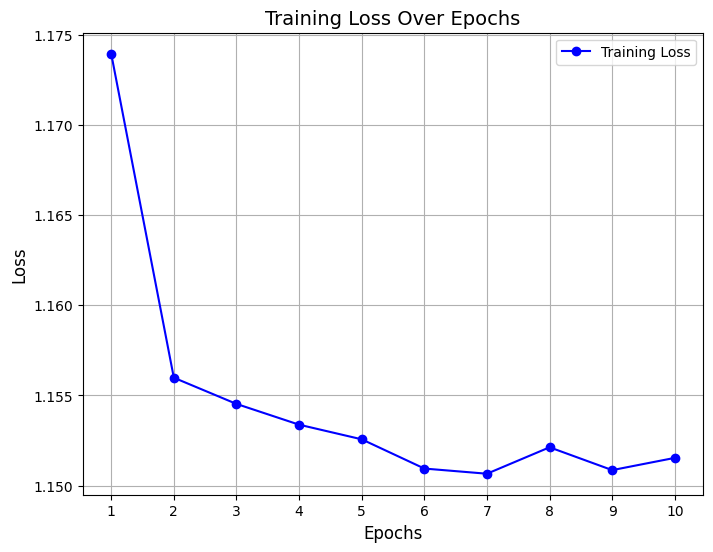

In [ ]:
import matplotlib.pyplot as plt

# Loss values for each epoch
epochs = range(1, 11)
loss_values = [
    1.1739439258177078, 1.1559818285943764, 1.1545292163341032,
    1.1533783041207621, 1.1525668969585992, 1.1509457283967572,
    1.1506591914964173, 1.1521248419081425, 1.1508587799090897, 1.1515383972479738
]

# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()
